<h1><center> 
DeepLearning-Based RNA Toehold Switch Functionality Predictor Using One-Hot Sequence CNN + MLP with Rational Parameters
</center></h1>

<center>
Nicolaas M Angenent-Mari<sup>1,2*</sup> Alexander S. Garruss<sup>2,3*</sup>,, Luis R. Soenksen<sup>1,2*</sup>, Diogo M. Camacho<sup>2*</sup>, Katherine M Collins<sup>1*</sup>, George Church<sup>1,2,3,4</sup>, Timothy K. Lu<sup>1,4</sup>, and James J. Collins<sup>1,2,3,4</sup>
</center>


<center><font color=gray><font size="1.5">
<sup>1</sup>Massachusetts Institute of Technology, <sup>2</sup>Wyss Institute for Biologically Inspired Engineering, <sup>3</sup>Harvard John A. Paulson School of Engineering and Applied Sciences, and <sup>4</sup>Broad Institute of MIT and Harvard. *Contributed equally
</font></font></center>


##### Abstract:
<font color=black><font size="2">
A benchmark tool in the field of synthetic biology is the RNA “Toehold-Switch”, a riboregulator that responds to a programmable target to change its secondary structure through strand displacement with up-regulation of a desired protein. Recent advances have streamlined the synthesis of these modules; however, in vitro and in vivo functionality remain highly unpredictable due to complex interactions unanticipated by standard base-pairing models. We are developing and testing aa high-quality library of 244,000 toehold sequences to train and optimize a Convolutional Neural Net (CNN) deep-learning architecture based on RNA tensors in parallel with an Multi Layered Perceptron (MLP) using rational parameters to enable accurate biological predictions of novel toehold sensor functionality.
</font></font>

---------------------------------------------------------------------------------------------

References:

> Randal S. Olson, Ryan J. Urbanowicz, Peter C. Andrews, Nicole A. Lavender, La Creis Kidd, and Jason H. Moore (2016). Automating biomedical data science through tree-based pipeline optimization. Applications of Evolutionary Computation, pages 123-137.

>Randal S. Olson, Nathan Bartley, Ryan J. Urbanowicz, and Jason H. Moore (2016). Evaluation of a Tree-based Pipeline Optimization Tool for Automating Data Science. Proceedings of GECCO 2016, pages 485-492.

---------------------------------------------------------------------------------------------

#### DATA STRUCTURE (INPUT / OUTPU)
> Data is loaded from a Toehold Sensor Database (data/2019-03-30_toehold_dataset_proc_with_params.csv) which is comma delimited table  having the following columns of DNA encoded sub-sequences: organism, sequence_class, sequence_id, pre_seq	promoter, trigger, loop1, switch, loop2, stem1, atg, stem2m linkerm post_linker, output	
> #### Input tensor is defined as (DS=Data_Style):
> **DS_1 CNN)**  Toehold DNA Sequence <br>
> *NOTE:  Base toehold string sequence [0-144]
> *       GGG  - Trigger - Loop1 - Switch  - Loop2 - Stem1 -  AUG  -  Stem2  -  Linker - Post-linker
> *     [-3,-1]  [0,-29]  [30-49]  [50-79]  [80-90] [91,96] [97,99] [100,108] [109,134]  [135,144]
> *     
> *     For training we select our input sequence vector start with GGG and concatenate everything from "Loop1" to "post-linker"... which is seq_SwitchOFF_GFP  = ggg + seq[30:145].
> *     Also, pre_seq & promoter sub-sequences are NEVER used because they are not converted into mRNA (is in the plasmid but > *     it is never in the functional toehold module), so it won't contribute in > *     secondary structure at all. For this example > *     in particular we use DS_1.
> **DS_1 MLP)**  Toehold DNA Sequence Rational Parameters <br>
> *       INPUT VECTOR = 
             ['i_ed_seq_Stem',\
              'i_ed_seq_StemTop',\
              'i_ed_seq_SwitchOFF',\
              'i_ed_seq_SwitchOFF_GFP',\
              'i_ed_seq_SwitchOFF_NoTo',\
              'i_ed_seq_SwitchON',\
              'i_ed_seq_SwitchON_GFP',\
              'i_ed_seq_ToeholdON',\
              'mfe_seq_AscendingStem',\
              'mfe_seq_DescendingStem',\
              'mfe_seq_RBS_GFP',\
              'mfe_seq_RBS_Linker',\
              'mfe_seq_Stem',\
              'mfe_seq_StemTop',\
              'mfe_seq_SwitchOFF',\
              'mfe_seq_SwitchOFF_GFP',\
              'mfe_seq_SwitchOFF_NoTo',\
              'mfe_seq_SwitchON',\
              'mfe_seq_SwitchON_GFP',\
              'mfe_seq_ToeholdOFF',\
              'mfe_seq_ToeholdON',\
              'mfe_seq_Trigger',\
              'n_ed_seq_Stem',\
              'n_ed_seq_StemTop',\
              'n_ed_seq_SwitchOFF',\
              'n_ed_seq_SwitchOFF_GFP',\
              'n_ed_seq_SwitchOFF_NoTo',\
              'n_ed_seq_SwitchON',\
              'n_ed_seq_SwitchON_GFP',\
              'n_ed_seq_ToeholdON' ]
> #### Output vector is defined as:
> **OUT_1)** ON, Off & ON-OFF State values derived from the experimental testing of toehold switch RNA sequence

#### PROBLEM DEFINITION
> To investigate if a deep learning network can be used to predict toehold switch ON/OFF functionality, because in that case it would suggest the network is learning secondary structure prediction that would be transferable to other RNA based problems.

--------------------------------------------------------------------------------------------------------------------------------------------------------

### STEP 0)   Loading, Import Modules & Core helper functions
#### This code requires the following pre-installs:
> ##### Biopython
> In anaconda env: `conda install -c anaconda biopython` or `pip install biopython`<br>
> Ref: https://github.com/biopython/biopython
> ##### ViennaRNA
> In anaconda env: `conda install -c bioconda viennarna`<br>
> Ref: https://github.com/ViennaRNA/ViennaRNA
> ##### Pysster (Python 3.5+)
> In anaconda env: `pip3 install pysster`<br>
> Ref: https://github.com/budach/pysste

In [1]:
## Import Libraries
# General system libraries
import os
import gc
import cv2
import math
import h5py
import locale
import inspect
import argparse
import numpy as np
import pandas as pd
from time import time
from datetime import datetime
from subprocess import call

# Math & Visualization Libs
import math
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import cycle
from scipy import stats, interp
from IPython.display import Image

# Multiprocessing
import multiprocessing

# DNA/RNA Analysis Libraries (Biopython, ViennaRNA, pysster) 
# > Biopython Lib
import Bio
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import generic_rna, generic_dna, generic_protein, IUPAC
# > ViennaRNA Lib
import RNA

#RNAssp
import src.RNAssp.rna as rnassp

# Import Tensorflow
import tensorflow as tf

# Import Json
import json
import codecs

# Import Keras
from keras import optimizers
from keras import applications
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, load_model
from keras.models import model_from_json, load_model
from keras.layers import Activation, Conv1D, Conv2D, Reshape, BatchNormalization, Dropout, Flatten, Dense, merge, Input, Lambda, InputLayer, Convolution2D, MaxPooling1D, MaxPooling2D, ZeroPadding2D, Bidirectional, concatenate
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import multi_gpu_model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint

#Import Keras-Vis for Saliency
from vis.utils import utils
from vis.visualization import get_num_filters
from vis.visualization import visualize_activation, visualize_saliency, visualize_cam, overlay
    ## NOTE: Install in conda enviroment: pip install git+https://github.com/raghakot/keras-vis.git -U

# Import sklearn libs
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import roc_curve, auc
    ## NOTE: Activate a new terminal to monitor NVIDIA GPU usage writing
        # watch -n0.5 nvidia-smi
    ## NOTE: If not present, activate GPU persistence mode in terminal with
        # sudo nvidia-smi -pm 1
    ## If you do not see any GPU usage try uncommenting the following line:
        # sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) #To ensure activation of GPUs in TF Backend

# Progress Bar
from tqdm import tqdm

# Warnings
import warnings
warnings.filterwarnings("ignore")

#Visualization mode
#%matplotlib ipympl

Using TensorFlow backend.


In [2]:
## Define helper function to copy full directory for backups
def copy_full_dir(source, target):
    call(['cp', '-a', source, target]) # Unix
    
#Get number of available GPUs
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
ngpus = len(get_available_gpus())
print('Available GPUs: '+ str(ngpus))

Available GPUs: 8


-----------------------------------------------------------------------------------------------------------------------------

### 1) Import Dataset & Define Raw Input(s)/Output(s)
> Full data CSV read, includes all necessary information to train and test

In [3]:
# Create Data folder if not existent
data_folder = "data/"
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)
    
## Define general path to store all generated models
core_models_path = 'models/'
# Create Data folder if not existent
if not os.path.isdir(core_models_path):
    os.makedirs(core_models_path)

# Define path to load desired Toehold dataset file (.csv)
data_filename = "2019-07-08_toehold_dataset_proc_with_params_QC1_1.csv"
data_path = data_folder + data_filename
data = pd.read_csv(data_path)

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed) # Seed can be any number

In [4]:
### Datata Sequence ID selection
id_data = data['sequence_id']

### Toehold Switch dataset input/output columns for selection
input_cols_cnn = 'seq_SwitchON_GFP'
input_cols_mlp = ['i_ed_seq_Stem',\
                  'i_ed_seq_StemTop',\
                  'i_ed_seq_SwitchOFF',\
                  'i_ed_seq_SwitchOFF_GFP',\
                  'i_ed_seq_SwitchOFF_NoTo',\
                  'i_ed_seq_SwitchON',\
                  'i_ed_seq_SwitchON_GFP',\
                  'i_ed_seq_ToeholdON',\
                  'mfe_seq_AscendingStem',\
                  'mfe_seq_DescendingStem',\
                  'mfe_seq_RBS_GFP',\
                  'mfe_seq_RBS_Linker',\
                  'mfe_seq_Stem',\
                  'mfe_seq_StemTop',\
                  'mfe_seq_SwitchOFF',\
                  'mfe_seq_SwitchOFF_GFP',\
                  'mfe_seq_SwitchOFF_NoTo',\
                  'mfe_seq_SwitchON',\
                  'mfe_seq_SwitchON_GFP',\
                  'mfe_seq_ToeholdOFF',\
                  'mfe_seq_ToeholdON',\
                  'mfe_seq_Trigger',\
                  'n_ed_seq_Stem',\
                  'n_ed_seq_StemTop',\
                  'n_ed_seq_SwitchOFF',\
                  'n_ed_seq_SwitchOFF_GFP',\
                  'n_ed_seq_SwitchOFF_NoTo',\
                  'n_ed_seq_SwitchON',\
                  'n_ed_seq_SwitchON_GFP',\
                  'n_ed_seq_ToeholdON' ]

output_cols = ['ON', 'OFF', 'ON_OFF']
qc_levels = [1.1]
doTrain = True
loss_init = 'mae' #'logcosh', #'mse', 'mae', 'r2'
n_foldCV = 10
verbose_init = True
evaluate  = True
display_init = True

### Define data scaler (if any)
scaler_init = True
scaler = QuantileTransformer(output_distribution='uniform')

### DEFINE MODEL NAME (e.g. MLP, CNN, LSTM, etc.)
model_name = 'MLP_1D_MLP_RP'

#Show sample of dataframe structure
data.head()

off_id  \
0  AACCAAACACACAAACGCACAAAAAAAAAAAAAAAAAATGGAAAAC...   
1  AACCAAACACACAAACGCACAAAAAAAAAAAAATGGAAAACAGTTA...   
2  AACCAAACACACAAACGCACAAAAAAAAATTACTACTATTGTTAAT...   
3  AACCAAACACACAAACGCACAAAAAAAATAACGTAGGACTACTACT...   
4  AACCAAACACACAAACGCACAAAAAAAATGGAAAACAGTTACTAAT...   

                                               on_id source_sequence  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
2  CTAAATTAACAATAGTAGTAATTTTTTTTTAACCAAACACACAAAC...        smallpox   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTTAACCAAACACACAAAC...        smallpox   
4  ACATATTAGTAACTGTTTTCCATTTTTTTTAACCAAACACACAAAC...        smallpox   

          sequence_id               pre_seq              promoter  \
0  smallpox_tile_2626  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
1  smallpox_tile_2625  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
2  smallpox_tile_4951  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
3  smallpox_tile_6492  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
4  smallpox_tile_2624  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   

                          trigger                 loop1  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
2  CTAAATTAACAATAGTAGTAATTTTTTTTT  AACCAAACACACAAACGCAC   
3  TCCAAGTAGTAGTCCTACGTTATTTTTTTT  AACCAAACACACAAACGCAC   
4  ACATATTAGTAACTGTTTTCCATTTTTTTT  AACCAAACACACAAACGCAC   

                           switch        loop2    ...     Cbn1_off  Cbn2_off  \
0  AAAAAAAAAAAAAAAAAATGGAAAACAGTT  AACAGAGGAGA    ...     0.000000  1.000000   
1  AAAAAAAAAAAAATGGAAAACAGTTACTAA  AACAGAGGAGA    ...          NaN       NaN   
2  AAAAAAAAATTACTACTATTGTTAATTTAG  AACAGAGGAGA    ...     1.000000  0.000000   
3  AAAAAAAATAACGTAGGACTACTACTTGGA  AACAGAGGAGA    ...     0.883458  0.116542   
4  AAAAAAAATGGAAAACAGTTACTAATATGT  AACAGAGGAGA    ...     0.815066  0.000000   

   Cbn3_off Cbn4_off        ON       OFF    ON_OFF QC_ON QC_OFF QC_ON_OFF  
0  0.000000      0.0       NaN  0.333333       NaN   NaN    NaN       NaN  
1       NaN      NaN       NaN       NaN       NaN   NaN    NaN       NaN  
2  0.000000      0.0  0.068295  0.000000  0.068295   2.0    1.1       1.1  
3  0.000000      0.0  0.000000  0.038847 -0.038847   1.1    2.0       1.1  
4  0.184934      0.0  0.080666  0.123289 -0.042624   2.0    3.0       2.0  

[5 rows x 99 columns]

-----------------------------------------------------------------------------------------------------------------------------

### 2) Definition of Pre-Processing Input(s)/Output(s) functions

> Define helper functions for one-hot encoding and Generation of Connectivity Map Tensors

> Definition of full input and output vectors for the network

In [5]:
# Helper function to pass string DNA/RNA sequence to one-hot
def dna2onehot(seq):
    #get sequence into an array
    seq_array = np.array(list(seq))
    
    #integer encode the sequence
    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    
    #one hot the sequence
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    #reshape because that's what OneHotEncoder likes
    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
    onehot_encoded_seq = onehot_encoder.fit_transform(integer_encoded_seq)
    
    return onehot_encoded_seq

In [6]:
# INPUT / OUTPUT DEFINITION, PROCESSING & LOADING MIXED DATA FOR ENSEMBLE MODEL
def pre_process_mixed_data (data, input_cols_cnn, input_cols_mlp, output_cols, export_path, qc_level_threshold=1, scaler_init=False, display=True):
    ## OUTPUT / INPUT DEFINITION, PROCESSING & LOADING
    
    #Init process bar
    tqdm.pandas() # Use `progress_apply` when `applying` one hot encoding and complementarity function to dataframe of input sequences

    # Define path to store input / output arrays
    tmp_data_path = 'data/tmp/'
    # Create Data folder if not existent
    if not os.path.isdir(tmp_data_path):
        os.makedirs(tmp_data_path)

    # GENERATE & SAVE FULL INPUT VECTORS (only if not exists because it is a large file)
    tmp_data_input_path_cnn = (tmp_data_path + 'data_input_file_1d_' + input_cols_cnn + '.h5')
    if not os.path.exists(tmp_data_input_path_cnn):
        # Data Input selection & Generation if absent (or delete it to re-calculate)
        n_batch_samples = 10000 #We constrain process batches to this number to allow for progressive saving of large files
        n_batches = math.ceil(len(data[input_cols_cnn])/n_batch_samples)
        
        if n_batches>1:
            print('Processing in batches...')
            
        # Process and Append Save:
        with h5py.File(tmp_data_input_path_cnn, 'a') as hf:
            is_first=True
            for data_tmp in np.split(data[input_cols_cnn], n_batches):
                df_data_input_tmp = data_tmp.progress_apply(dna2onehot)
                data_input_tmp = np.array(list(df_data_input_tmp.values))
                if is_first==True:
                    dset = hf.create_dataset("input",  data=data_input_tmp, maxshape=(None, data_input_tmp.shape[1], data_input_tmp.shape[2]), chunks=(n_batches,data_input_tmp.shape[1], data_input_tmp.shape[2])) 
                    is_first=False
                else:
                    dset.resize((dset.shape[0]+data_input_tmp.shape[0],data_input_tmp.shape[1],data_input_tmp.shape[2]))  
                    dset[-data_input_tmp.shape[0]:,:,:] = data_input_tmp
    
    # SAVE FULL INPUT VECTORS FOR MLP (only if not exists because it is a large file)
    tmp_data_input_path_mlp = (tmp_data_path + 'data_input_file_rp.h5')
    if not os.path.exists(tmp_data_input_path_mlp):
        # Data Input selection & Generation if absent (or delete it to re-calculate)
        df_data_input_mlp = data[input_cols_mlp]
        data_input_mlp = np.array(list(df_data_input_mlp.values))
        #Save:
        with h5py.File(tmp_data_input_path_mlp, 'w') as hf:
            hf.create_dataset("input",  data=data_input_mlp)
    
    # GENERATE & SAVE FULL OUTPUT VECTORS
    output_ids = "_".join(str(x) for x in output_cols)
    tmp_data_output_path = (tmp_data_path + 'data_output_file_QC_' + str(qc_level_threshold).replace('.','-') + '_' + output_ids + '.h5')
    
    # Data Output selection (QC filtered, OutColumns Only & Drop NaNs)
    df_data_output = data[data.QC_ON_OFF >= qc_level_threshold]
    df_data_output= df_data_output[output_cols]
    df_data_output = df_data_output.dropna(subset=output_cols)
    data_output = df_data_output.as_matrix().astype('float32')
    #Save:
    with h5py.File(tmp_data_output_path, 'w') as hf:
        hf.create_dataset("output",  data=data_output)
    
    #Load full CNN input array in memory and QC filter
    with h5py.File(tmp_data_input_path_cnn, 'r') as hf:
        data_input_cnn = hf['input'][:] #Loading with read from hard-disk
        data_input_cnn = data_input_cnn[df_data_output.index.values][:][:]
    
    #Load full MLP input array in memory and QC filter
    with h5py.File(tmp_data_input_path_mlp, 'r') as hf:
        data_input_mlp = hf['input'][:] #Loading with read from hard-disk
        data_input_mlp = data_input_mlp[df_data_output.index.values][:][:]
        #Apply only for Rational parameters
        data_input_mlp = MinMaxScaler().fit_transform(data_input_mlp)
    
    #Load full output array in memory and QC filter
    with h5py.File(tmp_data_output_path, 'r') as hf:
        data_output = hf['output'][:]
        data_output_orig = data_output
        #Pre-process data (scaler)
        if scaler_init==True:
            data_output = scaler.fit_transform(data_output)
    
    #Load Full list of sequences after filtering
    data_seqs_cnn = data[input_cols_cnn][df_data_output.index.values]
    
    # Display processed data if desired
    if display==True:
        ### Show example of processed dataset
        ## Display number of retrieved sequences
        print("Number of sequences retrieved 1D: "+str(len(data_input_cnn)))
        print()
        print("Number of sequences retrieved RP: "+str(len(data_input_mlp)))
        print()

        #Select ID to show
        toehold_id = 0 

        ## Plot Example input toehold matrix 
        print('EXAMPLE OF INPUT ONE-HOT TOEHOLD')
        onehot_encoded_seq = dna2onehot(data_seqs_cnn.iloc[toehold_id])
        print(onehot_encoded_seq.transpose())
        print()
        
        # Display input size
        print("Input Size: " + str(onehot_encoded_seq.shape))
        print()
        
        ## Plot Example input toehold matrix 
        print('EXAMPLE OF INPUT VECTOR RATIONALPARAMETERS')
        print(' ' + str(data_input_mlp[toehold_id]))
        print()
        
        # Display input size
        print("Input Size: " + str(data_input_mlp[toehold_id].shape))
        print()


        # Display example of Output vector
        print('EXAMPLE OF OUTPUT VECTOR')
        print(' ' + str(data_output[toehold_id]))
        print()

        # Display Output Values
        for index,item in enumerate(output_cols):
            # Display Output Values
            plt.figure()
            print('Distribution of ' + str(item) + ' Values')
            sns.distplot(data_output[:,index], kde=True, rug=False)
            #Tight plot
            plt.tight_layout()
            # Save figure
            plt.savefig(export_path + "/QC_" + str(qc_level_threshold).replace('.','-') + "_" + str(item) + "_dist.png", bbox_inches='tight', dpi=300)
        
        if scaler_init==True:           
            ## COMPUTE EFFECT OF SCALER
            # Difference between the transformed toehold output values and original toehold output values, 
            # then compute the absolute percentage difference for diplay
            test_metrics = np.zeros((data_output_orig.shape[1],3))
            diff = data_output_orig - data_output
            abstDiff = np.abs(diff)
            # Compute the mean and standard deviation of the absolute difference:
            apd_mean = np.mean(abstDiff, axis=0)
            apd_std = np.std(abstDiff, axis=0)
            apd_r2 = np.zeros_like(apd_mean)
            
            # Plot: Scaled Output values vs. Original values and get R2 value
            for index,item in enumerate(output_cols):
                # R2 (Coefficient of Determination)
                apd_r2[index] = r2(data_output_orig[:,index], data_output[:,index])
                
                # Display Output Values
                x=np.squeeze(data_output_orig[:,index])
                y=np.squeeze(data_output[:,index])
                
                # Display Output Values
                print('')
                print("" + item + " Mean_absolute_error (TRANSFORMATION): " + str(apd_mean[index]) + " (SD: " + str(apd_std[index]) + ")" )
                print('')
                print('TRANSFORMED Values vs. ORIGINAL values (' + item + ')' )
                print('Pearson Correlation: '+ str(stats.pearsonr(x, y)[0]))
                print('Spearman Correlation: '+ str(stats.spearmanr(x, y)[0]))
                print('R2: '+ str(apd_r2[index]))
                print('')
                
                if scaler_init == True:
                    g = sns.jointplot(x, y, kind="reg", color="b", xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), stat_func=r2)
                else:
                    g = sns.jointplot(x, y, kind="reg", color="b", stat_func=r2)
                g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
                g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
                g.ax_joint.collections[0].set_alpha(0)
                g.set_axis_labels("$ORIGINAL$", "$TRANSFORMED$");

                # save the figure
                g.savefig(export_path + "/QC_" + str(qc_level_threshold).replace('.','-') + "_" + str(item) + "_data_scaling_" + str(item) + ".png", bbox_inches='tight', dpi=300)
                
                # Store model performance metrics for return   
                test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
                
            # SAVE METRICS (.npy file)
            np.save(export_path + '/scaling_metrics',test_metrics)
            # SAVE DATA (.npz file)
            np.savez(export_path + '/scaling_data',data_output_orig,data_output) 

    return data_input_cnn, data_input_mlp, data_output

-----------------------------------------------------------------------------------------------------------------------------

### 3) Definition of Model Architecture Function
> Funtion to create keras model architecture
> Helper functions to save and evaluate models

In [7]:
### Function to create Keras MLP for regression prediction
def create_mlp_1d(width, height, filters=[32, 64, 128], regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (width, height) #DNA/RNA input sequence (one hot encoded)
    chanDim = -1
    dropout_init = 0.2
    
    # define the model input
    inputs = Input(shape=inputShape)

    x = inputs
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)
    
    x = Dense(64, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)

    x = Dense(32, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)


    
    # check to see if the regression node should be added
    if regress:
        x = Dense(len(output_cols), activation="linear")(x)
    else:
        x = Dense(len(output_cols), activation="sigmoid")(x)

    # Construct the Model
    model = Model(inputs, x) 
    
    # Return the model
    return model

In [8]:
### Function to create Keras MLP for regression prediction
def create_mlp_rp(length, regress=False):
    # Define our MLP network
    inputShape = (length,) #DNA/RNA rational parameters
    inputs = Input(shape=inputShape)
    chanDim = -1
    dropout_init=0.2
    
    # Define dense layers
    x = inputs
    x = Dense(25, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)
    x = Dense(10, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)
    x = Dense(7, activation="relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(dropout_init)(x)
        
    # Check to see if the regression node should be added
    if regress:
        x = Dense(len(output_cols), activation="linear")(x)
    else:
        x = Dense(len(output_cols), activation="sigmoid")(x)
        
    # Construct the Model
    model = Model(inputs, x) 
    
    # Return the model
    return model

In [9]:
### Function to create Keras Ensamble CNN-MLP model for regression prediction
def create_ensemble_cnn_1d_mlp_rp(width_cnn, height_cnn, length_mlp, regress=False):
    # Define our MLP network
    # create the MLP and CNN models
    cnn = create_mlp_1d(width=width_cnn, height=height_cnn, regress=False)
    mlp = create_mlp_rp(length=length_mlp, regress=False)
 
    # Create the input to our final set of layers as the 
    # *output* of both the MLP and CNN
    combinedInput = concatenate([cnn.output, mlp.output])

    # Our final FC layer head will have two dense layers, the final one
    # being our regression head
    x = Dense(4, activation="relu")(combinedInput)

    # Check to see if the regression node should be added
    if regress:
        x = Dense(len(output_cols), activation="linear")(x)
    else:
        x = Dense(len(output_cols), activation="sigmoid")(x)
    
    # Construct the Model
    # our final model will accept matrix inputs on the CNN and categorical/numerical data on the MLP
    # to output a single prediction vector
    model = Model(inputs=[cnn.input, mlp.input], outputs=x)
    
    # Return the model
    return model

In [10]:
# Helper functions to save/load model and training history
def saveHist(path,history):
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
            if  type(history.history[key][0]) == np.float64:
                new_hist[key] = list(map(float, history.history[key]))

    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 
        
def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n

def save_model(model, identifier):
    ## MODEL SAVING ON WORKING FOLDER
    # Option 1: Save via Weights + Architecture
    model.save_weights(os.path.abspath(model_path)+'/model_weights_'+str(identifier)+'.h5')
    with open(os.path.abspath(model_path)+'/model_architecture_'+str(identifier)+'.json', 'w') as f:
        f.write(model.to_json())

    # Option 2: Save entire model at once
    model.save(os.path.abspath(model_path)+'/model_'+str(identifier)+'.h5')

In [11]:
#Definition of R2 metric for testing
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

#Definition of Custom metric as loss related to Coefficient of Determination (R2) 
#  CoD = 1 - MSE / (variance of inputs), and since this is going to be a loss we want 
#  improvement to point towards zero, so we choose mse/variance of inputs
def custom_r2_loss(y_true, y_pred): 
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return (SS_res/(SS_tot + K.epsilon()))

#Definition of Custom metric as loss related to Weigted Mean Absolute error
#  Improvement points towards zero, but penalizes loss for small values and improves it for larger values
def custom_wmae_loss(y_true, y_pred): 
    from keras import backend as K
    weightedMAE = K.abs((y_true-y_pred)*y_true) #Increase loss for large ON or OFF values -- Skews focus of distribution right
    return weightedMAE

### 4) Definition of BASE Model Generator (with Training using Manual Verification Dataset & Evaluation)
> For use with a priori training (suggested: 75%) & testing (suggested: 25%) split, with internal training validation from the training set (10% or the 75%)
> For evaluation on unseen testing data (suggested: 25%) 
> This generator function generates and saves model in target path

In [12]:
### Define our final model architecture (layers & optimizor) and then compile it
def generate_ensemble_model(model_path, trainX_cnn, testX_cnn, trainX_mlp, testX_mlp, trainY, testY, verbose_init, evaluate=True):
    
    ## DEEP-LEARNING TRAINING PARAMETERS(e.g. verbose, patients, epoch size, batch size) to constrain process
    verbose_init = verbose_init #Zero is no keras verbose
    patience_init = 20 # Number of epochs to wait for no model improvement before early stopping a training
    epochs_init = 300 # Max number of epochs to perform (to cap training time)
    batch_size_init = 64*(1+ngpus) # number of samples that will be propagated through the network at every epoch dependent on the number of GPUs
    validation_spit_init = 0.1 # Percentage of testing data to use in internal validation during training
    
    ## Create folder to store model (if not existent)
    if not os.path.isdir(model_path):
        os.makedirs(model_path)
        
    ## Callbacks for training:
    #  Save the model weights to the same file, if and only if the validation accuracy improves.
    checkpoint_file_name = "model_checkpoint_weights.h5"
    model_checkpoint_path = os.path.join(os.path.abspath(model_path), checkpoint_file_name)
    
    if verbose_init==True:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [ModelCheckpoint(model_checkpoint_path, monitor='val_loss', verbose = verbose_init, save_best_only=True, mode='auto'),
                          EarlyStopping(monitor='val_loss', patience=patience_init, verbose = verbose_init),
                          TQDMNotebookCallback()] # Adds Keras integration with TQDM progress bars.
    else:
        # Callback to be used for checkpoint generation and early stopping
        callbacks_list = [ModelCheckpoint(model_checkpoint_path, monitor='val_loss', verbose = False, save_best_only=True, mode='auto'),
                          EarlyStopping(monitor='val_loss', patience=patience_init, verbose = False)]    
    
    ## Create Model (Change for MLP, CNN, ETC)
    # -------------------------------------------------------------------------------------------------------------------------------------
    # Define CNN model input shape
    (width_cnn, height_cnn) = np.shape(trainX_cnn[0])
    # Define MLP model input shape with rational parameters
    length_mlp = trainX_mlp.shape[1]
    
    # Define core model on CPU
    with tf.device("/cpu:0"):  
        model = create_ensemble_cnn_1d_mlp_rp(width_cnn, height_cnn, length_mlp, regress=True)
        
    ## Initialize the optimizer and Compile model:
    #   Custom metric is used (see above), if we use "Mean absolute percentage error" that
    #   implies that we seek to minimize the absolute percentage difference between 
    #   our *predictions* and *actual* output values. We also calculate other 
    #   valuable metrics for regression evaluation 
    opt = Adam(lr=0.001, epsilon=None, decay=1e-3/200, amsgrad=False) # epsilon=1e-1 for POISSON loss
    
    if loss_init=="r2":
        model.compile(loss=custom_r2_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_r2_loss])
    elif loss_init =="wmae":
        model.compile(loss=custom_wmae_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_wmae_loss])
    else:
        model.compile(loss=loss_init, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc']) 
        
    # -------------------------------------------------------------------------------------------------------------------------------------  
        
    ## Parallel computing (if multiple GPUs are available)
    # Define model for training (CPU, Single GPU or Multi-GPU depending on availability of resources)
    if ngpus<=1:
        print("[INFO] training with Single GPU or CPU...")
        model_history = model.fit([trainX_cnn, trainX_mlp], trainY, validation_split=validation_spit_init, epochs=epochs_init, batch_size=batch_size_init, callbacks=callbacks_list, verbose=verbose_init)

    else:
        print("[INFO] training with {} GPUs...".format(ngpus))
        # make the model parallel
        parallel_model = multi_gpu_model(model, gpus=ngpus)
        
        if loss_init=="r2":
            parallel_model.compile(loss=custom_r2_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_r2_loss])
        elif loss_init =="wmae":
            parallel_model.compile(loss=custom_wmae_loss, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc', custom_wmae_loss])
        else:
            parallel_model.compile(loss=loss_init, optimizer=opt,  metrics=['mse','mae', 'mape', 'cosine','acc']) 
        
        model_history = parallel_model.fit([trainX_cnn, trainX_mlp], trainY, validation_split=validation_spit_init, epochs=epochs_init, batch_size=batch_size_init, callbacks=callbacks_list, verbose=verbose_init)    
                    

    ## MODEL SAVING
    # Option 1: Save via Weights + Architecture
    model.save_weights(os.path.abspath(model_path)+'/model_weights.h5')
    with open(os.path.abspath(model_path)+'/model_architecture.json', 'w') as f:
        f.write(model.to_json())
    # Option 2: Save entire model at once
    model.save(os.path.abspath(model_path)+'/model.h5')
    # Save model graph to file
    model_graph_path = model_path + '/model_graph.png'
    #plot_model(model, to_file=model_graph_path, show_shapes=True, show_layer_names=True)
    # Save training history
    saveHist(model_path + '/model_history', model_history)
        
    ## MODEL LOADING (to ensure it works)
    # Option 1: Load latest model via Weights + Architecture
    #with open(os.path.abspath(model_path)+'/model_architecture.json', 'r') as f:
    #    model = model_from_json(f.read())
    #    model.load_weights(os.path.abspath(model_path)+'/model_weights.h5')
    # Option 2: Load latest model via entire model at once
    if loss_init=="r2":
        model = load_model(os.path.abspath(model_path)+'/model.h5', custom_objects={'custom_r2_loss': custom_r2_loss})
    elif loss_init =="wmae":
        model = load_model(os.path.abspath(model_path)+'/model.h5', custom_objects={'custom_wmae_loss': custom_wmae_loss})
    else:
        model = load_model(os.path.abspath(model_path)+'/model.h5')
    
    # Load model training history
    model_history = loadHist(model_path + '/model_history')
    
    # Init prediction output matrix
    testX_Preds = np.zeros_like(testY) #Empty matrix for full prediction evaluation
    # Init performance metrics matrix
    test_metrics = np.zeros((trainY.shape[1],3)) #Empty matrix for model performance metrics
    
    # GENERATE PREDICTIONS
    if (testX_cnn.size > 0) and (testX_mlp.size > 0):
        ## Make predictions on testing data:
        print("Predicting functionality of Test Toeholds ...")
        print("")
        #Predictions in scaled space
        testX_Preds = model.predict([testX_cnn, testX_mlp])
        
        if scaler_init == True:
            testY = scaler.inverse_transform(testY)
            testX_Preds = scaler.inverse_transform(testX_Preds)
        
        ## EVALUATE PERFORMANCE OF MODEL
        if evaluate==True:
            ## Plot training metrics per fold:
            plt.figure ()
            ax1 = plt.subplot(221)
            ax2 = plt.subplot(222)
            ax3 = plt.subplot(223)
            ax4 = plt.subplot(224)
            # Plot MSE metric
            ax1.set_title("Mean squared error")
            ax1.plot(model_history['mean_squared_error'])
            # Plot MAE metric
            ax2.set_title("Mean absolute error")
            ax2.plot(model_history['mean_absolute_error'])
            # Plot MAPE metric
            ax3.set_title("Mean absolute percentage error")
            ax3.plot(model_history['mean_absolute_percentage_error'])
            # Plot CP metric
            ax4.set_title("Cosine Proximity")
            ax4.plot(model_history['cosine_proximity'])
            #Tight plot
            plt.tight_layout()
            # Save figure
            plt.savefig(model_path + "/model_training_metrics.png", bbox_inches='tight', dpi=300)

            ## Plot compiled training metrics per fold:
            plt.figure()
            plt.style.use("default")
            N = np.arange(0, len(model_history["loss"]))
            # Plot used Loss metric
            plt.plot(N, model_history["loss"], label="train_loss")
            plt.plot(N, model_history["val_loss"], label="test_loss")
            # Plot used Accuracy metric (applicable only if categorical model)
            plt.plot(N, model_history["acc"], label="train_acc")
            plt.plot(N, model_history["val_acc"], label="test_acc")
            # Plot MSE metric
            plt.plot(N, model_history["mean_squared_error"], label="train_mse")
            plt.plot(N, model_history["val_mean_squared_error"], label="test_mse")
            # Plot MAE metric
            plt.plot(N, model_history["mean_absolute_error"], label="train_mae")
            plt.plot(N, model_history["val_mean_absolute_error"], label="test_mae")
            # Plot MAPE metric
            plt.plot(N, model_history["mean_absolute_percentage_error"], label="train_mape")
            plt.plot(N, model_history["val_mean_absolute_percentage_error"], label="test_mape")
            # Plot CP metric
            plt.plot(N, model_history["cosine_proximity"], label="train_cp")
            plt.plot(N, model_history["val_cosine_proximity"], label="test_cp")
            plt.title("CNN Toehold Complementary Rep Data")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Place a legend to the right of this smaller subplot.
            # Save figure
            plt.savefig(model_path + "/model_training_compilation.png", bbox_inches='tight', dpi=300)
            
            
            ## COMPUTE PERFORMANCE METRICS
            # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
            # then compute the absolute percentage difference for diplay
            diff = testX_Preds - testY
            abstDiff = np.abs(diff)
            # Compute the mean and standard deviation of the absolute difference:
            apd_mean = np.mean(abstDiff, axis=0)
            apd_std = np.std(abstDiff, axis=0)
            apd_r2 = np.zeros_like(apd_mean)
            # Plot: Predicted values vs. Experimental values and get R2 value
            for index,item in enumerate(output_cols):

                # R2 (Coefficient of Determination)
                apd_r2[index] = r2(testX_Preds[:,index], testY[:,index])
                
                # Display Output Values
                x=np.squeeze(testX_Preds[:,index])
                y=np.squeeze(testY[:,index])
                
                # Display Output Values
                print("" + item + " Mean_absolute_error (TEST): " + str(apd_mean[index]) + " (SD: " + str(apd_std[index]) + ")" )
                print('')
                print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
                print('Pearson Correlation: '+ str(stats.pearsonr(x, y)[0]))
                print('Spearman Correlation: '+ str(stats.spearmanr(x, y)[0]))
                print('R2: '+ str(apd_r2[index]))
                print('')
                
                if scaler_init == True:
                    g = sns.jointplot(x, y, kind="reg", color="b", xlim=(-0.5, 1.5), ylim=(-0.5, 1.5), stat_func=r2)
                else:
                    g = sns.jointplot(x, y, kind="reg", color="b", stat_func=r2)
                g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
                g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
                g.ax_joint.collections[0].set_alpha(0)
                g.set_axis_labels("$PREDICTED$", "$EXPERIMENTAL$");

                # save the figure
                g.savefig(model_path + "/model_performance_" + str(item) + ".png", bbox_inches='tight', dpi=300)
                
                # Store model performance metrics for return   
                test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
                
            # SAVE METRICS (.npy file)
            np.save(model_path + '/test_metrics',test_metrics)
            # SAVE DATA (.npz file)
            np.savez(model_path + '/test_data',testX_Preds, testY) 
                
    return model, model_history, testX_Preds, test_metrics

--------------------------------------------------------------------------------------------------------------------------------------------------------

### 5)  Definition of k-Fold Cross Validated Model Generator (with Ensemble Training, Evaluation & Full Deployment)

> Used the gold standard for machine learning model evaluation is k-fold cross validation

> It provides a robust estimate of the performance of a model on unseen data. 

> It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. 

> The performance measure accross all models in the unseen data for each fold

> The performance is printed for each model and it is stored

> A final deployment model trained in all data (no testing) is provided for evaluation in future data

In [13]:
### Define our crossvalidation model generator (layers, optimizor, compilation, training, reporting, etc)
def generate_ensemble_crossval_model(model_cv_path, X_cnn, X_mlp, Y, n_foldCV, verbose_init=True, evaluate=True):
    
    ## CROSSVALIDATION TRAINING
    # Define CV parameters
    n_foldCV = n_foldCV #Number of Crossvalidation bins
    cv_folds = list(StratifiedKFold(n_splits=n_foldCV, shuffle=True, random_state=seed).split(X_cnn, Y.argmax(1))) # Non repeating CV bins
    cv_preds = np.zeros_like(Y) #Empty matrix for full prediction evaluation
    cv_test_metrics = np.zeros((n_foldCV, Y.shape[1], 3))
    deploy_test_metrics = np.zeros((Y.shape[1],3))
    
    # Perform n-fold crossvalidated training and evaluation
    for j, (train_idx, test_idx) in enumerate(cv_folds):
        print('\nFold ',j)
        
        # Define folder for CV fold model
        model_cv_fold_path = model_cv_path + '/Fold' + str(j) 

        ## CrossValidation Strategy: 
        # We use all data for n-crossvalidation this will give us average metrics of performance in future data
        # for this all data will be devided into n bins. In every sequential fold we will use n-1 bins for training 
        # and the remaining bin for testing this split is done in such a way that all data is used for training and
        # testing at some point (sweet!). Testing points will be aggregated tenerate an average metric of performance
        # and all the datapoints will be put into a master agreement plot for visualization. 
        # A working model will be made using 75% of the data for training and 25% for further testing.
        # A deploy model will be also trained using all available data without testing
        trainX_cnn_cv = X_cnn[train_idx]
        trainX_mlp_cv = X_mlp[train_idx]
        trainY_cv = Y[train_idx]
        testX_cnn_cv = X_cnn[test_idx]
        testX_mlp_cv = X_mlp[test_idx]
        testY_cv = Y[test_idx]
        # NOTE: Validation set is taken internally from the training set (10% of each fold), this is applied in the the model.fit function
        
        
        # Create & Train model each fold according to generator function
        model, model_history, testX_Preds, test_metrics = generate_ensemble_model(model_cv_fold_path, trainX_cnn_cv, testX_cnn_cv, trainX_mlp_cv, testX_mlp_cv, trainY_cv, testY_cv, verbose_init=verbose_init, evaluate=evaluate)
        
        # Record predicted values of each CV fold training to generate an ensemble reporting
        print("Predicting functionality of CV-Fold Test Toeholds & Model performance metrics ...")
        cv_preds[test_idx,:] = testX_Preds
        cv_test_metrics[j,:,:] = test_metrics
        
        ## MODEL MEMORY RELEASE
        del model_history
        del model
        for i in range(ngpus+1): gc.collect()
        
        ## Free-up keras memmory to prevent leaks
        K.clear_session()
    
    #Transform back data
    if scaler_init == True:
        Y = scaler.inverse_transform(Y)
    
    # SAVE METRICS (.npy file)
    np.save(model_cv_path + '/cv_test_metrics',cv_test_metrics) 
    # SAVE DATA (.npz file)
    np.savez(model_cv_path + '/cv_test_data',cv_preds, Y)
            
    
    ## DEFINE FOLDER FOR DEPLOY MODEL
    model_deploy_path = model_cv_path + '/deploy'
    ## Create folder to store model (if not existent)
    if not os.path.isdir(model_deploy_path):
        os.makedirs(model_deploy_path)
    print('')
    print('Generating deployment model...')
    
    # COMPUTE PERFORMANCE METRICS FOR DEPLOY MODEL
    # Difference between the *predicted* toehold functionality values and *actual* toehold functionality values, 
    # then compute the absolute percentage difference for diplay

    diff = cv_preds - Y
    abstDiff = np.abs(diff)
    # Compute the mean and standard deviation of the absolute difference:
    apd_mean = np.mean(abstDiff, axis=0)
    apd_std = np.std(abstDiff, axis=0)
    apd_r2 = np.zeros_like(apd_mean)

    ## EVALUATE ENSEMBLE CROSSVALIDATION PERFORMANCE OF MODEL
    if evaluate==True:
        for index,item in enumerate(output_cols): 
            # R2 (Coefficient of Determination)
            apd_r2[index] = r2(cv_preds[:,index], Y[:,index])
            # Display Output Values
            x_tot=np.squeeze(cv_preds[:,index])
            y_tot=np.squeeze(Y[:,index])
            print('EXPERIMENTAL Values vs. PREDICTED values (' + item + ')' )
            print('Pearson Correlation: '+ str(stats.pearsonr(x_tot, y_tot)[0]))
            print('Spearman Correlation: '+ str(stats.spearmanr(x_tot, y_tot)[0]))
            print('R2: '+ str(apd_r2[index]))
            print('')
            
            if scaler_init == True:
                g = sns.jointplot(x_tot, y_tot, kind="reg", color="b", xlim=(-0.2, 1.2), ylim=(-0.2, 1.2), stat_func=r2)
            else:
                g = sns.jointplot(x_tot, y_tot, kind="reg", color="b", stat_func=r2)
            g.plot_joint(plt.scatter, c="b", s=1, linewidth=1, marker=".", alpha=0.08)
            g.plot_joint(sns.kdeplot, zorder=0, color="m", n_levels=6, shade=False)
            g.ax_joint.collections[0].set_alpha(0)
            g.set_axis_labels("$PREDICTED$", "$EXPERIMENTAL$");
            
            # save the figure
            g.savefig(model_deploy_path + "/model_ensemble_performance_" + str(item) + ".png", bbox_inches='tight', dpi=300)
    
            # Store model performance metrics for return   
            deploy_test_metrics[index, :] = [apd_mean[index], apd_std[index], apd_r2[index]]
            
    # SAVE METRICS (.npy file)
    np.save(model_deploy_path + '/deploy_test_metrics', deploy_test_metrics) 
    # SAVE DATA (.npz file)
    np.savez(model_deploy_path + '/deploy_test_data',cv_preds, Y)
    
    ## DEPLOYMENT MODEL TRAINING (with full dataset)
    # Partition the data into training (90%), validation (10%), testing (0%) splits 
    (trainX_cnn, testX_cnn, trainY_cnn, testY_cnn) = train_test_split(X_cnn, Y, test_size=0.0, random_state=seed)
    (trainX_mlp, testX_mlp, trainY_mlp, testY_mlp) = train_test_split(X_mlp, Y, test_size=0.0, random_state=seed)
    
    if np.array_equal(trainY_cnn, trainY_mlp) and np.array_equal(testY_cnn, testY_mlp):
        trainY = trainY_cnn
        testY = testY_cnn
    
    # Create model function according to ensemble generator function
    model, model_history, _ , _ = generate_ensemble_model(model_deploy_path, trainX_cnn, testX_cnn, trainX_mlp, testX_mlp, trainY, testY, verbose_init=True, evaluate=True)
                                                                                                                                               
    ## Return                                     
    return model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics

--------------------------------------------------------------------------------------------------------------------------------------------------------

### 6) Loop through all model(s) generation depending on: Model folder, Chosen input(s)/output(s), QC levels & k-fold bins

> Define helper function for master loop

> Used the gold standard for machine learning model evaluation is k-fold cross validation

> It provides a robust estimate of performance

In [14]:
#Definer function for full model analysis and reporting
def execute_ensemble_model_analysis(core_models_path, model_name, data, input_cols_cnn, input_cols_mlp, output_cols, qc_levels, n_foldCV, verbose_init, evaluate):
      
    #Iterate through all desired Data QC levels
    for j, qc_level in enumerate(qc_levels): 
        
        ### 1) Create all folders per iteration
        ## Define general path to store all generated models
        model_path = core_models_path + model_name.lower()+ '/' + model_name.upper() +'-' + str('-'.join(output_cols) + '-QC' + str(qc_level).replace('.','-') + '/')
        print ("Iteration " + str(j) + ") Building analysis in: " + model_path) 
        # Create Data folder if not existent
        if not os.path.isdir(model_path):
            os.makedirs(model_path)
        
        ## SAVE INIT PARAMETER SAVING ON WORKING FOLDER
        init_param_path = model_path + "init_parameters.txt"
        with open(init_param_path, "w+") as variable_file:
            variable_file.write("data_folder = " + str(data_folder)+ '\n' +\
                                "core_models_path = " + str(core_models_path)+ '\n' +\
                                "data_filename = " + str(data_filename)+ '\n' +\
                                "seed = " + str(seed)+ '\n' +\
                                "model_name = " + str(model_name)+ '\n' +\
                                "input_cols_cnn = " + str(input_cols_cnn)+ '\n' +\
                                "input_cols_mlp = " + str(input_cols_mlp)+ '\n' +\
                                "output_cols = " + str(output_cols)+ '\n' +\
                                "qc_level = " + str(qc_level)+ '\n' +\
                                "n_foldCV = " + str(n_foldCV)+ '\n' +\
                                "scaler = " + str(scaler)+ '\n' +\
                                "loss_init = " + str(loss_init)+ '\n' +\
                                "verbose_init = " + str(verbose_init)+ '\n' +\
                                "evaluate  =  " + str(evaluate)+ '\n' +\
                                "display_init =  " + str(display_init)+ '\n')
        
        ## Define path to store base model
        model_base_path = model_path + 'base'
        # Create Data folder if not existent
        if not os.path.isdir(model_base_path):
            os.makedirs(model_base_path)

        ## Define path to store crossvalidation models
        model_cv_path = model_path + 'crossval'
        # Create Data folder if not existent
        if not os.path.isdir(model_cv_path):
            os.makedirs(model_cv_path)

        ## Define path to store all generated model inputs
        model_input_path = model_path + 'input'
        # Create Data folder if not existent
        if not os.path.isdir(model_input_path):
            os.makedirs(model_input_path)
            
        ## Define path to store all generated model outputs
        model_output_path = model_path + 'output'
        # Create Data folder if not existent
        if not os.path.isdir(model_output_path):
            os.makedirs(model_output_path)
    
            
        ## LOAD PREPROCESSED INPUT / OUTPUT
        data_input_cnn, data_input_mlp, data_output = pre_process_mixed_data (data, input_cols_cnn, input_cols_mlp, output_cols, model_input_path, qc_level_threshold=qc_level, scaler_init=scaler_init, display=display_init)
            
        ### 3) Model Training using Manual Verification Dataset & Evaluation
        # Training with a priori training (75%) & testing (25%) split, with internal training validation from the training set (10% or the 75%)
        # This also does valuation on unseen testing data (25%), and saves base model

        # Create manual model function according to generator function, train it and display architecture
        if doTrain==True:
            
            # Partition the data into training (75%) and testing (25%) splits
            (trainX_cnn, testX_cnn, trainY_cnn, testY_cnn) = train_test_split(data_input_cnn, data_output, test_size=0.25, random_state=seed)
            (trainX_mlp, testX_mlp, trainY_mlp, testY_mlp) = train_test_split(data_input_mlp, data_output, test_size=0.25, random_state=seed)
            
            if np.array_equal(trainY_cnn, trainY_mlp) and np.array_equal(testY_cnn, testY_mlp):
                trainY = trainY_cnn
                testY = testY_cnn
        
            
            # Generate, Train, Evaluate, Save and Display Model
            model, model_history, testX_Preds, test_metrics = generate_ensemble_model(model_base_path, trainX_cnn, testX_cnn, trainX_mlp, testX_mlp, trainY, testY, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
        
            ## MODEL MEMORY RELEASE
            del model_history
            del model
            for i in range(ngpus+1): gc.collect()
        
            ## Free-up keras memmory to prevent leaks
            K.clear_session()

        ### 4) Model Training using k-Fold Cross Validation, Ensemble Evaluation & Full Deployment
        # The gold standard for machine learning model evaluation is k-fold cross validation
        # It provides a robust estimate of the performance of a model on unseen data. 
        # It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. 
        # The performance measure accross all models in the unseen data for each fold
        # The performance is printed for each model and it is stored
        # A final deployment model trained in all data (no testing) is provided for evaluation in future data

        # Create crossvalidated model function according to generator function, train it and display architecture
        # Generate, Train, Evaluate, Save and Display Model
        if n_foldCV>0:
            model, model_history, cv_preds, cv_test_metrics, deploy_test_metrics = generate_ensemble_crossval_model(model_cv_path, data_input_cnn, data_input_mlp, data_output, n_foldCV=n_foldCV, verbose_init=verbose_init, evaluate=evaluate)
            model.summary()
            
            ## MODEL MEMORY RELEASE
            del model_history
            del model
            for i in range(ngpus+1): gc.collect()
                
            ## Free-up keras memmory to prevent leaks
            K.clear_session()
    
    ## MODEL SAVING ON DATED BACKUP FOLDER
    # Save the entire current model folder to a backup folder
    source_model_path = core_models_path + model_name + '/'
    backup_model_path = 'backup/' + source_model_path +  datetime.now().strftime('%Y%m%d') + '_' + datetime.now().strftime('%H%M')
    ## Create folder to store model (if not existent)
    if not os.path.isdir(backup_model_path):
        os.makedirs(backup_model_path)
    # Copy all contents to dated backup
    copy_full_dir(source_model_path, backup_model_path)

Iteration 0) Building analysis in: models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/
Number of sequences retrieved 1D: 91534

Number of sequences retrieved RP: 91534

EXAMPLE OF INPUT ONE-HOT TOEHOLD
[[0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
  0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
  1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
  1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0

Epoch 1/300


61785/61785 [==============================] - 18s 287us/step - loss: 0.4830 - mean_squared_error: 0.3308 - mean_absolute_error: 0.4830 - mean_absolute_percentage_error: 4840587.8929 - cosine_proximity: -0.4459 - acc: 0.3895 - val_loss: 0.3931 - val_mean_squared_error: 0.2337 - val_mean_absolute_error: 0.3931 - val_mean_absolute_percentage_error: 3387333.0238 - val_cosine_proximity: -0.6844 - val_acc: 0.2208

Epoch 00001: val_loss improved from inf to 0.39310, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 2/300


61785/61785 [==============================] - 5s 77us/step - loss: 0.3391 - mean_squared_error: 0.1862 - mean_absolute_error: 0.3391 - mean_absolute_percentage_error: 4223704.9496 - cosine_proximity: -0.7674 - acc: 0.2299 - val_loss: 0.2978 - val_mean_squared_error: 0.1493 - val_mean_absolute_error: 0.2978 - val_mean_absolute_percentage_error: 5242462.4157 - val_cosine_proximity: -0.7955 - val_acc: 0.1825

Epoch 00002: val_loss improved from 0.39310 to 0.29776, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 3/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.2706 - mean_squared_error: 0.1206 - mean_absolute_error: 0.2706 - mean_absolute_percentage_error: 7438836.3194 - cosine_proximity: -0.8486 - acc: 0.2248 - val_loss: 0.2482 - val_mean_squared_error: 0.1009 - val_mean_absolute_error: 0.2482 - val_mean_absolute_percentage_error: 8743802.9377 - val_cosine_proximity: -0.8700 - val_acc: 0.2382

Epoch 00003: val_loss improved from 0.29776 to 0.24821, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 4/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.2366 - mean_squared_error: 0.0894 - mean_absolute_error: 0.2366 - mean_absolute_percentage_error: 10483977.2382 - cosine_proximity: -0.8882 - acc: 0.2937 - val_loss: 0.2201 - val_mean_squared_error: 0.0769 - val_mean_absolute_error: 0.2201 - val_mean_absolute_percentage_error: 11247541.9366 - val_cosine_proximity: -0.9014 - val_acc: 0.3342

Epoch 00004: val_loss improved from 0.24821 to 0.22013, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 5/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.2159 - mean_squared_error: 0.0729 - mean_absolute_error: 0.2159 - mean_absolute_percentage_error: 12720201.6370 - cosine_proximity: -0.9047 - acc: 0.3434 - val_loss: 0.2067 - val_mean_squared_error: 0.0673 - val_mean_absolute_error: 0.2067 - val_mean_absolute_percentage_error: 13117522.1358 - val_cosine_proximity: -0.9085 - val_acc: 0.3302

Epoch 00005: val_loss improved from 0.22013 to 0.20667, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 6/300


61785/61785 [==============================] - 5s 73us/step - loss: 0.2035 - mean_squared_error: 0.0645 - mean_absolute_error: 0.2035 - mean_absolute_percentage_error: 14370477.9780 - cosine_proximity: -0.9108 - acc: 0.3668 - val_loss: 0.1933 - val_mean_squared_error: 0.0591 - val_mean_absolute_error: 0.1933 - val_mean_absolute_percentage_error: 14304986.8441 - val_cosine_proximity: -0.9157 - val_acc: 0.3697

Epoch 00006: val_loss improved from 0.20667 to 0.19335, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 7/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1964 - mean_squared_error: 0.0604 - mean_absolute_error: 0.1964 - mean_absolute_percentage_error: 15404654.4913 - cosine_proximity: -0.9128 - acc: 0.3767 - val_loss: 0.1878 - val_mean_squared_error: 0.0564 - val_mean_absolute_error: 0.1878 - val_mean_absolute_percentage_error: 14974299.4859 - val_cosine_proximity: -0.9179 - val_acc: 0.3795

Epoch 00007: val_loss improved from 0.19335 to 0.18783, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 8/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1915 - mean_squared_error: 0.0582 - mean_absolute_error: 0.1915 - mean_absolute_percentage_error: 15823928.3697 - cosine_proximity: -0.9132 - acc: 0.3766 - val_loss: 0.1840 - val_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.1840 - val_mean_absolute_percentage_error: 15119528.6195 - val_cosine_proximity: -0.9178 - val_acc: 0.3693

Epoch 00008: val_loss improved from 0.18783 to 0.18401, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 9/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1880 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1880 - mean_absolute_percentage_error: 15802222.2960 - cosine_proximity: -0.9136 - acc: 0.3785 - val_loss: 0.1798 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1798 - val_mean_absolute_percentage_error: 14661454.4599 - val_cosine_proximity: -0.9171 - val_acc: 0.3703

Epoch 00009: val_loss improved from 0.18401 to 0.17977, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 10/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1851 - mean_squared_error: 0.0558 - mean_absolute_error: 0.1851 - mean_absolute_percentage_error: 15348609.4610 - cosine_proximity: -0.9144 - acc: 0.3695 - val_loss: 0.1790 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1790 - val_mean_absolute_percentage_error: 14056976.2756 - val_cosine_proximity: -0.9184 - val_acc: 0.3934

Epoch 00010: val_loss improved from 0.17977 to 0.17904, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 11/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1843 - mean_squared_error: 0.0558 - mean_absolute_error: 0.1843 - mean_absolute_percentage_error: 15079771.6757 - cosine_proximity: -0.9154 - acc: 0.3680 - val_loss: 0.1752 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1752 - val_mean_absolute_percentage_error: 14080675.4124 - val_cosine_proximity: -0.9199 - val_acc: 0.3621

Epoch 00011: val_loss improved from 0.17904 to 0.17520, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 12/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1818 - mean_squared_error: 0.0547 - mean_absolute_error: 0.1818 - mean_absolute_percentage_error: 14724552.0070 - cosine_proximity: -0.9165 - acc: 0.3688 - val_loss: 0.1764 - val_mean_squared_error: 0.0525 - val_mean_absolute_error: 0.1764 - val_mean_absolute_percentage_error: 14279199.0631 - val_cosine_proximity: -0.9213 - val_acc: 0.3570

Epoch 00012: val_loss did not improve from 0.17520
Epoch 13/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1802 - mean_squared_error: 0.0540 - mean_absolute_error: 0.1802 - mean_absolute_percentage_error: 14422228.5897 - cosine_proximity: -0.9176 - acc: 0.3685 - val_loss: 0.1741 - val_mean_squared_error: 0.0506 - val_mean_absolute_error: 0.1741 - val_mean_absolute_percentage_error: 13801736.2319 - val_cosine_proximity: -0.9213 - val_acc: 0.3649

Epoch 00013: val_loss improved from 0.17520 to 0.17406, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 14/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1796 - mean_squared_error: 0.0539 - mean_absolute_error: 0.1796 - mean_absolute_percentage_error: 14178567.3160 - cosine_proximity: -0.9182 - acc: 0.3677 - val_loss: 0.1731 - val_mean_squared_error: 0.0508 - val_mean_absolute_error: 0.1731 - val_mean_absolute_percentage_error: 13201202.2431 - val_cosine_proximity: -0.9224 - val_acc: 0.3551

Epoch 00014: val_loss improved from 0.17406 to 0.17307, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 15/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1786 - mean_squared_error: 0.0534 - mean_absolute_error: 0.1786 - mean_absolute_percentage_error: 14019629.7870 - cosine_proximity: -0.9190 - acc: 0.3666 - val_loss: 0.1720 - val_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.1720 - val_mean_absolute_percentage_error: 13312287.2686 - val_cosine_proximity: -0.9229 - val_acc: 0.3589

Epoch 00015: val_loss improved from 0.17307 to 0.17199, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 16/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1777 - mean_squared_error: 0.0530 - mean_absolute_error: 0.1777 - mean_absolute_percentage_error: 13826212.8023 - cosine_proximity: -0.9198 - acc: 0.3763 - val_loss: 0.1712 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1712 - val_mean_absolute_percentage_error: 12812637.5052 - val_cosine_proximity: -0.9229 - val_acc: 0.3822

Epoch 00016: val_loss improved from 0.17199 to 0.17124, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 17/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1771 - mean_squared_error: 0.0528 - mean_absolute_error: 0.1771 - mean_absolute_percentage_error: 13659836.7199 - cosine_proximity: -0.9206 - acc: 0.3781 - val_loss: 0.1713 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1713 - val_mean_absolute_percentage_error: 13086086.2431 - val_cosine_proximity: -0.9238 - val_acc: 0.3631

Epoch 00017: val_loss did not improve from 0.17124
Epoch 18/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1758 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1758 - mean_absolute_percentage_error: 13536471.0572 - cosine_proximity: -0.9211 - acc: 0.3790 - val_loss: 0.1698 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1698 - val_mean_absolute_percentage_error: 12495351.7950 - val_cosine_proximity: -0.9240 - val_acc: 0.3883

Epoch 00018: val_loss improved from 0.17124 to 0.16984, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 19/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1757 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1757 - mean_absolute_percentage_error: 13338884.5597 - cosine_proximity: -0.9216 - acc: 0.3791 - val_loss: 0.1697 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1697 - val_mean_absolute_percentage_error: 12383813.4076 - val_cosine_proximity: -0.9247 - val_acc: 0.4035

Epoch 00019: val_loss improved from 0.16984 to 0.16973, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 20/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1753 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1753 - mean_absolute_percentage_error: 13221323.7448 - cosine_proximity: -0.9220 - acc: 0.3893 - val_loss: 0.1699 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1699 - val_mean_absolute_percentage_error: 12482781.7125 - val_cosine_proximity: -0.9250 - val_acc: 0.3840

Epoch 00020: val_loss did not improve from 0.16973
Epoch 21/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1747 - mean_squared_error: 0.0518 - mean_absolute_error: 0.1747 - mean_absolute_percentage_error: 13007129.7918 - cosine_proximity: -0.9226 - acc: 0.3932 - val_loss: 0.1686 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1686 - val_mean_absolute_percentage_error: 12322143.2520 - val_cosine_proximity: -0.9253 - val_acc: 0.3961

Epoch 00021: val_loss improved from 0.16973 to 0.16862, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 22/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1746 - mean_squared_error: 0.0516 - mean_absolute_error: 0.1746 - mean_absolute_percentage_error: 12986040.6336 - cosine_proximity: -0.9228 - acc: 0.3956 - val_loss: 0.1694 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1694 - val_mean_absolute_percentage_error: 12024429.8991 - val_cosine_proximity: -0.9255 - val_acc: 0.4229

Epoch 00022: val_loss did not improve from 0.16862
Epoch 23/300


61785/61785 [==============================] - 5s 73us/step - loss: 0.1741 - mean_squared_error: 0.0515 - mean_absolute_error: 0.1741 - mean_absolute_percentage_error: 12777930.5553 - cosine_proximity: -0.9231 - acc: 0.4073 - val_loss: 0.1687 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1687 - val_mean_absolute_percentage_error: 11816512.6519 - val_cosine_proximity: -0.9254 - val_acc: 0.4141

Epoch 00023: val_loss did not improve from 0.16862
Epoch 24/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1741 - mean_squared_error: 0.0515 - mean_absolute_error: 0.1741 - mean_absolute_percentage_error: 12677075.7444 - cosine_proximity: -0.9231 - acc: 0.4111 - val_loss: 0.1727 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1727 - val_mean_absolute_percentage_error: 11569428.0540 - val_cosine_proximity: -0.9251 - val_acc: 0.4233

Epoch 00024: val_loss did not improve from 0.16862
Epoch 25/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1737 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1737 - mean_absolute_percentage_error: 12669276.0251 - cosine_proximity: -0.9234 - acc: 0.4261 - val_loss: 0.1688 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1688 - val_mean_absolute_percentage_error: 11932740.2717 - val_cosine_proximity: -0.9258 - val_acc: 0.4202

Epoch 00025: val_loss did not improve from 0.16862
Epoch 26/300


61785/61785 [==============================] - 5s 73us/step - loss: 0.1736 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1736 - mean_absolute_percentage_error: 12576542.2156 - cosine_proximity: -0.9236 - acc: 0.4303 - val_loss: 0.1679 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1679 - val_mean_absolute_percentage_error: 11911728.7490 - val_cosine_proximity: -0.9258 - val_acc: 0.4428

Epoch 00026: val_loss improved from 0.16862 to 0.16793, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 27/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1729 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1729 - mean_absolute_percentage_error: 12441880.3936 - cosine_proximity: -0.9237 - acc: 0.4376 - val_loss: 0.1677 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1677 - val_mean_absolute_percentage_error: 11845457.4905 - val_cosine_proximity: -0.9259 - val_acc: 0.4454

Epoch 00027: val_loss improved from 0.16793 to 0.16766, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 28/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1729 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1729 - mean_absolute_percentage_error: 12363893.7546 - cosine_proximity: -0.9238 - acc: 0.4393 - val_loss: 0.1674 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1674 - val_mean_absolute_percentage_error: 11772768.7206 - val_cosine_proximity: -0.9259 - val_acc: 0.4348

Epoch 00028: val_loss improved from 0.16766 to 0.16743, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 29/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1728 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1728 - mean_absolute_percentage_error: 12314584.9768 - cosine_proximity: -0.9238 - acc: 0.4354 - val_loss: 0.1669 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1669 - val_mean_absolute_percentage_error: 11428017.9591 - val_cosine_proximity: -0.9261 - val_acc: 0.4454

Epoch 00029: val_loss improved from 0.16743 to 0.16690, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 30/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1723 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1723 - mean_absolute_percentage_error: 12273465.3894 - cosine_proximity: -0.9239 - acc: 0.4318 - val_loss: 0.1670 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1670 - val_mean_absolute_percentage_error: 11154528.7050 - val_cosine_proximity: -0.9262 - val_acc: 0.4568

Epoch 00030: val_loss did not improve from 0.16690
Epoch 31/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1723 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1723 - mean_absolute_percentage_error: 12249571.8047 - cosine_proximity: -0.9240 - acc: 0.4354 - val_loss: 0.1672 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 11250685.8192 - val_cosine_proximity: -0.9261 - val_acc: 0.4616

Epoch 00031: val_loss did not improve from 0.16690
Epoch 32/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1720 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1720 - mean_absolute_percentage_error: 12187024.6379 - cosine_proximity: -0.9240 - acc: 0.4438 - val_loss: 0.1672 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 11160984.7849 - val_cosine_proximity: -0.9261 - val_acc: 0.4555

Epoch 00032: val_loss did not improve from 0.16690
Epoch 33/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1717 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1717 - mean_absolute_percentage_error: 12197349.8491 - cosine_proximity: -0.9240 - acc: 0.4354 - val_loss: 0.1667 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 11225176.7177 - val_cosine_proximity: -0.9261 - val_acc: 0.4559

Epoch 00033: val_loss improved from 0.16690 to 0.16670, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 34/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1718 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1718 - mean_absolute_percentage_error: 12073401.7669 - cosine_proximity: -0.9240 - acc: 0.4418 - val_loss: 0.1680 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1680 - val_mean_absolute_percentage_error: 10834219.8747 - val_cosine_proximity: -0.9262 - val_acc: 0.4725

Epoch 00034: val_loss did not improve from 0.16670
Epoch 35/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1717 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1717 - mean_absolute_percentage_error: 12131867.5907 - cosine_proximity: -0.9239 - acc: 0.4426 - val_loss: 0.1667 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 11323664.0303 - val_cosine_proximity: -0.9261 - val_acc: 0.4373

Epoch 00035: val_loss did not improve from 0.16670
Epoch 36/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1713 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1713 - mean_absolute_percentage_error: 12146004.8456 - cosine_proximity: -0.9240 - acc: 0.4364 - val_loss: 0.1679 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1679 - val_mean_absolute_percentage_error: 10736021.8087 - val_cosine_proximity: -0.9261 - val_acc: 0.4746

Epoch 00036: val_loss did not improve from 0.16670
Epoch 37/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1719 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1719 - mean_absolute_percentage_error: 12141436.7398 - cosine_proximity: -0.9240 - acc: 0.4387 - val_loss: 0.1665 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 11371855.5148 - val_cosine_proximity: -0.9261 - val_acc: 0.4449

Epoch 00037: val_loss improved from 0.16670 to 0.16648, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 38/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1714 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1714 - mean_absolute_percentage_error: 12159281.1244 - cosine_proximity: -0.9240 - acc: 0.4381 - val_loss: 0.1676 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1676 - val_mean_absolute_percentage_error: 11747644.9238 - val_cosine_proximity: -0.9260 - val_acc: 0.4371

Epoch 00038: val_loss did not improve from 0.16648
Epoch 39/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1722 - mean_squared_error: 0.0509 - mean_absolute_error: 0.1722 - mean_absolute_percentage_error: 12238678.0794 - cosine_proximity: -0.9239 - acc: 0.4377 - val_loss: 0.1678 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1678 - val_mean_absolute_percentage_error: 11541946.2545 - val_cosine_proximity: -0.9260 - val_acc: 0.4339

Epoch 00039: val_loss did not improve from 0.16648
Epoch 40/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1721 - mean_squared_error: 0.0508 - mean_absolute_error: 0.1721 - mean_absolute_percentage_error: 12196646.4335 - cosine_proximity: -0.9239 - acc: 0.4413 - val_loss: 0.1678 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1678 - val_mean_absolute_percentage_error: 11069321.6846 - val_cosine_proximity: -0.9261 - val_acc: 0.4536

Epoch 00040: val_loss did not improve from 0.16648
Epoch 41/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1723 - mean_squared_error: 0.0509 - mean_absolute_error: 0.1723 - mean_absolute_percentage_error: 12250763.2207 - cosine_proximity: -0.9239 - acc: 0.4349 - val_loss: 0.1669 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1669 - val_mean_absolute_percentage_error: 11451988.5671 - val_cosine_proximity: -0.9261 - val_acc: 0.4421

Epoch 00041: val_loss did not improve from 0.16648
Epoch 42/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1721 - mean_squared_error: 0.0509 - mean_absolute_error: 0.1721 - mean_absolute_percentage_error: 12191630.1585 - cosine_proximity: -0.9239 - acc: 0.4413 - val_loss: 0.1672 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 11608113.0765 - val_cosine_proximity: -0.9260 - val_acc: 0.4507

Epoch 00042: val_loss did not improve from 0.16648
Epoch 43/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1720 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1720 - mean_absolute_percentage_error: 12199500.8017 - cosine_proximity: -0.9239 - acc: 0.4381 - val_loss: 0.1665 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 11156045.9582 - val_cosine_proximity: -0.9262 - val_acc: 0.4520

Epoch 00043: val_loss did not improve from 0.16648
Epoch 44/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1716 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1716 - mean_absolute_percentage_error: 12154902.3428 - cosine_proximity: -0.9240 - acc: 0.4407 - val_loss: 0.1670 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1670 - val_mean_absolute_percentage_error: 11033693.7636 - val_cosine_proximity: -0.9261 - val_acc: 0.4670

Epoch 00044: val_loss did not improve from 0.16648
Epoch 45/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1718 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1718 - mean_absolute_percentage_error: 12108304.6312 - cosine_proximity: -0.9240 - acc: 0.4402 - val_loss: 0.1664 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 11290808.6807 - val_cosine_proximity: -0.9261 - val_acc: 0.4587

Epoch 00045: val_loss improved from 0.16648 to 0.16644, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 46/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1717 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1717 - mean_absolute_percentage_error: 12144579.9668 - cosine_proximity: -0.9239 - acc: 0.4410 - val_loss: 0.1669 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1669 - val_mean_absolute_percentage_error: 11030235.4217 - val_cosine_proximity: -0.9262 - val_acc: 0.4556

Epoch 00046: val_loss did not improve from 0.16644
Epoch 47/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1712 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1712 - mean_absolute_percentage_error: 12059503.6803 - cosine_proximity: -0.9240 - acc: 0.4414 - val_loss: 0.1671 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1671 - val_mean_absolute_percentage_error: 10859137.2810 - val_cosine_proximity: -0.9262 - val_acc: 0.4615

Epoch 00047: val_loss did not improve from 0.16644
Epoch 48/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1717 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1717 - mean_absolute_percentage_error: 12134856.0575 - cosine_proximity: -0.9239 - acc: 0.4390 - val_loss: 0.1667 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 10970135.7570 - val_cosine_proximity: -0.9262 - val_acc: 0.4539

Epoch 00048: val_loss did not improve from 0.16644
Epoch 49/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1716 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1716 - mean_absolute_percentage_error: 12059090.8396 - cosine_proximity: -0.9240 - acc: 0.4398 - val_loss: 0.1667 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 11588169.6035 - val_cosine_proximity: -0.9260 - val_acc: 0.4323

Epoch 00049: val_loss did not improve from 0.16644
Epoch 50/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1712 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1712 - mean_absolute_percentage_error: 12181302.0131 - cosine_proximity: -0.9240 - acc: 0.4374 - val_loss: 0.1660 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 11144989.9291 - val_cosine_proximity: -0.9262 - val_acc: 0.4529

Epoch 00050: val_loss improved from 0.16644 to 0.16596, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 51/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1713 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1713 - mean_absolute_percentage_error: 12085434.8659 - cosine_proximity: -0.9239 - acc: 0.4387 - val_loss: 0.1661 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 10944986.9688 - val_cosine_proximity: -0.9262 - val_acc: 0.4588

Epoch 00051: val_loss did not improve from 0.16596
Epoch 52/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1707 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1707 - mean_absolute_percentage_error: 12197455.1627 - cosine_proximity: -0.9240 - acc: 0.4367 - val_loss: 0.1663 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1663 - val_mean_absolute_percentage_error: 11290155.1178 - val_cosine_proximity: -0.9261 - val_acc: 0.4497

Epoch 00052: val_loss did not improve from 0.16596
Epoch 53/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1714 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1714 - mean_absolute_percentage_error: 12132694.4565 - cosine_proximity: -0.9240 - acc: 0.4387 - val_loss: 0.1664 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 11663769.6194 - val_cosine_proximity: -0.9261 - val_acc: 0.4405

Epoch 00053: val_loss did not improve from 0.16596
Epoch 54/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1710 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1710 - mean_absolute_percentage_error: 12035893.2229 - cosine_proximity: -0.9240 - acc: 0.4384 - val_loss: 0.1663 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1663 - val_mean_absolute_percentage_error: 11060523.2868 - val_cosine_proximity: -0.9262 - val_acc: 0.4591

Epoch 00054: val_loss did not improve from 0.16596
Epoch 55/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1711 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1711 - mean_absolute_percentage_error: 12166253.2874 - cosine_proximity: -0.9240 - acc: 0.4404 - val_loss: 0.1664 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 11115462.8715 - val_cosine_proximity: -0.9261 - val_acc: 0.4430

Epoch 00055: val_loss did not improve from 0.16596
Epoch 56/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1706 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1706 - mean_absolute_percentage_error: 12150972.8613 - cosine_proximity: -0.9240 - acc: 0.4368 - val_loss: 0.1662 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 11542980.4469 - val_cosine_proximity: -0.9261 - val_acc: 0.4355

Epoch 00056: val_loss did not improve from 0.16596
Epoch 57/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1705 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 12072167.5288 - cosine_proximity: -0.9240 - acc: 0.4413 - val_loss: 0.1660 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 11381293.3649 - val_cosine_proximity: -0.9261 - val_acc: 0.4501

Epoch 00057: val_loss did not improve from 0.16596
Epoch 58/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1706 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1706 - mean_absolute_percentage_error: 12116693.0750 - cosine_proximity: -0.9240 - acc: 0.4383 - val_loss: 0.1661 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 11418260.4204 - val_cosine_proximity: -0.9261 - val_acc: 0.4431

Epoch 00058: val_loss did not improve from 0.16596
Epoch 59/300


61785/61785 [==============================] - 5s 81us/step - loss: 0.1707 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1707 - mean_absolute_percentage_error: 12121835.3398 - cosine_proximity: -0.9240 - acc: 0.4379 - val_loss: 0.1661 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 11220722.8926 - val_cosine_proximity: -0.9262 - val_acc: 0.4559

Epoch 00059: val_loss did not improve from 0.16596
Epoch 60/300


61785/61785 [==============================] - 5s 83us/step - loss: 0.1706 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1706 - mean_absolute_percentage_error: 12012915.7454 - cosine_proximity: -0.9240 - acc: 0.4403 - val_loss: 0.1667 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 11365984.8350 - val_cosine_proximity: -0.9261 - val_acc: 0.4482

Epoch 00060: val_loss did not improve from 0.16596
Epoch 61/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1706 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1706 - mean_absolute_percentage_error: 12105444.1216 - cosine_proximity: -0.9240 - acc: 0.4421 - val_loss: 0.1660 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 11138742.6823 - val_cosine_proximity: -0.9262 - val_acc: 0.4567

Epoch 00061: val_loss improved from 0.16596 to 0.16595, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 62/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1703 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1703 - mean_absolute_percentage_error: 12063943.9534 - cosine_proximity: -0.9241 - acc: 0.4405 - val_loss: 0.1658 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 11176213.0565 - val_cosine_proximity: -0.9262 - val_acc: 0.4565

Epoch 00062: val_loss improved from 0.16595 to 0.16580, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 63/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1703 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1703 - mean_absolute_percentage_error: 12116422.3971 - cosine_proximity: -0.9240 - acc: 0.4434 - val_loss: 0.1667 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 11036899.7158 - val_cosine_proximity: -0.9261 - val_acc: 0.4625

Epoch 00063: val_loss did not improve from 0.16580
Epoch 64/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1703 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1703 - mean_absolute_percentage_error: 12065381.3980 - cosine_proximity: -0.9240 - acc: 0.4427 - val_loss: 0.1659 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 11585243.9602 - val_cosine_proximity: -0.9261 - val_acc: 0.4361

Epoch 00064: val_loss did not improve from 0.16580
Epoch 65/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1703 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1703 - mean_absolute_percentage_error: 12136959.5088 - cosine_proximity: -0.9240 - acc: 0.4398 - val_loss: 0.1661 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 11210615.6223 - val_cosine_proximity: -0.9261 - val_acc: 0.4618

Epoch 00065: val_loss did not improve from 0.16580
Epoch 66/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1707 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1707 - mean_absolute_percentage_error: 12141249.9752 - cosine_proximity: -0.9240 - acc: 0.4400 - val_loss: 0.1657 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 11256123.1331 - val_cosine_proximity: -0.9262 - val_acc: 0.4556

Epoch 00066: val_loss improved from 0.16580 to 0.16569, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 67/300


61785/61785 [==============================] - 5s 81us/step - loss: 0.1703 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1703 - mean_absolute_percentage_error: 12113764.1540 - cosine_proximity: -0.9241 - acc: 0.4417 - val_loss: 0.1662 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 11803491.0361 - val_cosine_proximity: -0.9260 - val_acc: 0.4336

Epoch 00067: val_loss did not improve from 0.16569
Epoch 68/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1701 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 12187051.4484 - cosine_proximity: -0.9241 - acc: 0.4403 - val_loss: 0.1657 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 11301729.2747 - val_cosine_proximity: -0.9261 - val_acc: 0.4571

Epoch 00068: val_loss did not improve from 0.16569
Epoch 69/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1703 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1703 - mean_absolute_percentage_error: 12034706.8284 - cosine_proximity: -0.9241 - acc: 0.4437 - val_loss: 0.1679 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1679 - val_mean_absolute_percentage_error: 10820318.0098 - val_cosine_proximity: -0.9262 - val_acc: 0.4762

Epoch 00069: val_loss did not improve from 0.16569
Epoch 70/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1701 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 12136622.2224 - cosine_proximity: -0.9241 - acc: 0.4434 - val_loss: 0.1659 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 11680915.5477 - val_cosine_proximity: -0.9261 - val_acc: 0.4501

Epoch 00070: val_loss did not improve from 0.16569
Epoch 71/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1699 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1699 - mean_absolute_percentage_error: 12118974.2626 - cosine_proximity: -0.9241 - acc: 0.4437 - val_loss: 0.1665 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1665 - val_mean_absolute_percentage_error: 11654315.6539 - val_cosine_proximity: -0.9260 - val_acc: 0.4367

Epoch 00071: val_loss did not improve from 0.16569
Epoch 72/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1700 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1700 - mean_absolute_percentage_error: 12021621.2009 - cosine_proximity: -0.9241 - acc: 0.4425 - val_loss: 0.1660 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 11110350.4794 - val_cosine_proximity: -0.9261 - val_acc: 0.4487

Epoch 00072: val_loss did not improve from 0.16569
Epoch 73/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1700 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1700 - mean_absolute_percentage_error: 12008893.3062 - cosine_proximity: -0.9240 - acc: 0.4437 - val_loss: 0.1662 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1662 - val_mean_absolute_percentage_error: 11416623.2897 - val_cosine_proximity: -0.9261 - val_acc: 0.4498

Epoch 00073: val_loss did not improve from 0.16569
Epoch 74/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1697 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1697 - mean_absolute_percentage_error: 12112264.9624 - cosine_proximity: -0.9241 - acc: 0.4383 - val_loss: 0.1656 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 11470194.6106 - val_cosine_proximity: -0.9261 - val_acc: 0.4482

Epoch 00074: val_loss improved from 0.16569 to 0.16559, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 75/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1700 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1700 - mean_absolute_percentage_error: 12065544.8460 - cosine_proximity: -0.9241 - acc: 0.4394 - val_loss: 0.1659 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 11219983.4288 - val_cosine_proximity: -0.9262 - val_acc: 0.4551

Epoch 00075: val_loss did not improve from 0.16559
Epoch 76/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1700 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1700 - mean_absolute_percentage_error: 12065335.1439 - cosine_proximity: -0.9241 - acc: 0.4405 - val_loss: 0.1664 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 11216694.9725 - val_cosine_proximity: -0.9261 - val_acc: 0.4508

Epoch 00076: val_loss did not improve from 0.16559
Epoch 77/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1701 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 11993605.9693 - cosine_proximity: -0.9241 - acc: 0.4438 - val_loss: 0.1655 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 11555516.4278 - val_cosine_proximity: -0.9260 - val_acc: 0.4387

Epoch 00077: val_loss improved from 0.16559 to 0.16550, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 78/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1697 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1697 - mean_absolute_percentage_error: 12059075.6342 - cosine_proximity: -0.9241 - acc: 0.4432 - val_loss: 0.1655 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 11444979.9493 - val_cosine_proximity: -0.9261 - val_acc: 0.4570

Epoch 00078: val_loss did not improve from 0.16550
Epoch 79/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1699 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1699 - mean_absolute_percentage_error: 12095477.1238 - cosine_proximity: -0.9241 - acc: 0.4426 - val_loss: 0.1658 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 11446373.2667 - val_cosine_proximity: -0.9261 - val_acc: 0.4513

Epoch 00079: val_loss did not improve from 0.16550
Epoch 80/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1704 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1704 - mean_absolute_percentage_error: 12114715.5755 - cosine_proximity: -0.9240 - acc: 0.4418 - val_loss: 0.1655 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 11527359.5173 - val_cosine_proximity: -0.9261 - val_acc: 0.4454

Epoch 00080: val_loss did not improve from 0.16550
Epoch 81/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1705 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 12149880.3653 - cosine_proximity: -0.9240 - acc: 0.4429 - val_loss: 0.1655 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 11182977.3882 - val_cosine_proximity: -0.9262 - val_acc: 0.4567

Epoch 00081: val_loss improved from 0.16550 to 0.16549, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 82/300


61785/61785 [==============================] - 5s 73us/step - loss: 0.1696 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1696 - mean_absolute_percentage_error: 12074283.4750 - cosine_proximity: -0.9241 - acc: 0.4436 - val_loss: 0.1658 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 11135538.0216 - val_cosine_proximity: -0.9262 - val_acc: 0.4521

Epoch 00082: val_loss did not improve from 0.16549
Epoch 83/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1697 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1697 - mean_absolute_percentage_error: 12071752.9685 - cosine_proximity: -0.9241 - acc: 0.4444 - val_loss: 0.1664 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 11874808.9109 - val_cosine_proximity: -0.9260 - val_acc: 0.4286

Epoch 00083: val_loss did not improve from 0.16549
Epoch 84/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1695 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1695 - mean_absolute_percentage_error: 12088586.7200 - cosine_proximity: -0.9241 - acc: 0.4437 - val_loss: 0.1659 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 11322612.9011 - val_cosine_proximity: -0.9261 - val_acc: 0.4519

Epoch 00084: val_loss did not improve from 0.16549
Epoch 85/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1696 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1696 - mean_absolute_percentage_error: 12087030.8545 - cosine_proximity: -0.9241 - acc: 0.4430 - val_loss: 0.1663 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1663 - val_mean_absolute_percentage_error: 11916387.4591 - val_cosine_proximity: -0.9259 - val_acc: 0.4303

Epoch 00085: val_loss did not improve from 0.16549
Epoch 86/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1693 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1693 - mean_absolute_percentage_error: 12056550.5419 - cosine_proximity: -0.9241 - acc: 0.4412 - val_loss: 0.1654 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 11596254.4280 - val_cosine_proximity: -0.9261 - val_acc: 0.4430

Epoch 00086: val_loss improved from 0.16549 to 0.16537, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 87/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1698 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1698 - mean_absolute_percentage_error: 12067271.0925 - cosine_proximity: -0.9241 - acc: 0.4434 - val_loss: 0.1655 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 11496262.0757 - val_cosine_proximity: -0.9261 - val_acc: 0.4523

Epoch 00087: val_loss did not improve from 0.16537
Epoch 88/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1695 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1695 - mean_absolute_percentage_error: 12078811.2859 - cosine_proximity: -0.9241 - acc: 0.4419 - val_loss: 0.1655 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 11454445.9043 - val_cosine_proximity: -0.9262 - val_acc: 0.4481

Epoch 00088: val_loss did not improve from 0.16537
Epoch 89/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1694 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1694 - mean_absolute_percentage_error: 12073631.6979 - cosine_proximity: -0.9241 - acc: 0.4428 - val_loss: 0.1658 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 10953343.8224 - val_cosine_proximity: -0.9262 - val_acc: 0.4578

Epoch 00089: val_loss did not improve from 0.16537
Epoch 90/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1693 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1693 - mean_absolute_percentage_error: 12028776.9120 - cosine_proximity: -0.9242 - acc: 0.4405 - val_loss: 0.1658 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 10942900.4026 - val_cosine_proximity: -0.9262 - val_acc: 0.4629

Epoch 00090: val_loss did not improve from 0.16537
Epoch 91/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1689 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 12033661.8532 - cosine_proximity: -0.9241 - acc: 0.4420 - val_loss: 0.1651 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11303380.3334 - val_cosine_proximity: -0.9262 - val_acc: 0.4485

Epoch 00091: val_loss improved from 0.16537 to 0.16510, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 92/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1692 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1692 - mean_absolute_percentage_error: 12095812.9138 - cosine_proximity: -0.9241 - acc: 0.4438 - val_loss: 0.1653 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1653 - val_mean_absolute_percentage_error: 11288418.2875 - val_cosine_proximity: -0.9262 - val_acc: 0.4513

Epoch 00092: val_loss did not improve from 0.16510
Epoch 93/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1692 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1692 - mean_absolute_percentage_error: 12006220.6382 - cosine_proximity: -0.9241 - acc: 0.4440 - val_loss: 0.1654 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 11227855.0051 - val_cosine_proximity: -0.9261 - val_acc: 0.4495

Epoch 00093: val_loss did not improve from 0.16510
Epoch 94/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1693 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1693 - mean_absolute_percentage_error: 12077974.5818 - cosine_proximity: -0.9241 - acc: 0.4439 - val_loss: 0.1658 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 11753859.4902 - val_cosine_proximity: -0.9261 - val_acc: 0.4411

Epoch 00094: val_loss did not improve from 0.16510
Epoch 95/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1693 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1693 - mean_absolute_percentage_error: 12104245.2586 - cosine_proximity: -0.9241 - acc: 0.4444 - val_loss: 0.1655 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 11045004.4513 - val_cosine_proximity: -0.9262 - val_acc: 0.4655

Epoch 00095: val_loss did not improve from 0.16510
Epoch 96/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1694 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1694 - mean_absolute_percentage_error: 12029053.7113 - cosine_proximity: -0.9241 - acc: 0.4474 - val_loss: 0.1657 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 11646087.8698 - val_cosine_proximity: -0.9260 - val_acc: 0.4310

Epoch 00096: val_loss did not improve from 0.16510
Epoch 97/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1692 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1692 - mean_absolute_percentage_error: 12031629.4813 - cosine_proximity: -0.9241 - acc: 0.4446 - val_loss: 0.1656 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 11701789.9811 - val_cosine_proximity: -0.9261 - val_acc: 0.4377

Epoch 00097: val_loss did not improve from 0.16510
Epoch 98/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1692 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1692 - mean_absolute_percentage_error: 12085862.9266 - cosine_proximity: -0.9241 - acc: 0.4446 - val_loss: 0.1652 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 11411669.7997 - val_cosine_proximity: -0.9262 - val_acc: 0.4436

Epoch 00098: val_loss did not improve from 0.16510
Epoch 99/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1691 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 11981714.6192 - cosine_proximity: -0.9242 - acc: 0.4436 - val_loss: 0.1654 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 11550960.2794 - val_cosine_proximity: -0.9261 - val_acc: 0.4612

Epoch 00099: val_loss did not improve from 0.16510
Epoch 100/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1692 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1692 - mean_absolute_percentage_error: 12062464.0746 - cosine_proximity: -0.9241 - acc: 0.4452 - val_loss: 0.1654 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 11623017.5146 - val_cosine_proximity: -0.9261 - val_acc: 0.4438

Epoch 00100: val_loss did not improve from 0.16510
Epoch 101/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1692 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1692 - mean_absolute_percentage_error: 12106533.6510 - cosine_proximity: -0.9242 - acc: 0.4422 - val_loss: 0.1656 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 11296147.6886 - val_cosine_proximity: -0.9261 - val_acc: 0.4580

Epoch 00101: val_loss did not improve from 0.16510
Epoch 102/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1692 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1692 - mean_absolute_percentage_error: 12067034.1800 - cosine_proximity: -0.9241 - acc: 0.4444 - val_loss: 0.1652 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 11398672.6296 - val_cosine_proximity: -0.9262 - val_acc: 0.4431

Epoch 00102: val_loss did not improve from 0.16510
Epoch 103/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1689 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 12102256.3033 - cosine_proximity: -0.9242 - acc: 0.4442 - val_loss: 0.1654 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 11081246.5964 - val_cosine_proximity: -0.9262 - val_acc: 0.4594

Epoch 00103: val_loss did not improve from 0.16510
Epoch 104/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1691 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 12061255.4252 - cosine_proximity: -0.9241 - acc: 0.4467 - val_loss: 0.1652 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 11250722.3656 - val_cosine_proximity: -0.9261 - val_acc: 0.4650

Epoch 00104: val_loss did not improve from 0.16510
Epoch 105/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1692 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1692 - mean_absolute_percentage_error: 11984937.1151 - cosine_proximity: -0.9242 - acc: 0.4418 - val_loss: 0.1684 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1684 - val_mean_absolute_percentage_error: 11038551.0709 - val_cosine_proximity: -0.9260 - val_acc: 0.4618

Epoch 00105: val_loss did not improve from 0.16510
Epoch 106/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1694 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1694 - mean_absolute_percentage_error: 12072063.3591 - cosine_proximity: -0.9241 - acc: 0.4453 - val_loss: 0.1660 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1660 - val_mean_absolute_percentage_error: 10892227.3981 - val_cosine_proximity: -0.9262 - val_acc: 0.4612

Epoch 00106: val_loss did not improve from 0.16510
Epoch 107/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1689 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 12012898.3525 - cosine_proximity: -0.9242 - acc: 0.4448 - val_loss: 0.1651 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11618834.5216 - val_cosine_proximity: -0.9261 - val_acc: 0.4334

Epoch 00107: val_loss did not improve from 0.16510
Epoch 108/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1695 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1695 - mean_absolute_percentage_error: 12077682.8510 - cosine_proximity: -0.9241 - acc: 0.4414 - val_loss: 0.1650 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 11389869.9273 - val_cosine_proximity: -0.9262 - val_acc: 0.4514

Epoch 00108: val_loss improved from 0.16510 to 0.16504, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 109/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1689 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 12077617.0883 - cosine_proximity: -0.9242 - acc: 0.4451 - val_loss: 0.1651 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11508147.8390 - val_cosine_proximity: -0.9262 - val_acc: 0.4487

Epoch 00109: val_loss did not improve from 0.16504
Epoch 110/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1686 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1686 - mean_absolute_percentage_error: 12079869.3660 - cosine_proximity: -0.9242 - acc: 0.4414 - val_loss: 0.1656 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1656 - val_mean_absolute_percentage_error: 11519061.9573 - val_cosine_proximity: -0.9262 - val_acc: 0.4472

Epoch 00110: val_loss did not improve from 0.16504
Epoch 111/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1693 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1693 - mean_absolute_percentage_error: 12075248.9228 - cosine_proximity: -0.9241 - acc: 0.4451 - val_loss: 0.1655 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 11690808.1178 - val_cosine_proximity: -0.9261 - val_acc: 0.4491

Epoch 00111: val_loss did not improve from 0.16504
Epoch 112/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1690 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1690 - mean_absolute_percentage_error: 12068827.8654 - cosine_proximity: -0.9241 - acc: 0.4484 - val_loss: 0.1652 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 11505398.0736 - val_cosine_proximity: -0.9261 - val_acc: 0.4382

Epoch 00112: val_loss did not improve from 0.16504
Epoch 113/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1689 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 12055238.0849 - cosine_proximity: -0.9242 - acc: 0.4417 - val_loss: 0.1651 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11261901.2323 - val_cosine_proximity: -0.9262 - val_acc: 0.4613

Epoch 00113: val_loss did not improve from 0.16504
Epoch 114/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1694 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1694 - mean_absolute_percentage_error: 12107386.3569 - cosine_proximity: -0.9241 - acc: 0.4433 - val_loss: 0.1651 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11459913.2689 - val_cosine_proximity: -0.9262 - val_acc: 0.4446

Epoch 00114: val_loss did not improve from 0.16504
Epoch 115/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1689 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 12031216.0067 - cosine_proximity: -0.9241 - acc: 0.4410 - val_loss: 0.1651 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 10957255.0992 - val_cosine_proximity: -0.9262 - val_acc: 0.4616

Epoch 00115: val_loss did not improve from 0.16504
Epoch 116/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1690 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1690 - mean_absolute_percentage_error: 12024836.8843 - cosine_proximity: -0.9242 - acc: 0.4428 - val_loss: 0.1658 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 11586410.8811 - val_cosine_proximity: -0.9261 - val_acc: 0.4363

Epoch 00116: val_loss did not improve from 0.16504
Epoch 117/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1685 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1685 - mean_absolute_percentage_error: 12030396.8032 - cosine_proximity: -0.9242 - acc: 0.4452 - val_loss: 0.1655 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 11514184.0364 - val_cosine_proximity: -0.9261 - val_acc: 0.4468

Epoch 00117: val_loss did not improve from 0.16504
Epoch 118/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1687 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1687 - mean_absolute_percentage_error: 12040724.8835 - cosine_proximity: -0.9242 - acc: 0.4435 - val_loss: 0.1654 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 11312270.9518 - val_cosine_proximity: -0.9262 - val_acc: 0.4543

Epoch 00118: val_loss did not improve from 0.16504
Epoch 119/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1685 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1685 - mean_absolute_percentage_error: 12046925.8233 - cosine_proximity: -0.9242 - acc: 0.4470 - val_loss: 0.1650 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 11491387.8462 - val_cosine_proximity: -0.9261 - val_acc: 0.4450

Epoch 00119: val_loss improved from 0.16504 to 0.16502, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 120/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1686 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1686 - mean_absolute_percentage_error: 12138100.6114 - cosine_proximity: -0.9242 - acc: 0.4408 - val_loss: 0.1651 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11569699.4599 - val_cosine_proximity: -0.9261 - val_acc: 0.4616

Epoch 00120: val_loss did not improve from 0.16502
Epoch 121/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1687 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1687 - mean_absolute_percentage_error: 12042749.1244 - cosine_proximity: -0.9242 - acc: 0.4461 - val_loss: 0.1649 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 11133945.9515 - val_cosine_proximity: -0.9263 - val_acc: 0.4609

Epoch 00121: val_loss improved from 0.16502 to 0.16486, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 122/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1688 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1688 - mean_absolute_percentage_error: 12026811.4220 - cosine_proximity: -0.9242 - acc: 0.4434 - val_loss: 0.1649 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 11408306.2973 - val_cosine_proximity: -0.9262 - val_acc: 0.4577

Epoch 00122: val_loss did not improve from 0.16486
Epoch 123/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1688 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1688 - mean_absolute_percentage_error: 12014438.4663 - cosine_proximity: -0.9242 - acc: 0.4466 - val_loss: 0.1655 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1655 - val_mean_absolute_percentage_error: 11092407.9243 - val_cosine_proximity: -0.9262 - val_acc: 0.4612

Epoch 00123: val_loss did not improve from 0.16486
Epoch 124/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1687 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1687 - mean_absolute_percentage_error: 12079501.6877 - cosine_proximity: -0.9242 - acc: 0.4446 - val_loss: 0.1654 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 10979547.0628 - val_cosine_proximity: -0.9262 - val_acc: 0.4715

Epoch 00124: val_loss did not improve from 0.16486
Epoch 125/300


61785/61785 [==============================] - 5s 78us/step - loss: 0.1691 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 12022834.0058 - cosine_proximity: -0.9241 - acc: 0.4440 - val_loss: 0.1667 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1667 - val_mean_absolute_percentage_error: 11206507.9205 - val_cosine_proximity: -0.9260 - val_acc: 0.4578

Epoch 00125: val_loss did not improve from 0.16486
Epoch 126/300


61785/61785 [==============================] - 5s 85us/step - loss: 0.1693 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1693 - mean_absolute_percentage_error: 12048273.4629 - cosine_proximity: -0.9241 - acc: 0.4392 - val_loss: 0.1652 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 10932289.5832 - val_cosine_proximity: -0.9262 - val_acc: 0.4666

Epoch 00126: val_loss did not improve from 0.16486
Epoch 127/300


61785/61785 [==============================] - 5s 82us/step - loss: 0.1688 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1688 - mean_absolute_percentage_error: 11990746.9323 - cosine_proximity: -0.9242 - acc: 0.4482 - val_loss: 0.1649 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 11367938.1044 - val_cosine_proximity: -0.9262 - val_acc: 0.4616

Epoch 00127: val_loss did not improve from 0.16486
Epoch 128/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1689 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 12069417.9958 - cosine_proximity: -0.9242 - acc: 0.4456 - val_loss: 0.1650 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 11352419.0570 - val_cosine_proximity: -0.9262 - val_acc: 0.4408

Epoch 00128: val_loss did not improve from 0.16486
Epoch 129/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1689 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 12002046.3956 - cosine_proximity: -0.9242 - acc: 0.4453 - val_loss: 0.1650 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 11143216.5997 - val_cosine_proximity: -0.9262 - val_acc: 0.4533

Epoch 00129: val_loss did not improve from 0.16486
Epoch 130/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1686 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1686 - mean_absolute_percentage_error: 12035947.4192 - cosine_proximity: -0.9242 - acc: 0.4441 - val_loss: 0.1653 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1653 - val_mean_absolute_percentage_error: 11376639.5758 - val_cosine_proximity: -0.9262 - val_acc: 0.4492

Epoch 00130: val_loss did not improve from 0.16486
Epoch 131/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1682 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1682 - mean_absolute_percentage_error: 12004529.3369 - cosine_proximity: -0.9242 - acc: 0.4463 - val_loss: 0.1651 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11524619.7224 - val_cosine_proximity: -0.9261 - val_acc: 0.4495

Epoch 00131: val_loss did not improve from 0.16486
Epoch 132/300


61785/61785 [==============================] - 5s 79us/step - loss: 0.1686 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1686 - mean_absolute_percentage_error: 12031943.4373 - cosine_proximity: -0.9242 - acc: 0.4414 - val_loss: 0.1654 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 11461446.5506 - val_cosine_proximity: -0.9261 - val_acc: 0.4361

Epoch 00132: val_loss did not improve from 0.16486
Epoch 133/300


61785/61785 [==============================] - 5s 80us/step - loss: 0.1686 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1686 - mean_absolute_percentage_error: 12033031.8766 - cosine_proximity: -0.9242 - acc: 0.4431 - val_loss: 0.1654 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 11183219.9934 - val_cosine_proximity: -0.9262 - val_acc: 0.4599

Epoch 00133: val_loss did not improve from 0.16486
Epoch 134/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1683 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1683 - mean_absolute_percentage_error: 11966351.0654 - cosine_proximity: -0.9242 - acc: 0.4455 - val_loss: 0.1654 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1654 - val_mean_absolute_percentage_error: 11111977.2964 - val_cosine_proximity: -0.9262 - val_acc: 0.4548

Epoch 00134: val_loss did not improve from 0.16486
Epoch 135/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1683 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1683 - mean_absolute_percentage_error: 12014675.5722 - cosine_proximity: -0.9243 - acc: 0.4448 - val_loss: 0.1652 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 11544186.0351 - val_cosine_proximity: -0.9262 - val_acc: 0.4441

Epoch 00135: val_loss did not improve from 0.16486
Epoch 136/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1685 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1685 - mean_absolute_percentage_error: 12052651.9151 - cosine_proximity: -0.9242 - acc: 0.4443 - val_loss: 0.1650 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 11486969.4064 - val_cosine_proximity: -0.9262 - val_acc: 0.4521

Epoch 00136: val_loss did not improve from 0.16486
Epoch 137/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1681 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 11958369.9497 - cosine_proximity: -0.9242 - acc: 0.4466 - val_loss: 0.1652 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 11212644.7779 - val_cosine_proximity: -0.9261 - val_acc: 0.4434

Epoch 00137: val_loss did not improve from 0.16486
Epoch 138/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1681 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 12035009.1665 - cosine_proximity: -0.9242 - acc: 0.4449 - val_loss: 0.1658 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 11335391.8271 - val_cosine_proximity: -0.9261 - val_acc: 0.4554

Epoch 00138: val_loss did not improve from 0.16486
Epoch 139/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1681 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 12083499.1122 - cosine_proximity: -0.9243 - acc: 0.4438 - val_loss: 0.1650 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 11156967.2910 - val_cosine_proximity: -0.9263 - val_acc: 0.4516

Epoch 00139: val_loss did not improve from 0.16486
Epoch 140/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1685 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1685 - mean_absolute_percentage_error: 12008472.3063 - cosine_proximity: -0.9242 - acc: 0.4422 - val_loss: 0.1648 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1648 - val_mean_absolute_percentage_error: 11284947.0054 - val_cosine_proximity: -0.9263 - val_acc: 0.4562

Epoch 00140: val_loss improved from 0.16486 to 0.16480, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 141/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1682 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1682 - mean_absolute_percentage_error: 11983753.6723 - cosine_proximity: -0.9242 - acc: 0.4447 - val_loss: 0.1650 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 11346618.2111 - val_cosine_proximity: -0.9262 - val_acc: 0.4607

Epoch 00141: val_loss did not improve from 0.16480
Epoch 142/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1681 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 12053209.1945 - cosine_proximity: -0.9242 - acc: 0.4486 - val_loss: 0.1651 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11036823.9171 - val_cosine_proximity: -0.9263 - val_acc: 0.4609

Epoch 00142: val_loss did not improve from 0.16480
Epoch 143/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1682 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1682 - mean_absolute_percentage_error: 11990279.4985 - cosine_proximity: -0.9242 - acc: 0.4418 - val_loss: 0.1646 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1646 - val_mean_absolute_percentage_error: 11416063.2706 - val_cosine_proximity: -0.9263 - val_acc: 0.4549

Epoch 00143: val_loss improved from 0.16480 to 0.16465, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/base/model_checkpoint_weights.h5
Epoch 144/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1689 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 12094268.5148 - cosine_proximity: -0.9242 - acc: 0.4404 - val_loss: 0.1650 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 11416655.2839 - val_cosine_proximity: -0.9262 - val_acc: 0.4613

Epoch 00144: val_loss did not improve from 0.16465
Epoch 145/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1689 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 12046741.7042 - cosine_proximity: -0.9242 - acc: 0.4430 - val_loss: 0.1650 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 11259740.4328 - val_cosine_proximity: -0.9262 - val_acc: 0.4657

Epoch 00145: val_loss did not improve from 0.16465
Epoch 146/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1684 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1684 - mean_absolute_percentage_error: 12021963.0787 - cosine_proximity: -0.9242 - acc: 0.4426 - val_loss: 0.1650 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 10932977.5382 - val_cosine_proximity: -0.9263 - val_acc: 0.4741

Epoch 00146: val_loss did not improve from 0.16465
Epoch 147/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1684 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1684 - mean_absolute_percentage_error: 12027226.9754 - cosine_proximity: -0.9242 - acc: 0.4454 - val_loss: 0.1651 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11250817.7116 - val_cosine_proximity: -0.9263 - val_acc: 0.4421

Epoch 00147: val_loss did not improve from 0.16465
Epoch 148/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1684 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1684 - mean_absolute_percentage_error: 12011830.7932 - cosine_proximity: -0.9242 - acc: 0.4460 - val_loss: 0.1651 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11244101.4048 - val_cosine_proximity: -0.9263 - val_acc: 0.4564

Epoch 00148: val_loss did not improve from 0.16465
Epoch 149/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1685 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1685 - mean_absolute_percentage_error: 12038175.8032 - cosine_proximity: -0.9242 - acc: 0.4404 - val_loss: 0.1659 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 10864695.9901 - val_cosine_proximity: -0.9263 - val_acc: 0.4725

Epoch 00149: val_loss did not improve from 0.16465
Epoch 150/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1686 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1686 - mean_absolute_percentage_error: 11941300.7663 - cosine_proximity: -0.9242 - acc: 0.4454 - val_loss: 0.1651 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11481492.4475 - val_cosine_proximity: -0.9262 - val_acc: 0.4577

Epoch 00150: val_loss did not improve from 0.16465
Epoch 151/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1688 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1688 - mean_absolute_percentage_error: 12057680.9066 - cosine_proximity: -0.9242 - acc: 0.4438 - val_loss: 0.1651 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11213551.1529 - val_cosine_proximity: -0.9262 - val_acc: 0.4634

Epoch 00151: val_loss did not improve from 0.16465
Epoch 152/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1683 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1683 - mean_absolute_percentage_error: 12024183.7136 - cosine_proximity: -0.9242 - acc: 0.4445 - val_loss: 0.1652 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 11512327.5889 - val_cosine_proximity: -0.9262 - val_acc: 0.4558

Epoch 00152: val_loss did not improve from 0.16465
Epoch 153/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1686 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1686 - mean_absolute_percentage_error: 12046357.9237 - cosine_proximity: -0.9242 - acc: 0.4458 - val_loss: 0.1658 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 10999028.9314 - val_cosine_proximity: -0.9262 - val_acc: 0.4692

Epoch 00153: val_loss did not improve from 0.16465
Epoch 154/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1686 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1686 - mean_absolute_percentage_error: 12120344.6200 - cosine_proximity: -0.9242 - acc: 0.4462 - val_loss: 0.1649 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 11310862.1940 - val_cosine_proximity: -0.9262 - val_acc: 0.4524

Epoch 00154: val_loss did not improve from 0.16465
Epoch 155/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1680 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1680 - mean_absolute_percentage_error: 12023205.5956 - cosine_proximity: -0.9242 - acc: 0.4479 - val_loss: 0.1649 - val_mean_squared_error: 0.0476 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 11373850.4871 - val_cosine_proximity: -0.9262 - val_acc: 0.4456

Epoch 00155: val_loss did not improve from 0.16465
Epoch 156/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1683 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1683 - mean_absolute_percentage_error: 12024282.3289 - cosine_proximity: -0.9242 - acc: 0.4472 - val_loss: 0.1650 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 11359865.8787 - val_cosine_proximity: -0.9262 - val_acc: 0.4487

Epoch 00156: val_loss did not improve from 0.16465
Epoch 157/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1679 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1679 - mean_absolute_percentage_error: 12023197.3849 - cosine_proximity: -0.9243 - acc: 0.4438 - val_loss: 0.1664 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1664 - val_mean_absolute_percentage_error: 11903147.2938 - val_cosine_proximity: -0.9261 - val_acc: 0.4377

Epoch 00157: val_loss did not improve from 0.16465
Epoch 158/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1680 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1680 - mean_absolute_percentage_error: 12045708.4124 - cosine_proximity: -0.9242 - acc: 0.4434 - val_loss: 0.1650 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1650 - val_mean_absolute_percentage_error: 11391259.5238 - val_cosine_proximity: -0.9262 - val_acc: 0.4488

Epoch 00158: val_loss did not improve from 0.16465
Epoch 159/300


61785/61785 [==============================] - 5s 74us/step - loss: 0.1681 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 12011279.4294 - cosine_proximity: -0.9243 - acc: 0.4454 - val_loss: 0.1651 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11621181.1323 - val_cosine_proximity: -0.9261 - val_acc: 0.4389

Epoch 00159: val_loss did not improve from 0.16465
Epoch 160/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1683 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1683 - mean_absolute_percentage_error: 12047139.7043 - cosine_proximity: -0.9242 - acc: 0.4394 - val_loss: 0.1651 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11354682.2278 - val_cosine_proximity: -0.9262 - val_acc: 0.4639

Epoch 00160: val_loss did not improve from 0.16465
Epoch 161/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1683 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1683 - mean_absolute_percentage_error: 12041728.4567 - cosine_proximity: -0.9242 - acc: 0.4424 - val_loss: 0.1652 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 11211172.3809 - val_cosine_proximity: -0.9262 - val_acc: 0.4600

Epoch 00161: val_loss did not improve from 0.16465
Epoch 162/300


61785/61785 [==============================] - 5s 76us/step - loss: 0.1680 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1680 - mean_absolute_percentage_error: 12106839.1420 - cosine_proximity: -0.9243 - acc: 0.4441 - val_loss: 0.1651 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1651 - val_mean_absolute_percentage_error: 11164286.6886 - val_cosine_proximity: -0.9263 - val_acc: 0.4666

Epoch 00162: val_loss did not improve from 0.16465
Epoch 163/300


61785/61785 [==============================] - 5s 75us/step - loss: 0.1682 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1682 - mean_absolute_percentage_error: 12001107.2032 - cosine_proximity: -0.9242 - acc: 0.4438 - val_loss: 0.1649 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 11170426.3830 - val_cosine_proximity: -0.9263 - val_acc: 0.4586

Epoch 00163: val_loss did not improve from 0.16465
Epoch 00163: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12122301 (SD: 0.120205134)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8446653
Spearman Correlation: 0.8455253975887144
R2: 0.71345943

OFF Mean_absolute_error (TEST): 0.12653652 (SD: 0.14330561)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.5501054
Spearman Correlation: 0.5910107108262521
R2: 0.30261594

ON_OFF Mean_absolute_error (TEST): 0.174044 (SD: 0.15947479)

EXPERIM

Epoch 1/300


74141/74141 [==============================] - 18s 246us/step - loss: 0.2877 - mean_squared_error: 0.1307 - mean_absolute_error: 0.2877 - mean_absolute_percentage_error: 8193022.1331 - cosine_proximity: -0.8513 - acc: 0.1848 - val_loss: 0.2478 - val_mean_squared_error: 0.0955 - val_mean_absolute_error: 0.2478 - val_mean_absolute_percentage_error: 20656686.0554 - val_cosine_proximity: -0.9059 - val_acc: 0.1454

Epoch 00001: val_loss improved from inf to 0.24776, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 2/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.2083 - mean_squared_error: 0.0678 - mean_absolute_error: 0.2083 - mean_absolute_percentage_error: 13089595.6755 - cosine_proximity: -0.9174 - acc: 0.2560 - val_loss: 0.2029 - val_mean_squared_error: 0.0680 - val_mean_absolute_error: 0.2029 - val_mean_absolute_percentage_error: 15809173.0095 - val_cosine_proximity: -0.9214 - val_acc: 0.3231

Epoch 00002: val_loss improved from 0.24776 to 0.20286, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 3/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1973 - mean_squared_error: 0.0622 - mean_absolute_error: 0.1973 - mean_absolute_percentage_error: 12945951.1796 - cosine_proximity: -0.9209 - acc: 0.3642 - val_loss: 0.1900 - val_mean_squared_error: 0.0590 - val_mean_absolute_error: 0.1900 - val_mean_absolute_percentage_error: 14700382.2535 - val_cosine_proximity: -0.9230 - val_acc: 0.3975

Epoch 00003: val_loss improved from 0.20286 to 0.19000, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 4/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1864 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1864 - mean_absolute_percentage_error: 12162436.1114 - cosine_proximity: -0.9222 - acc: 0.4080 - val_loss: 0.1838 - val_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.1838 - val_mean_absolute_percentage_error: 15266389.9840 - val_cosine_proximity: -0.9234 - val_acc: 0.4030

Epoch 00004: val_loss improved from 0.19000 to 0.18381, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 5/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1814 - mean_squared_error: 0.0544 - mean_absolute_error: 0.1814 - mean_absolute_percentage_error: 12043844.5538 - cosine_proximity: -0.9229 - acc: 0.4177 - val_loss: 0.1745 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1745 - val_mean_absolute_percentage_error: 13879612.6176 - val_cosine_proximity: -0.9248 - val_acc: 0.4137

Epoch 00005: val_loss improved from 0.18381 to 0.17452, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 6/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1794 - mean_squared_error: 0.0535 - mean_absolute_error: 0.1794 - mean_absolute_percentage_error: 12030332.3104 - cosine_proximity: -0.9231 - acc: 0.4194 - val_loss: 0.1742 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1742 - val_mean_absolute_percentage_error: 12742233.4559 - val_cosine_proximity: -0.9248 - val_acc: 0.4463

Epoch 00006: val_loss improved from 0.17452 to 0.17423, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 7/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1774 - mean_squared_error: 0.0526 - mean_absolute_error: 0.1774 - mean_absolute_percentage_error: 12030796.6197 - cosine_proximity: -0.9231 - acc: 0.4198 - val_loss: 0.1720 - val_mean_squared_error: 0.0507 - val_mean_absolute_error: 0.1720 - val_mean_absolute_percentage_error: 13676797.4931 - val_cosine_proximity: -0.9248 - val_acc: 0.4353

Epoch 00007: val_loss improved from 0.17423 to 0.17202, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 8/300


74141/74141 [==============================] - 6s 85us/step - loss: 0.1765 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1765 - mean_absolute_percentage_error: 12134391.9826 - cosine_proximity: -0.9230 - acc: 0.4261 - val_loss: 0.1709 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1709 - val_mean_absolute_percentage_error: 13367329.6315 - val_cosine_proximity: -0.9246 - val_acc: 0.4218

Epoch 00008: val_loss improved from 0.17202 to 0.17088, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 9/300


74141/74141 [==============================] - 6s 84us/step - loss: 0.1745 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1745 - mean_absolute_percentage_error: 12008493.6920 - cosine_proximity: -0.9235 - acc: 0.4460 - val_loss: 0.1686 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1686 - val_mean_absolute_percentage_error: 13535478.0350 - val_cosine_proximity: -0.9256 - val_acc: 0.4873

Epoch 00009: val_loss improved from 0.17088 to 0.16862, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 10/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1719 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1719 - mean_absolute_percentage_error: 11873999.9478 - cosine_proximity: -0.9244 - acc: 0.4921 - val_loss: 0.1634 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1634 - val_mean_absolute_percentage_error: 12344569.9024 - val_cosine_proximity: -0.9294 - val_acc: 0.5459

Epoch 00010: val_loss improved from 0.16862 to 0.16343, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 11/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1681 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 11370093.3243 - cosine_proximity: -0.9257 - acc: 0.5341 - val_loss: 0.1596 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 11741242.9272 - val_cosine_proximity: -0.9305 - val_acc: 0.5683

Epoch 00011: val_loss improved from 0.16343 to 0.15959, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 12/300


74141/74141 [==============================] - 6s 80us/step - loss: 0.1670 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1670 - mean_absolute_percentage_error: 11198564.9958 - cosine_proximity: -0.9260 - acc: 0.5440 - val_loss: 0.1586 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1586 - val_mean_absolute_percentage_error: 11791156.7444 - val_cosine_proximity: -0.9310 - val_acc: 0.5768

Epoch 00012: val_loss improved from 0.15959 to 0.15860, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 13/300


74141/74141 [==============================] - 6s 82us/step - loss: 0.1656 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1656 - mean_absolute_percentage_error: 11149364.6306 - cosine_proximity: -0.9273 - acc: 0.5486 - val_loss: 0.1563 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 11948552.0109 - val_cosine_proximity: -0.9324 - val_acc: 0.5698

Epoch 00013: val_loss improved from 0.15860 to 0.15634, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 14/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1647 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1647 - mean_absolute_percentage_error: 11121677.9464 - cosine_proximity: -0.9278 - acc: 0.5515 - val_loss: 0.1576 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1576 - val_mean_absolute_percentage_error: 11573109.0437 - val_cosine_proximity: -0.9317 - val_acc: 0.5768

Epoch 00014: val_loss did not improve from 0.15634
Epoch 15/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1633 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 11084257.5334 - cosine_proximity: -0.9286 - acc: 0.5545 - val_loss: 0.1549 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1549 - val_mean_absolute_percentage_error: 11321728.8361 - val_cosine_proximity: -0.9336 - val_acc: 0.5774

Epoch 00015: val_loss improved from 0.15634 to 0.15491, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 16/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1630 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 10994488.2585 - cosine_proximity: -0.9290 - acc: 0.5552 - val_loss: 0.1545 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1545 - val_mean_absolute_percentage_error: 11285132.1377 - val_cosine_proximity: -0.9342 - val_acc: 0.5833

Epoch 00016: val_loss improved from 0.15491 to 0.15452, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 17/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1622 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1622 - mean_absolute_percentage_error: 10958244.4958 - cosine_proximity: -0.9293 - acc: 0.5546 - val_loss: 0.1533 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1533 - val_mean_absolute_percentage_error: 11500320.0721 - val_cosine_proximity: -0.9345 - val_acc: 0.5813

Epoch 00017: val_loss improved from 0.15452 to 0.15325, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 18/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1619 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1619 - mean_absolute_percentage_error: 10991558.1529 - cosine_proximity: -0.9299 - acc: 0.5547 - val_loss: 0.1540 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1540 - val_mean_absolute_percentage_error: 11948194.0437 - val_cosine_proximity: -0.9347 - val_acc: 0.5731

Epoch 00018: val_loss did not improve from 0.15325
Epoch 19/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1610 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 10961341.3222 - cosine_proximity: -0.9300 - acc: 0.5569 - val_loss: 0.1523 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1523 - val_mean_absolute_percentage_error: 11666397.4814 - val_cosine_proximity: -0.9348 - val_acc: 0.5777

Epoch 00019: val_loss improved from 0.15325 to 0.15234, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 20/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1608 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11023190.4850 - cosine_proximity: -0.9303 - acc: 0.5573 - val_loss: 0.1522 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1522 - val_mean_absolute_percentage_error: 11742238.0779 - val_cosine_proximity: -0.9355 - val_acc: 0.5782

Epoch 00020: val_loss improved from 0.15234 to 0.15221, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 21/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1605 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 10932145.9879 - cosine_proximity: -0.9306 - acc: 0.5579 - val_loss: 0.1517 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1517 - val_mean_absolute_percentage_error: 11840224.0648 - val_cosine_proximity: -0.9352 - val_acc: 0.5806

Epoch 00021: val_loss improved from 0.15221 to 0.15170, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 22/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1607 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 10925552.9256 - cosine_proximity: -0.9308 - acc: 0.5615 - val_loss: 0.1521 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 12250805.8966 - val_cosine_proximity: -0.9336 - val_acc: 0.5639

Epoch 00022: val_loss did not improve from 0.15170
Epoch 23/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1603 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 10894240.3216 - cosine_proximity: -0.9309 - acc: 0.5615 - val_loss: 0.1540 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1540 - val_mean_absolute_percentage_error: 12766982.4188 - val_cosine_proximity: -0.9351 - val_acc: 0.5725

Epoch 00023: val_loss did not improve from 0.15170
Epoch 24/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1606 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 11080879.0404 - cosine_proximity: -0.9309 - acc: 0.5627 - val_loss: 0.1529 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1529 - val_mean_absolute_percentage_error: 12547398.5040 - val_cosine_proximity: -0.9349 - val_acc: 0.5765

Epoch 00024: val_loss did not improve from 0.15170
Epoch 25/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1603 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 11131116.3716 - cosine_proximity: -0.9311 - acc: 0.5628 - val_loss: 0.1506 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 12208646.2542 - val_cosine_proximity: -0.9344 - val_acc: 0.5682

Epoch 00025: val_loss improved from 0.15170 to 0.15063, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 26/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1605 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11074041.0246 - cosine_proximity: -0.9310 - acc: 0.5626 - val_loss: 0.1514 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1514 - val_mean_absolute_percentage_error: 12076769.2513 - val_cosine_proximity: -0.9348 - val_acc: 0.5830

Epoch 00026: val_loss did not improve from 0.15063
Epoch 27/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1599 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 11065472.5480 - cosine_proximity: -0.9311 - acc: 0.5629 - val_loss: 0.1495 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 11846590.0961 - val_cosine_proximity: -0.9365 - val_acc: 0.5872

Epoch 00027: val_loss improved from 0.15063 to 0.14946, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 28/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1594 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10973516.2678 - cosine_proximity: -0.9314 - acc: 0.5658 - val_loss: 0.1497 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1497 - val_mean_absolute_percentage_error: 12132727.4938 - val_cosine_proximity: -0.9357 - val_acc: 0.5796

Epoch 00028: val_loss did not improve from 0.14946
Epoch 29/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1596 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11098036.0380 - cosine_proximity: -0.9313 - acc: 0.5681 - val_loss: 0.1505 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1505 - val_mean_absolute_percentage_error: 11927665.0976 - val_cosine_proximity: -0.9367 - val_acc: 0.5833

Epoch 00029: val_loss did not improve from 0.14946
Epoch 30/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1589 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 11003841.4815 - cosine_proximity: -0.9316 - acc: 0.5667 - val_loss: 0.1497 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1497 - val_mean_absolute_percentage_error: 11158896.4006 - val_cosine_proximity: -0.9365 - val_acc: 0.5959

Epoch 00030: val_loss did not improve from 0.14946
Epoch 31/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1590 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10985235.5503 - cosine_proximity: -0.9315 - acc: 0.5688 - val_loss: 0.1495 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 12090270.5535 - val_cosine_proximity: -0.9362 - val_acc: 0.5787

Epoch 00031: val_loss improved from 0.14946 to 0.14946, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 32/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1587 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10961109.1143 - cosine_proximity: -0.9317 - acc: 0.5662 - val_loss: 0.1487 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11873896.8420 - val_cosine_proximity: -0.9371 - val_acc: 0.5870

Epoch 00032: val_loss improved from 0.14946 to 0.14869, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 33/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1585 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10954011.0271 - cosine_proximity: -0.9318 - acc: 0.5686 - val_loss: 0.1501 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1501 - val_mean_absolute_percentage_error: 11176370.9541 - val_cosine_proximity: -0.9363 - val_acc: 0.5947

Epoch 00033: val_loss did not improve from 0.14869
Epoch 34/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1580 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10911537.3275 - cosine_proximity: -0.9319 - acc: 0.5701 - val_loss: 0.1493 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 11229009.3394 - val_cosine_proximity: -0.9364 - val_acc: 0.5897

Epoch 00034: val_loss did not improve from 0.14869
Epoch 35/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1577 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10923152.7747 - cosine_proximity: -0.9319 - acc: 0.5699 - val_loss: 0.1497 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1497 - val_mean_absolute_percentage_error: 12380315.0488 - val_cosine_proximity: -0.9351 - val_acc: 0.5739

Epoch 00035: val_loss did not improve from 0.14869
Epoch 36/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1578 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10945301.8871 - cosine_proximity: -0.9321 - acc: 0.5713 - val_loss: 0.1483 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11971421.1173 - val_cosine_proximity: -0.9369 - val_acc: 0.5867

Epoch 00036: val_loss improved from 0.14869 to 0.14826, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 37/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1575 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10986537.6900 - cosine_proximity: -0.9321 - acc: 0.5711 - val_loss: 0.1491 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 12210453.2229 - val_cosine_proximity: -0.9361 - val_acc: 0.5739

Epoch 00037: val_loss did not improve from 0.14826
Epoch 38/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1572 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10858962.3295 - cosine_proximity: -0.9321 - acc: 0.5702 - val_loss: 0.1500 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 10834424.5776 - val_cosine_proximity: -0.9364 - val_acc: 0.5936

Epoch 00038: val_loss did not improve from 0.14826
Epoch 39/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1571 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10910330.9865 - cosine_proximity: -0.9322 - acc: 0.5721 - val_loss: 0.1486 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11131327.2061 - val_cosine_proximity: -0.9370 - val_acc: 0.5994

Epoch 00039: val_loss did not improve from 0.14826
Epoch 40/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1570 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10940853.9868 - cosine_proximity: -0.9323 - acc: 0.5723 - val_loss: 0.1481 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11842868.2083 - val_cosine_proximity: -0.9371 - val_acc: 0.5866

Epoch 00040: val_loss improved from 0.14826 to 0.14811, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 41/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1569 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10814139.6781 - cosine_proximity: -0.9323 - acc: 0.5715 - val_loss: 0.1474 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11532802.0575 - val_cosine_proximity: -0.9375 - val_acc: 0.5975

Epoch 00041: val_loss improved from 0.14811 to 0.14743, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 42/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1564 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10805691.7968 - cosine_proximity: -0.9325 - acc: 0.5736 - val_loss: 0.1478 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11963605.9133 - val_cosine_proximity: -0.9371 - val_acc: 0.5876

Epoch 00042: val_loss did not improve from 0.14743
Epoch 43/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1561 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10868400.3117 - cosine_proximity: -0.9324 - acc: 0.5753 - val_loss: 0.1477 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11698304.6890 - val_cosine_proximity: -0.9370 - val_acc: 0.5897

Epoch 00043: val_loss did not improve from 0.14743
Epoch 44/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1568 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10943004.0830 - cosine_proximity: -0.9323 - acc: 0.5729 - val_loss: 0.1478 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11537773.8420 - val_cosine_proximity: -0.9368 - val_acc: 0.5966

Epoch 00044: val_loss did not improve from 0.14743
Epoch 45/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1562 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10824878.6960 - cosine_proximity: -0.9326 - acc: 0.5753 - val_loss: 0.1478 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11767037.1857 - val_cosine_proximity: -0.9369 - val_acc: 0.5842

Epoch 00045: val_loss did not improve from 0.14743
Epoch 46/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1559 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10874537.9781 - cosine_proximity: -0.9326 - acc: 0.5732 - val_loss: 0.1481 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11910110.5470 - val_cosine_proximity: -0.9359 - val_acc: 0.5813

Epoch 00046: val_loss did not improve from 0.14743
Epoch 47/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1558 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10779947.1318 - cosine_proximity: -0.9325 - acc: 0.5745 - val_loss: 0.1468 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11550331.2790 - val_cosine_proximity: -0.9371 - val_acc: 0.5950

Epoch 00047: val_loss improved from 0.14743 to 0.14678, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 48/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1554 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10737051.0538 - cosine_proximity: -0.9326 - acc: 0.5753 - val_loss: 0.1475 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 12177039.4108 - val_cosine_proximity: -0.9369 - val_acc: 0.5869

Epoch 00048: val_loss did not improve from 0.14678
Epoch 49/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1555 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10826337.9731 - cosine_proximity: -0.9328 - acc: 0.5766 - val_loss: 0.1472 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11556794.3569 - val_cosine_proximity: -0.9373 - val_acc: 0.5983

Epoch 00049: val_loss did not improve from 0.14678
Epoch 50/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1554 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10795752.0274 - cosine_proximity: -0.9327 - acc: 0.5783 - val_loss: 0.1501 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1501 - val_mean_absolute_percentage_error: 12412224.4894 - val_cosine_proximity: -0.9372 - val_acc: 0.5863

Epoch 00050: val_loss did not improve from 0.14678
Epoch 51/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1556 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10754730.4063 - cosine_proximity: -0.9326 - acc: 0.5791 - val_loss: 0.1462 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11324541.7021 - val_cosine_proximity: -0.9377 - val_acc: 0.6006

Epoch 00051: val_loss improved from 0.14678 to 0.14621, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 52/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10753846.6749 - cosine_proximity: -0.9329 - acc: 0.5788 - val_loss: 0.1467 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11384493.6366 - val_cosine_proximity: -0.9379 - val_acc: 0.5993

Epoch 00052: val_loss did not improve from 0.14621
Epoch 53/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1551 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10782287.3107 - cosine_proximity: -0.9329 - acc: 0.5790 - val_loss: 0.1477 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11595144.3372 - val_cosine_proximity: -0.9371 - val_acc: 0.5906

Epoch 00053: val_loss did not improve from 0.14621
Epoch 54/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1553 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10735224.4588 - cosine_proximity: -0.9328 - acc: 0.5791 - val_loss: 0.1471 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11797477.7298 - val_cosine_proximity: -0.9375 - val_acc: 0.5913

Epoch 00054: val_loss did not improve from 0.14621
Epoch 55/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1550 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10774334.4422 - cosine_proximity: -0.9329 - acc: 0.5773 - val_loss: 0.1459 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11013551.9599 - val_cosine_proximity: -0.9380 - val_acc: 0.6038

Epoch 00055: val_loss improved from 0.14621 to 0.14590, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 56/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1549 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10742583.8234 - cosine_proximity: -0.9329 - acc: 0.5788 - val_loss: 0.1469 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11121640.5259 - val_cosine_proximity: -0.9369 - val_acc: 0.5998

Epoch 00056: val_loss did not improve from 0.14590
Epoch 57/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1547 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10783048.0200 - cosine_proximity: -0.9330 - acc: 0.5810 - val_loss: 0.1465 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11947010.2790 - val_cosine_proximity: -0.9371 - val_acc: 0.5903

Epoch 00057: val_loss did not improve from 0.14590
Epoch 58/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1549 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10790875.8524 - cosine_proximity: -0.9328 - acc: 0.5787 - val_loss: 0.1465 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11057948.1748 - val_cosine_proximity: -0.9376 - val_acc: 0.5995

Epoch 00058: val_loss did not improve from 0.14590
Epoch 59/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1549 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10788989.0146 - cosine_proximity: -0.9330 - acc: 0.5786 - val_loss: 0.1472 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11772602.3379 - val_cosine_proximity: -0.9370 - val_acc: 0.5941

Epoch 00059: val_loss did not improve from 0.14590
Epoch 60/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1551 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10773953.8964 - cosine_proximity: -0.9329 - acc: 0.5769 - val_loss: 0.1467 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11921403.9658 - val_cosine_proximity: -0.9367 - val_acc: 0.5890

Epoch 00060: val_loss did not improve from 0.14590
Epoch 61/300


74141/74141 [==============================] - 6s 86us/step - loss: 0.1564 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10933751.1693 - cosine_proximity: -0.9327 - acc: 0.5807 - val_loss: 0.1466 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 12055565.9519 - val_cosine_proximity: -0.9366 - val_acc: 0.5844

Epoch 00061: val_loss did not improve from 0.14590
Epoch 62/300


74141/74141 [==============================] - 6s 84us/step - loss: 0.1551 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10789877.5869 - cosine_proximity: -0.9331 - acc: 0.5803 - val_loss: 0.1464 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 10898784.9578 - val_cosine_proximity: -0.9380 - val_acc: 0.6044

Epoch 00062: val_loss did not improve from 0.14590
Epoch 63/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1545 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10724012.1886 - cosine_proximity: -0.9331 - acc: 0.5807 - val_loss: 0.1466 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11628581.1457 - val_cosine_proximity: -0.9377 - val_acc: 0.5969

Epoch 00063: val_loss did not improve from 0.14590
Epoch 64/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1543 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10787880.4523 - cosine_proximity: -0.9330 - acc: 0.5785 - val_loss: 0.1478 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 12118970.0626 - val_cosine_proximity: -0.9373 - val_acc: 0.5925

Epoch 00064: val_loss did not improve from 0.14590
Epoch 65/300


74141/74141 [==============================] - 6s 83us/step - loss: 0.1552 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10776597.3233 - cosine_proximity: -0.9330 - acc: 0.5808 - val_loss: 0.1468 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 12066067.7800 - val_cosine_proximity: -0.9375 - val_acc: 0.5923

Epoch 00065: val_loss did not improve from 0.14590
Epoch 66/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1552 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10781078.4359 - cosine_proximity: -0.9331 - acc: 0.5826 - val_loss: 0.1459 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11338931.8121 - val_cosine_proximity: -0.9373 - val_acc: 0.5964

Epoch 00066: val_loss did not improve from 0.14590
Epoch 67/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1545 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10662850.8499 - cosine_proximity: -0.9330 - acc: 0.5828 - val_loss: 0.1467 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 12001095.9905 - val_cosine_proximity: -0.9361 - val_acc: 0.5885

Epoch 00067: val_loss did not improve from 0.14590
Epoch 68/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1544 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10770992.5147 - cosine_proximity: -0.9331 - acc: 0.5796 - val_loss: 0.1461 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11741965.3897 - val_cosine_proximity: -0.9375 - val_acc: 0.5916

Epoch 00068: val_loss did not improve from 0.14590
Epoch 69/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1544 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10697512.2717 - cosine_proximity: -0.9332 - acc: 0.5814 - val_loss: 0.1459 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11810541.4843 - val_cosine_proximity: -0.9379 - val_acc: 0.6009

Epoch 00069: val_loss improved from 0.14590 to 0.14586, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 70/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1552 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10799215.3032 - cosine_proximity: -0.9330 - acc: 0.5819 - val_loss: 0.1467 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11784330.7509 - val_cosine_proximity: -0.9373 - val_acc: 0.5967

Epoch 00070: val_loss did not improve from 0.14586
Epoch 71/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1553 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10827969.8115 - cosine_proximity: -0.9330 - acc: 0.5807 - val_loss: 0.1459 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11380632.7065 - val_cosine_proximity: -0.9375 - val_acc: 0.6000

Epoch 00071: val_loss improved from 0.14586 to 0.14585, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 72/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1551 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10830825.9196 - cosine_proximity: -0.9331 - acc: 0.5808 - val_loss: 0.1463 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11410445.4115 - val_cosine_proximity: -0.9381 - val_acc: 0.5963

Epoch 00072: val_loss did not improve from 0.14585
Epoch 73/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1547 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10804980.9840 - cosine_proximity: -0.9331 - acc: 0.5811 - val_loss: 0.1463 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11783891.3467 - val_cosine_proximity: -0.9373 - val_acc: 0.5923

Epoch 00073: val_loss did not improve from 0.14585
Epoch 74/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1546 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10750565.6801 - cosine_proximity: -0.9331 - acc: 0.5841 - val_loss: 0.1459 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11407416.3219 - val_cosine_proximity: -0.9376 - val_acc: 0.5999

Epoch 00074: val_loss did not improve from 0.14585
Epoch 75/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10680664.8010 - cosine_proximity: -0.9332 - acc: 0.5811 - val_loss: 0.1467 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11398286.5317 - val_cosine_proximity: -0.9378 - val_acc: 0.6014

Epoch 00075: val_loss did not improve from 0.14585
Epoch 76/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1539 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10720191.0287 - cosine_proximity: -0.9330 - acc: 0.5816 - val_loss: 0.1468 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 10965300.9927 - val_cosine_proximity: -0.9379 - val_acc: 0.6062

Epoch 00076: val_loss did not improve from 0.14585
Epoch 77/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10764785.1447 - cosine_proximity: -0.9333 - acc: 0.5845 - val_loss: 0.1472 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11913452.6511 - val_cosine_proximity: -0.9372 - val_acc: 0.5891

Epoch 00077: val_loss did not improve from 0.14585
Epoch 78/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10683437.7905 - cosine_proximity: -0.9333 - acc: 0.5823 - val_loss: 0.1462 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 10991314.2236 - val_cosine_proximity: -0.9374 - val_acc: 0.5980

Epoch 00078: val_loss did not improve from 0.14585
Epoch 79/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10701504.8419 - cosine_proximity: -0.9333 - acc: 0.5808 - val_loss: 0.1460 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11607453.8623 - val_cosine_proximity: -0.9370 - val_acc: 0.5958

Epoch 00079: val_loss did not improve from 0.14585
Epoch 80/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10703614.8928 - cosine_proximity: -0.9333 - acc: 0.5831 - val_loss: 0.1466 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11713518.9876 - val_cosine_proximity: -0.9378 - val_acc: 0.5936

Epoch 00080: val_loss did not improve from 0.14585
Epoch 81/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1534 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10658444.4515 - cosine_proximity: -0.9333 - acc: 0.5827 - val_loss: 0.1457 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11380879.5419 - val_cosine_proximity: -0.9376 - val_acc: 0.6001

Epoch 00081: val_loss improved from 0.14585 to 0.14569, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 82/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1534 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10627338.4540 - cosine_proximity: -0.9334 - acc: 0.5859 - val_loss: 0.1459 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11224876.2644 - val_cosine_proximity: -0.9378 - val_acc: 0.6008

Epoch 00082: val_loss did not improve from 0.14569
Epoch 83/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1536 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10766567.9017 - cosine_proximity: -0.9333 - acc: 0.5827 - val_loss: 0.1476 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 12235944.6220 - val_cosine_proximity: -0.9375 - val_acc: 0.5839

Epoch 00083: val_loss did not improve from 0.14569
Epoch 84/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1534 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10663200.8159 - cosine_proximity: -0.9334 - acc: 0.5836 - val_loss: 0.1459 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11641077.2017 - val_cosine_proximity: -0.9376 - val_acc: 0.5952

Epoch 00084: val_loss did not improve from 0.14569
Epoch 85/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1532 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10665059.7412 - cosine_proximity: -0.9333 - acc: 0.5830 - val_loss: 0.1460 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11693619.9687 - val_cosine_proximity: -0.9378 - val_acc: 0.5991

Epoch 00085: val_loss did not improve from 0.14569
Epoch 86/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10714681.2122 - cosine_proximity: -0.9333 - acc: 0.5840 - val_loss: 0.1463 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11795042.5841 - val_cosine_proximity: -0.9376 - val_acc: 0.5965

Epoch 00086: val_loss did not improve from 0.14569
Epoch 87/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10666382.5313 - cosine_proximity: -0.9332 - acc: 0.5852 - val_loss: 0.1462 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11757942.8492 - val_cosine_proximity: -0.9378 - val_acc: 0.5953

Epoch 00087: val_loss did not improve from 0.14569
Epoch 88/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10712299.8190 - cosine_proximity: -0.9335 - acc: 0.5841 - val_loss: 0.1453 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11287237.2593 - val_cosine_proximity: -0.9385 - val_acc: 0.6034

Epoch 00088: val_loss improved from 0.14569 to 0.14530, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 89/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10697163.0323 - cosine_proximity: -0.9334 - acc: 0.5848 - val_loss: 0.1464 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11545239.3802 - val_cosine_proximity: -0.9381 - val_acc: 0.6040

Epoch 00089: val_loss did not improve from 0.14530
Epoch 90/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1533 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10672158.5390 - cosine_proximity: -0.9337 - acc: 0.5845 - val_loss: 0.1459 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11765045.7123 - val_cosine_proximity: -0.9368 - val_acc: 0.5921

Epoch 00090: val_loss did not improve from 0.14530
Epoch 91/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1530 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10646779.3566 - cosine_proximity: -0.9337 - acc: 0.5869 - val_loss: 0.1452 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11256864.5630 - val_cosine_proximity: -0.9383 - val_acc: 0.6014

Epoch 00091: val_loss improved from 0.14530 to 0.14517, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 92/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1531 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10711742.0527 - cosine_proximity: -0.9334 - acc: 0.5846 - val_loss: 0.1464 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11377590.5127 - val_cosine_proximity: -0.9377 - val_acc: 0.6014

Epoch 00092: val_loss did not improve from 0.14517
Epoch 93/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1532 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10714590.3809 - cosine_proximity: -0.9334 - acc: 0.5852 - val_loss: 0.1462 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11518308.2746 - val_cosine_proximity: -0.9381 - val_acc: 0.5978

Epoch 00093: val_loss did not improve from 0.14517
Epoch 94/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1534 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10727626.3884 - cosine_proximity: -0.9335 - acc: 0.5847 - val_loss: 0.1461 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11822570.8543 - val_cosine_proximity: -0.9381 - val_acc: 0.5977

Epoch 00094: val_loss did not improve from 0.14517
Epoch 95/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1532 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10660918.1612 - cosine_proximity: -0.9335 - acc: 0.5849 - val_loss: 0.1455 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11285927.2309 - val_cosine_proximity: -0.9381 - val_acc: 0.6045

Epoch 00095: val_loss did not improve from 0.14517
Epoch 96/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1535 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10703831.7483 - cosine_proximity: -0.9334 - acc: 0.5864 - val_loss: 0.1455 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11472103.7793 - val_cosine_proximity: -0.9379 - val_acc: 0.6006

Epoch 00096: val_loss did not improve from 0.14517
Epoch 97/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1533 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10689407.4175 - cosine_proximity: -0.9334 - acc: 0.5855 - val_loss: 0.1458 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11726682.0168 - val_cosine_proximity: -0.9379 - val_acc: 0.6000

Epoch 00097: val_loss did not improve from 0.14517
Epoch 98/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1528 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10588432.3449 - cosine_proximity: -0.9334 - acc: 0.5871 - val_loss: 0.1463 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11933713.1027 - val_cosine_proximity: -0.9369 - val_acc: 0.6001

Epoch 00098: val_loss did not improve from 0.14517
Epoch 99/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1533 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10748883.9512 - cosine_proximity: -0.9334 - acc: 0.5857 - val_loss: 0.1460 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11910278.5572 - val_cosine_proximity: -0.9375 - val_acc: 0.6006

Epoch 00099: val_loss did not improve from 0.14517
Epoch 100/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1534 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10714223.1067 - cosine_proximity: -0.9333 - acc: 0.5865 - val_loss: 0.1463 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11966027.6351 - val_cosine_proximity: -0.9382 - val_acc: 0.6009

Epoch 00100: val_loss did not improve from 0.14517
Epoch 101/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1546 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10770290.5108 - cosine_proximity: -0.9333 - acc: 0.5849 - val_loss: 0.1457 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11445685.3511 - val_cosine_proximity: -0.9374 - val_acc: 0.6020

Epoch 00101: val_loss did not improve from 0.14517
Epoch 102/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1537 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10755674.7143 - cosine_proximity: -0.9334 - acc: 0.5847 - val_loss: 0.1453 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11308864.4130 - val_cosine_proximity: -0.9383 - val_acc: 0.6034

Epoch 00102: val_loss did not improve from 0.14517
Epoch 103/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1539 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10699664.2078 - cosine_proximity: -0.9334 - acc: 0.5856 - val_loss: 0.1455 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11153962.4487 - val_cosine_proximity: -0.9375 - val_acc: 0.6048

Epoch 00103: val_loss did not improve from 0.14517
Epoch 104/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1536 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10815918.6920 - cosine_proximity: -0.9333 - acc: 0.5859 - val_loss: 0.1462 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11960183.3977 - val_cosine_proximity: -0.9368 - val_acc: 0.5876

Epoch 00104: val_loss did not improve from 0.14517
Epoch 105/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1536 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10743166.6709 - cosine_proximity: -0.9334 - acc: 0.5860 - val_loss: 0.1455 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11516568.4319 - val_cosine_proximity: -0.9385 - val_acc: 0.6077

Epoch 00105: val_loss did not improve from 0.14517
Epoch 106/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1538 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10755025.5828 - cosine_proximity: -0.9334 - acc: 0.5860 - val_loss: 0.1453 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11278116.2309 - val_cosine_proximity: -0.9377 - val_acc: 0.6000

Epoch 00106: val_loss did not improve from 0.14517
Epoch 107/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1535 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10718449.2220 - cosine_proximity: -0.9335 - acc: 0.5875 - val_loss: 0.1458 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11950004.3795 - val_cosine_proximity: -0.9374 - val_acc: 0.6010

Epoch 00107: val_loss did not improve from 0.14517
Epoch 108/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1533 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10689588.3018 - cosine_proximity: -0.9337 - acc: 0.5905 - val_loss: 0.1456 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11732060.8194 - val_cosine_proximity: -0.9381 - val_acc: 0.6054

Epoch 00108: val_loss did not improve from 0.14517
Epoch 109/300


74141/74141 [==============================] - 6s 77us/step - loss: 0.1531 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10657127.0212 - cosine_proximity: -0.9335 - acc: 0.5904 - val_loss: 0.1451 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11468613.3044 - val_cosine_proximity: -0.9383 - val_acc: 0.6091

Epoch 00109: val_loss improved from 0.14517 to 0.14514, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 110/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1530 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10636543.6351 - cosine_proximity: -0.9337 - acc: 0.5901 - val_loss: 0.1460 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11087492.3452 - val_cosine_proximity: -0.9379 - val_acc: 0.6084

Epoch 00110: val_loss did not improve from 0.14514
Epoch 111/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1528 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10692163.5221 - cosine_proximity: -0.9334 - acc: 0.5894 - val_loss: 0.1452 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 10789332.0109 - val_cosine_proximity: -0.9385 - val_acc: 0.6101

Epoch 00111: val_loss did not improve from 0.14514
Epoch 112/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1526 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10567966.5466 - cosine_proximity: -0.9335 - acc: 0.5901 - val_loss: 0.1454 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 11713531.4487 - val_cosine_proximity: -0.9381 - val_acc: 0.6066

Epoch 00112: val_loss did not improve from 0.14514
Epoch 113/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1525 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10617526.4355 - cosine_proximity: -0.9337 - acc: 0.5901 - val_loss: 0.1458 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11685762.1449 - val_cosine_proximity: -0.9382 - val_acc: 0.6061

Epoch 00113: val_loss did not improve from 0.14514
Epoch 114/300


74141/74141 [==============================] - 6s 85us/step - loss: 0.1522 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10572989.1044 - cosine_proximity: -0.9336 - acc: 0.5898 - val_loss: 0.1451 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11517961.3409 - val_cosine_proximity: -0.9383 - val_acc: 0.6063

Epoch 00114: val_loss improved from 0.14514 to 0.14510, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 115/300


74141/74141 [==============================] - 6s 85us/step - loss: 0.1525 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10566254.8506 - cosine_proximity: -0.9338 - acc: 0.5904 - val_loss: 0.1451 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11274165.0459 - val_cosine_proximity: -0.9381 - val_acc: 0.6086

Epoch 00115: val_loss did not improve from 0.14510
Epoch 116/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1523 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10566270.9832 - cosine_proximity: -0.9338 - acc: 0.5908 - val_loss: 0.1448 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1448 - val_mean_absolute_percentage_error: 11475270.5972 - val_cosine_proximity: -0.9380 - val_acc: 0.6069

Epoch 00116: val_loss improved from 0.14510 to 0.14481, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold0/model_checkpoint_weights.h5
Epoch 117/300


74141/74141 [==============================] - 6s 84us/step - loss: 0.1522 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10477595.7390 - cosine_proximity: -0.9340 - acc: 0.5923 - val_loss: 0.1458 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11664186.4661 - val_cosine_proximity: -0.9371 - val_acc: 0.6003

Epoch 00117: val_loss did not improve from 0.14481
Epoch 118/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1528 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10600157.9108 - cosine_proximity: -0.9337 - acc: 0.5910 - val_loss: 0.1454 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 10985527.0146 - val_cosine_proximity: -0.9382 - val_acc: 0.6067

Epoch 00118: val_loss did not improve from 0.14481
Epoch 119/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1522 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10591892.4147 - cosine_proximity: -0.9338 - acc: 0.5940 - val_loss: 0.1457 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 12152159.2251 - val_cosine_proximity: -0.9369 - val_acc: 0.5999

Epoch 00119: val_loss did not improve from 0.14481
Epoch 120/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1518 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10504132.4123 - cosine_proximity: -0.9340 - acc: 0.5955 - val_loss: 0.1466 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11238129.3765 - val_cosine_proximity: -0.9382 - val_acc: 0.6051

Epoch 00120: val_loss did not improve from 0.14481
Epoch 121/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1523 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10510120.6900 - cosine_proximity: -0.9340 - acc: 0.5913 - val_loss: 0.1451 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11444618.1850 - val_cosine_proximity: -0.9383 - val_acc: 0.6082

Epoch 00121: val_loss did not improve from 0.14481
Epoch 122/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1520 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10573055.9152 - cosine_proximity: -0.9340 - acc: 0.5934 - val_loss: 0.1449 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11554427.7152 - val_cosine_proximity: -0.9381 - val_acc: 0.6101

Epoch 00122: val_loss did not improve from 0.14481
Epoch 123/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1521 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10548834.5399 - cosine_proximity: -0.9338 - acc: 0.5944 - val_loss: 0.1451 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 10828627.0546 - val_cosine_proximity: -0.9383 - val_acc: 0.6076

Epoch 00123: val_loss did not improve from 0.14481
Epoch 124/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1521 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10578559.9173 - cosine_proximity: -0.9340 - acc: 0.5932 - val_loss: 0.1456 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11400858.1355 - val_cosine_proximity: -0.9385 - val_acc: 0.6094

Epoch 00124: val_loss did not improve from 0.14481
Epoch 125/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1518 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10544547.2220 - cosine_proximity: -0.9339 - acc: 0.5912 - val_loss: 0.1462 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 12073634.2680 - val_cosine_proximity: -0.9376 - val_acc: 0.5997

Epoch 00125: val_loss did not improve from 0.14481
Epoch 126/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1517 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10564718.8948 - cosine_proximity: -0.9342 - acc: 0.5932 - val_loss: 0.1451 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11369848.7546 - val_cosine_proximity: -0.9382 - val_acc: 0.6015

Epoch 00126: val_loss did not improve from 0.14481
Epoch 127/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1519 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10598504.1750 - cosine_proximity: -0.9342 - acc: 0.5923 - val_loss: 0.1456 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 10876699.1471 - val_cosine_proximity: -0.9384 - val_acc: 0.6079

Epoch 00127: val_loss did not improve from 0.14481
Epoch 128/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1518 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10502568.7236 - cosine_proximity: -0.9342 - acc: 0.5948 - val_loss: 0.1450 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 10962181.6912 - val_cosine_proximity: -0.9385 - val_acc: 0.6106

Epoch 00128: val_loss did not improve from 0.14481
Epoch 129/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1519 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10570184.6993 - cosine_proximity: -0.9340 - acc: 0.5932 - val_loss: 0.1452 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11400764.3365 - val_cosine_proximity: -0.9381 - val_acc: 0.6051

Epoch 00129: val_loss did not improve from 0.14481
Epoch 130/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1519 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10556552.4641 - cosine_proximity: -0.9341 - acc: 0.5941 - val_loss: 0.1453 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11347464.6912 - val_cosine_proximity: -0.9386 - val_acc: 0.6120

Epoch 00130: val_loss did not improve from 0.14481
Epoch 131/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1526 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10635898.7446 - cosine_proximity: -0.9341 - acc: 0.5956 - val_loss: 0.1452 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11661128.5033 - val_cosine_proximity: -0.9383 - val_acc: 0.6068

Epoch 00131: val_loss did not improve from 0.14481
Epoch 132/300


74141/74141 [==============================] - 6s 79us/step - loss: 0.1518 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10534953.2380 - cosine_proximity: -0.9343 - acc: 0.5974 - val_loss: 0.1453 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 10914815.1333 - val_cosine_proximity: -0.9385 - val_acc: 0.6123

Epoch 00132: val_loss did not improve from 0.14481
Epoch 133/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1517 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10538826.1794 - cosine_proximity: -0.9341 - acc: 0.5959 - val_loss: 0.1451 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11074053.8216 - val_cosine_proximity: -0.9384 - val_acc: 0.6102

Epoch 00133: val_loss did not improve from 0.14481
Epoch 134/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1514 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10582505.2561 - cosine_proximity: -0.9341 - acc: 0.5944 - val_loss: 0.1455 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11441970.7932 - val_cosine_proximity: -0.9387 - val_acc: 0.6111

Epoch 00134: val_loss did not improve from 0.14481
Epoch 135/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1517 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10601255.3680 - cosine_proximity: -0.9342 - acc: 0.5944 - val_loss: 0.1449 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11582773.3824 - val_cosine_proximity: -0.9382 - val_acc: 0.6072

Epoch 00135: val_loss did not improve from 0.14481
Epoch 136/300


74141/74141 [==============================] - 6s 78us/step - loss: 0.1518 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10548608.3973 - cosine_proximity: -0.9341 - acc: 0.5917 - val_loss: 0.1460 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11818431.7728 - val_cosine_proximity: -0.9388 - val_acc: 0.6084

Epoch 00136: val_loss did not improve from 0.14481
Epoch 00136: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12444253 (SD: 0.123340756)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.84137994
Spearman Correlation: 0.8422941121623686
R2: 0.7079202

OFF Mean_absolute_error (TEST): 0.09826815 (SD: 0.11478109)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.7471849
Spearman Correlation: 0.7083665964453872
R2: 0.55828524

ON_OFF Mean_absolute_error (TEST): 0.14987814 (SD: 0.13952368)

EXPER

Epoch 1/300


74142/74142 [==============================] - 19s 255us/step - loss: 0.5096 - mean_squared_error: 0.3614 - mean_absolute_error: 0.5096 - mean_absolute_percentage_error: 3703371.9689 - cosine_proximity: -0.1908 - acc: 0.2873 - val_loss: 0.3585 - val_mean_squared_error: 0.1911 - val_mean_absolute_error: 0.3585 - val_mean_absolute_percentage_error: 7536711.5579 - val_cosine_proximity: -0.6896 - val_acc: 0.1327

Epoch 00001: val_loss improved from inf to 0.35847, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.2761 - mean_squared_error: 0.1199 - mean_absolute_error: 0.2761 - mean_absolute_percentage_error: 8507413.4715 - cosine_proximity: -0.8432 - acc: 0.1769 - val_loss: 0.2502 - val_mean_squared_error: 0.0917 - val_mean_absolute_error: 0.2502 - val_mean_absolute_percentage_error: 15390301.8121 - val_cosine_proximity: -0.8772 - val_acc: 0.1403

Epoch 00002: val_loss improved from 0.35847 to 0.25021, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.2146 - mean_squared_error: 0.0697 - mean_absolute_error: 0.2146 - mean_absolute_percentage_error: 13076402.7766 - cosine_proximity: -0.9106 - acc: 0.2351 - val_loss: 0.2064 - val_mean_squared_error: 0.0665 - val_mean_absolute_error: 0.2064 - val_mean_absolute_percentage_error: 17271986.4822 - val_cosine_proximity: -0.9188 - val_acc: 0.2866

Epoch 00003: val_loss improved from 0.25021 to 0.20640, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.2008 - mean_squared_error: 0.0628 - mean_absolute_error: 0.2008 - mean_absolute_percentage_error: 14114815.6489 - cosine_proximity: -0.9194 - acc: 0.3618 - val_loss: 0.1974 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.1974 - val_mean_absolute_percentage_error: 16278476.0117 - val_cosine_proximity: -0.9216 - val_acc: 0.3724

Epoch 00004: val_loss improved from 0.20640 to 0.19738, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1937 - mean_squared_error: 0.0597 - mean_absolute_error: 0.1937 - mean_absolute_percentage_error: 13608646.6050 - cosine_proximity: -0.9209 - acc: 0.4016 - val_loss: 0.1907 - val_mean_squared_error: 0.0599 - val_mean_absolute_error: 0.1907 - val_mean_absolute_percentage_error: 16031356.4166 - val_cosine_proximity: -0.9225 - val_acc: 0.3979

Epoch 00005: val_loss improved from 0.19738 to 0.19074, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1846 - mean_squared_error: 0.0554 - mean_absolute_error: 0.1846 - mean_absolute_percentage_error: 12994964.8427 - cosine_proximity: -0.9214 - acc: 0.4111 - val_loss: 0.1794 - val_mean_squared_error: 0.0535 - val_mean_absolute_error: 0.1794 - val_mean_absolute_percentage_error: 14821714.0175 - val_cosine_proximity: -0.9233 - val_acc: 0.4380

Epoch 00006: val_loss improved from 0.19074 to 0.17937, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1808 - mean_squared_error: 0.0539 - mean_absolute_error: 0.1808 - mean_absolute_percentage_error: 12749953.4329 - cosine_proximity: -0.9222 - acc: 0.4220 - val_loss: 0.1741 - val_mean_squared_error: 0.0515 - val_mean_absolute_error: 0.1741 - val_mean_absolute_percentage_error: 14434660.6875 - val_cosine_proximity: -0.9238 - val_acc: 0.4297

Epoch 00007: val_loss improved from 0.17937 to 0.17413, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1791 - mean_squared_error: 0.0532 - mean_absolute_error: 0.1791 - mean_absolute_percentage_error: 12491119.4642 - cosine_proximity: -0.9225 - acc: 0.4232 - val_loss: 0.1766 - val_mean_squared_error: 0.0537 - val_mean_absolute_error: 0.1766 - val_mean_absolute_percentage_error: 14923774.2243 - val_cosine_proximity: -0.9243 - val_acc: 0.4253

Epoch 00008: val_loss did not improve from 0.17413
Epoch 9/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1783 - mean_squared_error: 0.0529 - mean_absolute_error: 0.1783 - mean_absolute_percentage_error: 12415370.3273 - cosine_proximity: -0.9229 - acc: 0.4292 - val_loss: 0.1751 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1751 - val_mean_absolute_percentage_error: 14399005.4829 - val_cosine_proximity: -0.9243 - val_acc: 0.4389

Epoch 00009: val_loss did not improve from 0.17413
Epoch 10/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1764 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1764 - mean_absolute_percentage_error: 12220372.1491 - cosine_proximity: -0.9231 - acc: 0.4282 - val_loss: 0.1706 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1706 - val_mean_absolute_percentage_error: 14059808.8201 - val_cosine_proximity: -0.9247 - val_acc: 0.4359

Epoch 00010: val_loss improved from 0.17413 to 0.17058, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1758 - mean_squared_error: 0.0518 - mean_absolute_error: 0.1758 - mean_absolute_percentage_error: 12202259.1282 - cosine_proximity: -0.9233 - acc: 0.4315 - val_loss: 0.1716 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1716 - val_mean_absolute_percentage_error: 13655900.0087 - val_cosine_proximity: -0.9249 - val_acc: 0.4365

Epoch 00011: val_loss did not improve from 0.17058
Epoch 12/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1749 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1749 - mean_absolute_percentage_error: 12090746.3392 - cosine_proximity: -0.9235 - acc: 0.4341 - val_loss: 0.1696 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.1696 - val_mean_absolute_percentage_error: 13523960.2185 - val_cosine_proximity: -0.9252 - val_acc: 0.4462

Epoch 00012: val_loss improved from 0.17058 to 0.16961, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1746 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1746 - mean_absolute_percentage_error: 12056072.5098 - cosine_proximity: -0.9236 - acc: 0.4319 - val_loss: 0.1691 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1691 - val_mean_absolute_percentage_error: 13436982.5375 - val_cosine_proximity: -0.9252 - val_acc: 0.4605

Epoch 00013: val_loss improved from 0.16961 to 0.16908, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 14/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1743 - mean_squared_error: 0.0512 - mean_absolute_error: 0.1743 - mean_absolute_percentage_error: 12050324.7024 - cosine_proximity: -0.9237 - acc: 0.4338 - val_loss: 0.1687 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1687 - val_mean_absolute_percentage_error: 13348271.8485 - val_cosine_proximity: -0.9253 - val_acc: 0.4507

Epoch 00014: val_loss improved from 0.16908 to 0.16866, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1734 - mean_squared_error: 0.0508 - mean_absolute_error: 0.1734 - mean_absolute_percentage_error: 11967695.9825 - cosine_proximity: -0.9237 - acc: 0.4321 - val_loss: 0.1686 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1686 - val_mean_absolute_percentage_error: 13448954.7254 - val_cosine_proximity: -0.9253 - val_acc: 0.4466

Epoch 00015: val_loss improved from 0.16866 to 0.16861, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1733 - mean_squared_error: 0.0508 - mean_absolute_error: 0.1733 - mean_absolute_percentage_error: 11973315.4836 - cosine_proximity: -0.9237 - acc: 0.4302 - val_loss: 0.1684 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1684 - val_mean_absolute_percentage_error: 13442439.4639 - val_cosine_proximity: -0.9254 - val_acc: 0.4490

Epoch 00016: val_loss improved from 0.16861 to 0.16839, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1728 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1728 - mean_absolute_percentage_error: 11970187.9660 - cosine_proximity: -0.9239 - acc: 0.4334 - val_loss: 0.1693 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1693 - val_mean_absolute_percentage_error: 13700911.5805 - val_cosine_proximity: -0.9254 - val_acc: 0.4376

Epoch 00017: val_loss did not improve from 0.16839
Epoch 18/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1726 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1726 - mean_absolute_percentage_error: 11959572.6829 - cosine_proximity: -0.9239 - acc: 0.4329 - val_loss: 0.1685 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1685 - val_mean_absolute_percentage_error: 13642344.5594 - val_cosine_proximity: -0.9253 - val_acc: 0.4336

Epoch 00018: val_loss did not improve from 0.16839
Epoch 19/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1724 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1724 - mean_absolute_percentage_error: 11946750.6778 - cosine_proximity: -0.9239 - acc: 0.4317 - val_loss: 0.1678 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1678 - val_mean_absolute_percentage_error: 13502142.2112 - val_cosine_proximity: -0.9255 - val_acc: 0.4669

Epoch 00019: val_loss improved from 0.16839 to 0.16779, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 20/300


74142/74142 [==============================] - 6s 85us/step - loss: 0.1724 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1724 - mean_absolute_percentage_error: 11892250.8679 - cosine_proximity: -0.9239 - acc: 0.4369 - val_loss: 0.1699 - val_mean_squared_error: 0.0508 - val_mean_absolute_error: 0.1699 - val_mean_absolute_percentage_error: 14364596.4865 - val_cosine_proximity: -0.9253 - val_acc: 0.4181

Epoch 00020: val_loss did not improve from 0.16779
Epoch 21/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1719 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1719 - mean_absolute_percentage_error: 11933831.9150 - cosine_proximity: -0.9239 - acc: 0.4353 - val_loss: 0.1698 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1698 - val_mean_absolute_percentage_error: 13516530.5579 - val_cosine_proximity: -0.9251 - val_acc: 0.4529

Epoch 00021: val_loss did not improve from 0.16779
Epoch 22/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1721 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1721 - mean_absolute_percentage_error: 11873821.5686 - cosine_proximity: -0.9239 - acc: 0.4344 - val_loss: 0.1688 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1688 - val_mean_absolute_percentage_error: 13169182.2593 - val_cosine_proximity: -0.9252 - val_acc: 0.4647

Epoch 00022: val_loss did not improve from 0.16779
Epoch 23/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1719 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1719 - mean_absolute_percentage_error: 11900987.2942 - cosine_proximity: -0.9240 - acc: 0.4381 - val_loss: 0.1694 - val_mean_squared_error: 0.0506 - val_mean_absolute_error: 0.1694 - val_mean_absolute_percentage_error: 14093814.2302 - val_cosine_proximity: -0.9253 - val_acc: 0.4270

Epoch 00023: val_loss did not improve from 0.16779
Epoch 24/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1718 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1718 - mean_absolute_percentage_error: 11983271.8148 - cosine_proximity: -0.9239 - acc: 0.4347 - val_loss: 0.1672 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 13080424.6468 - val_cosine_proximity: -0.9255 - val_acc: 0.4624

Epoch 00024: val_loss improved from 0.16779 to 0.16721, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 25/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1711 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1711 - mean_absolute_percentage_error: 11837530.1862 - cosine_proximity: -0.9241 - acc: 0.4396 - val_loss: 0.1673 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1673 - val_mean_absolute_percentage_error: 13530007.0240 - val_cosine_proximity: -0.9254 - val_acc: 0.4374

Epoch 00025: val_loss did not improve from 0.16721
Epoch 26/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1711 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1711 - mean_absolute_percentage_error: 11850565.9680 - cosine_proximity: -0.9240 - acc: 0.4364 - val_loss: 0.1673 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1673 - val_mean_absolute_percentage_error: 13264597.2790 - val_cosine_proximity: -0.9256 - val_acc: 0.4584

Epoch 00026: val_loss did not improve from 0.16721
Epoch 27/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1714 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1714 - mean_absolute_percentage_error: 11879019.7138 - cosine_proximity: -0.9239 - acc: 0.4376 - val_loss: 0.1676 - val_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.1676 - val_mean_absolute_percentage_error: 13402526.2418 - val_cosine_proximity: -0.9254 - val_acc: 0.4494

Epoch 00027: val_loss did not improve from 0.16721
Epoch 28/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1713 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1713 - mean_absolute_percentage_error: 11894166.8937 - cosine_proximity: -0.9240 - acc: 0.4359 - val_loss: 0.1671 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1671 - val_mean_absolute_percentage_error: 13186517.9898 - val_cosine_proximity: -0.9254 - val_acc: 0.4472

Epoch 00028: val_loss improved from 0.16721 to 0.16712, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 29/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1707 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1707 - mean_absolute_percentage_error: 11839131.8487 - cosine_proximity: -0.9241 - acc: 0.4390 - val_loss: 0.1679 - val_mean_squared_error: 0.0496 - val_mean_absolute_error: 0.1679 - val_mean_absolute_percentage_error: 13688092.7152 - val_cosine_proximity: -0.9253 - val_acc: 0.4348

Epoch 00029: val_loss did not improve from 0.16712
Epoch 30/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1708 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1708 - mean_absolute_percentage_error: 11732940.2933 - cosine_proximity: -0.9241 - acc: 0.4386 - val_loss: 0.1675 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1675 - val_mean_absolute_percentage_error: 13323072.3438 - val_cosine_proximity: -0.9255 - val_acc: 0.4474

Epoch 00030: val_loss did not improve from 0.16712
Epoch 31/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1706 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1706 - mean_absolute_percentage_error: 11838579.2867 - cosine_proximity: -0.9241 - acc: 0.4393 - val_loss: 0.1678 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1678 - val_mean_absolute_percentage_error: 13278011.6679 - val_cosine_proximity: -0.9254 - val_acc: 0.4649

Epoch 00031: val_loss did not improve from 0.16712
Epoch 32/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1707 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1707 - mean_absolute_percentage_error: 11779509.0728 - cosine_proximity: -0.9241 - acc: 0.4403 - val_loss: 0.1671 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1671 - val_mean_absolute_percentage_error: 13345332.6570 - val_cosine_proximity: -0.9254 - val_acc: 0.4455

Epoch 00032: val_loss did not improve from 0.16712
Epoch 33/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1705 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 11830509.7359 - cosine_proximity: -0.9241 - acc: 0.4401 - val_loss: 0.1673 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1673 - val_mean_absolute_percentage_error: 13115951.3955 - val_cosine_proximity: -0.9257 - val_acc: 0.4678

Epoch 00033: val_loss did not improve from 0.16712
Epoch 34/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1703 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1703 - mean_absolute_percentage_error: 11725973.3229 - cosine_proximity: -0.9242 - acc: 0.4427 - val_loss: 0.1675 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1675 - val_mean_absolute_percentage_error: 13605972.5506 - val_cosine_proximity: -0.9253 - val_acc: 0.4457

Epoch 00034: val_loss did not improve from 0.16712
Epoch 35/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1712 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1712 - mean_absolute_percentage_error: 11862766.2115 - cosine_proximity: -0.9240 - acc: 0.4446 - val_loss: 0.1710 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.1710 - val_mean_absolute_percentage_error: 13148789.0546 - val_cosine_proximity: -0.9250 - val_acc: 0.4596

Epoch 00035: val_loss did not improve from 0.16712
Epoch 36/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1722 - mean_squared_error: 0.0509 - mean_absolute_error: 0.1722 - mean_absolute_percentage_error: 11853168.8514 - cosine_proximity: -0.9239 - acc: 0.4376 - val_loss: 0.1695 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1695 - val_mean_absolute_percentage_error: 13144993.6184 - val_cosine_proximity: -0.9254 - val_acc: 0.4729

Epoch 00036: val_loss did not improve from 0.16712
Epoch 37/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1717 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1717 - mean_absolute_percentage_error: 11867456.4062 - cosine_proximity: -0.9241 - acc: 0.4426 - val_loss: 0.1675 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1675 - val_mean_absolute_percentage_error: 13476431.3372 - val_cosine_proximity: -0.9257 - val_acc: 0.4582

Epoch 00037: val_loss did not improve from 0.16712
Epoch 38/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1714 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1714 - mean_absolute_percentage_error: 11800521.9141 - cosine_proximity: -0.9240 - acc: 0.4465 - val_loss: 0.1673 - val_mean_squared_error: 0.0492 - val_mean_absolute_error: 0.1673 - val_mean_absolute_percentage_error: 13347477.9650 - val_cosine_proximity: -0.9256 - val_acc: 0.4547

Epoch 00038: val_loss did not improve from 0.16712
Epoch 39/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1712 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1712 - mean_absolute_percentage_error: 11847945.0097 - cosine_proximity: -0.9241 - acc: 0.4447 - val_loss: 0.1685 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1685 - val_mean_absolute_percentage_error: 12643458.0415 - val_cosine_proximity: -0.9256 - val_acc: 0.4803

Epoch 00039: val_loss did not improve from 0.16712
Epoch 40/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1707 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1707 - mean_absolute_percentage_error: 11761485.9925 - cosine_proximity: -0.9241 - acc: 0.4470 - val_loss: 0.1677 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1677 - val_mean_absolute_percentage_error: 13132915.6737 - val_cosine_proximity: -0.9256 - val_acc: 0.4741

Epoch 00040: val_loss did not improve from 0.16712
Epoch 41/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1708 - mean_squared_error: 0.0501 - mean_absolute_error: 0.1708 - mean_absolute_percentage_error: 11788674.9978 - cosine_proximity: -0.9242 - acc: 0.4491 - val_loss: 0.1670 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1670 - val_mean_absolute_percentage_error: 13645372.1763 - val_cosine_proximity: -0.9255 - val_acc: 0.4590

Epoch 00041: val_loss improved from 0.16712 to 0.16703, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 42/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1710 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1710 - mean_absolute_percentage_error: 11781653.3081 - cosine_proximity: -0.9242 - acc: 0.4501 - val_loss: 0.1683 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1683 - val_mean_absolute_percentage_error: 13151424.4778 - val_cosine_proximity: -0.9254 - val_acc: 0.4666

Epoch 00042: val_loss did not improve from 0.16703
Epoch 43/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1718 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1718 - mean_absolute_percentage_error: 11896975.7349 - cosine_proximity: -0.9240 - acc: 0.4518 - val_loss: 0.1673 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1673 - val_mean_absolute_percentage_error: 13758079.1886 - val_cosine_proximity: -0.9258 - val_acc: 0.4839

Epoch 00043: val_loss did not improve from 0.16703
Epoch 44/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1716 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1716 - mean_absolute_percentage_error: 11897685.9257 - cosine_proximity: -0.9241 - acc: 0.4520 - val_loss: 0.1672 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 13473193.4406 - val_cosine_proximity: -0.9254 - val_acc: 0.4717

Epoch 00044: val_loss did not improve from 0.16703
Epoch 45/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1716 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1716 - mean_absolute_percentage_error: 11964746.0439 - cosine_proximity: -0.9241 - acc: 0.4518 - val_loss: 0.1672 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 12893640.5659 - val_cosine_proximity: -0.9258 - val_acc: 0.4798

Epoch 00045: val_loss did not improve from 0.16703
Epoch 46/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1711 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1711 - mean_absolute_percentage_error: 11916224.3928 - cosine_proximity: -0.9241 - acc: 0.4572 - val_loss: 0.1716 - val_mean_squared_error: 0.0503 - val_mean_absolute_error: 0.1716 - val_mean_absolute_percentage_error: 13740836.8551 - val_cosine_proximity: -0.9254 - val_acc: 0.4723

Epoch 00046: val_loss did not improve from 0.16703
Epoch 47/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1727 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1727 - mean_absolute_percentage_error: 11992548.2746 - cosine_proximity: -0.9240 - acc: 0.4611 - val_loss: 0.1678 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1678 - val_mean_absolute_percentage_error: 13868100.2302 - val_cosine_proximity: -0.9259 - val_acc: 0.4675

Epoch 00047: val_loss did not improve from 0.16703
Epoch 48/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1720 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1720 - mean_absolute_percentage_error: 11997574.2047 - cosine_proximity: -0.9241 - acc: 0.4621 - val_loss: 0.1678 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1678 - val_mean_absolute_percentage_error: 13930122.3132 - val_cosine_proximity: -0.9261 - val_acc: 0.4529

Epoch 00048: val_loss did not improve from 0.16703
Epoch 49/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1716 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1716 - mean_absolute_percentage_error: 11963123.6497 - cosine_proximity: -0.9241 - acc: 0.4622 - val_loss: 0.1669 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1669 - val_mean_absolute_percentage_error: 14023189.9694 - val_cosine_proximity: -0.9258 - val_acc: 0.4671

Epoch 00049: val_loss improved from 0.16703 to 0.16692, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 50/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1715 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1715 - mean_absolute_percentage_error: 12023129.4263 - cosine_proximity: -0.9243 - acc: 0.4609 - val_loss: 0.1668 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1668 - val_mean_absolute_percentage_error: 13727681.4698 - val_cosine_proximity: -0.9261 - val_acc: 0.4671

Epoch 00050: val_loss improved from 0.16692 to 0.16682, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 51/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1705 - mean_squared_error: 0.0499 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 11949563.9080 - cosine_proximity: -0.9245 - acc: 0.4671 - val_loss: 0.1659 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1659 - val_mean_absolute_percentage_error: 13301122.1937 - val_cosine_proximity: -0.9263 - val_acc: 0.4919

Epoch 00051: val_loss improved from 0.16682 to 0.16590, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 52/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1701 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 11956928.9859 - cosine_proximity: -0.9249 - acc: 0.4830 - val_loss: 0.1639 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1639 - val_mean_absolute_percentage_error: 12844708.6154 - val_cosine_proximity: -0.9282 - val_acc: 0.5248

Epoch 00052: val_loss improved from 0.16590 to 0.16392, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 53/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1679 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1679 - mean_absolute_percentage_error: 11831512.3642 - cosine_proximity: -0.9255 - acc: 0.5086 - val_loss: 0.1610 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1610 - val_mean_absolute_percentage_error: 12718366.4377 - val_cosine_proximity: -0.9295 - val_acc: 0.5436

Epoch 00053: val_loss improved from 0.16392 to 0.16102, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 54/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1660 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1660 - mean_absolute_percentage_error: 11659416.7062 - cosine_proximity: -0.9263 - acc: 0.5331 - val_loss: 0.1578 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1578 - val_mean_absolute_percentage_error: 12451399.3132 - val_cosine_proximity: -0.9311 - val_acc: 0.5554

Epoch 00054: val_loss improved from 0.16102 to 0.15783, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 55/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1641 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1641 - mean_absolute_percentage_error: 11452179.7718 - cosine_proximity: -0.9273 - acc: 0.5422 - val_loss: 0.1569 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 11710080.1595 - val_cosine_proximity: -0.9318 - val_acc: 0.5740

Epoch 00055: val_loss improved from 0.15783 to 0.15689, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 56/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1629 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1629 - mean_absolute_percentage_error: 11422107.6540 - cosine_proximity: -0.9280 - acc: 0.5473 - val_loss: 0.1549 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1549 - val_mean_absolute_percentage_error: 11907881.5222 - val_cosine_proximity: -0.9325 - val_acc: 0.5648

Epoch 00056: val_loss improved from 0.15689 to 0.15486, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 57/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1623 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11369415.8555 - cosine_proximity: -0.9281 - acc: 0.5476 - val_loss: 0.1560 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 11617136.8784 - val_cosine_proximity: -0.9332 - val_acc: 0.5773

Epoch 00057: val_loss did not improve from 0.15486
Epoch 58/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1618 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 11240621.1437 - cosine_proximity: -0.9285 - acc: 0.5468 - val_loss: 0.1542 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1542 - val_mean_absolute_percentage_error: 12624813.6125 - val_cosine_proximity: -0.9335 - val_acc: 0.5643

Epoch 00058: val_loss improved from 0.15486 to 0.15422, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 59/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1617 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11250282.5237 - cosine_proximity: -0.9289 - acc: 0.5527 - val_loss: 0.1536 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1536 - val_mean_absolute_percentage_error: 12632430.3620 - val_cosine_proximity: -0.9332 - val_acc: 0.5659

Epoch 00059: val_loss improved from 0.15422 to 0.15364, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 60/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1613 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1613 - mean_absolute_percentage_error: 11239535.4928 - cosine_proximity: -0.9290 - acc: 0.5515 - val_loss: 0.1532 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1532 - val_mean_absolute_percentage_error: 12079772.1442 - val_cosine_proximity: -0.9338 - val_acc: 0.5672

Epoch 00060: val_loss improved from 0.15364 to 0.15318, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 61/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1613 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1613 - mean_absolute_percentage_error: 11284515.6739 - cosine_proximity: -0.9292 - acc: 0.5524 - val_loss: 0.1532 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1532 - val_mean_absolute_percentage_error: 11896640.5674 - val_cosine_proximity: -0.9338 - val_acc: 0.5744

Epoch 00061: val_loss did not improve from 0.15318
Epoch 62/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1609 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 11222927.4496 - cosine_proximity: -0.9293 - acc: 0.5522 - val_loss: 0.1530 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1530 - val_mean_absolute_percentage_error: 12242701.7560 - val_cosine_proximity: -0.9338 - val_acc: 0.5704

Epoch 00062: val_loss improved from 0.15318 to 0.15298, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 63/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1608 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11150140.0046 - cosine_proximity: -0.9295 - acc: 0.5514 - val_loss: 0.1523 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1523 - val_mean_absolute_percentage_error: 12130894.1988 - val_cosine_proximity: -0.9343 - val_acc: 0.5740

Epoch 00063: val_loss improved from 0.15298 to 0.15231, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 64/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1608 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11158319.5671 - cosine_proximity: -0.9295 - acc: 0.5521 - val_loss: 0.1523 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1523 - val_mean_absolute_percentage_error: 11902166.1012 - val_cosine_proximity: -0.9344 - val_acc: 0.5756

Epoch 00064: val_loss improved from 0.15231 to 0.15228, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 65/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1603 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 11158932.9675 - cosine_proximity: -0.9299 - acc: 0.5560 - val_loss: 0.1521 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 11880482.0328 - val_cosine_proximity: -0.9345 - val_acc: 0.5806

Epoch 00065: val_loss improved from 0.15228 to 0.15209, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 66/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1599 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 11174774.6147 - cosine_proximity: -0.9299 - acc: 0.5551 - val_loss: 0.1518 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1518 - val_mean_absolute_percentage_error: 11881237.5783 - val_cosine_proximity: -0.9350 - val_acc: 0.5779

Epoch 00066: val_loss improved from 0.15209 to 0.15179, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 67/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1602 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 11116735.3411 - cosine_proximity: -0.9300 - acc: 0.5565 - val_loss: 0.1520 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1520 - val_mean_absolute_percentage_error: 11748839.0772 - val_cosine_proximity: -0.9351 - val_acc: 0.5844

Epoch 00067: val_loss did not improve from 0.15179
Epoch 68/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1597 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 11105575.7851 - cosine_proximity: -0.9302 - acc: 0.5567 - val_loss: 0.1519 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1519 - val_mean_absolute_percentage_error: 12270295.1355 - val_cosine_proximity: -0.9348 - val_acc: 0.5728

Epoch 00068: val_loss did not improve from 0.15179
Epoch 69/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1594 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11104324.4018 - cosine_proximity: -0.9302 - acc: 0.5551 - val_loss: 0.1516 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1516 - val_mean_absolute_percentage_error: 11840209.3037 - val_cosine_proximity: -0.9347 - val_acc: 0.5767

Epoch 00069: val_loss improved from 0.15179 to 0.15159, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 70/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1595 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 11046829.5977 - cosine_proximity: -0.9302 - acc: 0.5550 - val_loss: 0.1515 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1515 - val_mean_absolute_percentage_error: 11751747.1442 - val_cosine_proximity: -0.9348 - val_acc: 0.5757

Epoch 00070: val_loss improved from 0.15159 to 0.15153, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 71/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1593 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 11075090.5496 - cosine_proximity: -0.9303 - acc: 0.5555 - val_loss: 0.1513 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1513 - val_mean_absolute_percentage_error: 12013505.5987 - val_cosine_proximity: -0.9348 - val_acc: 0.5788

Epoch 00071: val_loss improved from 0.15153 to 0.15133, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 72/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1593 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 11104472.6077 - cosine_proximity: -0.9303 - acc: 0.5568 - val_loss: 0.1515 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1515 - val_mean_absolute_percentage_error: 11895940.6417 - val_cosine_proximity: -0.9353 - val_acc: 0.5749

Epoch 00072: val_loss did not improve from 0.15133
Epoch 73/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1593 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 11039841.9204 - cosine_proximity: -0.9304 - acc: 0.5577 - val_loss: 0.1511 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1511 - val_mean_absolute_percentage_error: 11371856.4246 - val_cosine_proximity: -0.9354 - val_acc: 0.5766

Epoch 00073: val_loss improved from 0.15133 to 0.15113, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 74/300


74142/74142 [==============================] - 6s 85us/step - loss: 0.1588 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 11064482.1916 - cosine_proximity: -0.9304 - acc: 0.5597 - val_loss: 0.1514 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1514 - val_mean_absolute_percentage_error: 11565558.3234 - val_cosine_proximity: -0.9354 - val_acc: 0.5885

Epoch 00074: val_loss did not improve from 0.15113
Epoch 75/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1586 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 11063576.2956 - cosine_proximity: -0.9306 - acc: 0.5581 - val_loss: 0.1511 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1511 - val_mean_absolute_percentage_error: 11342067.1529 - val_cosine_proximity: -0.9356 - val_acc: 0.5859

Epoch 00075: val_loss improved from 0.15113 to 0.15107, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 76/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1587 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 11056775.3515 - cosine_proximity: -0.9306 - acc: 0.5603 - val_loss: 0.1515 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1515 - val_mean_absolute_percentage_error: 11961890.1165 - val_cosine_proximity: -0.9348 - val_acc: 0.5742

Epoch 00076: val_loss did not improve from 0.15107
Epoch 77/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1589 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 11050987.3530 - cosine_proximity: -0.9306 - acc: 0.5608 - val_loss: 0.1513 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1513 - val_mean_absolute_percentage_error: 12007860.3853 - val_cosine_proximity: -0.9351 - val_acc: 0.5804

Epoch 00077: val_loss did not improve from 0.15107
Epoch 78/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1587 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 11067731.8910 - cosine_proximity: -0.9307 - acc: 0.5600 - val_loss: 0.1509 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1509 - val_mean_absolute_percentage_error: 11984156.8762 - val_cosine_proximity: -0.9353 - val_acc: 0.5785

Epoch 00078: val_loss improved from 0.15107 to 0.15091, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 79/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1586 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 11031090.0517 - cosine_proximity: -0.9307 - acc: 0.5591 - val_loss: 0.1531 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1531 - val_mean_absolute_percentage_error: 12168467.8871 - val_cosine_proximity: -0.9354 - val_acc: 0.5757

Epoch 00079: val_loss did not improve from 0.15091
Epoch 80/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1587 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 11000837.0760 - cosine_proximity: -0.9306 - acc: 0.5590 - val_loss: 0.1502 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1502 - val_mean_absolute_percentage_error: 11641057.9942 - val_cosine_proximity: -0.9357 - val_acc: 0.5815

Epoch 00080: val_loss improved from 0.15091 to 0.15023, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 81/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1582 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 11012283.2027 - cosine_proximity: -0.9311 - acc: 0.5596 - val_loss: 0.1506 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 11615946.3846 - val_cosine_proximity: -0.9351 - val_acc: 0.5788

Epoch 00081: val_loss did not improve from 0.15023
Epoch 82/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1583 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 11045327.8536 - cosine_proximity: -0.9308 - acc: 0.5616 - val_loss: 0.1523 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1523 - val_mean_absolute_percentage_error: 12522402.6395 - val_cosine_proximity: -0.9354 - val_acc: 0.5562

Epoch 00082: val_loss did not improve from 0.15023
Epoch 83/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1584 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 11037012.4523 - cosine_proximity: -0.9309 - acc: 0.5600 - val_loss: 0.1504 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1504 - val_mean_absolute_percentage_error: 11722339.6096 - val_cosine_proximity: -0.9358 - val_acc: 0.5845

Epoch 00083: val_loss did not improve from 0.15023
Epoch 84/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1581 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 11017366.7055 - cosine_proximity: -0.9309 - acc: 0.5590 - val_loss: 0.1508 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1508 - val_mean_absolute_percentage_error: 12065780.2688 - val_cosine_proximity: -0.9349 - val_acc: 0.5711

Epoch 00084: val_loss did not improve from 0.15023
Epoch 85/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1581 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10985521.1284 - cosine_proximity: -0.9313 - acc: 0.5622 - val_loss: 0.1521 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 12489946.7932 - val_cosine_proximity: -0.9350 - val_acc: 0.5629

Epoch 00085: val_loss did not improve from 0.15023
Epoch 86/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1582 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10979362.7541 - cosine_proximity: -0.9309 - acc: 0.5623 - val_loss: 0.1501 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1501 - val_mean_absolute_percentage_error: 11312744.8835 - val_cosine_proximity: -0.9361 - val_acc: 0.5862

Epoch 00086: val_loss improved from 0.15023 to 0.15009, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 87/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1581 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 11079398.2340 - cosine_proximity: -0.9311 - acc: 0.5631 - val_loss: 0.1504 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1504 - val_mean_absolute_percentage_error: 11613283.1362 - val_cosine_proximity: -0.9354 - val_acc: 0.5795

Epoch 00087: val_loss did not improve from 0.15009
Epoch 88/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1579 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10958541.6057 - cosine_proximity: -0.9313 - acc: 0.5639 - val_loss: 0.1501 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1501 - val_mean_absolute_percentage_error: 11798096.4960 - val_cosine_proximity: -0.9354 - val_acc: 0.5810

Epoch 00088: val_loss improved from 0.15009 to 0.15009, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 89/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1577 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10991041.4513 - cosine_proximity: -0.9311 - acc: 0.5620 - val_loss: 0.1511 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1511 - val_mean_absolute_percentage_error: 12283382.9308 - val_cosine_proximity: -0.9358 - val_acc: 0.5765

Epoch 00089: val_loss did not improve from 0.15009
Epoch 90/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1577 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 11022001.0719 - cosine_proximity: -0.9314 - acc: 0.5642 - val_loss: 0.1507 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1507 - val_mean_absolute_percentage_error: 11526831.9104 - val_cosine_proximity: -0.9354 - val_acc: 0.5857

Epoch 00090: val_loss did not improve from 0.15009
Epoch 91/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1578 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 11038011.9412 - cosine_proximity: -0.9311 - acc: 0.5641 - val_loss: 0.1503 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1503 - val_mean_absolute_percentage_error: 12000362.5266 - val_cosine_proximity: -0.9353 - val_acc: 0.5721

Epoch 00091: val_loss did not improve from 0.15009
Epoch 92/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1579 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10979918.8806 - cosine_proximity: -0.9312 - acc: 0.5638 - val_loss: 0.1500 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 11772738.9104 - val_cosine_proximity: -0.9362 - val_acc: 0.5817

Epoch 00092: val_loss improved from 0.15009 to 0.15000, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 93/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1577 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10964490.3727 - cosine_proximity: -0.9313 - acc: 0.5627 - val_loss: 0.1497 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1497 - val_mean_absolute_percentage_error: 11948993.0757 - val_cosine_proximity: -0.9357 - val_acc: 0.5821

Epoch 00093: val_loss improved from 0.15000 to 0.14968, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 94/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1575 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10992110.5984 - cosine_proximity: -0.9313 - acc: 0.5626 - val_loss: 0.1497 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1497 - val_mean_absolute_percentage_error: 11861453.0896 - val_cosine_proximity: -0.9361 - val_acc: 0.5830

Epoch 00094: val_loss improved from 0.14968 to 0.14966, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 95/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1575 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10982419.6948 - cosine_proximity: -0.9316 - acc: 0.5637 - val_loss: 0.1499 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1499 - val_mean_absolute_percentage_error: 12213089.7975 - val_cosine_proximity: -0.9357 - val_acc: 0.5823

Epoch 00095: val_loss did not improve from 0.14966
Epoch 96/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1578 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 11026455.6196 - cosine_proximity: -0.9313 - acc: 0.5641 - val_loss: 0.1500 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 12043117.8558 - val_cosine_proximity: -0.9356 - val_acc: 0.5823

Epoch 00096: val_loss did not improve from 0.14966
Epoch 97/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1573 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 11009400.0617 - cosine_proximity: -0.9314 - acc: 0.5662 - val_loss: 0.1497 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1497 - val_mean_absolute_percentage_error: 12049480.2178 - val_cosine_proximity: -0.9359 - val_acc: 0.5810

Epoch 00097: val_loss did not improve from 0.14966
Epoch 98/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1573 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10916327.4511 - cosine_proximity: -0.9315 - acc: 0.5658 - val_loss: 0.1500 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 12044499.4647 - val_cosine_proximity: -0.9360 - val_acc: 0.5806

Epoch 00098: val_loss did not improve from 0.14966
Epoch 99/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1573 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10962358.5528 - cosine_proximity: -0.9316 - acc: 0.5659 - val_loss: 0.1498 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 11860384.1085 - val_cosine_proximity: -0.9355 - val_acc: 0.5834

Epoch 00099: val_loss did not improve from 0.14966
Epoch 100/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1573 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10923024.5987 - cosine_proximity: -0.9315 - acc: 0.5667 - val_loss: 0.1493 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 11908052.0459 - val_cosine_proximity: -0.9357 - val_acc: 0.5846

Epoch 00100: val_loss improved from 0.14966 to 0.14932, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 101/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1570 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10916189.5649 - cosine_proximity: -0.9314 - acc: 0.5653 - val_loss: 0.1494 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1494 - val_mean_absolute_percentage_error: 11865800.9104 - val_cosine_proximity: -0.9358 - val_acc: 0.5829

Epoch 00101: val_loss did not improve from 0.14932
Epoch 102/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1572 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10968252.1243 - cosine_proximity: -0.9317 - acc: 0.5658 - val_loss: 0.1495 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 12008659.6832 - val_cosine_proximity: -0.9362 - val_acc: 0.5800

Epoch 00102: val_loss did not improve from 0.14932
Epoch 103/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1570 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 11003486.7638 - cosine_proximity: -0.9316 - acc: 0.5674 - val_loss: 0.1498 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 11299335.1471 - val_cosine_proximity: -0.9360 - val_acc: 0.5926

Epoch 00103: val_loss did not improve from 0.14932
Epoch 104/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1568 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10940028.6638 - cosine_proximity: -0.9317 - acc: 0.5672 - val_loss: 0.1505 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1505 - val_mean_absolute_percentage_error: 12266317.9454 - val_cosine_proximity: -0.9360 - val_acc: 0.5762

Epoch 00104: val_loss did not improve from 0.14932
Epoch 105/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1569 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10960696.6691 - cosine_proximity: -0.9316 - acc: 0.5663 - val_loss: 0.1498 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 12080558.6570 - val_cosine_proximity: -0.9361 - val_acc: 0.5855

Epoch 00105: val_loss did not improve from 0.14932
Epoch 106/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1566 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10944209.6344 - cosine_proximity: -0.9318 - acc: 0.5674 - val_loss: 0.1500 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 11749160.6766 - val_cosine_proximity: -0.9355 - val_acc: 0.5790

Epoch 00106: val_loss did not improve from 0.14932
Epoch 107/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1566 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10953403.5106 - cosine_proximity: -0.9317 - acc: 0.5670 - val_loss: 0.1508 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1508 - val_mean_absolute_percentage_error: 11982879.7232 - val_cosine_proximity: -0.9353 - val_acc: 0.5751

Epoch 00107: val_loss did not improve from 0.14932
Epoch 108/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1566 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10889793.0022 - cosine_proximity: -0.9318 - acc: 0.5665 - val_loss: 0.1495 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 11974544.8427 - val_cosine_proximity: -0.9362 - val_acc: 0.5833

Epoch 00108: val_loss did not improve from 0.14932
Epoch 109/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1563 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10874851.1653 - cosine_proximity: -0.9319 - acc: 0.5675 - val_loss: 0.1493 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 11553792.8878 - val_cosine_proximity: -0.9357 - val_acc: 0.5845

Epoch 00109: val_loss improved from 0.14932 to 0.14927, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 110/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1565 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10891353.8616 - cosine_proximity: -0.9320 - acc: 0.5675 - val_loss: 0.1490 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1490 - val_mean_absolute_percentage_error: 11813515.8208 - val_cosine_proximity: -0.9364 - val_acc: 0.5879

Epoch 00110: val_loss improved from 0.14927 to 0.14904, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 111/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1569 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10890768.3722 - cosine_proximity: -0.9318 - acc: 0.5676 - val_loss: 0.1491 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 11758193.7079 - val_cosine_proximity: -0.9364 - val_acc: 0.5846

Epoch 00111: val_loss did not improve from 0.14904
Epoch 112/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1566 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10951243.0774 - cosine_proximity: -0.9319 - acc: 0.5681 - val_loss: 0.1487 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11408176.6497 - val_cosine_proximity: -0.9368 - val_acc: 0.5918

Epoch 00112: val_loss improved from 0.14904 to 0.14872, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 113/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1569 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10912943.5113 - cosine_proximity: -0.9317 - acc: 0.5665 - val_loss: 0.1496 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1496 - val_mean_absolute_percentage_error: 12180512.5397 - val_cosine_proximity: -0.9360 - val_acc: 0.5781

Epoch 00113: val_loss did not improve from 0.14872
Epoch 114/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1561 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10964963.3943 - cosine_proximity: -0.9320 - acc: 0.5686 - val_loss: 0.1487 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11804414.4057 - val_cosine_proximity: -0.9365 - val_acc: 0.5852

Epoch 00114: val_loss improved from 0.14872 to 0.14866, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 115/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1563 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10862471.7072 - cosine_proximity: -0.9319 - acc: 0.5698 - val_loss: 0.1491 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 11668107.5615 - val_cosine_proximity: -0.9364 - val_acc: 0.5924

Epoch 00115: val_loss did not improve from 0.14866
Epoch 116/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1562 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10882742.2085 - cosine_proximity: -0.9320 - acc: 0.5703 - val_loss: 0.1490 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1490 - val_mean_absolute_percentage_error: 11623788.9272 - val_cosine_proximity: -0.9361 - val_acc: 0.5885

Epoch 00116: val_loss did not improve from 0.14866
Epoch 117/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1561 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10928833.4897 - cosine_proximity: -0.9320 - acc: 0.5687 - val_loss: 0.1489 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 12065297.6701 - val_cosine_proximity: -0.9362 - val_acc: 0.5762

Epoch 00117: val_loss did not improve from 0.14866
Epoch 118/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1564 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10871563.5659 - cosine_proximity: -0.9320 - acc: 0.5691 - val_loss: 0.1487 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11610389.3605 - val_cosine_proximity: -0.9365 - val_acc: 0.5878

Epoch 00118: val_loss did not improve from 0.14866
Epoch 119/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1566 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10910964.2799 - cosine_proximity: -0.9319 - acc: 0.5683 - val_loss: 0.1492 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 12135781.2003 - val_cosine_proximity: -0.9357 - val_acc: 0.5755

Epoch 00119: val_loss did not improve from 0.14866
Epoch 120/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1558 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10891428.8400 - cosine_proximity: -0.9322 - acc: 0.5684 - val_loss: 0.1491 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 12185547.9395 - val_cosine_proximity: -0.9357 - val_acc: 0.5801

Epoch 00120: val_loss did not improve from 0.14866
Epoch 121/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1561 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10826676.8281 - cosine_proximity: -0.9321 - acc: 0.5702 - val_loss: 0.1488 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11584789.8536 - val_cosine_proximity: -0.9363 - val_acc: 0.5906

Epoch 00121: val_loss did not improve from 0.14866
Epoch 122/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1564 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10889620.0303 - cosine_proximity: -0.9320 - acc: 0.5661 - val_loss: 0.1488 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11702323.0051 - val_cosine_proximity: -0.9366 - val_acc: 0.5920

Epoch 00122: val_loss did not improve from 0.14866
Epoch 123/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1562 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10915933.8284 - cosine_proximity: -0.9319 - acc: 0.5682 - val_loss: 0.1490 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1490 - val_mean_absolute_percentage_error: 12203596.6970 - val_cosine_proximity: -0.9365 - val_acc: 0.5791

Epoch 00123: val_loss did not improve from 0.14866
Epoch 124/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1559 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10850682.2000 - cosine_proximity: -0.9322 - acc: 0.5693 - val_loss: 0.1492 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 12029508.2200 - val_cosine_proximity: -0.9366 - val_acc: 0.5801

Epoch 00124: val_loss did not improve from 0.14866
Epoch 125/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1559 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10837282.1134 - cosine_proximity: -0.9322 - acc: 0.5692 - val_loss: 0.1486 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11980495.5863 - val_cosine_proximity: -0.9368 - val_acc: 0.5876

Epoch 00125: val_loss improved from 0.14866 to 0.14865, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 126/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1561 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10904060.4737 - cosine_proximity: -0.9320 - acc: 0.5713 - val_loss: 0.1488 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11618442.8165 - val_cosine_proximity: -0.9363 - val_acc: 0.5889

Epoch 00126: val_loss did not improve from 0.14865
Epoch 127/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1558 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10784842.8337 - cosine_proximity: -0.9321 - acc: 0.5689 - val_loss: 0.1491 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 12251739.4690 - val_cosine_proximity: -0.9361 - val_acc: 0.5833

Epoch 00127: val_loss did not improve from 0.14865
Epoch 128/300


74142/74142 [==============================] - 7s 88us/step - loss: 0.1557 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10869244.6994 - cosine_proximity: -0.9323 - acc: 0.5694 - val_loss: 0.1485 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1485 - val_mean_absolute_percentage_error: 11710954.2163 - val_cosine_proximity: -0.9365 - val_acc: 0.5880

Epoch 00128: val_loss improved from 0.14865 to 0.14848, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 129/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1557 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10860711.6103 - cosine_proximity: -0.9321 - acc: 0.5700 - val_loss: 0.1489 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 12069968.7560 - val_cosine_proximity: -0.9365 - val_acc: 0.5790

Epoch 00129: val_loss did not improve from 0.14848
Epoch 130/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1558 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10852136.3450 - cosine_proximity: -0.9321 - acc: 0.5691 - val_loss: 0.1485 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1485 - val_mean_absolute_percentage_error: 11632424.2484 - val_cosine_proximity: -0.9366 - val_acc: 0.5853

Epoch 00130: val_loss did not improve from 0.14848
Epoch 131/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1558 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10843130.6050 - cosine_proximity: -0.9321 - acc: 0.5706 - val_loss: 0.1490 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1490 - val_mean_absolute_percentage_error: 12126750.8099 - val_cosine_proximity: -0.9362 - val_acc: 0.5778

Epoch 00131: val_loss did not improve from 0.14848
Epoch 132/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1558 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10829166.8194 - cosine_proximity: -0.9322 - acc: 0.5714 - val_loss: 0.1486 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11828207.2520 - val_cosine_proximity: -0.9366 - val_acc: 0.5841

Epoch 00132: val_loss did not improve from 0.14848
Epoch 133/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1553 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10834562.7487 - cosine_proximity: -0.9323 - acc: 0.5728 - val_loss: 0.1484 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11580352.2607 - val_cosine_proximity: -0.9364 - val_acc: 0.5863

Epoch 00133: val_loss improved from 0.14848 to 0.14835, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 134/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1557 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10788416.7626 - cosine_proximity: -0.9322 - acc: 0.5693 - val_loss: 0.1491 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 11360723.7633 - val_cosine_proximity: -0.9362 - val_acc: 0.5925

Epoch 00134: val_loss did not improve from 0.14835
Epoch 135/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1555 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10836963.7397 - cosine_proximity: -0.9323 - acc: 0.5711 - val_loss: 0.1485 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1485 - val_mean_absolute_percentage_error: 11708945.4210 - val_cosine_proximity: -0.9369 - val_acc: 0.5879

Epoch 00135: val_loss did not improve from 0.14835
Epoch 136/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1558 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10866098.4788 - cosine_proximity: -0.9322 - acc: 0.5706 - val_loss: 0.1482 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11512922.1092 - val_cosine_proximity: -0.9369 - val_acc: 0.5886

Epoch 00136: val_loss improved from 0.14835 to 0.14824, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 137/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1555 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10819387.6205 - cosine_proximity: -0.9323 - acc: 0.5730 - val_loss: 0.1484 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11866143.1741 - val_cosine_proximity: -0.9361 - val_acc: 0.5851

Epoch 00137: val_loss did not improve from 0.14824
Epoch 138/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1556 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10801142.3926 - cosine_proximity: -0.9322 - acc: 0.5702 - val_loss: 0.1491 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 12049800.3671 - val_cosine_proximity: -0.9365 - val_acc: 0.5851

Epoch 00138: val_loss did not improve from 0.14824
Epoch 139/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1556 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10844192.9609 - cosine_proximity: -0.9324 - acc: 0.5713 - val_loss: 0.1484 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11848373.5448 - val_cosine_proximity: -0.9366 - val_acc: 0.5830

Epoch 00139: val_loss did not improve from 0.14824
Epoch 140/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1554 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10842170.8386 - cosine_proximity: -0.9324 - acc: 0.5733 - val_loss: 0.1492 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 12372244.1682 - val_cosine_proximity: -0.9365 - val_acc: 0.5806

Epoch 00140: val_loss did not improve from 0.14824
Epoch 141/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1552 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10873151.5509 - cosine_proximity: -0.9321 - acc: 0.5709 - val_loss: 0.1487 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11588594.1078 - val_cosine_proximity: -0.9363 - val_acc: 0.5881

Epoch 00141: val_loss did not improve from 0.14824
Epoch 142/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1552 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10817556.5992 - cosine_proximity: -0.9325 - acc: 0.5722 - val_loss: 0.1481 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11481835.9184 - val_cosine_proximity: -0.9365 - val_acc: 0.5882

Epoch 00142: val_loss improved from 0.14824 to 0.14806, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 143/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1554 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10783981.2435 - cosine_proximity: -0.9324 - acc: 0.5704 - val_loss: 0.1486 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11792492.3984 - val_cosine_proximity: -0.9361 - val_acc: 0.5896

Epoch 00143: val_loss did not improve from 0.14806
Epoch 144/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1549 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10843788.7915 - cosine_proximity: -0.9326 - acc: 0.5751 - val_loss: 0.1490 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1490 - val_mean_absolute_percentage_error: 11951949.0612 - val_cosine_proximity: -0.9365 - val_acc: 0.5785

Epoch 00144: val_loss did not improve from 0.14806
Epoch 145/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1554 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10854731.8592 - cosine_proximity: -0.9323 - acc: 0.5734 - val_loss: 0.1488 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11369119.6031 - val_cosine_proximity: -0.9369 - val_acc: 0.5927

Epoch 00145: val_loss did not improve from 0.14806
Epoch 146/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1553 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10762036.0073 - cosine_proximity: -0.9323 - acc: 0.5722 - val_loss: 0.1482 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11839656.4385 - val_cosine_proximity: -0.9363 - val_acc: 0.5887

Epoch 00146: val_loss did not improve from 0.14806
Epoch 147/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1553 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10767184.3729 - cosine_proximity: -0.9324 - acc: 0.5728 - val_loss: 0.1483 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 12044064.7429 - val_cosine_proximity: -0.9366 - val_acc: 0.5896

Epoch 00147: val_loss did not improve from 0.14806
Epoch 148/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1551 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10867561.7919 - cosine_proximity: -0.9324 - acc: 0.5733 - val_loss: 0.1484 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 12003965.7320 - val_cosine_proximity: -0.9370 - val_acc: 0.5920

Epoch 00148: val_loss did not improve from 0.14806
Epoch 149/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1552 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10774220.3076 - cosine_proximity: -0.9326 - acc: 0.5713 - val_loss: 0.1485 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1485 - val_mean_absolute_percentage_error: 11833787.4086 - val_cosine_proximity: -0.9364 - val_acc: 0.5885

Epoch 00149: val_loss did not improve from 0.14806
Epoch 150/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1553 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10788323.2559 - cosine_proximity: -0.9325 - acc: 0.5734 - val_loss: 0.1484 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 12130189.5513 - val_cosine_proximity: -0.9371 - val_acc: 0.5918

Epoch 00150: val_loss did not improve from 0.14806
Epoch 151/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1553 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10813581.8820 - cosine_proximity: -0.9324 - acc: 0.5701 - val_loss: 0.1481 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11680399.5805 - val_cosine_proximity: -0.9366 - val_acc: 0.5925

Epoch 00151: val_loss did not improve from 0.14806
Epoch 152/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1552 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10763512.3474 - cosine_proximity: -0.9323 - acc: 0.5723 - val_loss: 0.1478 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11591103.3518 - val_cosine_proximity: -0.9366 - val_acc: 0.5931

Epoch 00152: val_loss improved from 0.14806 to 0.14777, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 153/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1550 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10769599.1755 - cosine_proximity: -0.9325 - acc: 0.5730 - val_loss: 0.1481 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11322152.7939 - val_cosine_proximity: -0.9368 - val_acc: 0.5987

Epoch 00153: val_loss did not improve from 0.14777
Epoch 154/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1549 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10734042.5176 - cosine_proximity: -0.9326 - acc: 0.5751 - val_loss: 0.1478 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11540938.4902 - val_cosine_proximity: -0.9371 - val_acc: 0.5959

Epoch 00154: val_loss improved from 0.14777 to 0.14776, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 155/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1549 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10786548.1826 - cosine_proximity: -0.9327 - acc: 0.5736 - val_loss: 0.1487 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11547416.6351 - val_cosine_proximity: -0.9371 - val_acc: 0.5949

Epoch 00155: val_loss did not improve from 0.14776
Epoch 156/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1549 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10811405.1998 - cosine_proximity: -0.9326 - acc: 0.5728 - val_loss: 0.1487 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 12216527.4822 - val_cosine_proximity: -0.9357 - val_acc: 0.5815

Epoch 00156: val_loss did not improve from 0.14776
Epoch 157/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1549 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10743401.8344 - cosine_proximity: -0.9326 - acc: 0.5749 - val_loss: 0.1489 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 12118706.9323 - val_cosine_proximity: -0.9363 - val_acc: 0.5864

Epoch 00157: val_loss did not improve from 0.14776
Epoch 158/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1550 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10762026.0083 - cosine_proximity: -0.9327 - acc: 0.5714 - val_loss: 0.1480 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11495230.3984 - val_cosine_proximity: -0.9364 - val_acc: 0.5873

Epoch 00158: val_loss did not improve from 0.14776
Epoch 159/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1552 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10870864.8123 - cosine_proximity: -0.9325 - acc: 0.5747 - val_loss: 0.1482 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11808430.8543 - val_cosine_proximity: -0.9360 - val_acc: 0.5878

Epoch 00159: val_loss did not improve from 0.14776
Epoch 160/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1550 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10742391.8619 - cosine_proximity: -0.9324 - acc: 0.5726 - val_loss: 0.1481 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11556210.5703 - val_cosine_proximity: -0.9371 - val_acc: 0.5898

Epoch 00160: val_loss did not improve from 0.14776
Epoch 161/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1550 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10822783.5101 - cosine_proximity: -0.9324 - acc: 0.5723 - val_loss: 0.1482 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11806526.5827 - val_cosine_proximity: -0.9368 - val_acc: 0.5899

Epoch 00161: val_loss did not improve from 0.14776
Epoch 162/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1547 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10814862.6844 - cosine_proximity: -0.9327 - acc: 0.5735 - val_loss: 0.1482 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11912795.4690 - val_cosine_proximity: -0.9368 - val_acc: 0.5913

Epoch 00162: val_loss did not improve from 0.14776
Epoch 163/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1549 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10779676.8781 - cosine_proximity: -0.9325 - acc: 0.5723 - val_loss: 0.1484 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11414458.2272 - val_cosine_proximity: -0.9369 - val_acc: 0.5916

Epoch 00163: val_loss did not improve from 0.14776
Epoch 164/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1546 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10769746.6380 - cosine_proximity: -0.9324 - acc: 0.5723 - val_loss: 0.1481 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11869040.6154 - val_cosine_proximity: -0.9368 - val_acc: 0.5893

Epoch 00164: val_loss did not improve from 0.14776
Epoch 165/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1547 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10749689.0512 - cosine_proximity: -0.9327 - acc: 0.5738 - val_loss: 0.1481 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11757335.5462 - val_cosine_proximity: -0.9368 - val_acc: 0.5847

Epoch 00165: val_loss did not improve from 0.14776
Epoch 166/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1549 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10864555.2056 - cosine_proximity: -0.9325 - acc: 0.5728 - val_loss: 0.1484 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11759186.6184 - val_cosine_proximity: -0.9369 - val_acc: 0.5971

Epoch 00166: val_loss did not improve from 0.14776
Epoch 167/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1546 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10816261.1993 - cosine_proximity: -0.9328 - acc: 0.5752 - val_loss: 0.1486 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11382713.2505 - val_cosine_proximity: -0.9360 - val_acc: 0.5943

Epoch 00167: val_loss did not improve from 0.14776
Epoch 168/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1553 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10807498.4020 - cosine_proximity: -0.9325 - acc: 0.5742 - val_loss: 0.1482 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11738167.4873 - val_cosine_proximity: -0.9366 - val_acc: 0.5895

Epoch 00168: val_loss did not improve from 0.14776
Epoch 169/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1549 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10835775.2508 - cosine_proximity: -0.9326 - acc: 0.5750 - val_loss: 0.1481 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11565739.0138 - val_cosine_proximity: -0.9368 - val_acc: 0.5891

Epoch 00169: val_loss did not improve from 0.14776
Epoch 170/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1547 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10740133.0534 - cosine_proximity: -0.9327 - acc: 0.5721 - val_loss: 0.1478 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11645206.7261 - val_cosine_proximity: -0.9364 - val_acc: 0.5909

Epoch 00170: val_loss did not improve from 0.14776
Epoch 171/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1545 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10804296.6679 - cosine_proximity: -0.9326 - acc: 0.5726 - val_loss: 0.1476 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11205793.1806 - val_cosine_proximity: -0.9374 - val_acc: 0.5967

Epoch 00171: val_loss improved from 0.14776 to 0.14760, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 172/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1544 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10782775.6203 - cosine_proximity: -0.9328 - acc: 0.5761 - val_loss: 0.1482 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11773670.4443 - val_cosine_proximity: -0.9369 - val_acc: 0.5933

Epoch 00172: val_loss did not improve from 0.14760
Epoch 173/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1543 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10736994.1772 - cosine_proximity: -0.9328 - acc: 0.5747 - val_loss: 0.1477 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11544452.0641 - val_cosine_proximity: -0.9370 - val_acc: 0.5957

Epoch 00173: val_loss did not improve from 0.14760
Epoch 174/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1547 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10831245.3159 - cosine_proximity: -0.9326 - acc: 0.5718 - val_loss: 0.1487 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11318993.1617 - val_cosine_proximity: -0.9364 - val_acc: 0.5955

Epoch 00174: val_loss did not improve from 0.14760
Epoch 175/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1543 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10689020.2573 - cosine_proximity: -0.9327 - acc: 0.5721 - val_loss: 0.1476 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11750025.0277 - val_cosine_proximity: -0.9369 - val_acc: 0.5867

Epoch 00175: val_loss did not improve from 0.14760
Epoch 176/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1546 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10750235.2561 - cosine_proximity: -0.9327 - acc: 0.5742 - val_loss: 0.1477 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11774270.2309 - val_cosine_proximity: -0.9372 - val_acc: 0.5921

Epoch 00176: val_loss did not improve from 0.14760
Epoch 177/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1547 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10783299.4200 - cosine_proximity: -0.9325 - acc: 0.5750 - val_loss: 0.1475 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11872128.4421 - val_cosine_proximity: -0.9371 - val_acc: 0.5903

Epoch 00177: val_loss improved from 0.14760 to 0.14748, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 178/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1545 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10764513.3799 - cosine_proximity: -0.9326 - acc: 0.5724 - val_loss: 0.1481 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11935590.7400 - val_cosine_proximity: -0.9367 - val_acc: 0.5849

Epoch 00178: val_loss did not improve from 0.14748
Epoch 179/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1551 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10805052.0563 - cosine_proximity: -0.9326 - acc: 0.5732 - val_loss: 0.1483 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11927034.8339 - val_cosine_proximity: -0.9366 - val_acc: 0.5844

Epoch 00179: val_loss did not improve from 0.14748
Epoch 180/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1548 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10792028.4868 - cosine_proximity: -0.9324 - acc: 0.5742 - val_loss: 0.1487 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 12172141.4472 - val_cosine_proximity: -0.9351 - val_acc: 0.5804

Epoch 00180: val_loss did not improve from 0.14748
Epoch 181/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1546 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10785712.6270 - cosine_proximity: -0.9325 - acc: 0.5728 - val_loss: 0.1476 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11892552.3452 - val_cosine_proximity: -0.9374 - val_acc: 0.5904

Epoch 00181: val_loss did not improve from 0.14748
Epoch 182/300


74142/74142 [==============================] - 6s 86us/step - loss: 0.1545 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10807110.8313 - cosine_proximity: -0.9329 - acc: 0.5731 - val_loss: 0.1481 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 10897211.7604 - val_cosine_proximity: -0.9372 - val_acc: 0.6022

Epoch 00182: val_loss did not improve from 0.14748
Epoch 183/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.1543 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10759462.1204 - cosine_proximity: -0.9329 - acc: 0.5758 - val_loss: 0.1474 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11710492.4020 - val_cosine_proximity: -0.9371 - val_acc: 0.5921

Epoch 00183: val_loss improved from 0.14748 to 0.14740, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 184/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1544 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10748946.6048 - cosine_proximity: -0.9327 - acc: 0.5758 - val_loss: 0.1475 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11836354.0991 - val_cosine_proximity: -0.9369 - val_acc: 0.5858

Epoch 00184: val_loss did not improve from 0.14740
Epoch 185/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1544 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10746701.1743 - cosine_proximity: -0.9328 - acc: 0.5741 - val_loss: 0.1480 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11785095.0146 - val_cosine_proximity: -0.9362 - val_acc: 0.5893

Epoch 00185: val_loss did not improve from 0.14740
Epoch 186/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1543 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10680501.5186 - cosine_proximity: -0.9327 - acc: 0.5756 - val_loss: 0.1476 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11759949.4006 - val_cosine_proximity: -0.9366 - val_acc: 0.5915

Epoch 00186: val_loss did not improve from 0.14740
Epoch 187/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1543 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10760585.5251 - cosine_proximity: -0.9329 - acc: 0.5751 - val_loss: 0.1477 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11715735.8361 - val_cosine_proximity: -0.9371 - val_acc: 0.5957

Epoch 00187: val_loss did not improve from 0.14740
Epoch 188/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1543 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10712170.4249 - cosine_proximity: -0.9329 - acc: 0.5763 - val_loss: 0.1484 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 12303023.6060 - val_cosine_proximity: -0.9367 - val_acc: 0.5849

Epoch 00188: val_loss did not improve from 0.14740
Epoch 189/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1548 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10785248.6213 - cosine_proximity: -0.9329 - acc: 0.5747 - val_loss: 0.1475 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11563339.7771 - val_cosine_proximity: -0.9371 - val_acc: 0.5926

Epoch 00189: val_loss did not improve from 0.14740
Epoch 190/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1544 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10745233.3552 - cosine_proximity: -0.9327 - acc: 0.5735 - val_loss: 0.1479 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11709827.2032 - val_cosine_proximity: -0.9370 - val_acc: 0.5923

Epoch 00190: val_loss did not improve from 0.14740
Epoch 191/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1542 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10812370.8730 - cosine_proximity: -0.9327 - acc: 0.5754 - val_loss: 0.1475 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11579316.2360 - val_cosine_proximity: -0.9374 - val_acc: 0.5929

Epoch 00191: val_loss did not improve from 0.14740
Epoch 192/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1544 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10793856.4307 - cosine_proximity: -0.9328 - acc: 0.5741 - val_loss: 0.1481 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11784156.4290 - val_cosine_proximity: -0.9362 - val_acc: 0.5892

Epoch 00192: val_loss did not improve from 0.14740
Epoch 193/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1546 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10732727.1648 - cosine_proximity: -0.9326 - acc: 0.5727 - val_loss: 0.1486 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11956358.8587 - val_cosine_proximity: -0.9360 - val_acc: 0.5802

Epoch 00193: val_loss did not improve from 0.14740
Epoch 194/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1541 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10761596.7541 - cosine_proximity: -0.9329 - acc: 0.5734 - val_loss: 0.1473 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11685672.9774 - val_cosine_proximity: -0.9371 - val_acc: 0.5976

Epoch 00194: val_loss improved from 0.14740 to 0.14732, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 195/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1543 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10776970.5356 - cosine_proximity: -0.9327 - acc: 0.5748 - val_loss: 0.1476 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11966129.5361 - val_cosine_proximity: -0.9367 - val_acc: 0.5847

Epoch 00195: val_loss did not improve from 0.14732
Epoch 196/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1544 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10731017.2122 - cosine_proximity: -0.9327 - acc: 0.5718 - val_loss: 0.1475 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 12083884.4632 - val_cosine_proximity: -0.9365 - val_acc: 0.5907

Epoch 00196: val_loss did not improve from 0.14732
Epoch 197/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1542 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10750010.4528 - cosine_proximity: -0.9329 - acc: 0.5723 - val_loss: 0.1481 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 12150699.7363 - val_cosine_proximity: -0.9372 - val_acc: 0.5863

Epoch 00197: val_loss did not improve from 0.14732
Epoch 198/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10738106.5433 - cosine_proximity: -0.9330 - acc: 0.5748 - val_loss: 0.1473 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11558569.8063 - val_cosine_proximity: -0.9368 - val_acc: 0.5974

Epoch 00198: val_loss improved from 0.14732 to 0.14730, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 199/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1542 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10772681.0932 - cosine_proximity: -0.9327 - acc: 0.5740 - val_loss: 0.1472 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11654411.1690 - val_cosine_proximity: -0.9373 - val_acc: 0.5879

Epoch 00199: val_loss improved from 0.14730 to 0.14724, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 200/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10760082.7424 - cosine_proximity: -0.9329 - acc: 0.5757 - val_loss: 0.1480 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 12609010.0612 - val_cosine_proximity: -0.9356 - val_acc: 0.5783

Epoch 00200: val_loss did not improve from 0.14724
Epoch 201/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1540 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10768823.0064 - cosine_proximity: -0.9329 - acc: 0.5798 - val_loss: 0.1474 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11697751.1865 - val_cosine_proximity: -0.9371 - val_acc: 0.5887

Epoch 00201: val_loss did not improve from 0.14724
Epoch 202/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1539 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10751791.9223 - cosine_proximity: -0.9331 - acc: 0.5726 - val_loss: 0.1473 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11685176.0117 - val_cosine_proximity: -0.9371 - val_acc: 0.5909

Epoch 00202: val_loss did not improve from 0.14724
Epoch 203/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1542 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10767604.4557 - cosine_proximity: -0.9330 - acc: 0.5754 - val_loss: 0.1470 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11760136.7087 - val_cosine_proximity: -0.9369 - val_acc: 0.5914

Epoch 00203: val_loss improved from 0.14724 to 0.14701, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 204/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1542 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10723214.9192 - cosine_proximity: -0.9328 - acc: 0.5726 - val_loss: 0.1475 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11791724.8551 - val_cosine_proximity: -0.9364 - val_acc: 0.5844

Epoch 00204: val_loss did not improve from 0.14701
Epoch 205/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1542 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10712929.8755 - cosine_proximity: -0.9329 - acc: 0.5763 - val_loss: 0.1474 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11793669.2484 - val_cosine_proximity: -0.9372 - val_acc: 0.5920

Epoch 00205: val_loss did not improve from 0.14701
Epoch 206/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10707067.2862 - cosine_proximity: -0.9331 - acc: 0.5745 - val_loss: 0.1476 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11976156.9410 - val_cosine_proximity: -0.9362 - val_acc: 0.5893

Epoch 00206: val_loss did not improve from 0.14701
Epoch 207/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1540 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10754968.1073 - cosine_proximity: -0.9330 - acc: 0.5754 - val_loss: 0.1473 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 12001496.4931 - val_cosine_proximity: -0.9365 - val_acc: 0.5896

Epoch 00207: val_loss did not improve from 0.14701
Epoch 208/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10701617.3382 - cosine_proximity: -0.9329 - acc: 0.5750 - val_loss: 0.1475 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 12051918.1114 - val_cosine_proximity: -0.9363 - val_acc: 0.5890

Epoch 00208: val_loss did not improve from 0.14701
Epoch 209/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1542 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10759041.8633 - cosine_proximity: -0.9329 - acc: 0.5750 - val_loss: 0.1470 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11352784.3860 - val_cosine_proximity: -0.9372 - val_acc: 0.5941

Epoch 00209: val_loss improved from 0.14701 to 0.14697, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 210/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1540 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10708272.8830 - cosine_proximity: -0.9329 - acc: 0.5759 - val_loss: 0.1476 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11893101.2673 - val_cosine_proximity: -0.9370 - val_acc: 0.5896

Epoch 00210: val_loss did not improve from 0.14697
Epoch 211/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1543 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10758076.0529 - cosine_proximity: -0.9328 - acc: 0.5740 - val_loss: 0.1475 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 12014393.4341 - val_cosine_proximity: -0.9369 - val_acc: 0.5938

Epoch 00211: val_loss did not improve from 0.14697
Epoch 212/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10715590.3887 - cosine_proximity: -0.9330 - acc: 0.5768 - val_loss: 0.1474 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11772352.6031 - val_cosine_proximity: -0.9367 - val_acc: 0.5887

Epoch 00212: val_loss did not improve from 0.14697
Epoch 213/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1541 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10696972.2486 - cosine_proximity: -0.9330 - acc: 0.5757 - val_loss: 0.1476 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11941549.5259 - val_cosine_proximity: -0.9372 - val_acc: 0.5931

Epoch 00213: val_loss did not improve from 0.14697
Epoch 214/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1541 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10691919.8325 - cosine_proximity: -0.9330 - acc: 0.5745 - val_loss: 0.1476 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 12081006.9985 - val_cosine_proximity: -0.9368 - val_acc: 0.5887

Epoch 00214: val_loss did not improve from 0.14697
Epoch 215/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1541 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10729827.2044 - cosine_proximity: -0.9328 - acc: 0.5745 - val_loss: 0.1471 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11999685.7210 - val_cosine_proximity: -0.9369 - val_acc: 0.5931

Epoch 00215: val_loss did not improve from 0.14697
Epoch 216/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1540 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10753009.6179 - cosine_proximity: -0.9331 - acc: 0.5773 - val_loss: 0.1473 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11881948.4523 - val_cosine_proximity: -0.9362 - val_acc: 0.5913

Epoch 00216: val_loss did not improve from 0.14697
Epoch 217/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1541 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10740510.9194 - cosine_proximity: -0.9330 - acc: 0.5764 - val_loss: 0.1474 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11467433.8128 - val_cosine_proximity: -0.9370 - val_acc: 0.5912

Epoch 00217: val_loss did not improve from 0.14697
Epoch 218/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1540 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10744698.5144 - cosine_proximity: -0.9329 - acc: 0.5766 - val_loss: 0.1474 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11747528.1282 - val_cosine_proximity: -0.9369 - val_acc: 0.5881

Epoch 00218: val_loss did not improve from 0.14697
Epoch 219/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10790169.6797 - cosine_proximity: -0.9329 - acc: 0.5751 - val_loss: 0.1469 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11345836.0182 - val_cosine_proximity: -0.9372 - val_acc: 0.5954

Epoch 00219: val_loss improved from 0.14697 to 0.14692, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold1/model_checkpoint_weights.h5
Epoch 220/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1536 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10676009.2061 - cosine_proximity: -0.9329 - acc: 0.5746 - val_loss: 0.1470 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11241544.2724 - val_cosine_proximity: -0.9374 - val_acc: 0.5995

Epoch 00220: val_loss did not improve from 0.14692
Epoch 221/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10677718.8864 - cosine_proximity: -0.9327 - acc: 0.5725 - val_loss: 0.1482 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 12052409.1661 - val_cosine_proximity: -0.9365 - val_acc: 0.5823

Epoch 00221: val_loss did not improve from 0.14692
Epoch 222/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10768904.1221 - cosine_proximity: -0.9329 - acc: 0.5731 - val_loss: 0.1478 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11619209.0422 - val_cosine_proximity: -0.9361 - val_acc: 0.5851

Epoch 00222: val_loss did not improve from 0.14692
Epoch 223/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10701108.7696 - cosine_proximity: -0.9330 - acc: 0.5773 - val_loss: 0.1470 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11482746.5659 - val_cosine_proximity: -0.9372 - val_acc: 0.5944

Epoch 00223: val_loss did not improve from 0.14692
Epoch 224/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10781206.9165 - cosine_proximity: -0.9331 - acc: 0.5791 - val_loss: 0.1477 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 12059376.4610 - val_cosine_proximity: -0.9369 - val_acc: 0.5819

Epoch 00224: val_loss did not improve from 0.14692
Epoch 225/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10706504.9558 - cosine_proximity: -0.9330 - acc: 0.5754 - val_loss: 0.1470 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11476351.0699 - val_cosine_proximity: -0.9368 - val_acc: 0.5920

Epoch 00225: val_loss did not improve from 0.14692
Epoch 226/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10736476.9716 - cosine_proximity: -0.9331 - acc: 0.5757 - val_loss: 0.1476 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 12153282.7509 - val_cosine_proximity: -0.9362 - val_acc: 0.5819

Epoch 00226: val_loss did not improve from 0.14692
Epoch 227/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1539 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10688029.7281 - cosine_proximity: -0.9330 - acc: 0.5752 - val_loss: 0.1476 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 12237008.3176 - val_cosine_proximity: -0.9360 - val_acc: 0.5794

Epoch 00227: val_loss did not improve from 0.14692
Epoch 228/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10717081.8847 - cosine_proximity: -0.9330 - acc: 0.5769 - val_loss: 0.1470 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11788137.9905 - val_cosine_proximity: -0.9369 - val_acc: 0.5885

Epoch 00228: val_loss did not improve from 0.14692
Epoch 229/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10690873.5606 - cosine_proximity: -0.9331 - acc: 0.5757 - val_loss: 0.1475 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11876137.7691 - val_cosine_proximity: -0.9369 - val_acc: 0.5897

Epoch 00229: val_loss did not improve from 0.14692
Epoch 230/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10669349.0838 - cosine_proximity: -0.9332 - acc: 0.5761 - val_loss: 0.1474 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11565318.6861 - val_cosine_proximity: -0.9372 - val_acc: 0.5859

Epoch 00230: val_loss did not improve from 0.14692
Epoch 231/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1540 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10778789.1945 - cosine_proximity: -0.9330 - acc: 0.5755 - val_loss: 0.1472 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11383054.9687 - val_cosine_proximity: -0.9370 - val_acc: 0.5942

Epoch 00231: val_loss did not improve from 0.14692
Epoch 232/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10731549.3222 - cosine_proximity: -0.9330 - acc: 0.5750 - val_loss: 0.1480 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 12180234.1333 - val_cosine_proximity: -0.9371 - val_acc: 0.5830

Epoch 00232: val_loss did not improve from 0.14692
Epoch 233/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1539 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10759661.6625 - cosine_proximity: -0.9332 - acc: 0.5776 - val_loss: 0.1479 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11463063.4625 - val_cosine_proximity: -0.9371 - val_acc: 0.5891

Epoch 00233: val_loss did not improve from 0.14692
Epoch 234/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10692386.3528 - cosine_proximity: -0.9331 - acc: 0.5747 - val_loss: 0.1470 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11778274.0117 - val_cosine_proximity: -0.9370 - val_acc: 0.5892

Epoch 00234: val_loss did not improve from 0.14692
Epoch 235/300


74142/74142 [==============================] - 6s 82us/step - loss: 0.1537 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10759657.2746 - cosine_proximity: -0.9331 - acc: 0.5775 - val_loss: 0.1474 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11355391.3722 - val_cosine_proximity: -0.9367 - val_acc: 0.5930

Epoch 00235: val_loss did not improve from 0.14692
Epoch 236/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1535 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10720627.7050 - cosine_proximity: -0.9330 - acc: 0.5783 - val_loss: 0.1483 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 12005608.4202 - val_cosine_proximity: -0.9364 - val_acc: 0.5850

Epoch 00236: val_loss did not improve from 0.14692
Epoch 237/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1543 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10814295.2641 - cosine_proximity: -0.9329 - acc: 0.5748 - val_loss: 0.1473 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11743711.4749 - val_cosine_proximity: -0.9365 - val_acc: 0.5881

Epoch 00237: val_loss did not improve from 0.14692
Epoch 238/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10742443.0185 - cosine_proximity: -0.9330 - acc: 0.5769 - val_loss: 0.1472 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11642573.1537 - val_cosine_proximity: -0.9372 - val_acc: 0.5970

Epoch 00238: val_loss did not improve from 0.14692
Epoch 239/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10726155.5278 - cosine_proximity: -0.9332 - acc: 0.5765 - val_loss: 0.1470 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11652775.9774 - val_cosine_proximity: -0.9365 - val_acc: 0.5929

Epoch 00239: val_loss did not improve from 0.14692
Epoch 00239: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12355824 (SD: 0.12127041)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8422954
Spearman Correlation: 0.843405693521542
R2: 0.70946157

OFF Mean_absolute_error (TEST): 0.104037926 (SD: 0.124898076)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.723235
Spearman Correlation: 0.7029734897048098
R2: 0.5230689

ON_OFF Mean_absolute_error (TEST): 0.15396284 (SD: 0.14158872)

EXPERIM

Epoch 1/300


74142/74142 [==============================] - 19s 254us/step - loss: 0.3461 - mean_squared_error: 0.1946 - mean_absolute_error: 0.3461 - mean_absolute_percentage_error: 3104893.1760 - cosine_proximity: -0.6945 - acc: 0.2157 - val_loss: 0.2893 - val_mean_squared_error: 0.1441 - val_mean_absolute_error: 0.2893 - val_mean_absolute_percentage_error: 3789992.4133 - val_cosine_proximity: -0.7929 - val_acc: 0.2623

Epoch 00001: val_loss improved from inf to 0.28931, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.2579 - mean_squared_error: 0.1113 - mean_absolute_error: 0.2579 - mean_absolute_percentage_error: 6586156.0148 - cosine_proximity: -0.8504 - acc: 0.2851 - val_loss: 0.2299 - val_mean_squared_error: 0.0891 - val_mean_absolute_error: 0.2299 - val_mean_absolute_percentage_error: 9852798.6118 - val_cosine_proximity: -0.8863 - val_acc: 0.4006

Epoch 00002: val_loss improved from 0.28931 to 0.22991, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.2172 - mean_squared_error: 0.0751 - mean_absolute_error: 0.2172 - mean_absolute_percentage_error: 11123485.1656 - cosine_proximity: -0.9029 - acc: 0.3684 - val_loss: 0.2065 - val_mean_squared_error: 0.0689 - val_mean_absolute_error: 0.2065 - val_mean_absolute_percentage_error: 14797119.9782 - val_cosine_proximity: -0.9134 - val_acc: 0.4158

Epoch 00003: val_loss improved from 0.22991 to 0.20649, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1976 - mean_squared_error: 0.0611 - mean_absolute_error: 0.1976 - mean_absolute_percentage_error: 13970479.9791 - cosine_proximity: -0.9162 - acc: 0.4277 - val_loss: 0.2026 - val_mean_squared_error: 0.0659 - val_mean_absolute_error: 0.2026 - val_mean_absolute_percentage_error: 17821959.6198 - val_cosine_proximity: -0.9215 - val_acc: 0.4092

Epoch 00004: val_loss improved from 0.20649 to 0.20257, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1850 - mean_squared_error: 0.0547 - mean_absolute_error: 0.1850 - mean_absolute_percentage_error: 14061686.9119 - cosine_proximity: -0.9202 - acc: 0.4671 - val_loss: 0.1751 - val_mean_squared_error: 0.0512 - val_mean_absolute_error: 0.1751 - val_mean_absolute_percentage_error: 15191324.5186 - val_cosine_proximity: -0.9262 - val_acc: 0.4913

Epoch 00005: val_loss improved from 0.20257 to 0.17513, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1769 - mean_squared_error: 0.0512 - mean_absolute_error: 0.1769 - mean_absolute_percentage_error: 12544981.3057 - cosine_proximity: -0.9251 - acc: 0.5053 - val_loss: 0.1672 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1672 - val_mean_absolute_percentage_error: 13539610.9388 - val_cosine_proximity: -0.9307 - val_acc: 0.5424

Epoch 00006: val_loss improved from 0.17513 to 0.16721, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1721 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1721 - mean_absolute_percentage_error: 11778319.3083 - cosine_proximity: -0.9269 - acc: 0.5415 - val_loss: 0.1647 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1647 - val_mean_absolute_percentage_error: 13460189.1704 - val_cosine_proximity: -0.9315 - val_acc: 0.5617

Epoch 00007: val_loss improved from 0.16721 to 0.16474, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1691 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 11615591.6482 - cosine_proximity: -0.9277 - acc: 0.5459 - val_loss: 0.1600 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1600 - val_mean_absolute_percentage_error: 12615886.2542 - val_cosine_proximity: -0.9325 - val_acc: 0.5660

Epoch 00008: val_loss improved from 0.16474 to 0.16003, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 9/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1672 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1672 - mean_absolute_percentage_error: 11427372.9646 - cosine_proximity: -0.9284 - acc: 0.5494 - val_loss: 0.1576 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1576 - val_mean_absolute_percentage_error: 12002620.5557 - val_cosine_proximity: -0.9330 - val_acc: 0.5689

Epoch 00009: val_loss improved from 0.16003 to 0.15759, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1656 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1656 - mean_absolute_percentage_error: 11330872.2134 - cosine_proximity: -0.9290 - acc: 0.5531 - val_loss: 0.1573 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 12370879.4924 - val_cosine_proximity: -0.9335 - val_acc: 0.5711

Epoch 00010: val_loss improved from 0.15759 to 0.15729, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1647 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1647 - mean_absolute_percentage_error: 11243276.3023 - cosine_proximity: -0.9294 - acc: 0.5526 - val_loss: 0.1549 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1549 - val_mean_absolute_percentage_error: 11927229.0189 - val_cosine_proximity: -0.9342 - val_acc: 0.5749

Epoch 00011: val_loss improved from 0.15729 to 0.15487, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 12/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1639 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1639 - mean_absolute_percentage_error: 11256720.0427 - cosine_proximity: -0.9296 - acc: 0.5547 - val_loss: 0.1555 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 12431810.9527 - val_cosine_proximity: -0.9342 - val_acc: 0.5728

Epoch 00012: val_loss did not improve from 0.15487
Epoch 13/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1632 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1632 - mean_absolute_percentage_error: 11263153.2309 - cosine_proximity: -0.9297 - acc: 0.5543 - val_loss: 0.1553 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1553 - val_mean_absolute_percentage_error: 12200812.6657 - val_cosine_proximity: -0.9340 - val_acc: 0.5710

Epoch 00013: val_loss did not improve from 0.15487
Epoch 14/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1630 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11168005.7126 - cosine_proximity: -0.9301 - acc: 0.5590 - val_loss: 0.1536 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1536 - val_mean_absolute_percentage_error: 11600239.8034 - val_cosine_proximity: -0.9339 - val_acc: 0.5767

Epoch 00014: val_loss improved from 0.15487 to 0.15362, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1623 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11120675.0226 - cosine_proximity: -0.9304 - acc: 0.5584 - val_loss: 0.1529 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1529 - val_mean_absolute_percentage_error: 11131789.6803 - val_cosine_proximity: -0.9348 - val_acc: 0.5785

Epoch 00015: val_loss improved from 0.15362 to 0.15293, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1623 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11161479.3523 - cosine_proximity: -0.9303 - acc: 0.5610 - val_loss: 0.1529 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1529 - val_mean_absolute_percentage_error: 11913297.6650 - val_cosine_proximity: -0.9347 - val_acc: 0.5828

Epoch 00016: val_loss improved from 0.15293 to 0.15288, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1622 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1622 - mean_absolute_percentage_error: 11028866.3532 - cosine_proximity: -0.9304 - acc: 0.5606 - val_loss: 0.1522 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1522 - val_mean_absolute_percentage_error: 11379717.2797 - val_cosine_proximity: -0.9347 - val_acc: 0.5873

Epoch 00017: val_loss improved from 0.15288 to 0.15217, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 18/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1616 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11071851.5552 - cosine_proximity: -0.9305 - acc: 0.5593 - val_loss: 0.1525 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1525 - val_mean_absolute_percentage_error: 11269936.8048 - val_cosine_proximity: -0.9348 - val_acc: 0.5849

Epoch 00018: val_loss did not improve from 0.15217
Epoch 19/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1610 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1610 - mean_absolute_percentage_error: 11061191.3528 - cosine_proximity: -0.9308 - acc: 0.5636 - val_loss: 0.1522 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1522 - val_mean_absolute_percentage_error: 12084435.6074 - val_cosine_proximity: -0.9352 - val_acc: 0.5845

Epoch 00019: val_loss did not improve from 0.15217
Epoch 20/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1607 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11140328.5929 - cosine_proximity: -0.9309 - acc: 0.5639 - val_loss: 0.1515 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1515 - val_mean_absolute_percentage_error: 11445065.1624 - val_cosine_proximity: -0.9352 - val_acc: 0.5851

Epoch 00020: val_loss improved from 0.15217 to 0.15148, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 21/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1604 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 11018163.9087 - cosine_proximity: -0.9311 - acc: 0.5655 - val_loss: 0.1524 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1524 - val_mean_absolute_percentage_error: 12475658.7910 - val_cosine_proximity: -0.9349 - val_acc: 0.5817

Epoch 00021: val_loss did not improve from 0.15148
Epoch 22/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1602 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 11007674.3426 - cosine_proximity: -0.9314 - acc: 0.5656 - val_loss: 0.1511 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1511 - val_mean_absolute_percentage_error: 11390597.5943 - val_cosine_proximity: -0.9354 - val_acc: 0.5901

Epoch 00022: val_loss improved from 0.15148 to 0.15113, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 23/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1596 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10956662.1998 - cosine_proximity: -0.9315 - acc: 0.5685 - val_loss: 0.1508 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1508 - val_mean_absolute_percentage_error: 11929412.8674 - val_cosine_proximity: -0.9353 - val_acc: 0.5834

Epoch 00023: val_loss improved from 0.15113 to 0.15083, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 24/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1592 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10994952.2503 - cosine_proximity: -0.9317 - acc: 0.5686 - val_loss: 0.1511 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1511 - val_mean_absolute_percentage_error: 11212487.4829 - val_cosine_proximity: -0.9355 - val_acc: 0.5903

Epoch 00024: val_loss did not improve from 0.15083
Epoch 25/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1586 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10962530.1015 - cosine_proximity: -0.9316 - acc: 0.5696 - val_loss: 0.1495 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 11763781.2083 - val_cosine_proximity: -0.9359 - val_acc: 0.5876

Epoch 00025: val_loss improved from 0.15083 to 0.14948, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 26/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1589 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10966332.0544 - cosine_proximity: -0.9316 - acc: 0.5675 - val_loss: 0.1519 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1519 - val_mean_absolute_percentage_error: 12220129.7458 - val_cosine_proximity: -0.9359 - val_acc: 0.5823

Epoch 00026: val_loss did not improve from 0.14948
Epoch 27/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1587 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10896329.0233 - cosine_proximity: -0.9318 - acc: 0.5731 - val_loss: 0.1504 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1504 - val_mean_absolute_percentage_error: 12066465.5441 - val_cosine_proximity: -0.9352 - val_acc: 0.5828

Epoch 00027: val_loss did not improve from 0.14948
Epoch 28/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1586 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10886410.8657 - cosine_proximity: -0.9316 - acc: 0.5711 - val_loss: 0.1490 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1490 - val_mean_absolute_percentage_error: 11500472.9847 - val_cosine_proximity: -0.9362 - val_acc: 0.5887

Epoch 00028: val_loss improved from 0.14948 to 0.14898, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 29/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1583 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10891965.3957 - cosine_proximity: -0.9317 - acc: 0.5711 - val_loss: 0.1497 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1497 - val_mean_absolute_percentage_error: 12211817.3940 - val_cosine_proximity: -0.9353 - val_acc: 0.5791

Epoch 00029: val_loss did not improve from 0.14898
Epoch 30/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1577 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10924531.3972 - cosine_proximity: -0.9321 - acc: 0.5731 - val_loss: 0.1498 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 10999458.3365 - val_cosine_proximity: -0.9360 - val_acc: 0.5959

Epoch 00030: val_loss did not improve from 0.14898
Epoch 31/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1574 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10842016.8653 - cosine_proximity: -0.9323 - acc: 0.5756 - val_loss: 0.1499 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1499 - val_mean_absolute_percentage_error: 12127886.4836 - val_cosine_proximity: -0.9359 - val_acc: 0.5899

Epoch 00031: val_loss did not improve from 0.14898
Epoch 32/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1574 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10867900.0286 - cosine_proximity: -0.9321 - acc: 0.5735 - val_loss: 0.1521 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 12076220.1027 - val_cosine_proximity: -0.9342 - val_acc: 0.5853

Epoch 00032: val_loss did not improve from 0.14898
Epoch 33/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1576 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10915320.4142 - cosine_proximity: -0.9320 - acc: 0.5749 - val_loss: 0.1489 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11386963.6839 - val_cosine_proximity: -0.9356 - val_acc: 0.5901

Epoch 00033: val_loss improved from 0.14898 to 0.14892, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 34/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1574 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10810656.1265 - cosine_proximity: -0.9325 - acc: 0.5772 - val_loss: 0.1482 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11595153.0211 - val_cosine_proximity: -0.9367 - val_acc: 0.5936

Epoch 00034: val_loss improved from 0.14892 to 0.14820, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 35/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1579 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10906953.0345 - cosine_proximity: -0.9322 - acc: 0.5774 - val_loss: 0.1494 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1494 - val_mean_absolute_percentage_error: 12227962.3714 - val_cosine_proximity: -0.9361 - val_acc: 0.5895

Epoch 00035: val_loss did not improve from 0.14820
Epoch 36/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1573 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10788578.3360 - cosine_proximity: -0.9324 - acc: 0.5767 - val_loss: 0.1489 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11892226.5914 - val_cosine_proximity: -0.9363 - val_acc: 0.5940

Epoch 00036: val_loss did not improve from 0.14820
Epoch 37/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1573 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10906563.1758 - cosine_proximity: -0.9325 - acc: 0.5804 - val_loss: 0.1486 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 12130303.3474 - val_cosine_proximity: -0.9367 - val_acc: 0.5938

Epoch 00037: val_loss did not improve from 0.14820
Epoch 38/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1573 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10973381.7298 - cosine_proximity: -0.9326 - acc: 0.5802 - val_loss: 0.1481 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11434907.1522 - val_cosine_proximity: -0.9366 - val_acc: 0.5980

Epoch 00038: val_loss improved from 0.14820 to 0.14808, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 39/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1566 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10813398.2420 - cosine_proximity: -0.9326 - acc: 0.5788 - val_loss: 0.1482 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11413567.9752 - val_cosine_proximity: -0.9368 - val_acc: 0.5967

Epoch 00039: val_loss did not improve from 0.14808
Epoch 40/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1565 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10819626.8531 - cosine_proximity: -0.9326 - acc: 0.5787 - val_loss: 0.1502 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1502 - val_mean_absolute_percentage_error: 12394668.9009 - val_cosine_proximity: -0.9364 - val_acc: 0.5876

Epoch 00040: val_loss did not improve from 0.14808
Epoch 41/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1565 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10841068.8299 - cosine_proximity: -0.9326 - acc: 0.5789 - val_loss: 0.1484 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 12282078.6875 - val_cosine_proximity: -0.9364 - val_acc: 0.5937

Epoch 00041: val_loss did not improve from 0.14808
Epoch 42/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1565 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10796512.6470 - cosine_proximity: -0.9327 - acc: 0.5815 - val_loss: 0.1475 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11313084.4013 - val_cosine_proximity: -0.9372 - val_acc: 0.5955

Epoch 00042: val_loss improved from 0.14808 to 0.14754, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 43/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1563 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10816591.0449 - cosine_proximity: -0.9328 - acc: 0.5788 - val_loss: 0.1479 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11205499.0670 - val_cosine_proximity: -0.9369 - val_acc: 0.6021

Epoch 00043: val_loss did not improve from 0.14754
Epoch 44/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1561 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10772093.0660 - cosine_proximity: -0.9327 - acc: 0.5806 - val_loss: 0.1483 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11675108.6591 - val_cosine_proximity: -0.9366 - val_acc: 0.5966

Epoch 00044: val_loss did not improve from 0.14754
Epoch 45/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1566 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10848307.7664 - cosine_proximity: -0.9328 - acc: 0.5792 - val_loss: 0.1487 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11998499.5972 - val_cosine_proximity: -0.9370 - val_acc: 0.5946

Epoch 00045: val_loss did not improve from 0.14754
Epoch 46/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1561 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10760392.3100 - cosine_proximity: -0.9329 - acc: 0.5794 - val_loss: 0.1477 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11674724.4494 - val_cosine_proximity: -0.9371 - val_acc: 0.5933

Epoch 00046: val_loss did not improve from 0.14754
Epoch 47/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1557 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10840377.9058 - cosine_proximity: -0.9328 - acc: 0.5811 - val_loss: 0.1476 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11255373.4523 - val_cosine_proximity: -0.9373 - val_acc: 0.5991

Epoch 00047: val_loss did not improve from 0.14754
Epoch 48/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1561 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10711334.9612 - cosine_proximity: -0.9329 - acc: 0.5837 - val_loss: 0.1486 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 12461842.6810 - val_cosine_proximity: -0.9355 - val_acc: 0.5879

Epoch 00048: val_loss did not improve from 0.14754
Epoch 49/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1566 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10843152.4688 - cosine_proximity: -0.9328 - acc: 0.5796 - val_loss: 0.1477 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11529128.1275 - val_cosine_proximity: -0.9374 - val_acc: 0.5987

Epoch 00049: val_loss did not improve from 0.14754
Epoch 50/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1556 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10787083.9466 - cosine_proximity: -0.9329 - acc: 0.5803 - val_loss: 0.1469 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11299350.2622 - val_cosine_proximity: -0.9374 - val_acc: 0.6046

Epoch 00050: val_loss improved from 0.14754 to 0.14690, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 51/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1553 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10730719.1432 - cosine_proximity: -0.9330 - acc: 0.5840 - val_loss: 0.1471 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11672066.6227 - val_cosine_proximity: -0.9373 - val_acc: 0.5995

Epoch 00051: val_loss did not improve from 0.14690
Epoch 52/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1558 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10778931.6817 - cosine_proximity: -0.9330 - acc: 0.5830 - val_loss: 0.1473 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 10970545.7480 - val_cosine_proximity: -0.9370 - val_acc: 0.6031

Epoch 00052: val_loss did not improve from 0.14690
Epoch 53/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1552 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10696144.6701 - cosine_proximity: -0.9331 - acc: 0.5841 - val_loss: 0.1471 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11851354.4814 - val_cosine_proximity: -0.9367 - val_acc: 0.5999

Epoch 00053: val_loss did not improve from 0.14690
Epoch 54/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1554 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10689280.5096 - cosine_proximity: -0.9333 - acc: 0.5843 - val_loss: 0.1467 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11886648.5477 - val_cosine_proximity: -0.9365 - val_acc: 0.5980

Epoch 00054: val_loss improved from 0.14690 to 0.14675, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 55/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1552 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10768629.9544 - cosine_proximity: -0.9330 - acc: 0.5857 - val_loss: 0.1472 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 12047731.3445 - val_cosine_proximity: -0.9371 - val_acc: 0.6012

Epoch 00055: val_loss did not improve from 0.14675
Epoch 56/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1549 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10733676.2845 - cosine_proximity: -0.9331 - acc: 0.5873 - val_loss: 0.1472 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11411476.9993 - val_cosine_proximity: -0.9370 - val_acc: 0.6056

Epoch 00056: val_loss did not improve from 0.14675
Epoch 57/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1549 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10665219.1758 - cosine_proximity: -0.9332 - acc: 0.5856 - val_loss: 0.1463 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11339703.5186 - val_cosine_proximity: -0.9375 - val_acc: 0.6085

Epoch 00057: val_loss improved from 0.14675 to 0.14627, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 58/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1548 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10693091.6919 - cosine_proximity: -0.9331 - acc: 0.5838 - val_loss: 0.1470 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11954649.8485 - val_cosine_proximity: -0.9370 - val_acc: 0.6006

Epoch 00058: val_loss did not improve from 0.14627
Epoch 59/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10739867.1942 - cosine_proximity: -0.9333 - acc: 0.5869 - val_loss: 0.1464 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11308469.5827 - val_cosine_proximity: -0.9371 - val_acc: 0.6011

Epoch 00059: val_loss did not improve from 0.14627
Epoch 60/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1543 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10677357.2292 - cosine_proximity: -0.9334 - acc: 0.5868 - val_loss: 0.1460 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11405677.3409 - val_cosine_proximity: -0.9373 - val_acc: 0.6037

Epoch 00060: val_loss improved from 0.14627 to 0.14600, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 61/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1557 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10704631.6725 - cosine_proximity: -0.9331 - acc: 0.5855 - val_loss: 0.1483 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 10226717.7109 - val_cosine_proximity: -0.9371 - val_acc: 0.6010

Epoch 00061: val_loss did not improve from 0.14600
Epoch 62/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1550 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10710219.8475 - cosine_proximity: -0.9335 - acc: 0.5872 - val_loss: 0.1490 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1490 - val_mean_absolute_percentage_error: 11064694.3918 - val_cosine_proximity: -0.9371 - val_acc: 0.6076

Epoch 00062: val_loss did not improve from 0.14600
Epoch 63/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1552 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10818503.1835 - cosine_proximity: -0.9332 - acc: 0.5912 - val_loss: 0.1463 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11274567.9468 - val_cosine_proximity: -0.9373 - val_acc: 0.6044

Epoch 00063: val_loss did not improve from 0.14600
Epoch 64/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1558 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10813263.7754 - cosine_proximity: -0.9332 - acc: 0.5858 - val_loss: 0.1480 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 12205560.7888 - val_cosine_proximity: -0.9368 - val_acc: 0.5992

Epoch 00064: val_loss did not improve from 0.14600
Epoch 65/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1550 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10843193.8560 - cosine_proximity: -0.9331 - acc: 0.5855 - val_loss: 0.1470 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11713974.8835 - val_cosine_proximity: -0.9373 - val_acc: 0.6051

Epoch 00065: val_loss did not improve from 0.14600
Epoch 66/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1549 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10739404.1102 - cosine_proximity: -0.9334 - acc: 0.5882 - val_loss: 0.1464 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11777075.5127 - val_cosine_proximity: -0.9372 - val_acc: 0.6046

Epoch 00066: val_loss did not improve from 0.14600
Epoch 67/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1544 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10719102.1379 - cosine_proximity: -0.9334 - acc: 0.5906 - val_loss: 0.1463 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11973483.3940 - val_cosine_proximity: -0.9370 - val_acc: 0.5967

Epoch 00067: val_loss did not improve from 0.14600
Epoch 68/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10764198.2739 - cosine_proximity: -0.9336 - acc: 0.5894 - val_loss: 0.1460 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11440412.9403 - val_cosine_proximity: -0.9375 - val_acc: 0.6046

Epoch 00068: val_loss improved from 0.14600 to 0.14598, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 69/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1539 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10640316.9527 - cosine_proximity: -0.9335 - acc: 0.5879 - val_loss: 0.1472 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 12188743.8762 - val_cosine_proximity: -0.9373 - val_acc: 0.5992

Epoch 00069: val_loss did not improve from 0.14598
Epoch 70/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1544 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10623855.9689 - cosine_proximity: -0.9334 - acc: 0.5874 - val_loss: 0.1462 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11042076.2571 - val_cosine_proximity: -0.9375 - val_acc: 0.6029

Epoch 00070: val_loss did not improve from 0.14598
Epoch 71/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10622543.4856 - cosine_proximity: -0.9336 - acc: 0.5880 - val_loss: 0.1465 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 12308740.1362 - val_cosine_proximity: -0.9370 - val_acc: 0.6014

Epoch 00071: val_loss did not improve from 0.14598
Epoch 72/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1541 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10640540.3091 - cosine_proximity: -0.9335 - acc: 0.5875 - val_loss: 0.1458 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11620295.5615 - val_cosine_proximity: -0.9371 - val_acc: 0.6051

Epoch 00072: val_loss improved from 0.14598 to 0.14584, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 73/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1534 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10652855.7213 - cosine_proximity: -0.9338 - acc: 0.5912 - val_loss: 0.1460 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11545058.3248 - val_cosine_proximity: -0.9376 - val_acc: 0.6086

Epoch 00073: val_loss did not improve from 0.14584
Epoch 74/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1549 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10708607.7070 - cosine_proximity: -0.9334 - acc: 0.5896 - val_loss: 0.1489 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 12515842.3620 - val_cosine_proximity: -0.9367 - val_acc: 0.5952

Epoch 00074: val_loss did not improve from 0.14584
Epoch 75/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1544 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10710630.8592 - cosine_proximity: -0.9335 - acc: 0.5878 - val_loss: 0.1462 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 10813286.2440 - val_cosine_proximity: -0.9377 - val_acc: 0.6028

Epoch 00075: val_loss did not improve from 0.14584
Epoch 76/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1542 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10603552.0464 - cosine_proximity: -0.9337 - acc: 0.5913 - val_loss: 0.1467 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 12314358.3241 - val_cosine_proximity: -0.9354 - val_acc: 0.5940

Epoch 00076: val_loss did not improve from 0.14584
Epoch 77/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10717503.0893 - cosine_proximity: -0.9334 - acc: 0.5880 - val_loss: 0.1475 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 10796956.4057 - val_cosine_proximity: -0.9369 - val_acc: 0.6022

Epoch 00077: val_loss did not improve from 0.14584
Epoch 78/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1534 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10616233.5329 - cosine_proximity: -0.9336 - acc: 0.5907 - val_loss: 0.1460 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11899329.1981 - val_cosine_proximity: -0.9371 - val_acc: 0.6014

Epoch 00078: val_loss did not improve from 0.14584
Epoch 79/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10724767.5863 - cosine_proximity: -0.9336 - acc: 0.5899 - val_loss: 0.1463 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11443604.5696 - val_cosine_proximity: -0.9372 - val_acc: 0.6014

Epoch 00079: val_loss did not improve from 0.14584
Epoch 80/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1538 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10654593.8439 - cosine_proximity: -0.9335 - acc: 0.5887 - val_loss: 0.1465 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11028640.4654 - val_cosine_proximity: -0.9375 - val_acc: 0.6062

Epoch 00080: val_loss did not improve from 0.14584
Epoch 81/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1534 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10666094.7927 - cosine_proximity: -0.9336 - acc: 0.5882 - val_loss: 0.1460 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11748316.2236 - val_cosine_proximity: -0.9375 - val_acc: 0.6072

Epoch 00081: val_loss did not improve from 0.14584
Epoch 82/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1534 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10647889.5395 - cosine_proximity: -0.9338 - acc: 0.5906 - val_loss: 0.1458 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 10624549.8135 - val_cosine_proximity: -0.9377 - val_acc: 0.6090

Epoch 00082: val_loss improved from 0.14584 to 0.14579, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 83/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1538 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10582521.5154 - cosine_proximity: -0.9337 - acc: 0.5900 - val_loss: 0.1462 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11748736.9680 - val_cosine_proximity: -0.9365 - val_acc: 0.5936

Epoch 00083: val_loss did not improve from 0.14579
Epoch 84/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1542 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10699274.5429 - cosine_proximity: -0.9335 - acc: 0.5920 - val_loss: 0.1458 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11541463.8864 - val_cosine_proximity: -0.9375 - val_acc: 0.6025

Epoch 00084: val_loss improved from 0.14579 to 0.14577, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 85/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1542 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10728636.6215 - cosine_proximity: -0.9337 - acc: 0.5919 - val_loss: 0.1456 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11512726.4086 - val_cosine_proximity: -0.9373 - val_acc: 0.6080

Epoch 00085: val_loss improved from 0.14577 to 0.14560, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 86/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1533 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10631121.9541 - cosine_proximity: -0.9338 - acc: 0.5905 - val_loss: 0.1459 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11840262.7138 - val_cosine_proximity: -0.9366 - val_acc: 0.5999

Epoch 00086: val_loss did not improve from 0.14560
Epoch 87/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1536 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10633482.0340 - cosine_proximity: -0.9336 - acc: 0.5917 - val_loss: 0.1460 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11212558.6438 - val_cosine_proximity: -0.9377 - val_acc: 0.6037

Epoch 00087: val_loss did not improve from 0.14560
Epoch 88/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1529 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10556353.4683 - cosine_proximity: -0.9338 - acc: 0.5925 - val_loss: 0.1452 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11335416.0896 - val_cosine_proximity: -0.9377 - val_acc: 0.6049

Epoch 00088: val_loss improved from 0.14560 to 0.14519, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 89/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1533 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10606277.3280 - cosine_proximity: -0.9337 - acc: 0.5940 - val_loss: 0.1466 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11745733.2629 - val_cosine_proximity: -0.9372 - val_acc: 0.6025

Epoch 00089: val_loss did not improve from 0.14519
Epoch 90/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1529 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10575418.2739 - cosine_proximity: -0.9339 - acc: 0.5924 - val_loss: 0.1452 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11476486.8245 - val_cosine_proximity: -0.9378 - val_acc: 0.6085

Epoch 00090: val_loss did not improve from 0.14519
Epoch 91/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1536 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10651568.1316 - cosine_proximity: -0.9337 - acc: 0.5914 - val_loss: 0.1477 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 12248033.7597 - val_cosine_proximity: -0.9366 - val_acc: 0.5988

Epoch 00091: val_loss did not improve from 0.14519
Epoch 92/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1533 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10662488.5730 - cosine_proximity: -0.9338 - acc: 0.5914 - val_loss: 0.1455 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11397419.5069 - val_cosine_proximity: -0.9373 - val_acc: 0.6050

Epoch 00092: val_loss did not improve from 0.14519
Epoch 93/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1538 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10674389.4241 - cosine_proximity: -0.9339 - acc: 0.5930 - val_loss: 0.1454 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 11184781.9417 - val_cosine_proximity: -0.9377 - val_acc: 0.6071

Epoch 00093: val_loss did not improve from 0.14519
Epoch 94/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1531 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10602544.9512 - cosine_proximity: -0.9339 - acc: 0.5927 - val_loss: 0.1453 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11236496.3693 - val_cosine_proximity: -0.9377 - val_acc: 0.6042

Epoch 00094: val_loss did not improve from 0.14519
Epoch 95/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1532 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10506562.3214 - cosine_proximity: -0.9338 - acc: 0.5917 - val_loss: 0.1454 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 10825760.2265 - val_cosine_proximity: -0.9377 - val_acc: 0.6072

Epoch 00095: val_loss did not improve from 0.14519
Epoch 96/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1527 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10609890.6664 - cosine_proximity: -0.9339 - acc: 0.5930 - val_loss: 0.1454 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 10874775.6198 - val_cosine_proximity: -0.9375 - val_acc: 0.6062

Epoch 00096: val_loss did not improve from 0.14519
Epoch 97/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1534 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10638493.5166 - cosine_proximity: -0.9340 - acc: 0.5914 - val_loss: 0.1463 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11908241.6322 - val_cosine_proximity: -0.9374 - val_acc: 0.6026

Epoch 00097: val_loss did not improve from 0.14519
Epoch 98/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1529 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10562716.6305 - cosine_proximity: -0.9341 - acc: 0.5930 - val_loss: 0.1458 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11947736.4042 - val_cosine_proximity: -0.9371 - val_acc: 0.5998

Epoch 00098: val_loss did not improve from 0.14519
Epoch 99/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1528 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10572163.3729 - cosine_proximity: -0.9341 - acc: 0.5945 - val_loss: 0.1456 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11793212.1260 - val_cosine_proximity: -0.9369 - val_acc: 0.6001

Epoch 00099: val_loss did not improve from 0.14519
Epoch 100/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1535 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10624686.8939 - cosine_proximity: -0.9339 - acc: 0.5913 - val_loss: 0.1454 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 11510245.7575 - val_cosine_proximity: -0.9379 - val_acc: 0.6103

Epoch 00100: val_loss did not improve from 0.14519
Epoch 101/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1527 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10618377.5069 - cosine_proximity: -0.9341 - acc: 0.5951 - val_loss: 0.1455 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11754752.5943 - val_cosine_proximity: -0.9378 - val_acc: 0.6073

Epoch 00101: val_loss did not improve from 0.14519
Epoch 102/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1529 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10584709.0901 - cosine_proximity: -0.9339 - acc: 0.5942 - val_loss: 0.1455 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11878286.0692 - val_cosine_proximity: -0.9375 - val_acc: 0.6023

Epoch 00102: val_loss did not improve from 0.14519
Epoch 103/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1528 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10642279.7026 - cosine_proximity: -0.9340 - acc: 0.5923 - val_loss: 0.1458 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11858166.6912 - val_cosine_proximity: -0.9379 - val_acc: 0.6099

Epoch 00103: val_loss did not improve from 0.14519
Epoch 104/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1526 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10654218.2561 - cosine_proximity: -0.9339 - acc: 0.5920 - val_loss: 0.1450 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11035428.6810 - val_cosine_proximity: -0.9376 - val_acc: 0.6032

Epoch 00104: val_loss improved from 0.14519 to 0.14504, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 105/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1528 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10588873.9828 - cosine_proximity: -0.9342 - acc: 0.5941 - val_loss: 0.1463 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11874587.8762 - val_cosine_proximity: -0.9373 - val_acc: 0.5971

Epoch 00105: val_loss did not improve from 0.14504
Epoch 106/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1526 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10592523.7249 - cosine_proximity: -0.9341 - acc: 0.5942 - val_loss: 0.1453 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11631092.6380 - val_cosine_proximity: -0.9374 - val_acc: 0.6022

Epoch 00106: val_loss did not improve from 0.14504
Epoch 107/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1527 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10629719.8162 - cosine_proximity: -0.9341 - acc: 0.5909 - val_loss: 0.1449 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11586808.2950 - val_cosine_proximity: -0.9384 - val_acc: 0.6074

Epoch 00107: val_loss improved from 0.14504 to 0.14491, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 108/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10563654.9145 - cosine_proximity: -0.9344 - acc: 0.5952 - val_loss: 0.1449 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11069179.7298 - val_cosine_proximity: -0.9382 - val_acc: 0.6090

Epoch 00108: val_loss improved from 0.14491 to 0.14486, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 109/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1526 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10584535.3860 - cosine_proximity: -0.9341 - acc: 0.5948 - val_loss: 0.1451 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11585170.8580 - val_cosine_proximity: -0.9377 - val_acc: 0.6037

Epoch 00109: val_loss did not improve from 0.14486
Epoch 110/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10516815.5594 - cosine_proximity: -0.9343 - acc: 0.5915 - val_loss: 0.1451 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11561760.6657 - val_cosine_proximity: -0.9376 - val_acc: 0.6044

Epoch 00110: val_loss did not improve from 0.14486
Epoch 111/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1526 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10595949.3651 - cosine_proximity: -0.9342 - acc: 0.5929 - val_loss: 0.1452 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11683932.2921 - val_cosine_proximity: -0.9377 - val_acc: 0.6021

Epoch 00111: val_loss did not improve from 0.14486
Epoch 112/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1523 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10617863.3984 - cosine_proximity: -0.9342 - acc: 0.5947 - val_loss: 0.1454 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 11724027.0743 - val_cosine_proximity: -0.9375 - val_acc: 0.5991

Epoch 00112: val_loss did not improve from 0.14486
Epoch 113/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1523 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10579726.6742 - cosine_proximity: -0.9344 - acc: 0.5956 - val_loss: 0.1448 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1448 - val_mean_absolute_percentage_error: 11254293.5521 - val_cosine_proximity: -0.9378 - val_acc: 0.6033

Epoch 00113: val_loss improved from 0.14486 to 0.14480, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 114/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1529 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10616602.2083 - cosine_proximity: -0.9340 - acc: 0.5930 - val_loss: 0.1447 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1447 - val_mean_absolute_percentage_error: 11459393.7560 - val_cosine_proximity: -0.9375 - val_acc: 0.6040

Epoch 00114: val_loss improved from 0.14480 to 0.14468, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 115/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10610776.9145 - cosine_proximity: -0.9342 - acc: 0.5923 - val_loss: 0.1452 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11719042.9359 - val_cosine_proximity: -0.9379 - val_acc: 0.6056

Epoch 00115: val_loss did not improve from 0.14468
Epoch 116/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10587281.0393 - cosine_proximity: -0.9342 - acc: 0.5928 - val_loss: 0.1469 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 12437117.2702 - val_cosine_proximity: -0.9373 - val_acc: 0.5927

Epoch 00116: val_loss did not improve from 0.14468
Epoch 117/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1523 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10529511.4353 - cosine_proximity: -0.9342 - acc: 0.5936 - val_loss: 0.1446 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1446 - val_mean_absolute_percentage_error: 11127943.1777 - val_cosine_proximity: -0.9379 - val_acc: 0.6034

Epoch 00117: val_loss improved from 0.14468 to 0.14463, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 118/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1523 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10587114.7672 - cosine_proximity: -0.9341 - acc: 0.5937 - val_loss: 0.1451 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11154244.1588 - val_cosine_proximity: -0.9374 - val_acc: 0.6017

Epoch 00118: val_loss did not improve from 0.14463
Epoch 119/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1517 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10558236.3880 - cosine_proximity: -0.9344 - acc: 0.5952 - val_loss: 0.1453 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11174917.2717 - val_cosine_proximity: -0.9375 - val_acc: 0.6028

Epoch 00119: val_loss did not improve from 0.14463
Epoch 120/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1518 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10570676.9160 - cosine_proximity: -0.9343 - acc: 0.5960 - val_loss: 0.1449 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11120705.9585 - val_cosine_proximity: -0.9377 - val_acc: 0.6078

Epoch 00120: val_loss did not improve from 0.14463
Epoch 121/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1521 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10625395.7584 - cosine_proximity: -0.9342 - acc: 0.5929 - val_loss: 0.1450 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11279786.4807 - val_cosine_proximity: -0.9377 - val_acc: 0.6031

Epoch 00121: val_loss did not improve from 0.14463
Epoch 122/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1521 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10599979.7444 - cosine_proximity: -0.9342 - acc: 0.5929 - val_loss: 0.1453 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 10735875.4778 - val_cosine_proximity: -0.9377 - val_acc: 0.6071

Epoch 00122: val_loss did not improve from 0.14463
Epoch 123/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1520 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10571006.1122 - cosine_proximity: -0.9340 - acc: 0.5934 - val_loss: 0.1453 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11895680.5747 - val_cosine_proximity: -0.9378 - val_acc: 0.6035

Epoch 00123: val_loss did not improve from 0.14463
Epoch 124/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1518 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10515329.1369 - cosine_proximity: -0.9345 - acc: 0.5961 - val_loss: 0.1455 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11902212.7276 - val_cosine_proximity: -0.9376 - val_acc: 0.6051

Epoch 00124: val_loss did not improve from 0.14463
Epoch 125/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1528 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10684203.6999 - cosine_proximity: -0.9340 - acc: 0.5922 - val_loss: 0.1452 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11144014.4348 - val_cosine_proximity: -0.9377 - val_acc: 0.6046

Epoch 00125: val_loss did not improve from 0.14463
Epoch 126/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1523 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10602582.7463 - cosine_proximity: -0.9341 - acc: 0.5928 - val_loss: 0.1443 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1443 - val_mean_absolute_percentage_error: 11431621.8864 - val_cosine_proximity: -0.9381 - val_acc: 0.5993

Epoch 00126: val_loss improved from 0.14463 to 0.14433, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold2/model_checkpoint_weights.h5
Epoch 127/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1518 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10521417.6645 - cosine_proximity: -0.9345 - acc: 0.5942 - val_loss: 0.1450 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11225598.7123 - val_cosine_proximity: -0.9375 - val_acc: 0.5998

Epoch 00127: val_loss did not improve from 0.14433
Epoch 128/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1519 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10567311.0787 - cosine_proximity: -0.9341 - acc: 0.5925 - val_loss: 0.1447 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1447 - val_mean_absolute_percentage_error: 11192690.8915 - val_cosine_proximity: -0.9382 - val_acc: 0.6046

Epoch 00128: val_loss did not improve from 0.14433
Epoch 129/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1518 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10595060.9794 - cosine_proximity: -0.9343 - acc: 0.5951 - val_loss: 0.1448 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1448 - val_mean_absolute_percentage_error: 11566623.1005 - val_cosine_proximity: -0.9380 - val_acc: 0.6015

Epoch 00129: val_loss did not improve from 0.14433
Epoch 130/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1524 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10604153.8398 - cosine_proximity: -0.9343 - acc: 0.5934 - val_loss: 0.1451 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11688379.5717 - val_cosine_proximity: -0.9372 - val_acc: 0.6014

Epoch 00130: val_loss did not improve from 0.14433
Epoch 131/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1522 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10676273.3579 - cosine_proximity: -0.9341 - acc: 0.5916 - val_loss: 0.1457 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11045928.0350 - val_cosine_proximity: -0.9376 - val_acc: 0.5980

Epoch 00131: val_loss did not improve from 0.14433
Epoch 132/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1517 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10582017.1037 - cosine_proximity: -0.9342 - acc: 0.5931 - val_loss: 0.1460 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11296881.8536 - val_cosine_proximity: -0.9370 - val_acc: 0.6023

Epoch 00132: val_loss did not improve from 0.14433
Epoch 133/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1527 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10643536.1604 - cosine_proximity: -0.9341 - acc: 0.5956 - val_loss: 0.1450 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11407752.0371 - val_cosine_proximity: -0.9377 - val_acc: 0.6038

Epoch 00133: val_loss did not improve from 0.14433
Epoch 134/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1515 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10511465.1515 - cosine_proximity: -0.9344 - acc: 0.5964 - val_loss: 0.1449 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11479607.7968 - val_cosine_proximity: -0.9378 - val_acc: 0.6017

Epoch 00134: val_loss did not improve from 0.14433
Epoch 135/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1520 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10601006.8487 - cosine_proximity: -0.9342 - acc: 0.5929 - val_loss: 0.1452 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11715398.6089 - val_cosine_proximity: -0.9376 - val_acc: 0.6023

Epoch 00135: val_loss did not improve from 0.14433
Epoch 136/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1515 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10550101.6261 - cosine_proximity: -0.9342 - acc: 0.5917 - val_loss: 0.1449 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11009420.6577 - val_cosine_proximity: -0.9377 - val_acc: 0.6043

Epoch 00136: val_loss did not improve from 0.14433
Epoch 137/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1516 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10598045.9087 - cosine_proximity: -0.9343 - acc: 0.5946 - val_loss: 0.1448 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1448 - val_mean_absolute_percentage_error: 11191899.5295 - val_cosine_proximity: -0.9377 - val_acc: 0.6020

Epoch 00137: val_loss did not improve from 0.14433
Epoch 138/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1514 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10530669.8188 - cosine_proximity: -0.9342 - acc: 0.5942 - val_loss: 0.1448 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1448 - val_mean_absolute_percentage_error: 11642850.8776 - val_cosine_proximity: -0.9375 - val_acc: 0.6017

Epoch 00138: val_loss did not improve from 0.14433
Epoch 139/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1513 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10527505.5759 - cosine_proximity: -0.9343 - acc: 0.5947 - val_loss: 0.1447 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1447 - val_mean_absolute_percentage_error: 11086189.8951 - val_cosine_proximity: -0.9375 - val_acc: 0.6042

Epoch 00139: val_loss did not improve from 0.14433
Epoch 140/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1515 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10573049.4613 - cosine_proximity: -0.9343 - acc: 0.5947 - val_loss: 0.1452 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11417276.6409 - val_cosine_proximity: -0.9376 - val_acc: 0.6022

Epoch 00140: val_loss did not improve from 0.14433
Epoch 141/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1515 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10592532.9120 - cosine_proximity: -0.9344 - acc: 0.5948 - val_loss: 0.1447 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1447 - val_mean_absolute_percentage_error: 11506563.9403 - val_cosine_proximity: -0.9378 - val_acc: 0.6060

Epoch 00141: val_loss did not improve from 0.14433
Epoch 142/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1513 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10580720.4283 - cosine_proximity: -0.9347 - acc: 0.5957 - val_loss: 0.1449 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11644223.0808 - val_cosine_proximity: -0.9370 - val_acc: 0.6004

Epoch 00142: val_loss did not improve from 0.14433
Epoch 143/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1514 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10607783.3316 - cosine_proximity: -0.9343 - acc: 0.5949 - val_loss: 0.1451 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11426399.6140 - val_cosine_proximity: -0.9375 - val_acc: 0.6014

Epoch 00143: val_loss did not improve from 0.14433
Epoch 144/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1516 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10574945.0859 - cosine_proximity: -0.9343 - acc: 0.5933 - val_loss: 0.1446 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1446 - val_mean_absolute_percentage_error: 11024404.3693 - val_cosine_proximity: -0.9379 - val_acc: 0.6034

Epoch 00144: val_loss did not improve from 0.14433
Epoch 145/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1515 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10584591.0713 - cosine_proximity: -0.9342 - acc: 0.5929 - val_loss: 0.1452 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11679267.1122 - val_cosine_proximity: -0.9376 - val_acc: 0.5984

Epoch 00145: val_loss did not improve from 0.14433
Epoch 146/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1510 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1510 - mean_absolute_percentage_error: 10516604.8507 - cosine_proximity: -0.9345 - acc: 0.5950 - val_loss: 0.1449 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11434265.0590 - val_cosine_proximity: -0.9379 - val_acc: 0.5993

Epoch 00146: val_loss did not improve from 0.14433
Epoch 00146: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12011828 (SD: 0.1177914)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.85127985
Spearman Correlation: 0.8508121958313227
R2: 0.7246774

OFF Mean_absolute_error (TEST): 0.10035035 (SD: 0.11952321)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.7392769
Spearman Correlation: 0.7029789799144412
R2: 0.5465303

ON_OFF Mean_absolute_error (TEST): 0.15026921 (SD: 0.1399571)

EXPERIMEN

Epoch 1/300


74142/74142 [==============================] - 19s 255us/step - loss: 0.3794 - mean_squared_error: 0.2221 - mean_absolute_error: 0.3794 - mean_absolute_percentage_error: 7901127.6849 - cosine_proximity: -0.5665 - acc: 0.2327 - val_loss: 0.2709 - val_mean_squared_error: 0.1205 - val_mean_absolute_error: 0.2709 - val_mean_absolute_percentage_error: 13355605.4188 - val_cosine_proximity: -0.8136 - val_acc: 0.1454

Epoch 00001: val_loss improved from inf to 0.27085, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.2211 - mean_squared_error: 0.0783 - mean_absolute_error: 0.2211 - mean_absolute_percentage_error: 12516646.8585 - cosine_proximity: -0.8917 - acc: 0.2638 - val_loss: 0.2000 - val_mean_squared_error: 0.0630 - val_mean_absolute_error: 0.2000 - val_mean_absolute_percentage_error: 14317973.2505 - val_cosine_proximity: -0.9241 - val_acc: 0.3349

Epoch 00002: val_loss improved from 0.27085 to 0.20004, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1953 - mean_squared_error: 0.0602 - mean_absolute_error: 0.1953 - mean_absolute_percentage_error: 13177356.3982 - cosine_proximity: -0.9246 - acc: 0.4322 - val_loss: 0.1907 - val_mean_squared_error: 0.0598 - val_mean_absolute_error: 0.1907 - val_mean_absolute_percentage_error: 14443423.7749 - val_cosine_proximity: -0.9291 - val_acc: 0.4536

Epoch 00003: val_loss improved from 0.20004 to 0.19073, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1864 - mean_squared_error: 0.0555 - mean_absolute_error: 0.1864 - mean_absolute_percentage_error: 12690834.3438 - cosine_proximity: -0.9265 - acc: 0.4735 - val_loss: 0.1801 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.1801 - val_mean_absolute_percentage_error: 13638286.6599 - val_cosine_proximity: -0.9300 - val_acc: 0.4620

Epoch 00004: val_loss improved from 0.19073 to 0.18008, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1788 - mean_squared_error: 0.0516 - mean_absolute_error: 0.1788 - mean_absolute_percentage_error: 12155227.4147 - cosine_proximity: -0.9276 - acc: 0.4842 - val_loss: 0.1732 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.1732 - val_mean_absolute_percentage_error: 13174147.8616 - val_cosine_proximity: -0.9313 - val_acc: 0.4603

Epoch 00005: val_loss improved from 0.18008 to 0.17324, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1731 - mean_squared_error: 0.0490 - mean_absolute_error: 0.1731 - mean_absolute_percentage_error: 11698526.0575 - cosine_proximity: -0.9286 - acc: 0.4983 - val_loss: 0.1652 - val_mean_squared_error: 0.0459 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 12837400.4880 - val_cosine_proximity: -0.9328 - val_acc: 0.4909

Epoch 00006: val_loss improved from 0.17324 to 0.16524, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1701 - mean_squared_error: 0.0480 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 11440080.1119 - cosine_proximity: -0.9290 - acc: 0.5042 - val_loss: 0.1632 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1632 - val_mean_absolute_percentage_error: 12581350.3503 - val_cosine_proximity: -0.9329 - val_acc: 0.5166

Epoch 00007: val_loss improved from 0.16524 to 0.16316, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1683 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1683 - mean_absolute_percentage_error: 11206457.6820 - cosine_proximity: -0.9294 - acc: 0.5189 - val_loss: 0.1621 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1621 - val_mean_absolute_percentage_error: 12122021.5849 - val_cosine_proximity: -0.9329 - val_acc: 0.5206

Epoch 00008: val_loss improved from 0.16316 to 0.16210, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 9/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1670 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1670 - mean_absolute_percentage_error: 11189608.0456 - cosine_proximity: -0.9295 - acc: 0.5252 - val_loss: 0.1595 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1595 - val_mean_absolute_percentage_error: 11190249.0146 - val_cosine_proximity: -0.9339 - val_acc: 0.5664

Epoch 00009: val_loss improved from 0.16210 to 0.15952, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1658 - mean_squared_error: 0.0463 - mean_absolute_error: 0.1658 - mean_absolute_percentage_error: 11121861.8995 - cosine_proximity: -0.9298 - acc: 0.5334 - val_loss: 0.1581 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1581 - val_mean_absolute_percentage_error: 11588454.8616 - val_cosine_proximity: -0.9341 - val_acc: 0.5535

Epoch 00010: val_loss improved from 0.15952 to 0.15808, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1660 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1660 - mean_absolute_percentage_error: 11184566.2442 - cosine_proximity: -0.9298 - acc: 0.5414 - val_loss: 0.1571 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 11353051.0706 - val_cosine_proximity: -0.9338 - val_acc: 0.5647

Epoch 00011: val_loss improved from 0.15808 to 0.15707, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 12/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1643 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1643 - mean_absolute_percentage_error: 10952176.2554 - cosine_proximity: -0.9303 - acc: 0.5501 - val_loss: 0.1555 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 11600572.7305 - val_cosine_proximity: -0.9342 - val_acc: 0.5702

Epoch 00012: val_loss improved from 0.15707 to 0.15553, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1631 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1631 - mean_absolute_percentage_error: 10934520.4550 - cosine_proximity: -0.9305 - acc: 0.5514 - val_loss: 0.1552 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1552 - val_mean_absolute_percentage_error: 11457499.2440 - val_cosine_proximity: -0.9346 - val_acc: 0.5702

Epoch 00013: val_loss improved from 0.15553 to 0.15515, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 14/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1626 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1626 - mean_absolute_percentage_error: 10931742.0296 - cosine_proximity: -0.9305 - acc: 0.5554 - val_loss: 0.1548 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1548 - val_mean_absolute_percentage_error: 11101654.6249 - val_cosine_proximity: -0.9345 - val_acc: 0.5762

Epoch 00014: val_loss improved from 0.15515 to 0.15478, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1625 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1625 - mean_absolute_percentage_error: 11007092.8725 - cosine_proximity: -0.9305 - acc: 0.5549 - val_loss: 0.1562 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1562 - val_mean_absolute_percentage_error: 10941063.5812 - val_cosine_proximity: -0.9350 - val_acc: 0.5828

Epoch 00015: val_loss did not improve from 0.15478
Epoch 16/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1615 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 10905806.9073 - cosine_proximity: -0.9308 - acc: 0.5598 - val_loss: 0.1538 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1538 - val_mean_absolute_percentage_error: 11862656.0036 - val_cosine_proximity: -0.9351 - val_acc: 0.5709

Epoch 00016: val_loss improved from 0.15478 to 0.15378, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1611 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 10902003.9667 - cosine_proximity: -0.9311 - acc: 0.5615 - val_loss: 0.1539 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1539 - val_mean_absolute_percentage_error: 11470569.1165 - val_cosine_proximity: -0.9355 - val_acc: 0.5787

Epoch 00017: val_loss did not improve from 0.15378
Epoch 18/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1605 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 10902767.8417 - cosine_proximity: -0.9311 - acc: 0.5624 - val_loss: 0.1536 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1536 - val_mean_absolute_percentage_error: 10947474.3991 - val_cosine_proximity: -0.9348 - val_acc: 0.5868

Epoch 00018: val_loss improved from 0.15378 to 0.15361, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 19/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1605 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 10872088.6824 - cosine_proximity: -0.9310 - acc: 0.5612 - val_loss: 0.1521 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 11384287.1100 - val_cosine_proximity: -0.9356 - val_acc: 0.5800

Epoch 00019: val_loss improved from 0.15361 to 0.15214, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 20/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1601 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 10956333.0170 - cosine_proximity: -0.9312 - acc: 0.5652 - val_loss: 0.1528 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1528 - val_mean_absolute_percentage_error: 11774950.9141 - val_cosine_proximity: -0.9349 - val_acc: 0.5709

Epoch 00020: val_loss did not improve from 0.15214
Epoch 21/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1599 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 10928694.0265 - cosine_proximity: -0.9314 - acc: 0.5641 - val_loss: 0.1522 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1522 - val_mean_absolute_percentage_error: 11614580.9731 - val_cosine_proximity: -0.9350 - val_acc: 0.5844

Epoch 00021: val_loss did not improve from 0.15214
Epoch 22/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1593 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10928736.5445 - cosine_proximity: -0.9315 - acc: 0.5645 - val_loss: 0.1516 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1516 - val_mean_absolute_percentage_error: 11697537.4253 - val_cosine_proximity: -0.9356 - val_acc: 0.5806

Epoch 00022: val_loss improved from 0.15214 to 0.15160, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 23/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1595 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10890449.7890 - cosine_proximity: -0.9315 - acc: 0.5652 - val_loss: 0.1526 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1526 - val_mean_absolute_percentage_error: 12055666.9068 - val_cosine_proximity: -0.9355 - val_acc: 0.5760

Epoch 00023: val_loss did not improve from 0.15160
Epoch 24/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1588 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10923705.1221 - cosine_proximity: -0.9315 - acc: 0.5654 - val_loss: 0.1516 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1516 - val_mean_absolute_percentage_error: 11633516.9031 - val_cosine_proximity: -0.9353 - val_acc: 0.5839

Epoch 00024: val_loss improved from 0.15160 to 0.15159, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 25/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1589 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10886850.8070 - cosine_proximity: -0.9316 - acc: 0.5636 - val_loss: 0.1508 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1508 - val_mean_absolute_percentage_error: 11473482.7538 - val_cosine_proximity: -0.9360 - val_acc: 0.5840

Epoch 00025: val_loss improved from 0.15159 to 0.15083, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 26/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1588 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10903060.7538 - cosine_proximity: -0.9317 - acc: 0.5643 - val_loss: 0.1509 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1509 - val_mean_absolute_percentage_error: 11404799.0765 - val_cosine_proximity: -0.9363 - val_acc: 0.5816

Epoch 00026: val_loss did not improve from 0.15083
Epoch 27/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1587 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10883527.7944 - cosine_proximity: -0.9316 - acc: 0.5650 - val_loss: 0.1523 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1523 - val_mean_absolute_percentage_error: 11984413.1901 - val_cosine_proximity: -0.9352 - val_acc: 0.5713

Epoch 00027: val_loss did not improve from 0.15083
Epoch 28/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1583 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10849579.0845 - cosine_proximity: -0.9320 - acc: 0.5664 - val_loss: 0.1509 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1509 - val_mean_absolute_percentage_error: 11650758.0605 - val_cosine_proximity: -0.9363 - val_acc: 0.5806

Epoch 00028: val_loss did not improve from 0.15083
Epoch 29/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1584 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10892216.7453 - cosine_proximity: -0.9319 - acc: 0.5650 - val_loss: 0.1512 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1512 - val_mean_absolute_percentage_error: 11603224.7152 - val_cosine_proximity: -0.9356 - val_acc: 0.5777

Epoch 00029: val_loss did not improve from 0.15083
Epoch 30/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1580 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10921955.5516 - cosine_proximity: -0.9321 - acc: 0.5671 - val_loss: 0.1512 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1512 - val_mean_absolute_percentage_error: 11912144.0685 - val_cosine_proximity: -0.9364 - val_acc: 0.5867

Epoch 00030: val_loss did not improve from 0.15083
Epoch 31/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1582 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10901184.6215 - cosine_proximity: -0.9320 - acc: 0.5672 - val_loss: 0.1507 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1507 - val_mean_absolute_percentage_error: 11381042.7210 - val_cosine_proximity: -0.9365 - val_acc: 0.5896

Epoch 00031: val_loss improved from 0.15083 to 0.15069, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 32/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1583 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10991098.9022 - cosine_proximity: -0.9319 - acc: 0.5668 - val_loss: 0.1513 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1513 - val_mean_absolute_percentage_error: 10947738.2950 - val_cosine_proximity: -0.9359 - val_acc: 0.5870

Epoch 00032: val_loss did not improve from 0.15069
Epoch 33/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1578 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10806748.6290 - cosine_proximity: -0.9323 - acc: 0.5667 - val_loss: 0.1521 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 12305968.9767 - val_cosine_proximity: -0.9360 - val_acc: 0.5798

Epoch 00033: val_loss did not improve from 0.15069
Epoch 34/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1578 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10919247.8495 - cosine_proximity: -0.9321 - acc: 0.5654 - val_loss: 0.1505 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1505 - val_mean_absolute_percentage_error: 11480353.3270 - val_cosine_proximity: -0.9362 - val_acc: 0.5864

Epoch 00034: val_loss improved from 0.15069 to 0.15049, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 35/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1570 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10864583.9942 - cosine_proximity: -0.9324 - acc: 0.5663 - val_loss: 0.1495 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 11872947.5943 - val_cosine_proximity: -0.9365 - val_acc: 0.5828

Epoch 00035: val_loss improved from 0.15049 to 0.14949, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 36/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1572 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10878597.7244 - cosine_proximity: -0.9323 - acc: 0.5680 - val_loss: 0.1510 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1510 - val_mean_absolute_percentage_error: 11918072.7043 - val_cosine_proximity: -0.9362 - val_acc: 0.5812

Epoch 00036: val_loss did not improve from 0.14949
Epoch 37/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1571 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10834216.0522 - cosine_proximity: -0.9325 - acc: 0.5672 - val_loss: 0.1500 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 10988283.4756 - val_cosine_proximity: -0.9364 - val_acc: 0.5932

Epoch 00037: val_loss did not improve from 0.14949
Epoch 38/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1570 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10838741.1780 - cosine_proximity: -0.9327 - acc: 0.5680 - val_loss: 0.1493 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 11435439.3744 - val_cosine_proximity: -0.9367 - val_acc: 0.5947

Epoch 00038: val_loss improved from 0.14949 to 0.14931, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 39/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1569 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10862328.8228 - cosine_proximity: -0.9323 - acc: 0.5665 - val_loss: 0.1486 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11389114.0350 - val_cosine_proximity: -0.9373 - val_acc: 0.5987

Epoch 00039: val_loss improved from 0.14931 to 0.14864, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 40/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1565 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10825252.6174 - cosine_proximity: -0.9326 - acc: 0.5714 - val_loss: 0.1489 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11425005.2746 - val_cosine_proximity: -0.9371 - val_acc: 0.5904

Epoch 00040: val_loss did not improve from 0.14864
Epoch 41/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1563 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10805155.9325 - cosine_proximity: -0.9327 - acc: 0.5695 - val_loss: 0.1488 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11379777.4516 - val_cosine_proximity: -0.9371 - val_acc: 0.5935

Epoch 00041: val_loss did not improve from 0.14864
Epoch 42/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1560 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 10819899.4088 - cosine_proximity: -0.9327 - acc: 0.5724 - val_loss: 0.1489 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11504804.4334 - val_cosine_proximity: -0.9372 - val_acc: 0.5855

Epoch 00042: val_loss did not improve from 0.14864
Epoch 43/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1558 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10831403.3256 - cosine_proximity: -0.9328 - acc: 0.5717 - val_loss: 0.1487 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 12084481.5972 - val_cosine_proximity: -0.9365 - val_acc: 0.5909

Epoch 00043: val_loss did not improve from 0.14864
Epoch 44/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1561 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10832207.6426 - cosine_proximity: -0.9328 - acc: 0.5716 - val_loss: 0.1498 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 12162027.7742 - val_cosine_proximity: -0.9370 - val_acc: 0.5841

Epoch 00044: val_loss did not improve from 0.14864
Epoch 45/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1558 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10776117.6448 - cosine_proximity: -0.9328 - acc: 0.5727 - val_loss: 0.1486 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11663386.0211 - val_cosine_proximity: -0.9369 - val_acc: 0.5946

Epoch 00045: val_loss did not improve from 0.14864
Epoch 46/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1562 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10816548.3088 - cosine_proximity: -0.9327 - acc: 0.5703 - val_loss: 0.1492 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 11719588.1894 - val_cosine_proximity: -0.9371 - val_acc: 0.5946

Epoch 00046: val_loss did not improve from 0.14864
Epoch 47/300


74142/74142 [==============================] - 6s 85us/step - loss: 0.1558 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10855614.7385 - cosine_proximity: -0.9328 - acc: 0.5733 - val_loss: 0.1488 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11037253.2804 - val_cosine_proximity: -0.9371 - val_acc: 0.5977

Epoch 00047: val_loss did not improve from 0.14864
Epoch 48/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1555 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10790628.0194 - cosine_proximity: -0.9330 - acc: 0.5731 - val_loss: 0.1484 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11528898.5594 - val_cosine_proximity: -0.9362 - val_acc: 0.5845

Epoch 00048: val_loss improved from 0.14864 to 0.14844, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 49/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1552 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10828942.5421 - cosine_proximity: -0.9329 - acc: 0.5726 - val_loss: 0.1494 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1494 - val_mean_absolute_percentage_error: 11655813.6548 - val_cosine_proximity: -0.9362 - val_acc: 0.5855

Epoch 00049: val_loss did not improve from 0.14844
Epoch 50/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1553 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10790865.8298 - cosine_proximity: -0.9331 - acc: 0.5718 - val_loss: 0.1484 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11360419.3197 - val_cosine_proximity: -0.9374 - val_acc: 0.5975

Epoch 00050: val_loss improved from 0.14844 to 0.14842, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 51/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1554 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10776939.8859 - cosine_proximity: -0.9331 - acc: 0.5729 - val_loss: 0.1481 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11491207.0313 - val_cosine_proximity: -0.9374 - val_acc: 0.5961

Epoch 00051: val_loss improved from 0.14842 to 0.14810, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 52/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1554 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10751399.2338 - cosine_proximity: -0.9330 - acc: 0.5723 - val_loss: 0.1486 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11472365.4953 - val_cosine_proximity: -0.9373 - val_acc: 0.5903

Epoch 00052: val_loss did not improve from 0.14810
Epoch 53/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1551 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10754092.4137 - cosine_proximity: -0.9331 - acc: 0.5745 - val_loss: 0.1486 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11434680.8237 - val_cosine_proximity: -0.9373 - val_acc: 0.5916

Epoch 00053: val_loss did not improve from 0.14810
Epoch 54/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1552 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10717893.2474 - cosine_proximity: -0.9331 - acc: 0.5725 - val_loss: 0.1484 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 12013036.9862 - val_cosine_proximity: -0.9370 - val_acc: 0.5830

Epoch 00054: val_loss did not improve from 0.14810
Epoch 55/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1548 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10784482.3345 - cosine_proximity: -0.9332 - acc: 0.5755 - val_loss: 0.1483 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11655307.9803 - val_cosine_proximity: -0.9375 - val_acc: 0.5912

Epoch 00055: val_loss did not improve from 0.14810
Epoch 56/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10755170.4596 - cosine_proximity: -0.9332 - acc: 0.5749 - val_loss: 0.1478 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11164970.9505 - val_cosine_proximity: -0.9375 - val_acc: 0.5993

Epoch 00056: val_loss improved from 0.14810 to 0.14775, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 57/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1548 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10772700.8971 - cosine_proximity: -0.9333 - acc: 0.5738 - val_loss: 0.1476 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11376836.2848 - val_cosine_proximity: -0.9374 - val_acc: 0.5952

Epoch 00057: val_loss improved from 0.14775 to 0.14759, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 58/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1548 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10707579.7672 - cosine_proximity: -0.9331 - acc: 0.5725 - val_loss: 0.1480 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11268647.4020 - val_cosine_proximity: -0.9372 - val_acc: 0.5921

Epoch 00058: val_loss did not improve from 0.14759
Epoch 59/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1543 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10762713.1920 - cosine_proximity: -0.9334 - acc: 0.5759 - val_loss: 0.1484 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 10954943.0007 - val_cosine_proximity: -0.9376 - val_acc: 0.6020

Epoch 00059: val_loss did not improve from 0.14759
Epoch 60/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1542 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10765925.6108 - cosine_proximity: -0.9333 - acc: 0.5764 - val_loss: 0.1480 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11542366.7240 - val_cosine_proximity: -0.9369 - val_acc: 0.5867

Epoch 00060: val_loss did not improve from 0.14759
Epoch 61/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1547 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10826189.4707 - cosine_proximity: -0.9330 - acc: 0.5719 - val_loss: 0.1479 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11613674.7626 - val_cosine_proximity: -0.9371 - val_acc: 0.5876

Epoch 00061: val_loss did not improve from 0.14759
Epoch 62/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10735176.0981 - cosine_proximity: -0.9332 - acc: 0.5718 - val_loss: 0.1474 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11240452.0007 - val_cosine_proximity: -0.9375 - val_acc: 0.6032

Epoch 00062: val_loss improved from 0.14759 to 0.14744, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 63/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10704190.1954 - cosine_proximity: -0.9334 - acc: 0.5775 - val_loss: 0.1477 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11348423.6701 - val_cosine_proximity: -0.9373 - val_acc: 0.5958

Epoch 00063: val_loss did not improve from 0.14744
Epoch 64/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1543 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10774879.2391 - cosine_proximity: -0.9334 - acc: 0.5764 - val_loss: 0.1481 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11308764.2170 - val_cosine_proximity: -0.9370 - val_acc: 0.5948

Epoch 00064: val_loss did not improve from 0.14744
Epoch 65/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10769372.8679 - cosine_proximity: -0.9335 - acc: 0.5749 - val_loss: 0.1472 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11212740.7771 - val_cosine_proximity: -0.9373 - val_acc: 0.5931

Epoch 00065: val_loss improved from 0.14744 to 0.14724, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 66/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10807826.7444 - cosine_proximity: -0.9331 - acc: 0.5755 - val_loss: 0.1483 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11502113.6409 - val_cosine_proximity: -0.9374 - val_acc: 0.5946

Epoch 00066: val_loss did not improve from 0.14724
Epoch 67/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1546 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10816478.6225 - cosine_proximity: -0.9333 - acc: 0.5777 - val_loss: 0.1477 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11218980.1187 - val_cosine_proximity: -0.9375 - val_acc: 0.5966

Epoch 00067: val_loss did not improve from 0.14724
Epoch 68/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1546 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10728997.4365 - cosine_proximity: -0.9334 - acc: 0.5747 - val_loss: 0.1478 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11277854.3933 - val_cosine_proximity: -0.9374 - val_acc: 0.5984

Epoch 00068: val_loss did not improve from 0.14724
Epoch 69/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1543 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10752622.6997 - cosine_proximity: -0.9337 - acc: 0.5764 - val_loss: 0.1494 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1494 - val_mean_absolute_percentage_error: 11332220.6271 - val_cosine_proximity: -0.9373 - val_acc: 0.5902

Epoch 00069: val_loss did not improve from 0.14724
Epoch 70/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1545 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10700184.7195 - cosine_proximity: -0.9336 - acc: 0.5774 - val_loss: 0.1483 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11528100.1610 - val_cosine_proximity: -0.9371 - val_acc: 0.5924

Epoch 00070: val_loss did not improve from 0.14724
Epoch 71/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1550 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10744205.5654 - cosine_proximity: -0.9332 - acc: 0.5751 - val_loss: 0.1479 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11108371.6431 - val_cosine_proximity: -0.9378 - val_acc: 0.5984

Epoch 00071: val_loss did not improve from 0.14724
Epoch 72/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1540 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10701922.0141 - cosine_proximity: -0.9335 - acc: 0.5773 - val_loss: 0.1477 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11153497.8944 - val_cosine_proximity: -0.9373 - val_acc: 0.5927

Epoch 00072: val_loss did not improve from 0.14724
Epoch 73/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10717804.5018 - cosine_proximity: -0.9335 - acc: 0.5778 - val_loss: 0.1476 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11298036.1042 - val_cosine_proximity: -0.9375 - val_acc: 0.5942

Epoch 00073: val_loss did not improve from 0.14724
Epoch 74/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1538 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10703442.8713 - cosine_proximity: -0.9337 - acc: 0.5781 - val_loss: 0.1474 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11423189.2855 - val_cosine_proximity: -0.9374 - val_acc: 0.5852

Epoch 00074: val_loss did not improve from 0.14724
Epoch 75/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1544 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10766586.9641 - cosine_proximity: -0.9336 - acc: 0.5743 - val_loss: 0.1493 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 12313447.7072 - val_cosine_proximity: -0.9367 - val_acc: 0.5753

Epoch 00075: val_loss did not improve from 0.14724
Epoch 76/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10735680.9029 - cosine_proximity: -0.9335 - acc: 0.5767 - val_loss: 0.1477 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11127856.9439 - val_cosine_proximity: -0.9377 - val_acc: 0.5978

Epoch 00076: val_loss did not improve from 0.14724
Epoch 77/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1536 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10718056.1185 - cosine_proximity: -0.9335 - acc: 0.5763 - val_loss: 0.1486 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11973721.4989 - val_cosine_proximity: -0.9370 - val_acc: 0.5912

Epoch 00077: val_loss did not improve from 0.14724
Epoch 78/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10715036.7133 - cosine_proximity: -0.9337 - acc: 0.5788 - val_loss: 0.1471 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11430400.2964 - val_cosine_proximity: -0.9374 - val_acc: 0.5965

Epoch 00078: val_loss improved from 0.14724 to 0.14713, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 79/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10714332.3928 - cosine_proximity: -0.9336 - acc: 0.5751 - val_loss: 0.1471 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11260379.2695 - val_cosine_proximity: -0.9376 - val_acc: 0.5961

Epoch 00079: val_loss improved from 0.14713 to 0.14707, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 80/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1534 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10707949.2991 - cosine_proximity: -0.9338 - acc: 0.5776 - val_loss: 0.1472 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11565982.1522 - val_cosine_proximity: -0.9374 - val_acc: 0.5903

Epoch 00080: val_loss did not improve from 0.14707
Epoch 81/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1535 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10726567.4353 - cosine_proximity: -0.9336 - acc: 0.5793 - val_loss: 0.1468 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 10922810.3452 - val_cosine_proximity: -0.9379 - val_acc: 0.5984

Epoch 00081: val_loss improved from 0.14707 to 0.14683, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 82/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10668539.5312 - cosine_proximity: -0.9336 - acc: 0.5775 - val_loss: 0.1470 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11395084.8864 - val_cosine_proximity: -0.9376 - val_acc: 0.5948

Epoch 00082: val_loss did not improve from 0.14683
Epoch 83/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1533 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10667747.6256 - cosine_proximity: -0.9337 - acc: 0.5779 - val_loss: 0.1472 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11177352.7786 - val_cosine_proximity: -0.9378 - val_acc: 0.5980

Epoch 00083: val_loss did not improve from 0.14683
Epoch 84/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10755662.2379 - cosine_proximity: -0.9336 - acc: 0.5765 - val_loss: 0.1470 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11270171.0830 - val_cosine_proximity: -0.9377 - val_acc: 0.5964

Epoch 00084: val_loss did not improve from 0.14683
Epoch 85/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1533 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10725475.2675 - cosine_proximity: -0.9338 - acc: 0.5783 - val_loss: 0.1474 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 10928565.7269 - val_cosine_proximity: -0.9370 - val_acc: 0.6009

Epoch 00085: val_loss did not improve from 0.14683
Epoch 86/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1533 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10741022.0925 - cosine_proximity: -0.9338 - acc: 0.5776 - val_loss: 0.1469 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11321051.7837 - val_cosine_proximity: -0.9378 - val_acc: 0.5964

Epoch 00086: val_loss did not improve from 0.14683
Epoch 87/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1531 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10703656.2454 - cosine_proximity: -0.9340 - acc: 0.5789 - val_loss: 0.1478 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11468573.3547 - val_cosine_proximity: -0.9374 - val_acc: 0.5870

Epoch 00087: val_loss did not improve from 0.14683
Epoch 88/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1528 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10694232.3933 - cosine_proximity: -0.9339 - acc: 0.5788 - val_loss: 0.1475 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11199832.3299 - val_cosine_proximity: -0.9374 - val_acc: 0.5918

Epoch 00088: val_loss did not improve from 0.14683
Epoch 89/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10696037.2464 - cosine_proximity: -0.9338 - acc: 0.5798 - val_loss: 0.1470 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 10993418.5033 - val_cosine_proximity: -0.9379 - val_acc: 0.6060

Epoch 00089: val_loss did not improve from 0.14683
Epoch 90/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10664182.5295 - cosine_proximity: -0.9339 - acc: 0.5771 - val_loss: 0.1483 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11850914.1282 - val_cosine_proximity: -0.9376 - val_acc: 0.5821

Epoch 00090: val_loss did not improve from 0.14683
Epoch 91/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10748614.0767 - cosine_proximity: -0.9337 - acc: 0.5771 - val_loss: 0.1467 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11581021.6438 - val_cosine_proximity: -0.9381 - val_acc: 0.5946

Epoch 00091: val_loss improved from 0.14683 to 0.14673, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 92/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1528 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10671464.4076 - cosine_proximity: -0.9339 - acc: 0.5782 - val_loss: 0.1466 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11033369.7626 - val_cosine_proximity: -0.9378 - val_acc: 0.5948

Epoch 00092: val_loss improved from 0.14673 to 0.14658, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 93/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1532 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10660426.1092 - cosine_proximity: -0.9338 - acc: 0.5748 - val_loss: 0.1469 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11526872.8186 - val_cosine_proximity: -0.9375 - val_acc: 0.5958

Epoch 00093: val_loss did not improve from 0.14658
Epoch 94/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.1527 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10604630.7308 - cosine_proximity: -0.9340 - acc: 0.5791 - val_loss: 0.1481 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 10682143.5513 - val_cosine_proximity: -0.9379 - val_acc: 0.5994

Epoch 00094: val_loss did not improve from 0.14658
Epoch 95/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1527 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10672905.2265 - cosine_proximity: -0.9341 - acc: 0.5801 - val_loss: 0.1469 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11285493.4181 - val_cosine_proximity: -0.9379 - val_acc: 0.5964

Epoch 00095: val_loss did not improve from 0.14658
Epoch 96/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1528 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10615281.7609 - cosine_proximity: -0.9340 - acc: 0.5799 - val_loss: 0.1466 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11392215.3889 - val_cosine_proximity: -0.9378 - val_acc: 0.5920

Epoch 00096: val_loss improved from 0.14658 to 0.14657, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 97/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1523 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10677456.7147 - cosine_proximity: -0.9341 - acc: 0.5814 - val_loss: 0.1476 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 10564162.2891 - val_cosine_proximity: -0.9377 - val_acc: 0.6034

Epoch 00097: val_loss did not improve from 0.14657
Epoch 98/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1524 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10655652.6135 - cosine_proximity: -0.9340 - acc: 0.5806 - val_loss: 0.1476 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11434550.6497 - val_cosine_proximity: -0.9379 - val_acc: 0.5799

Epoch 00098: val_loss did not improve from 0.14657
Epoch 99/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1524 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10716057.2714 - cosine_proximity: -0.9341 - acc: 0.5791 - val_loss: 0.1466 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11580814.9869 - val_cosine_proximity: -0.9375 - val_acc: 0.5906

Epoch 00099: val_loss did not improve from 0.14657
Epoch 100/300


74142/74142 [==============================] - 6s 85us/step - loss: 0.1523 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10666652.3234 - cosine_proximity: -0.9341 - acc: 0.5797 - val_loss: 0.1467 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11160579.8973 - val_cosine_proximity: -0.9376 - val_acc: 0.5972

Epoch 00100: val_loss did not improve from 0.14657
Epoch 101/300


74142/74142 [==============================] - 6s 82us/step - loss: 0.1528 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10686578.0218 - cosine_proximity: -0.9340 - acc: 0.5788 - val_loss: 0.1468 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11213383.8886 - val_cosine_proximity: -0.9377 - val_acc: 0.5964

Epoch 00101: val_loss did not improve from 0.14657
Epoch 102/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1523 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10637289.6319 - cosine_proximity: -0.9340 - acc: 0.5798 - val_loss: 0.1469 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11728285.0189 - val_cosine_proximity: -0.9376 - val_acc: 0.5885

Epoch 00102: val_loss did not improve from 0.14657
Epoch 103/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1523 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10593950.7172 - cosine_proximity: -0.9342 - acc: 0.5800 - val_loss: 0.1468 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11247466.3270 - val_cosine_proximity: -0.9378 - val_acc: 0.5930

Epoch 00103: val_loss did not improve from 0.14657
Epoch 104/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1524 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10663109.8665 - cosine_proximity: -0.9342 - acc: 0.5800 - val_loss: 0.1469 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 10784447.8259 - val_cosine_proximity: -0.9376 - val_acc: 0.6020

Epoch 00104: val_loss did not improve from 0.14657
Epoch 105/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1519 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10604498.6764 - cosine_proximity: -0.9343 - acc: 0.5835 - val_loss: 0.1467 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11334298.5601 - val_cosine_proximity: -0.9377 - val_acc: 0.5897

Epoch 00105: val_loss did not improve from 0.14657
Epoch 106/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1525 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10592109.8908 - cosine_proximity: -0.9341 - acc: 0.5783 - val_loss: 0.1467 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11122528.9060 - val_cosine_proximity: -0.9378 - val_acc: 0.5940

Epoch 00106: val_loss did not improve from 0.14657
Epoch 107/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1521 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10594146.2464 - cosine_proximity: -0.9341 - acc: 0.5800 - val_loss: 0.1464 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11008916.8718 - val_cosine_proximity: -0.9379 - val_acc: 0.5987

Epoch 00107: val_loss improved from 0.14657 to 0.14637, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 108/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1520 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10665585.4715 - cosine_proximity: -0.9342 - acc: 0.5810 - val_loss: 0.1475 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11592714.0736 - val_cosine_proximity: -0.9377 - val_acc: 0.5941

Epoch 00108: val_loss did not improve from 0.14637
Epoch 109/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1525 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10643110.9592 - cosine_proximity: -0.9341 - acc: 0.5795 - val_loss: 0.1470 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 10584659.6781 - val_cosine_proximity: -0.9378 - val_acc: 0.6004

Epoch 00109: val_loss did not improve from 0.14637
Epoch 110/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1520 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10644262.1669 - cosine_proximity: -0.9341 - acc: 0.5784 - val_loss: 0.1468 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11421354.7786 - val_cosine_proximity: -0.9374 - val_acc: 0.5921

Epoch 00110: val_loss did not improve from 0.14637
Epoch 111/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1519 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10625138.8649 - cosine_proximity: -0.9342 - acc: 0.5801 - val_loss: 0.1470 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11062620.7844 - val_cosine_proximity: -0.9377 - val_acc: 0.5947

Epoch 00111: val_loss did not improve from 0.14637
Epoch 112/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1524 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10697832.4521 - cosine_proximity: -0.9341 - acc: 0.5800 - val_loss: 0.1466 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11058469.5717 - val_cosine_proximity: -0.9378 - val_acc: 0.5892

Epoch 00112: val_loss did not improve from 0.14637
Epoch 113/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1520 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10605449.5730 - cosine_proximity: -0.9343 - acc: 0.5800 - val_loss: 0.1469 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11009037.5419 - val_cosine_proximity: -0.9380 - val_acc: 0.5976

Epoch 00113: val_loss did not improve from 0.14637
Epoch 114/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1519 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10582690.8429 - cosine_proximity: -0.9343 - acc: 0.5828 - val_loss: 0.1465 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11275489.4253 - val_cosine_proximity: -0.9378 - val_acc: 0.5961

Epoch 00114: val_loss did not improve from 0.14637
Epoch 115/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1521 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10687583.7257 - cosine_proximity: -0.9340 - acc: 0.5784 - val_loss: 0.1461 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11364763.1617 - val_cosine_proximity: -0.9379 - val_acc: 0.5964

Epoch 00115: val_loss improved from 0.14637 to 0.14613, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 116/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1520 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10591585.7036 - cosine_proximity: -0.9342 - acc: 0.5815 - val_loss: 0.1465 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 10677758.2498 - val_cosine_proximity: -0.9382 - val_acc: 0.6072

Epoch 00116: val_loss did not improve from 0.14613
Epoch 117/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1518 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10602335.5336 - cosine_proximity: -0.9344 - acc: 0.5816 - val_loss: 0.1463 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11144929.0808 - val_cosine_proximity: -0.9378 - val_acc: 0.5995

Epoch 00117: val_loss did not improve from 0.14613
Epoch 118/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1517 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10580873.8951 - cosine_proximity: -0.9343 - acc: 0.5808 - val_loss: 0.1469 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11428060.2447 - val_cosine_proximity: -0.9379 - val_acc: 0.5884

Epoch 00118: val_loss did not improve from 0.14613
Epoch 119/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1521 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10692197.9058 - cosine_proximity: -0.9341 - acc: 0.5804 - val_loss: 0.1465 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11038455.1959 - val_cosine_proximity: -0.9378 - val_acc: 0.5991

Epoch 00119: val_loss did not improve from 0.14613
Epoch 120/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1518 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10584378.2170 - cosine_proximity: -0.9343 - acc: 0.5808 - val_loss: 0.1467 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11075134.3314 - val_cosine_proximity: -0.9380 - val_acc: 0.5943

Epoch 00120: val_loss did not improve from 0.14613
Epoch 121/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1517 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10621366.2442 - cosine_proximity: -0.9341 - acc: 0.5802 - val_loss: 0.1465 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11376888.2957 - val_cosine_proximity: -0.9379 - val_acc: 0.5886

Epoch 00121: val_loss did not improve from 0.14613
Epoch 122/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1517 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10620183.8310 - cosine_proximity: -0.9343 - acc: 0.5808 - val_loss: 0.1468 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11674290.3343 - val_cosine_proximity: -0.9376 - val_acc: 0.5859

Epoch 00122: val_loss did not improve from 0.14613
Epoch 123/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1520 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10614179.6973 - cosine_proximity: -0.9341 - acc: 0.5803 - val_loss: 0.1464 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 10981282.0765 - val_cosine_proximity: -0.9379 - val_acc: 0.5961

Epoch 00123: val_loss did not improve from 0.14613
Epoch 124/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1515 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10639264.9354 - cosine_proximity: -0.9342 - acc: 0.5800 - val_loss: 0.1464 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11180076.9665 - val_cosine_proximity: -0.9376 - val_acc: 0.5986

Epoch 00124: val_loss did not improve from 0.14613
Epoch 125/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1520 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10644574.1702 - cosine_proximity: -0.9341 - acc: 0.5785 - val_loss: 0.1464 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11502969.1733 - val_cosine_proximity: -0.9374 - val_acc: 0.5872

Epoch 00125: val_loss did not improve from 0.14613
Epoch 126/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1518 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10594796.3931 - cosine_proximity: -0.9342 - acc: 0.5798 - val_loss: 0.1464 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11075004.1763 - val_cosine_proximity: -0.9383 - val_acc: 0.5974

Epoch 00126: val_loss did not improve from 0.14613
Epoch 127/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1516 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10581480.2906 - cosine_proximity: -0.9344 - acc: 0.5808 - val_loss: 0.1464 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11066596.3634 - val_cosine_proximity: -0.9381 - val_acc: 0.5969

Epoch 00127: val_loss did not improve from 0.14613
Epoch 128/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1516 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10602178.3207 - cosine_proximity: -0.9343 - acc: 0.5818 - val_loss: 0.1464 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11485586.0561 - val_cosine_proximity: -0.9378 - val_acc: 0.5915

Epoch 00128: val_loss did not improve from 0.14613
Epoch 129/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1514 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10570284.1561 - cosine_proximity: -0.9344 - acc: 0.5803 - val_loss: 0.1460 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11574006.2047 - val_cosine_proximity: -0.9380 - val_acc: 0.5925

Epoch 00129: val_loss improved from 0.14613 to 0.14604, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 130/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1514 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10575584.9046 - cosine_proximity: -0.9343 - acc: 0.5810 - val_loss: 0.1466 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11222519.7429 - val_cosine_proximity: -0.9379 - val_acc: 0.6005

Epoch 00130: val_loss did not improve from 0.14604
Epoch 131/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1520 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10553696.2107 - cosine_proximity: -0.9342 - acc: 0.5816 - val_loss: 0.1469 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11422864.5157 - val_cosine_proximity: -0.9376 - val_acc: 0.5901

Epoch 00131: val_loss did not improve from 0.14604
Epoch 132/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1515 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10633232.6188 - cosine_proximity: -0.9343 - acc: 0.5824 - val_loss: 0.1472 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 10821760.0612 - val_cosine_proximity: -0.9380 - val_acc: 0.5970

Epoch 00132: val_loss did not improve from 0.14604
Epoch 133/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1515 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10641262.9900 - cosine_proximity: -0.9342 - acc: 0.5822 - val_loss: 0.1464 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11270432.2119 - val_cosine_proximity: -0.9381 - val_acc: 0.5975

Epoch 00133: val_loss did not improve from 0.14604
Epoch 134/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1515 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10608290.9990 - cosine_proximity: -0.9344 - acc: 0.5832 - val_loss: 0.1468 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11694775.5914 - val_cosine_proximity: -0.9378 - val_acc: 0.5880

Epoch 00134: val_loss did not improve from 0.14604
Epoch 135/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1516 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10596236.4057 - cosine_proximity: -0.9344 - acc: 0.5802 - val_loss: 0.1464 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11224742.2615 - val_cosine_proximity: -0.9379 - val_acc: 0.5944

Epoch 00135: val_loss did not improve from 0.14604
Epoch 136/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1518 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10679543.0250 - cosine_proximity: -0.9342 - acc: 0.5824 - val_loss: 0.1466 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11431849.2571 - val_cosine_proximity: -0.9379 - val_acc: 0.5933

Epoch 00136: val_loss did not improve from 0.14604
Epoch 137/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1516 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10619066.4547 - cosine_proximity: -0.9343 - acc: 0.5834 - val_loss: 0.1467 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11038264.8441 - val_cosine_proximity: -0.9378 - val_acc: 0.5997

Epoch 00137: val_loss did not improve from 0.14604
Epoch 138/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1513 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10619780.5533 - cosine_proximity: -0.9345 - acc: 0.5845 - val_loss: 0.1467 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11467478.7844 - val_cosine_proximity: -0.9375 - val_acc: 0.5926

Epoch 00138: val_loss did not improve from 0.14604
Epoch 139/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1511 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1511 - mean_absolute_percentage_error: 10542807.9777 - cosine_proximity: -0.9343 - acc: 0.5811 - val_loss: 0.1470 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11204140.5251 - val_cosine_proximity: -0.9374 - val_acc: 0.5924

Epoch 00139: val_loss did not improve from 0.14604
Epoch 140/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1514 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10577331.0085 - cosine_proximity: -0.9342 - acc: 0.5803 - val_loss: 0.1464 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11396380.6817 - val_cosine_proximity: -0.9376 - val_acc: 0.5884

Epoch 00140: val_loss did not improve from 0.14604
Epoch 141/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1511 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1511 - mean_absolute_percentage_error: 10614235.2185 - cosine_proximity: -0.9344 - acc: 0.5814 - val_loss: 0.1460 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11363814.3882 - val_cosine_proximity: -0.9381 - val_acc: 0.5948

Epoch 00141: val_loss improved from 0.14604 to 0.14600, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold3/model_checkpoint_weights.h5
Epoch 142/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1512 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1512 - mean_absolute_percentage_error: 10537380.8012 - cosine_proximity: -0.9344 - acc: 0.5808 - val_loss: 0.1463 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 10896235.6752 - val_cosine_proximity: -0.9382 - val_acc: 0.5963

Epoch 00142: val_loss did not improve from 0.14600
Epoch 143/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1515 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10535612.3239 - cosine_proximity: -0.9343 - acc: 0.5830 - val_loss: 0.1472 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11918551.5674 - val_cosine_proximity: -0.9375 - val_acc: 0.5873

Epoch 00143: val_loss did not improve from 0.14600
Epoch 144/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1514 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10639644.5045 - cosine_proximity: -0.9343 - acc: 0.5797 - val_loss: 0.1465 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11070594.4137 - val_cosine_proximity: -0.9378 - val_acc: 0.5954

Epoch 00144: val_loss did not improve from 0.14600
Epoch 145/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1510 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1510 - mean_absolute_percentage_error: 10614126.0959 - cosine_proximity: -0.9345 - acc: 0.5815 - val_loss: 0.1462 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 10852802.9403 - val_cosine_proximity: -0.9379 - val_acc: 0.5965

Epoch 00145: val_loss did not improve from 0.14600
Epoch 146/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1511 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1511 - mean_absolute_percentage_error: 10559219.4865 - cosine_proximity: -0.9344 - acc: 0.5828 - val_loss: 0.1468 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11104315.4028 - val_cosine_proximity: -0.9377 - val_acc: 0.5957

Epoch 00146: val_loss did not improve from 0.14600
Epoch 147/300


74142/74142 [==============================] - 6s 85us/step - loss: 0.1514 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10684079.9597 - cosine_proximity: -0.9343 - acc: 0.5781 - val_loss: 0.1468 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11059061.9796 - val_cosine_proximity: -0.9379 - val_acc: 0.5924

Epoch 00147: val_loss did not improve from 0.14600
Epoch 148/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1516 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10650458.7346 - cosine_proximity: -0.9343 - acc: 0.5812 - val_loss: 0.1470 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11286233.0379 - val_cosine_proximity: -0.9374 - val_acc: 0.5856

Epoch 00148: val_loss did not improve from 0.14600
Epoch 149/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1513 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10611033.3802 - cosine_proximity: -0.9345 - acc: 0.5828 - val_loss: 0.1464 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11160447.8186 - val_cosine_proximity: -0.9381 - val_acc: 0.5929

Epoch 00149: val_loss did not improve from 0.14600
Epoch 150/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1511 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1511 - mean_absolute_percentage_error: 10557822.7422 - cosine_proximity: -0.9347 - acc: 0.5849 - val_loss: 0.1468 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11081984.8230 - val_cosine_proximity: -0.9377 - val_acc: 0.5960

Epoch 00150: val_loss did not improve from 0.14600
Epoch 151/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1512 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1512 - mean_absolute_percentage_error: 10634842.5756 - cosine_proximity: -0.9344 - acc: 0.5815 - val_loss: 0.1472 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11337232.9264 - val_cosine_proximity: -0.9371 - val_acc: 0.5892

Epoch 00151: val_loss did not improve from 0.14600
Epoch 152/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1514 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10617067.7431 - cosine_proximity: -0.9343 - acc: 0.5816 - val_loss: 0.1465 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11024816.5666 - val_cosine_proximity: -0.9378 - val_acc: 0.5950

Epoch 00152: val_loss did not improve from 0.14600
Epoch 153/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.1516 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10653784.1891 - cosine_proximity: -0.9343 - acc: 0.5828 - val_loss: 0.1466 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11040624.0124 - val_cosine_proximity: -0.9382 - val_acc: 0.5918

Epoch 00153: val_loss did not improve from 0.14600
Epoch 154/300


74142/74142 [==============================] - 6s 87us/step - loss: 0.1515 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10650626.2129 - cosine_proximity: -0.9344 - acc: 0.5835 - val_loss: 0.1465 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11199013.4283 - val_cosine_proximity: -0.9379 - val_acc: 0.5920

Epoch 00154: val_loss did not improve from 0.14600
Epoch 155/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1516 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10622008.3489 - cosine_proximity: -0.9343 - acc: 0.5833 - val_loss: 0.1465 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11052870.2615 - val_cosine_proximity: -0.9381 - val_acc: 0.5970

Epoch 00155: val_loss did not improve from 0.14600
Epoch 156/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1514 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10613056.0095 - cosine_proximity: -0.9344 - acc: 0.5824 - val_loss: 0.1466 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11417554.2396 - val_cosine_proximity: -0.9376 - val_acc: 0.5936

Epoch 00156: val_loss did not improve from 0.14600
Epoch 157/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1517 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10602486.3858 - cosine_proximity: -0.9342 - acc: 0.5815 - val_loss: 0.1473 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 10467597.9330 - val_cosine_proximity: -0.9382 - val_acc: 0.5984

Epoch 00157: val_loss did not improve from 0.14600
Epoch 158/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1511 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1511 - mean_absolute_percentage_error: 10599752.3457 - cosine_proximity: -0.9345 - acc: 0.5837 - val_loss: 0.1467 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11114182.8463 - val_cosine_proximity: -0.9379 - val_acc: 0.5969

Epoch 00158: val_loss did not improve from 0.14600
Epoch 159/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1513 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10609841.7393 - cosine_proximity: -0.9343 - acc: 0.5826 - val_loss: 0.1467 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11589845.2695 - val_cosine_proximity: -0.9376 - val_acc: 0.5914

Epoch 00159: val_loss did not improve from 0.14600
Epoch 160/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1513 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10552880.0772 - cosine_proximity: -0.9344 - acc: 0.5832 - val_loss: 0.1465 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11374971.6184 - val_cosine_proximity: -0.9380 - val_acc: 0.5909

Epoch 00160: val_loss did not improve from 0.14600
Epoch 161/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1515 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10629105.5135 - cosine_proximity: -0.9342 - acc: 0.5805 - val_loss: 0.1463 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11312211.2950 - val_cosine_proximity: -0.9380 - val_acc: 0.5912

Epoch 00161: val_loss did not improve from 0.14600
Epoch 00161: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12245586 (SD: 0.120371275)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8454047
Spearman Correlation: 0.8462124038860055
R2: 0.7147091

OFF Mean_absolute_error (TEST): 0.09954302 (SD: 0.12181051)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.7295976
Spearman Correlation: 0.696446388579282
R2: 0.5323127

ON_OFF Mean_absolute_error (TEST): 0.15222658 (SD: 0.14157015)

EXPERIME

Epoch 1/300


74142/74142 [==============================] - 19s 253us/step - loss: 0.3057 - mean_squared_error: 0.1495 - mean_absolute_error: 0.3057 - mean_absolute_percentage_error: 7452321.7718 - cosine_proximity: -0.7876 - acc: 0.2338 - val_loss: 0.2317 - val_mean_squared_error: 0.0840 - val_mean_absolute_error: 0.2317 - val_mean_absolute_percentage_error: 10037346.4618 - val_cosine_proximity: -0.8952 - val_acc: 0.4354

Epoch 00001: val_loss improved from inf to 0.23175, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.2151 - mean_squared_error: 0.0707 - mean_absolute_error: 0.2151 - mean_absolute_percentage_error: 12327834.6591 - cosine_proximity: -0.9104 - acc: 0.3545 - val_loss: 0.2032 - val_mean_squared_error: 0.0660 - val_mean_absolute_error: 0.2032 - val_mean_absolute_percentage_error: 14985556.3205 - val_cosine_proximity: -0.9211 - val_acc: 0.4590

Epoch 00002: val_loss improved from 0.23175 to 0.20324, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.2016 - mean_squared_error: 0.0628 - mean_absolute_error: 0.2016 - mean_absolute_percentage_error: 14229890.8128 - cosine_proximity: -0.9194 - acc: 0.4172 - val_loss: 0.1988 - val_mean_squared_error: 0.0647 - val_mean_absolute_error: 0.1988 - val_mean_absolute_percentage_error: 16937008.4195 - val_cosine_proximity: -0.9233 - val_acc: 0.4582

Epoch 00003: val_loss improved from 0.20324 to 0.19879, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1919 - mean_squared_error: 0.0579 - mean_absolute_error: 0.1919 - mean_absolute_percentage_error: 14118140.9209 - cosine_proximity: -0.9216 - acc: 0.4449 - val_loss: 0.1854 - val_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.1854 - val_mean_absolute_percentage_error: 15698303.4523 - val_cosine_proximity: -0.9235 - val_acc: 0.4925

Epoch 00004: val_loss improved from 0.19879 to 0.18543, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1835 - mean_squared_error: 0.0538 - mean_absolute_error: 0.1835 - mean_absolute_percentage_error: 13633128.0884 - cosine_proximity: -0.9230 - acc: 0.4631 - val_loss: 0.1767 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.1767 - val_mean_absolute_percentage_error: 15193013.0779 - val_cosine_proximity: -0.9266 - val_acc: 0.4993

Epoch 00005: val_loss improved from 0.18543 to 0.17665, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1786 - mean_squared_error: 0.0516 - mean_absolute_error: 0.1786 - mean_absolute_percentage_error: 13165221.3013 - cosine_proximity: -0.9242 - acc: 0.4714 - val_loss: 0.1742 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1742 - val_mean_absolute_percentage_error: 15343089.4042 - val_cosine_proximity: -0.9281 - val_acc: 0.4829

Epoch 00006: val_loss improved from 0.17665 to 0.17424, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1757 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1757 - mean_absolute_percentage_error: 12898460.6789 - cosine_proximity: -0.9253 - acc: 0.4814 - val_loss: 0.1683 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1683 - val_mean_absolute_percentage_error: 14445052.0670 - val_cosine_proximity: -0.9287 - val_acc: 0.5001

Epoch 00007: val_loss improved from 0.17424 to 0.16828, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1728 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1728 - mean_absolute_percentage_error: 12607289.7184 - cosine_proximity: -0.9262 - acc: 0.4909 - val_loss: 0.1620 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1620 - val_mean_absolute_percentage_error: 13107300.5703 - val_cosine_proximity: -0.9298 - val_acc: 0.5244

Epoch 00008: val_loss improved from 0.16828 to 0.16199, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 9/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1709 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1709 - mean_absolute_percentage_error: 12362083.3603 - cosine_proximity: -0.9268 - acc: 0.5054 - val_loss: 0.1602 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1602 - val_mean_absolute_percentage_error: 13160826.0459 - val_cosine_proximity: -0.9311 - val_acc: 0.5314

Epoch 00009: val_loss improved from 0.16199 to 0.16019, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1690 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1690 - mean_absolute_percentage_error: 12058829.5040 - cosine_proximity: -0.9278 - acc: 0.5259 - val_loss: 0.1585 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1585 - val_mean_absolute_percentage_error: 12976659.7524 - val_cosine_proximity: -0.9319 - val_acc: 0.5554

Epoch 00010: val_loss improved from 0.16019 to 0.15853, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1678 - mean_squared_error: 0.0472 - mean_absolute_error: 0.1678 - mean_absolute_percentage_error: 11847371.5618 - cosine_proximity: -0.9283 - acc: 0.5374 - val_loss: 0.1590 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1590 - val_mean_absolute_percentage_error: 13059998.8922 - val_cosine_proximity: -0.9318 - val_acc: 0.5535

Epoch 00011: val_loss did not improve from 0.15853
Epoch 12/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1663 - mean_squared_error: 0.0467 - mean_absolute_error: 0.1663 - mean_absolute_percentage_error: 11672086.3159 - cosine_proximity: -0.9289 - acc: 0.5469 - val_loss: 0.1571 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1571 - val_mean_absolute_percentage_error: 12499509.5055 - val_cosine_proximity: -0.9318 - val_acc: 0.5620

Epoch 00012: val_loss improved from 0.15853 to 0.15714, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1655 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1655 - mean_absolute_percentage_error: 11621411.6742 - cosine_proximity: -0.9291 - acc: 0.5505 - val_loss: 0.1563 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 11711657.2826 - val_cosine_proximity: -0.9331 - val_acc: 0.5710

Epoch 00013: val_loss improved from 0.15714 to 0.15631, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 14/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1650 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1650 - mean_absolute_percentage_error: 11415712.0209 - cosine_proximity: -0.9295 - acc: 0.5516 - val_loss: 0.1561 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 12606278.0218 - val_cosine_proximity: -0.9334 - val_acc: 0.5728

Epoch 00014: val_loss improved from 0.15631 to 0.15614, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1644 - mean_squared_error: 0.0459 - mean_absolute_error: 0.1644 - mean_absolute_percentage_error: 11269309.4290 - cosine_proximity: -0.9298 - acc: 0.5530 - val_loss: 0.1543 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1543 - val_mean_absolute_percentage_error: 12072647.9862 - val_cosine_proximity: -0.9340 - val_acc: 0.5776

Epoch 00015: val_loss improved from 0.15614 to 0.15430, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1632 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1632 - mean_absolute_percentage_error: 11207380.7329 - cosine_proximity: -0.9303 - acc: 0.5556 - val_loss: 0.1549 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1549 - val_mean_absolute_percentage_error: 12563198.1879 - val_cosine_proximity: -0.9338 - val_acc: 0.5703

Epoch 00016: val_loss did not improve from 0.15430
Epoch 17/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1630 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11144172.1294 - cosine_proximity: -0.9303 - acc: 0.5557 - val_loss: 0.1533 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1533 - val_mean_absolute_percentage_error: 12109580.4253 - val_cosine_proximity: -0.9347 - val_acc: 0.5743

Epoch 00017: val_loss improved from 0.15430 to 0.15333, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 18/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1632 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1632 - mean_absolute_percentage_error: 11141562.0757 - cosine_proximity: -0.9302 - acc: 0.5548 - val_loss: 0.1537 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1537 - val_mean_absolute_percentage_error: 11333630.9862 - val_cosine_proximity: -0.9339 - val_acc: 0.5806

Epoch 00018: val_loss did not improve from 0.15333
Epoch 19/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1621 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 11052842.0981 - cosine_proximity: -0.9307 - acc: 0.5596 - val_loss: 0.1524 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1524 - val_mean_absolute_percentage_error: 11758477.1362 - val_cosine_proximity: -0.9343 - val_acc: 0.5782

Epoch 00019: val_loss improved from 0.15333 to 0.15245, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 20/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1618 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1618 - mean_absolute_percentage_error: 11091455.4921 - cosine_proximity: -0.9305 - acc: 0.5571 - val_loss: 0.1553 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1553 - val_mean_absolute_percentage_error: 11179295.2017 - val_cosine_proximity: -0.9342 - val_acc: 0.5856

Epoch 00020: val_loss did not improve from 0.15245
Epoch 21/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1612 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11053616.9925 - cosine_proximity: -0.9308 - acc: 0.5612 - val_loss: 0.1529 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1529 - val_mean_absolute_percentage_error: 12201253.9068 - val_cosine_proximity: -0.9343 - val_acc: 0.5767

Epoch 00021: val_loss did not improve from 0.15245
Epoch 22/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1612 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11058881.8165 - cosine_proximity: -0.9308 - acc: 0.5621 - val_loss: 0.1522 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1522 - val_mean_absolute_percentage_error: 11789602.3154 - val_cosine_proximity: -0.9350 - val_acc: 0.5794

Epoch 00022: val_loss improved from 0.15245 to 0.15223, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 23/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1612 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1612 - mean_absolute_percentage_error: 11032619.6892 - cosine_proximity: -0.9310 - acc: 0.5612 - val_loss: 0.1536 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1536 - val_mean_absolute_percentage_error: 11041645.9264 - val_cosine_proximity: -0.9349 - val_acc: 0.5869

Epoch 00023: val_loss did not improve from 0.15223
Epoch 24/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1608 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11053159.5649 - cosine_proximity: -0.9311 - acc: 0.5631 - val_loss: 0.1523 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1523 - val_mean_absolute_percentage_error: 12481744.9723 - val_cosine_proximity: -0.9347 - val_acc: 0.5799

Epoch 00024: val_loss did not improve from 0.15223
Epoch 25/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1604 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1604 - mean_absolute_percentage_error: 11028349.2950 - cosine_proximity: -0.9311 - acc: 0.5611 - val_loss: 0.1512 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1512 - val_mean_absolute_percentage_error: 11382043.5878 - val_cosine_proximity: -0.9358 - val_acc: 0.5852

Epoch 00025: val_loss improved from 0.15223 to 0.15120, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 26/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1601 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 10929781.5547 - cosine_proximity: -0.9312 - acc: 0.5660 - val_loss: 0.1505 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1505 - val_mean_absolute_percentage_error: 11915436.2251 - val_cosine_proximity: -0.9348 - val_acc: 0.5882

Epoch 00026: val_loss improved from 0.15120 to 0.15050, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 27/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1602 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 10988150.6380 - cosine_proximity: -0.9312 - acc: 0.5619 - val_loss: 0.1514 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1514 - val_mean_absolute_percentage_error: 11600402.9949 - val_cosine_proximity: -0.9356 - val_acc: 0.5866

Epoch 00027: val_loss did not improve from 0.15050
Epoch 28/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1596 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11016434.2098 - cosine_proximity: -0.9315 - acc: 0.5678 - val_loss: 0.1509 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1509 - val_mean_absolute_percentage_error: 11727486.0066 - val_cosine_proximity: -0.9350 - val_acc: 0.5875

Epoch 00028: val_loss did not improve from 0.15050
Epoch 29/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1593 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10981271.6458 - cosine_proximity: -0.9315 - acc: 0.5655 - val_loss: 0.1506 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 11877652.2520 - val_cosine_proximity: -0.9358 - val_acc: 0.5858

Epoch 00029: val_loss did not improve from 0.15050
Epoch 30/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1592 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10883203.6941 - cosine_proximity: -0.9316 - acc: 0.5683 - val_loss: 0.1501 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1501 - val_mean_absolute_percentage_error: 11706003.5688 - val_cosine_proximity: -0.9359 - val_acc: 0.5857

Epoch 00030: val_loss improved from 0.15050 to 0.15013, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 31/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1591 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10921963.1607 - cosine_proximity: -0.9318 - acc: 0.5705 - val_loss: 0.1507 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1507 - val_mean_absolute_percentage_error: 11923343.3270 - val_cosine_proximity: -0.9359 - val_acc: 0.5904

Epoch 00031: val_loss did not improve from 0.15013
Epoch 32/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1593 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10963438.3950 - cosine_proximity: -0.9318 - acc: 0.5699 - val_loss: 0.1521 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 12137220.4093 - val_cosine_proximity: -0.9343 - val_acc: 0.5698

Epoch 00032: val_loss did not improve from 0.15013
Epoch 33/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1587 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10864671.2251 - cosine_proximity: -0.9318 - acc: 0.5669 - val_loss: 0.1502 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1502 - val_mean_absolute_percentage_error: 11438777.2287 - val_cosine_proximity: -0.9358 - val_acc: 0.5891

Epoch 00033: val_loss did not improve from 0.15013
Epoch 34/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1584 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10984897.1821 - cosine_proximity: -0.9318 - acc: 0.5695 - val_loss: 0.1506 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 12355691.2505 - val_cosine_proximity: -0.9359 - val_acc: 0.5876

Epoch 00034: val_loss did not improve from 0.15013
Epoch 35/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1586 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10910050.4829 - cosine_proximity: -0.9317 - acc: 0.5692 - val_loss: 0.1513 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1513 - val_mean_absolute_percentage_error: 11055756.3336 - val_cosine_proximity: -0.9359 - val_acc: 0.5954

Epoch 00035: val_loss did not improve from 0.15013
Epoch 36/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1587 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10827272.7941 - cosine_proximity: -0.9319 - acc: 0.5701 - val_loss: 0.1502 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1502 - val_mean_absolute_percentage_error: 12018208.0808 - val_cosine_proximity: -0.9358 - val_acc: 0.5875

Epoch 00036: val_loss did not improve from 0.15013
Epoch 37/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1584 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10843691.2389 - cosine_proximity: -0.9318 - acc: 0.5679 - val_loss: 0.1499 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1499 - val_mean_absolute_percentage_error: 11879433.3809 - val_cosine_proximity: -0.9360 - val_acc: 0.5846

Epoch 00037: val_loss improved from 0.15013 to 0.14993, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 38/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1584 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10946256.4372 - cosine_proximity: -0.9321 - acc: 0.5741 - val_loss: 0.1506 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 11748558.9636 - val_cosine_proximity: -0.9362 - val_acc: 0.5857

Epoch 00038: val_loss did not improve from 0.14993
Epoch 39/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1589 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1589 - mean_absolute_percentage_error: 10890213.9527 - cosine_proximity: -0.9320 - acc: 0.5704 - val_loss: 0.1497 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1497 - val_mean_absolute_percentage_error: 12047682.5615 - val_cosine_proximity: -0.9361 - val_acc: 0.5836

Epoch 00039: val_loss improved from 0.14993 to 0.14971, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 40/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1581 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10867953.5535 - cosine_proximity: -0.9321 - acc: 0.5699 - val_loss: 0.1497 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1497 - val_mean_absolute_percentage_error: 12249104.2891 - val_cosine_proximity: -0.9361 - val_acc: 0.5892

Epoch 00040: val_loss improved from 0.14971 to 0.14969, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 41/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1581 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10867952.5858 - cosine_proximity: -0.9319 - acc: 0.5721 - val_loss: 0.1488 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11479061.7706 - val_cosine_proximity: -0.9365 - val_acc: 0.5912

Epoch 00041: val_loss improved from 0.14969 to 0.14876, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 42/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1577 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10823794.9638 - cosine_proximity: -0.9323 - acc: 0.5744 - val_loss: 0.1493 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 12005943.3176 - val_cosine_proximity: -0.9360 - val_acc: 0.5898

Epoch 00042: val_loss did not improve from 0.14876
Epoch 43/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1568 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10751318.7288 - cosine_proximity: -0.9324 - acc: 0.5730 - val_loss: 0.1491 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 11502341.8208 - val_cosine_proximity: -0.9363 - val_acc: 0.5941

Epoch 00043: val_loss did not improve from 0.14876
Epoch 44/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1570 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10826554.1301 - cosine_proximity: -0.9324 - acc: 0.5728 - val_loss: 0.1500 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 11554467.6482 - val_cosine_proximity: -0.9357 - val_acc: 0.5887

Epoch 00044: val_loss did not improve from 0.14876
Epoch 45/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1571 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10806194.1143 - cosine_proximity: -0.9324 - acc: 0.5742 - val_loss: 0.1495 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 11471149.6286 - val_cosine_proximity: -0.9355 - val_acc: 0.5842

Epoch 00045: val_loss did not improve from 0.14876
Epoch 46/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1568 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10711035.3149 - cosine_proximity: -0.9324 - acc: 0.5735 - val_loss: 0.1493 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 11386313.2280 - val_cosine_proximity: -0.9364 - val_acc: 0.5960

Epoch 00046: val_loss did not improve from 0.14876
Epoch 47/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1572 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10796420.9830 - cosine_proximity: -0.9322 - acc: 0.5723 - val_loss: 0.1508 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1508 - val_mean_absolute_percentage_error: 11925213.8937 - val_cosine_proximity: -0.9366 - val_acc: 0.5954

Epoch 00047: val_loss did not improve from 0.14876
Epoch 48/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1570 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10853962.8478 - cosine_proximity: -0.9325 - acc: 0.5757 - val_loss: 0.1498 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 12493433.4756 - val_cosine_proximity: -0.9357 - val_acc: 0.5878

Epoch 00048: val_loss did not improve from 0.14876
Epoch 49/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1564 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10714496.3842 - cosine_proximity: -0.9325 - acc: 0.5780 - val_loss: 0.1489 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11344420.2658 - val_cosine_proximity: -0.9368 - val_acc: 0.5970

Epoch 00049: val_loss did not improve from 0.14876
Epoch 50/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1564 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10755196.4193 - cosine_proximity: -0.9326 - acc: 0.5750 - val_loss: 0.1481 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11956435.3052 - val_cosine_proximity: -0.9365 - val_acc: 0.5920

Epoch 00050: val_loss improved from 0.14876 to 0.14814, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 51/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1563 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10721838.6363 - cosine_proximity: -0.9326 - acc: 0.5764 - val_loss: 0.1485 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1485 - val_mean_absolute_percentage_error: 11923431.9607 - val_cosine_proximity: -0.9364 - val_acc: 0.5884

Epoch 00051: val_loss did not improve from 0.14814
Epoch 52/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1563 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10763213.2887 - cosine_proximity: -0.9325 - acc: 0.5761 - val_loss: 0.1491 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 11752439.2469 - val_cosine_proximity: -0.9361 - val_acc: 0.5899

Epoch 00052: val_loss did not improve from 0.14814
Epoch 53/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1563 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10756896.2996 - cosine_proximity: -0.9328 - acc: 0.5783 - val_loss: 0.1492 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 12400477.7167 - val_cosine_proximity: -0.9353 - val_acc: 0.5844

Epoch 00053: val_loss did not improve from 0.14814
Epoch 54/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1559 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10720747.3807 - cosine_proximity: -0.9326 - acc: 0.5776 - val_loss: 0.1481 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11353077.5732 - val_cosine_proximity: -0.9367 - val_acc: 0.6017

Epoch 00054: val_loss improved from 0.14814 to 0.14813, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 55/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1558 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10716421.1770 - cosine_proximity: -0.9326 - acc: 0.5782 - val_loss: 0.1487 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11303192.5696 - val_cosine_proximity: -0.9367 - val_acc: 0.5965

Epoch 00055: val_loss did not improve from 0.14813
Epoch 56/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1560 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 10733273.0170 - cosine_proximity: -0.9326 - acc: 0.5764 - val_loss: 0.1488 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 12050794.2797 - val_cosine_proximity: -0.9367 - val_acc: 0.5856

Epoch 00056: val_loss did not improve from 0.14813
Epoch 57/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1559 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10663102.2272 - cosine_proximity: -0.9327 - acc: 0.5784 - val_loss: 0.1480 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 12205748.2309 - val_cosine_proximity: -0.9360 - val_acc: 0.5878

Epoch 00057: val_loss improved from 0.14813 to 0.14802, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 58/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1556 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10723072.8475 - cosine_proximity: -0.9327 - acc: 0.5809 - val_loss: 0.1484 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11976167.0779 - val_cosine_proximity: -0.9364 - val_acc: 0.5948

Epoch 00058: val_loss did not improve from 0.14802
Epoch 59/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1555 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10697046.7827 - cosine_proximity: -0.9330 - acc: 0.5820 - val_loss: 0.1488 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11522656.2768 - val_cosine_proximity: -0.9366 - val_acc: 0.5921

Epoch 00059: val_loss did not improve from 0.14802
Epoch 60/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1557 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10809615.9658 - cosine_proximity: -0.9328 - acc: 0.5786 - val_loss: 0.1493 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 12124077.5361 - val_cosine_proximity: -0.9361 - val_acc: 0.5863

Epoch 00060: val_loss did not improve from 0.14802
Epoch 61/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1552 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10736645.7558 - cosine_proximity: -0.9329 - acc: 0.5808 - val_loss: 0.1495 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 12455663.6329 - val_cosine_proximity: -0.9364 - val_acc: 0.5862

Epoch 00061: val_loss did not improve from 0.14802
Epoch 62/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1556 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10728873.0046 - cosine_proximity: -0.9329 - acc: 0.5793 - val_loss: 0.1476 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11313046.8354 - val_cosine_proximity: -0.9369 - val_acc: 0.5998

Epoch 00062: val_loss improved from 0.14802 to 0.14763, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 63/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1552 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10707587.9755 - cosine_proximity: -0.9328 - acc: 0.5821 - val_loss: 0.1476 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11604997.6220 - val_cosine_proximity: -0.9370 - val_acc: 0.5920

Epoch 00063: val_loss did not improve from 0.14763
Epoch 64/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10703098.2620 - cosine_proximity: -0.9330 - acc: 0.5820 - val_loss: 0.1481 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11829877.5295 - val_cosine_proximity: -0.9358 - val_acc: 0.5898

Epoch 00064: val_loss did not improve from 0.14763
Epoch 65/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1551 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10694031.4445 - cosine_proximity: -0.9331 - acc: 0.5823 - val_loss: 0.1486 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 12548611.9024 - val_cosine_proximity: -0.9360 - val_acc: 0.5816

Epoch 00065: val_loss did not improve from 0.14763
Epoch 66/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1549 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10740004.3447 - cosine_proximity: -0.9331 - acc: 0.5800 - val_loss: 0.1480 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11428140.3700 - val_cosine_proximity: -0.9372 - val_acc: 0.5964

Epoch 00066: val_loss did not improve from 0.14763
Epoch 67/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1547 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10654046.8099 - cosine_proximity: -0.9331 - acc: 0.5812 - val_loss: 0.1478 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11712240.6730 - val_cosine_proximity: -0.9366 - val_acc: 0.5950

Epoch 00067: val_loss did not improve from 0.14763
Epoch 68/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1553 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10752447.5331 - cosine_proximity: -0.9328 - acc: 0.5810 - val_loss: 0.1484 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11224144.9381 - val_cosine_proximity: -0.9367 - val_acc: 0.5940

Epoch 00068: val_loss did not improve from 0.14763
Epoch 69/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1547 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10642304.7463 - cosine_proximity: -0.9332 - acc: 0.5828 - val_loss: 0.1477 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 12137988.4916 - val_cosine_proximity: -0.9367 - val_acc: 0.5937

Epoch 00069: val_loss did not improve from 0.14763
Epoch 70/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1546 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10701814.2498 - cosine_proximity: -0.9331 - acc: 0.5824 - val_loss: 0.1475 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11636283.5011 - val_cosine_proximity: -0.9370 - val_acc: 0.5938

Epoch 00070: val_loss improved from 0.14763 to 0.14755, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 71/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1544 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10690789.7094 - cosine_proximity: -0.9331 - acc: 0.5823 - val_loss: 0.1475 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11204964.2986 - val_cosine_proximity: -0.9370 - val_acc: 0.5961

Epoch 00071: val_loss improved from 0.14755 to 0.14750, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 72/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1544 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10709383.2355 - cosine_proximity: -0.9330 - acc: 0.5828 - val_loss: 0.1482 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 12385171.0743 - val_cosine_proximity: -0.9359 - val_acc: 0.5863

Epoch 00072: val_loss did not improve from 0.14750
Epoch 73/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1550 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10633429.7752 - cosine_proximity: -0.9330 - acc: 0.5823 - val_loss: 0.1487 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 12412939.7254 - val_cosine_proximity: -0.9362 - val_acc: 0.5846

Epoch 00073: val_loss did not improve from 0.14750
Epoch 74/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1558 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10692292.4710 - cosine_proximity: -0.9330 - acc: 0.5857 - val_loss: 0.1474 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11722230.9650 - val_cosine_proximity: -0.9372 - val_acc: 0.5937

Epoch 00074: val_loss improved from 0.14750 to 0.14745, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 75/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1568 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10839574.8065 - cosine_proximity: -0.9328 - acc: 0.5819 - val_loss: 0.1489 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11175559.2170 - val_cosine_proximity: -0.9370 - val_acc: 0.5999

Epoch 00075: val_loss did not improve from 0.14745
Epoch 76/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1558 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10726343.4870 - cosine_proximity: -0.9329 - acc: 0.5813 - val_loss: 0.1484 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11080382.7349 - val_cosine_proximity: -0.9372 - val_acc: 0.6014

Epoch 00076: val_loss did not improve from 0.14745
Epoch 77/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1552 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10633133.9874 - cosine_proximity: -0.9332 - acc: 0.5833 - val_loss: 0.1473 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11595058.6992 - val_cosine_proximity: -0.9369 - val_acc: 0.5950

Epoch 00077: val_loss improved from 0.14745 to 0.14728, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 78/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1545 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10598949.5669 - cosine_proximity: -0.9332 - acc: 0.5824 - val_loss: 0.1475 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11802014.8034 - val_cosine_proximity: -0.9364 - val_acc: 0.5991

Epoch 00078: val_loss did not improve from 0.14728
Epoch 79/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1542 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10650487.1622 - cosine_proximity: -0.9332 - acc: 0.5847 - val_loss: 0.1474 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11378757.5266 - val_cosine_proximity: -0.9371 - val_acc: 0.5998

Epoch 00079: val_loss did not improve from 0.14728
Epoch 80/300


74142/74142 [==============================] - 6s 82us/step - loss: 0.1540 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10669889.4661 - cosine_proximity: -0.9333 - acc: 0.5828 - val_loss: 0.1471 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11137469.7815 - val_cosine_proximity: -0.9373 - val_acc: 0.6004

Epoch 00080: val_loss improved from 0.14728 to 0.14706, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 81/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1543 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10604105.2802 - cosine_proximity: -0.9332 - acc: 0.5841 - val_loss: 0.1477 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 12172796.7378 - val_cosine_proximity: -0.9363 - val_acc: 0.5869

Epoch 00081: val_loss did not improve from 0.14706
Epoch 82/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10658162.8089 - cosine_proximity: -0.9332 - acc: 0.5838 - val_loss: 0.1472 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11895033.0655 - val_cosine_proximity: -0.9372 - val_acc: 0.5950

Epoch 00082: val_loss did not improve from 0.14706
Epoch 83/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1541 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10644197.9196 - cosine_proximity: -0.9333 - acc: 0.5867 - val_loss: 0.1474 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11861575.3933 - val_cosine_proximity: -0.9371 - val_acc: 0.5971

Epoch 00083: val_loss did not improve from 0.14706
Epoch 84/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1540 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10700581.3763 - cosine_proximity: -0.9333 - acc: 0.5844 - val_loss: 0.1479 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 10978314.9650 - val_cosine_proximity: -0.9376 - val_acc: 0.6044

Epoch 00084: val_loss did not improve from 0.14706
Epoch 85/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1542 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10702829.0976 - cosine_proximity: -0.9334 - acc: 0.5857 - val_loss: 0.1477 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11964757.2964 - val_cosine_proximity: -0.9372 - val_acc: 0.5963

Epoch 00085: val_loss did not improve from 0.14706
Epoch 86/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1539 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10614104.2411 - cosine_proximity: -0.9334 - acc: 0.5860 - val_loss: 0.1474 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 12004256.9439 - val_cosine_proximity: -0.9367 - val_acc: 0.5912

Epoch 00086: val_loss did not improve from 0.14706
Epoch 87/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1536 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10625395.7895 - cosine_proximity: -0.9334 - acc: 0.5856 - val_loss: 0.1468 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11182362.8922 - val_cosine_proximity: -0.9374 - val_acc: 0.5983

Epoch 00087: val_loss improved from 0.14706 to 0.14676, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 88/300


74142/74142 [==============================] - 6s 86us/step - loss: 0.1541 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10670794.0799 - cosine_proximity: -0.9334 - acc: 0.5878 - val_loss: 0.1472 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11800170.5339 - val_cosine_proximity: -0.9370 - val_acc: 0.5972

Epoch 00088: val_loss did not improve from 0.14676
Epoch 89/300


74142/74142 [==============================] - 6s 82us/step - loss: 0.1540 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10636371.3057 - cosine_proximity: -0.9335 - acc: 0.5868 - val_loss: 0.1472 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 12002814.5222 - val_cosine_proximity: -0.9371 - val_acc: 0.5989

Epoch 00089: val_loss did not improve from 0.14676
Epoch 90/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10673727.6897 - cosine_proximity: -0.9332 - acc: 0.5838 - val_loss: 0.1475 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 12102093.8070 - val_cosine_proximity: -0.9366 - val_acc: 0.5961

Epoch 00090: val_loss did not improve from 0.14676
Epoch 91/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10549369.0296 - cosine_proximity: -0.9335 - acc: 0.5883 - val_loss: 0.1480 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 12595455.4261 - val_cosine_proximity: -0.9355 - val_acc: 0.5875

Epoch 00091: val_loss did not improve from 0.14676
Epoch 92/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10597041.8344 - cosine_proximity: -0.9334 - acc: 0.5861 - val_loss: 0.1493 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 11704641.3926 - val_cosine_proximity: -0.9364 - val_acc: 0.5874

Epoch 00092: val_loss did not improve from 0.14676
Epoch 93/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10703386.1636 - cosine_proximity: -0.9333 - acc: 0.5865 - val_loss: 0.1465 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11374920.6140 - val_cosine_proximity: -0.9373 - val_acc: 0.6006

Epoch 00093: val_loss improved from 0.14676 to 0.14649, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 94/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1534 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10624703.2843 - cosine_proximity: -0.9333 - acc: 0.5861 - val_loss: 0.1477 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11692803.3219 - val_cosine_proximity: -0.9368 - val_acc: 0.6010

Epoch 00094: val_loss did not improve from 0.14649
Epoch 95/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1536 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10566092.0323 - cosine_proximity: -0.9335 - acc: 0.5877 - val_loss: 0.1469 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11835918.4501 - val_cosine_proximity: -0.9369 - val_acc: 0.6023

Epoch 00095: val_loss did not improve from 0.14649
Epoch 96/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10560826.2452 - cosine_proximity: -0.9337 - acc: 0.5890 - val_loss: 0.1470 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11618485.1763 - val_cosine_proximity: -0.9366 - val_acc: 0.5997

Epoch 00096: val_loss did not improve from 0.14649
Epoch 97/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10618503.0527 - cosine_proximity: -0.9334 - acc: 0.5863 - val_loss: 0.1471 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11712278.0830 - val_cosine_proximity: -0.9371 - val_acc: 0.6029

Epoch 00097: val_loss did not improve from 0.14649
Epoch 98/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10659929.2458 - cosine_proximity: -0.9335 - acc: 0.5880 - val_loss: 0.1469 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11207222.3270 - val_cosine_proximity: -0.9373 - val_acc: 0.5981

Epoch 00098: val_loss did not improve from 0.14649
Epoch 99/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1531 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10628517.1954 - cosine_proximity: -0.9335 - acc: 0.5866 - val_loss: 0.1466 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11317823.9592 - val_cosine_proximity: -0.9374 - val_acc: 0.6016

Epoch 00099: val_loss did not improve from 0.14649
Epoch 100/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1539 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10540317.6235 - cosine_proximity: -0.9334 - acc: 0.5885 - val_loss: 0.1471 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11556358.7218 - val_cosine_proximity: -0.9373 - val_acc: 0.5991

Epoch 00100: val_loss did not improve from 0.14649
Epoch 101/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1533 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10584630.8728 - cosine_proximity: -0.9336 - acc: 0.5897 - val_loss: 0.1491 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 12390015.2149 - val_cosine_proximity: -0.9370 - val_acc: 0.5992

Epoch 00101: val_loss did not improve from 0.14649
Epoch 102/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1531 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10573734.2957 - cosine_proximity: -0.9335 - acc: 0.5892 - val_loss: 0.1471 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11404996.7014 - val_cosine_proximity: -0.9366 - val_acc: 0.6004

Epoch 00102: val_loss did not improve from 0.14649
Epoch 103/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1533 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10602518.2797 - cosine_proximity: -0.9335 - acc: 0.5871 - val_loss: 0.1475 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11607639.3125 - val_cosine_proximity: -0.9368 - val_acc: 0.6038

Epoch 00103: val_loss did not improve from 0.14649
Epoch 104/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10705999.4457 - cosine_proximity: -0.9338 - acc: 0.5910 - val_loss: 0.1476 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 12220889.6103 - val_cosine_proximity: -0.9370 - val_acc: 0.6021

Epoch 00104: val_loss did not improve from 0.14649
Epoch 105/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1532 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10556568.5513 - cosine_proximity: -0.9335 - acc: 0.5884 - val_loss: 0.1474 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 12216118.6708 - val_cosine_proximity: -0.9369 - val_acc: 0.5997

Epoch 00105: val_loss did not improve from 0.14649
Epoch 106/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1530 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10617697.0063 - cosine_proximity: -0.9335 - acc: 0.5889 - val_loss: 0.1462 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11345379.1748 - val_cosine_proximity: -0.9376 - val_acc: 0.6061

Epoch 00106: val_loss improved from 0.14649 to 0.14623, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 107/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1531 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10667486.6147 - cosine_proximity: -0.9335 - acc: 0.5883 - val_loss: 0.1469 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11705459.8645 - val_cosine_proximity: -0.9374 - val_acc: 0.6037

Epoch 00107: val_loss did not improve from 0.14623
Epoch 108/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1528 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10609733.5494 - cosine_proximity: -0.9337 - acc: 0.5888 - val_loss: 0.1466 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11644501.2302 - val_cosine_proximity: -0.9373 - val_acc: 0.6031

Epoch 00108: val_loss did not improve from 0.14623
Epoch 109/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1532 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10594755.2467 - cosine_proximity: -0.9336 - acc: 0.5883 - val_loss: 0.1470 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 12109047.4873 - val_cosine_proximity: -0.9364 - val_acc: 0.5994

Epoch 00109: val_loss did not improve from 0.14623
Epoch 110/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1530 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10633890.8250 - cosine_proximity: -0.9337 - acc: 0.5887 - val_loss: 0.1469 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11355151.1741 - val_cosine_proximity: -0.9371 - val_acc: 0.6067

Epoch 00110: val_loss did not improve from 0.14623
Epoch 111/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1530 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10622134.5720 - cosine_proximity: -0.9339 - acc: 0.5909 - val_loss: 0.1482 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 12062026.3409 - val_cosine_proximity: -0.9373 - val_acc: 0.6028

Epoch 00111: val_loss did not improve from 0.14623
Epoch 112/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1530 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10605475.2802 - cosine_proximity: -0.9336 - acc: 0.5898 - val_loss: 0.1469 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11639868.2564 - val_cosine_proximity: -0.9375 - val_acc: 0.5974

Epoch 00112: val_loss did not improve from 0.14623
Epoch 113/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10593136.1333 - cosine_proximity: -0.9336 - acc: 0.5906 - val_loss: 0.1461 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11016238.3110 - val_cosine_proximity: -0.9377 - val_acc: 0.6107

Epoch 00113: val_loss improved from 0.14623 to 0.14609, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 114/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10491913.7007 - cosine_proximity: -0.9339 - acc: 0.5937 - val_loss: 0.1466 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11680333.7873 - val_cosine_proximity: -0.9372 - val_acc: 0.6056

Epoch 00114: val_loss did not improve from 0.14609
Epoch 115/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1526 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10583742.2268 - cosine_proximity: -0.9338 - acc: 0.5914 - val_loss: 0.1469 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11471630.3765 - val_cosine_proximity: -0.9372 - val_acc: 0.6076

Epoch 00115: val_loss did not improve from 0.14609
Epoch 116/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1527 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10590650.7749 - cosine_proximity: -0.9336 - acc: 0.5922 - val_loss: 0.1464 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11607594.4428 - val_cosine_proximity: -0.9373 - val_acc: 0.6044

Epoch 00116: val_loss did not improve from 0.14609
Epoch 117/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10505168.8330 - cosine_proximity: -0.9337 - acc: 0.5911 - val_loss: 0.1464 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11941819.6679 - val_cosine_proximity: -0.9370 - val_acc: 0.6010

Epoch 00117: val_loss did not improve from 0.14609
Epoch 118/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1530 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10585776.5001 - cosine_proximity: -0.9338 - acc: 0.5919 - val_loss: 0.1465 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11465578.5280 - val_cosine_proximity: -0.9375 - val_acc: 0.6111

Epoch 00118: val_loss did not improve from 0.14609
Epoch 119/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1527 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10583384.5307 - cosine_proximity: -0.9338 - acc: 0.5904 - val_loss: 0.1472 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11421365.5076 - val_cosine_proximity: -0.9374 - val_acc: 0.6065

Epoch 00119: val_loss did not improve from 0.14609
Epoch 120/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1526 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10576446.6009 - cosine_proximity: -0.9337 - acc: 0.5924 - val_loss: 0.1458 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11496645.6351 - val_cosine_proximity: -0.9375 - val_acc: 0.6086

Epoch 00120: val_loss improved from 0.14609 to 0.14582, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 121/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1529 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10565677.5824 - cosine_proximity: -0.9337 - acc: 0.5906 - val_loss: 0.1467 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 12007023.0044 - val_cosine_proximity: -0.9373 - val_acc: 0.6114

Epoch 00121: val_loss did not improve from 0.14582
Epoch 122/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1525 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10524533.1775 - cosine_proximity: -0.9338 - acc: 0.5906 - val_loss: 0.1477 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 12302784.9250 - val_cosine_proximity: -0.9369 - val_acc: 0.5997

Epoch 00122: val_loss did not improve from 0.14582
Epoch 123/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1527 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10580024.7961 - cosine_proximity: -0.9337 - acc: 0.5916 - val_loss: 0.1463 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11041794.2374 - val_cosine_proximity: -0.9376 - val_acc: 0.6063

Epoch 00123: val_loss did not improve from 0.14582
Epoch 124/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1535 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10576430.3948 - cosine_proximity: -0.9337 - acc: 0.5882 - val_loss: 0.1467 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 12129427.0473 - val_cosine_proximity: -0.9367 - val_acc: 0.6062

Epoch 00124: val_loss did not improve from 0.14582
Epoch 125/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1528 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10628906.9495 - cosine_proximity: -0.9338 - acc: 0.5912 - val_loss: 0.1462 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11670163.3547 - val_cosine_proximity: -0.9366 - val_acc: 0.5986

Epoch 00125: val_loss did not improve from 0.14582
Epoch 126/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10623693.9825 - cosine_proximity: -0.9338 - acc: 0.5919 - val_loss: 0.1465 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11773788.4050 - val_cosine_proximity: -0.9372 - val_acc: 0.6082

Epoch 00126: val_loss did not improve from 0.14582
Epoch 127/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1525 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10590381.4853 - cosine_proximity: -0.9336 - acc: 0.5906 - val_loss: 0.1474 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 12277201.8682 - val_cosine_proximity: -0.9366 - val_acc: 0.5994

Epoch 00127: val_loss did not improve from 0.14582
Epoch 128/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1526 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10541235.7657 - cosine_proximity: -0.9338 - acc: 0.5890 - val_loss: 0.1468 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11707217.3649 - val_cosine_proximity: -0.9374 - val_acc: 0.5999

Epoch 00128: val_loss did not improve from 0.14582
Epoch 129/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1525 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10552206.3858 - cosine_proximity: -0.9338 - acc: 0.5922 - val_loss: 0.1467 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11249861.2593 - val_cosine_proximity: -0.9373 - val_acc: 0.6065

Epoch 00129: val_loss did not improve from 0.14582
Epoch 130/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1525 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10586332.8174 - cosine_proximity: -0.9338 - acc: 0.5924 - val_loss: 0.1467 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11763471.0066 - val_cosine_proximity: -0.9375 - val_acc: 0.6094

Epoch 00130: val_loss did not improve from 0.14582
Epoch 131/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1525 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10604049.3977 - cosine_proximity: -0.9339 - acc: 0.5921 - val_loss: 0.1464 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11549731.4071 - val_cosine_proximity: -0.9376 - val_acc: 0.6101

Epoch 00131: val_loss did not improve from 0.14582
Epoch 132/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1523 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10585799.5751 - cosine_proximity: -0.9340 - acc: 0.5938 - val_loss: 0.1462 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11758040.8048 - val_cosine_proximity: -0.9370 - val_acc: 0.6033

Epoch 00132: val_loss did not improve from 0.14582
Epoch 133/300


74142/74142 [==============================] - 6s 82us/step - loss: 0.1521 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10554190.9364 - cosine_proximity: -0.9341 - acc: 0.5936 - val_loss: 0.1469 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11419032.8288 - val_cosine_proximity: -0.9375 - val_acc: 0.6059

Epoch 00133: val_loss did not improve from 0.14582
Epoch 134/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1521 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10554686.7271 - cosine_proximity: -0.9338 - acc: 0.5917 - val_loss: 0.1466 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 12297294.2658 - val_cosine_proximity: -0.9371 - val_acc: 0.6059

Epoch 00134: val_loss did not improve from 0.14582
Epoch 135/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1522 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10540282.3074 - cosine_proximity: -0.9338 - acc: 0.5918 - val_loss: 0.1472 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 12265402.4741 - val_cosine_proximity: -0.9365 - val_acc: 0.5957

Epoch 00135: val_loss did not improve from 0.14582
Epoch 136/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1521 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10529095.2981 - cosine_proximity: -0.9340 - acc: 0.5923 - val_loss: 0.1465 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11842603.5025 - val_cosine_proximity: -0.9370 - val_acc: 0.6054

Epoch 00136: val_loss did not improve from 0.14582
Epoch 137/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1520 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10546613.2984 - cosine_proximity: -0.9340 - acc: 0.5928 - val_loss: 0.1461 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11464686.3860 - val_cosine_proximity: -0.9381 - val_acc: 0.6128

Epoch 00137: val_loss did not improve from 0.14582
Epoch 138/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1523 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10584755.4336 - cosine_proximity: -0.9340 - acc: 0.5939 - val_loss: 0.1460 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11353246.0554 - val_cosine_proximity: -0.9375 - val_acc: 0.6079

Epoch 00138: val_loss did not improve from 0.14582
Epoch 139/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1519 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10495150.7395 - cosine_proximity: -0.9341 - acc: 0.5919 - val_loss: 0.1461 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11668704.2061 - val_cosine_proximity: -0.9376 - val_acc: 0.6086

Epoch 00139: val_loss did not improve from 0.14582
Epoch 140/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1519 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10527015.9565 - cosine_proximity: -0.9340 - acc: 0.5950 - val_loss: 0.1456 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11590259.6344 - val_cosine_proximity: -0.9373 - val_acc: 0.6092

Epoch 00140: val_loss improved from 0.14582 to 0.14558, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 141/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1522 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10473049.0923 - cosine_proximity: -0.9340 - acc: 0.5917 - val_loss: 0.1457 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11319536.5164 - val_cosine_proximity: -0.9375 - val_acc: 0.6089

Epoch 00141: val_loss did not improve from 0.14558
Epoch 142/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.1517 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10503097.0265 - cosine_proximity: -0.9341 - acc: 0.5944 - val_loss: 0.1463 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11929956.2884 - val_cosine_proximity: -0.9367 - val_acc: 0.6045

Epoch 00142: val_loss did not improve from 0.14558
Epoch 143/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1523 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10505028.1614 - cosine_proximity: -0.9337 - acc: 0.5892 - val_loss: 0.1463 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11897370.3955 - val_cosine_proximity: -0.9371 - val_acc: 0.6067

Epoch 00143: val_loss did not improve from 0.14558
Epoch 144/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1521 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10517260.5562 - cosine_proximity: -0.9339 - acc: 0.5926 - val_loss: 0.1460 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11463391.0342 - val_cosine_proximity: -0.9372 - val_acc: 0.6055

Epoch 00144: val_loss did not improve from 0.14558
Epoch 145/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1522 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10582309.0903 - cosine_proximity: -0.9339 - acc: 0.5936 - val_loss: 0.1459 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11714459.6271 - val_cosine_proximity: -0.9374 - val_acc: 0.6090

Epoch 00145: val_loss did not improve from 0.14558
Epoch 146/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1523 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10526660.4720 - cosine_proximity: -0.9340 - acc: 0.5924 - val_loss: 0.1467 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 12151658.4967 - val_cosine_proximity: -0.9364 - val_acc: 0.5982

Epoch 00146: val_loss did not improve from 0.14558
Epoch 147/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10582697.4346 - cosine_proximity: -0.9339 - acc: 0.5910 - val_loss: 0.1461 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11937738.0233 - val_cosine_proximity: -0.9368 - val_acc: 0.6050

Epoch 00147: val_loss did not improve from 0.14558
Epoch 148/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10605050.8638 - cosine_proximity: -0.9340 - acc: 0.5901 - val_loss: 0.1458 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11331389.6358 - val_cosine_proximity: -0.9375 - val_acc: 0.6099

Epoch 00148: val_loss did not improve from 0.14558
Epoch 149/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1523 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10693743.4244 - cosine_proximity: -0.9338 - acc: 0.5920 - val_loss: 0.1460 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11652369.6679 - val_cosine_proximity: -0.9379 - val_acc: 0.6118

Epoch 00149: val_loss did not improve from 0.14558
Epoch 150/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10533888.4569 - cosine_proximity: -0.9339 - acc: 0.5934 - val_loss: 0.1463 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11974558.9585 - val_cosine_proximity: -0.9370 - val_acc: 0.6079

Epoch 00150: val_loss did not improve from 0.14558
Epoch 151/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1526 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10670103.8432 - cosine_proximity: -0.9339 - acc: 0.5928 - val_loss: 0.1462 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 10985294.4909 - val_cosine_proximity: -0.9375 - val_acc: 0.6133

Epoch 00151: val_loss did not improve from 0.14558
Epoch 152/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1529 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10538974.8451 - cosine_proximity: -0.9340 - acc: 0.5918 - val_loss: 0.1467 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11211128.8237 - val_cosine_proximity: -0.9376 - val_acc: 0.6089

Epoch 00152: val_loss did not improve from 0.14558
Epoch 153/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1525 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10558244.5992 - cosine_proximity: -0.9340 - acc: 0.5933 - val_loss: 0.1462 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 10897894.0903 - val_cosine_proximity: -0.9377 - val_acc: 0.6111

Epoch 00153: val_loss did not improve from 0.14558
Epoch 154/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1527 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10588370.9990 - cosine_proximity: -0.9338 - acc: 0.5899 - val_loss: 0.1463 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11371069.3613 - val_cosine_proximity: -0.9374 - val_acc: 0.6088

Epoch 00154: val_loss did not improve from 0.14558
Epoch 155/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1522 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10604816.2872 - cosine_proximity: -0.9339 - acc: 0.5935 - val_loss: 0.1465 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11646382.8667 - val_cosine_proximity: -0.9376 - val_acc: 0.6145

Epoch 00155: val_loss did not improve from 0.14558
Epoch 156/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1516 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10506835.3190 - cosine_proximity: -0.9340 - acc: 0.5930 - val_loss: 0.1464 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 12255137.4508 - val_cosine_proximity: -0.9372 - val_acc: 0.6078

Epoch 00156: val_loss did not improve from 0.14558
Epoch 157/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1516 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10488695.9990 - cosine_proximity: -0.9340 - acc: 0.5933 - val_loss: 0.1459 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11191569.8194 - val_cosine_proximity: -0.9374 - val_acc: 0.6068

Epoch 00157: val_loss did not improve from 0.14558
Epoch 158/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1520 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10564328.7570 - cosine_proximity: -0.9341 - acc: 0.5948 - val_loss: 0.1472 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 12123165.5492 - val_cosine_proximity: -0.9372 - val_acc: 0.6021

Epoch 00158: val_loss did not improve from 0.14558
Epoch 159/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1515 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10562182.2204 - cosine_proximity: -0.9340 - acc: 0.5922 - val_loss: 0.1455 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11228464.3700 - val_cosine_proximity: -0.9377 - val_acc: 0.6123

Epoch 00159: val_loss improved from 0.14558 to 0.14553, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold4/model_checkpoint_weights.h5
Epoch 160/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1516 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10508535.8344 - cosine_proximity: -0.9338 - acc: 0.5938 - val_loss: 0.1464 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11892125.9767 - val_cosine_proximity: -0.9373 - val_acc: 0.6027

Epoch 00160: val_loss did not improve from 0.14553
Epoch 161/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1514 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10511562.7020 - cosine_proximity: -0.9342 - acc: 0.5927 - val_loss: 0.1457 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11316400.2586 - val_cosine_proximity: -0.9378 - val_acc: 0.6082

Epoch 00161: val_loss did not improve from 0.14553
Epoch 162/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1515 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10506954.4605 - cosine_proximity: -0.9341 - acc: 0.5927 - val_loss: 0.1466 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11494567.8602 - val_cosine_proximity: -0.9374 - val_acc: 0.6095

Epoch 00162: val_loss did not improve from 0.14553
Epoch 163/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1516 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10473567.0214 - cosine_proximity: -0.9342 - acc: 0.5949 - val_loss: 0.1462 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11357629.8682 - val_cosine_proximity: -0.9377 - val_acc: 0.6111

Epoch 00163: val_loss did not improve from 0.14553
Epoch 164/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1515 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10529172.6169 - cosine_proximity: -0.9339 - acc: 0.5927 - val_loss: 0.1471 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 12299667.8135 - val_cosine_proximity: -0.9368 - val_acc: 0.6001

Epoch 00164: val_loss did not improve from 0.14553
Epoch 165/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1515 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10458540.6016 - cosine_proximity: -0.9341 - acc: 0.5927 - val_loss: 0.1461 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11312981.7349 - val_cosine_proximity: -0.9377 - val_acc: 0.6118

Epoch 00165: val_loss did not improve from 0.14553
Epoch 166/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1516 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10506652.9175 - cosine_proximity: -0.9340 - acc: 0.5939 - val_loss: 0.1456 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11320257.4975 - val_cosine_proximity: -0.9376 - val_acc: 0.6079

Epoch 00166: val_loss did not improve from 0.14553
Epoch 167/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1520 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10476737.3921 - cosine_proximity: -0.9341 - acc: 0.5936 - val_loss: 0.1465 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 12203823.5586 - val_cosine_proximity: -0.9364 - val_acc: 0.6025

Epoch 00167: val_loss did not improve from 0.14553
Epoch 168/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1518 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10506261.8398 - cosine_proximity: -0.9341 - acc: 0.5929 - val_loss: 0.1462 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11383278.8223 - val_cosine_proximity: -0.9376 - val_acc: 0.6109

Epoch 00168: val_loss did not improve from 0.14553
Epoch 169/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1515 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10491539.2370 - cosine_proximity: -0.9340 - acc: 0.5914 - val_loss: 0.1465 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 12233562.6336 - val_cosine_proximity: -0.9369 - val_acc: 0.6011

Epoch 00169: val_loss did not improve from 0.14553
Epoch 170/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1513 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10472685.0335 - cosine_proximity: -0.9341 - acc: 0.5939 - val_loss: 0.1468 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11586043.6759 - val_cosine_proximity: -0.9379 - val_acc: 0.6080

Epoch 00170: val_loss did not improve from 0.14553
Epoch 171/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1515 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10491400.9972 - cosine_proximity: -0.9341 - acc: 0.5944 - val_loss: 0.1461 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11228273.7247 - val_cosine_proximity: -0.9372 - val_acc: 0.6088

Epoch 00171: val_loss did not improve from 0.14553
Epoch 172/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1510 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1510 - mean_absolute_percentage_error: 10515949.2843 - cosine_proximity: -0.9344 - acc: 0.5959 - val_loss: 0.1463 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11450300.5754 - val_cosine_proximity: -0.9375 - val_acc: 0.6050

Epoch 00172: val_loss did not improve from 0.14553
Epoch 173/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1512 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1512 - mean_absolute_percentage_error: 10562546.3775 - cosine_proximity: -0.9342 - acc: 0.5946 - val_loss: 0.1476 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11258131.7356 - val_cosine_proximity: -0.9369 - val_acc: 0.6005

Epoch 00173: val_loss did not improve from 0.14553
Epoch 174/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1513 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10491040.9721 - cosine_proximity: -0.9343 - acc: 0.5962 - val_loss: 0.1467 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11631566.8390 - val_cosine_proximity: -0.9373 - val_acc: 0.6071

Epoch 00174: val_loss did not improve from 0.14553
Epoch 175/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1512 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1512 - mean_absolute_percentage_error: 10497843.5234 - cosine_proximity: -0.9343 - acc: 0.5945 - val_loss: 0.1475 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 12559027.3773 - val_cosine_proximity: -0.9360 - val_acc: 0.5926

Epoch 00175: val_loss did not improve from 0.14553
Epoch 176/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1510 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1510 - mean_absolute_percentage_error: 10502555.4829 - cosine_proximity: -0.9341 - acc: 0.5943 - val_loss: 0.1462 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11589645.2498 - val_cosine_proximity: -0.9376 - val_acc: 0.6056

Epoch 00176: val_loss did not improve from 0.14553
Epoch 177/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1513 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10448130.6453 - cosine_proximity: -0.9342 - acc: 0.5963 - val_loss: 0.1464 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11871377.4625 - val_cosine_proximity: -0.9375 - val_acc: 0.6074

Epoch 00177: val_loss did not improve from 0.14553
Epoch 178/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1511 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1511 - mean_absolute_percentage_error: 10475441.5708 - cosine_proximity: -0.9343 - acc: 0.5942 - val_loss: 0.1459 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11875354.9825 - val_cosine_proximity: -0.9372 - val_acc: 0.6051

Epoch 00178: val_loss did not improve from 0.14553
Epoch 179/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1509 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1509 - mean_absolute_percentage_error: 10415742.0575 - cosine_proximity: -0.9342 - acc: 0.5957 - val_loss: 0.1471 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11797047.0226 - val_cosine_proximity: -0.9374 - val_acc: 0.6039

Epoch 00179: val_loss did not improve from 0.14553
Epoch 00179: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12213974 (SD: 0.122197084)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.84990484
Spearman Correlation: 0.8497025250672082
R2: 0.7223382

OFF Mean_absolute_error (TEST): 0.09970221 (SD: 0.1187046)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.7294184
Spearman Correlation: 0.7035010794810534
R2: 0.5320512

ON_OFF Mean_absolute_error (TEST): 0.15051681 (SD: 0.14246427)

EXPERIM

Epoch 1/300


74142/74142 [==============================] - 19s 258us/step - loss: 0.3244 - mean_squared_error: 0.1809 - mean_absolute_error: 0.3244 - mean_absolute_percentage_error: 9968886.6504 - cosine_proximity: -0.5936 - acc: 0.1859 - val_loss: 0.2210 - val_mean_squared_error: 0.0773 - val_mean_absolute_error: 0.2210 - val_mean_absolute_percentage_error: 17277081.4689 - val_cosine_proximity: -0.9105 - val_acc: 0.2192

Epoch 00001: val_loss improved from inf to 0.22104, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.2110 - mean_squared_error: 0.0698 - mean_absolute_error: 0.2110 - mean_absolute_percentage_error: 12698211.7295 - cosine_proximity: -0.9061 - acc: 0.3449 - val_loss: 0.2072 - val_mean_squared_error: 0.0705 - val_mean_absolute_error: 0.2072 - val_mean_absolute_percentage_error: 16908739.2616 - val_cosine_proximity: -0.9180 - val_acc: 0.3146

Epoch 00002: val_loss improved from 0.22104 to 0.20724, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.2005 - mean_squared_error: 0.0635 - mean_absolute_error: 0.2005 - mean_absolute_percentage_error: 12955506.8424 - cosine_proximity: -0.9179 - acc: 0.4103 - val_loss: 0.1916 - val_mean_squared_error: 0.0589 - val_mean_absolute_error: 0.1916 - val_mean_absolute_percentage_error: 14160814.2563 - val_cosine_proximity: -0.9225 - val_acc: 0.4227

Epoch 00003: val_loss improved from 0.20724 to 0.19164, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1905 - mean_squared_error: 0.0581 - mean_absolute_error: 0.1905 - mean_absolute_percentage_error: 12418668.9238 - cosine_proximity: -0.9215 - acc: 0.4496 - val_loss: 0.1871 - val_mean_squared_error: 0.0584 - val_mean_absolute_error: 0.1871 - val_mean_absolute_percentage_error: 15155892.4386 - val_cosine_proximity: -0.9252 - val_acc: 0.4338

Epoch 00004: val_loss improved from 0.19164 to 0.18710, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1826 - mean_squared_error: 0.0542 - mean_absolute_error: 0.1826 - mean_absolute_percentage_error: 11889493.4649 - cosine_proximity: -0.9233 - acc: 0.4839 - val_loss: 0.1803 - val_mean_squared_error: 0.0543 - val_mean_absolute_error: 0.1803 - val_mean_absolute_percentage_error: 14627673.7922 - val_cosine_proximity: -0.9267 - val_acc: 0.4477

Epoch 00005: val_loss improved from 0.18710 to 0.18026, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 82us/step - loss: 0.1780 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1780 - mean_absolute_percentage_error: 11849272.1670 - cosine_proximity: -0.9247 - acc: 0.5003 - val_loss: 0.1678 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1678 - val_mean_absolute_percentage_error: 11877858.7639 - val_cosine_proximity: -0.9285 - val_acc: 0.5263

Epoch 00006: val_loss improved from 0.18026 to 0.16777, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 82us/step - loss: 0.1748 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1748 - mean_absolute_percentage_error: 11642252.1119 - cosine_proximity: -0.9249 - acc: 0.5200 - val_loss: 0.1648 - val_mean_squared_error: 0.0462 - val_mean_absolute_error: 0.1648 - val_mean_absolute_percentage_error: 12256425.1227 - val_cosine_proximity: -0.9292 - val_acc: 0.5359

Epoch 00007: val_loss improved from 0.16777 to 0.16483, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1722 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1722 - mean_absolute_percentage_error: 11512004.5242 - cosine_proximity: -0.9255 - acc: 0.5305 - val_loss: 0.1627 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1627 - val_mean_absolute_percentage_error: 12342850.1753 - val_cosine_proximity: -0.9300 - val_acc: 0.5455

Epoch 00008: val_loss improved from 0.16483 to 0.16267, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 9/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1700 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1700 - mean_absolute_percentage_error: 11495391.2586 - cosine_proximity: -0.9260 - acc: 0.5394 - val_loss: 0.1608 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1608 - val_mean_absolute_percentage_error: 11682159.4379 - val_cosine_proximity: -0.9306 - val_acc: 0.5614

Epoch 00009: val_loss improved from 0.16267 to 0.16084, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1689 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1689 - mean_absolute_percentage_error: 11534503.6485 - cosine_proximity: -0.9264 - acc: 0.5469 - val_loss: 0.1589 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1589 - val_mean_absolute_percentage_error: 11259094.7649 - val_cosine_proximity: -0.9309 - val_acc: 0.5713

Epoch 00010: val_loss improved from 0.16084 to 0.15893, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1673 - mean_squared_error: 0.0471 - mean_absolute_error: 0.1673 - mean_absolute_percentage_error: 11358344.5912 - cosine_proximity: -0.9270 - acc: 0.5487 - val_loss: 0.1601 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1601 - val_mean_absolute_percentage_error: 12693224.2945 - val_cosine_proximity: -0.9314 - val_acc: 0.5593

Epoch 00011: val_loss did not improve from 0.15893
Epoch 12/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1662 - mean_squared_error: 0.0467 - mean_absolute_error: 0.1662 - mean_absolute_percentage_error: 11312467.1835 - cosine_proximity: -0.9273 - acc: 0.5519 - val_loss: 0.1568 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 11869253.7417 - val_cosine_proximity: -0.9321 - val_acc: 0.5736

Epoch 00012: val_loss improved from 0.15893 to 0.15684, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1654 - mean_squared_error: 0.0463 - mean_absolute_error: 0.1654 - mean_absolute_percentage_error: 11292618.2989 - cosine_proximity: -0.9281 - acc: 0.5549 - val_loss: 0.1560 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 11822412.1910 - val_cosine_proximity: -0.9324 - val_acc: 0.5756

Epoch 00013: val_loss improved from 0.15684 to 0.15597, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 14/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1646 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1646 - mean_absolute_percentage_error: 11274067.7854 - cosine_proximity: -0.9284 - acc: 0.5586 - val_loss: 0.1559 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1559 - val_mean_absolute_percentage_error: 12112383.1171 - val_cosine_proximity: -0.9330 - val_acc: 0.5658

Epoch 00014: val_loss improved from 0.15597 to 0.15592, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1638 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1638 - mean_absolute_percentage_error: 11192949.0622 - cosine_proximity: -0.9288 - acc: 0.5582 - val_loss: 0.1547 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1547 - val_mean_absolute_percentage_error: 11625285.3188 - val_cosine_proximity: -0.9335 - val_acc: 0.5774

Epoch 00015: val_loss improved from 0.15592 to 0.15470, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1635 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1635 - mean_absolute_percentage_error: 11227459.2384 - cosine_proximity: -0.9289 - acc: 0.5569 - val_loss: 0.1545 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1545 - val_mean_absolute_percentage_error: 11767211.9438 - val_cosine_proximity: -0.9345 - val_acc: 0.5742

Epoch 00016: val_loss improved from 0.15470 to 0.15449, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1630 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11125633.1913 - cosine_proximity: -0.9294 - acc: 0.5566 - val_loss: 0.1537 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1537 - val_mean_absolute_percentage_error: 11257457.1896 - val_cosine_proximity: -0.9342 - val_acc: 0.5834

Epoch 00017: val_loss improved from 0.15449 to 0.15367, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 18/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1626 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1626 - mean_absolute_percentage_error: 11097719.3753 - cosine_proximity: -0.9297 - acc: 0.5594 - val_loss: 0.1535 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1535 - val_mean_absolute_percentage_error: 12001707.7986 - val_cosine_proximity: -0.9343 - val_acc: 0.5696

Epoch 00018: val_loss improved from 0.15367 to 0.15352, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 19/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1626 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1626 - mean_absolute_percentage_error: 11093275.1726 - cosine_proximity: -0.9299 - acc: 0.5601 - val_loss: 0.1529 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1529 - val_mean_absolute_percentage_error: 11776652.4683 - val_cosine_proximity: -0.9344 - val_acc: 0.5742

Epoch 00019: val_loss improved from 0.15352 to 0.15285, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 20/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1616 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1616 - mean_absolute_percentage_error: 11075930.0544 - cosine_proximity: -0.9301 - acc: 0.5619 - val_loss: 0.1544 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1544 - val_mean_absolute_percentage_error: 11837589.2010 - val_cosine_proximity: -0.9351 - val_acc: 0.5717

Epoch 00020: val_loss did not improve from 0.15285
Epoch 21/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1617 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11104170.3358 - cosine_proximity: -0.9304 - acc: 0.5628 - val_loss: 0.1544 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1544 - val_mean_absolute_percentage_error: 10458674.0768 - val_cosine_proximity: -0.9350 - val_acc: 0.5901

Epoch 00021: val_loss did not improve from 0.15285
Epoch 22/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1608 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11038312.8337 - cosine_proximity: -0.9308 - acc: 0.5633 - val_loss: 0.1525 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1525 - val_mean_absolute_percentage_error: 11333019.7500 - val_cosine_proximity: -0.9350 - val_acc: 0.5799

Epoch 00022: val_loss improved from 0.15285 to 0.15248, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 23/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1608 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11022312.9395 - cosine_proximity: -0.9309 - acc: 0.5625 - val_loss: 0.1518 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1518 - val_mean_absolute_percentage_error: 11525762.7829 - val_cosine_proximity: -0.9361 - val_acc: 0.5785

Epoch 00023: val_loss improved from 0.15248 to 0.15179, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 24/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1606 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 10996160.7599 - cosine_proximity: -0.9312 - acc: 0.5622 - val_loss: 0.1523 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1523 - val_mean_absolute_percentage_error: 11057574.1187 - val_cosine_proximity: -0.9354 - val_acc: 0.5878

Epoch 00024: val_loss did not improve from 0.15179
Epoch 25/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1605 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 11002401.9711 - cosine_proximity: -0.9313 - acc: 0.5629 - val_loss: 0.1518 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1518 - val_mean_absolute_percentage_error: 12351101.3956 - val_cosine_proximity: -0.9353 - val_acc: 0.5752

Epoch 00025: val_loss improved from 0.15179 to 0.15176, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 26/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1600 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 10961706.3501 - cosine_proximity: -0.9313 - acc: 0.5647 - val_loss: 0.1524 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1524 - val_mean_absolute_percentage_error: 11714630.0334 - val_cosine_proximity: -0.9358 - val_acc: 0.5809

Epoch 00026: val_loss did not improve from 0.15176
Epoch 27/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1595 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10979527.5280 - cosine_proximity: -0.9316 - acc: 0.5660 - val_loss: 0.1512 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1512 - val_mean_absolute_percentage_error: 11753504.9499 - val_cosine_proximity: -0.9354 - val_acc: 0.5764

Epoch 00027: val_loss improved from 0.15176 to 0.15119, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 28/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1593 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10899456.3006 - cosine_proximity: -0.9316 - acc: 0.5642 - val_loss: 0.1504 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1504 - val_mean_absolute_percentage_error: 11606982.1210 - val_cosine_proximity: -0.9363 - val_acc: 0.5884

Epoch 00028: val_loss improved from 0.15119 to 0.15045, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 29/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1593 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1593 - mean_absolute_percentage_error: 10937135.7618 - cosine_proximity: -0.9317 - acc: 0.5648 - val_loss: 0.1506 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 11917278.2624 - val_cosine_proximity: -0.9359 - val_acc: 0.5867

Epoch 00029: val_loss did not improve from 0.15045
Epoch 30/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1594 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10944070.7910 - cosine_proximity: -0.9316 - acc: 0.5647 - val_loss: 0.1513 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1513 - val_mean_absolute_percentage_error: 12340389.2698 - val_cosine_proximity: -0.9351 - val_acc: 0.5714

Epoch 00030: val_loss did not improve from 0.15045
Epoch 31/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1592 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10889046.5405 - cosine_proximity: -0.9316 - acc: 0.5672 - val_loss: 0.1521 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 11159534.9317 - val_cosine_proximity: -0.9350 - val_acc: 0.5868

Epoch 00031: val_loss did not improve from 0.15045
Epoch 32/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1585 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10915909.3149 - cosine_proximity: -0.9318 - acc: 0.5650 - val_loss: 0.1500 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 11936210.3487 - val_cosine_proximity: -0.9360 - val_acc: 0.5868

Epoch 00032: val_loss improved from 0.15045 to 0.14999, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 33/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1585 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10880198.8398 - cosine_proximity: -0.9318 - acc: 0.5673 - val_loss: 0.1502 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1502 - val_mean_absolute_percentage_error: 12057872.0628 - val_cosine_proximity: -0.9353 - val_acc: 0.5762

Epoch 00033: val_loss did not improve from 0.14999
Epoch 34/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1583 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10905570.4948 - cosine_proximity: -0.9319 - acc: 0.5682 - val_loss: 0.1503 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1503 - val_mean_absolute_percentage_error: 11037926.4301 - val_cosine_proximity: -0.9362 - val_acc: 0.5924

Epoch 00034: val_loss did not improve from 0.14999
Epoch 35/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1588 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10914385.8769 - cosine_proximity: -0.9319 - acc: 0.5664 - val_loss: 0.1505 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1505 - val_mean_absolute_percentage_error: 11443216.3108 - val_cosine_proximity: -0.9361 - val_acc: 0.5921

Epoch 00035: val_loss did not improve from 0.14999
Epoch 36/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1580 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10886992.5096 - cosine_proximity: -0.9320 - acc: 0.5684 - val_loss: 0.1502 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1502 - val_mean_absolute_percentage_error: 11488894.2537 - val_cosine_proximity: -0.9358 - val_acc: 0.5817

Epoch 00036: val_loss did not improve from 0.14999
Epoch 37/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1573 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10901637.1529 - cosine_proximity: -0.9320 - acc: 0.5662 - val_loss: 0.1497 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1497 - val_mean_absolute_percentage_error: 11622446.0301 - val_cosine_proximity: -0.9368 - val_acc: 0.5882

Epoch 00037: val_loss improved from 0.14999 to 0.14971, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 38/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1578 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10841131.2688 - cosine_proximity: -0.9320 - acc: 0.5673 - val_loss: 0.1494 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1494 - val_mean_absolute_percentage_error: 11247110.5287 - val_cosine_proximity: -0.9370 - val_acc: 0.5963

Epoch 00038: val_loss improved from 0.14971 to 0.14937, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 39/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1576 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10838045.8791 - cosine_proximity: -0.9321 - acc: 0.5694 - val_loss: 0.1496 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1496 - val_mean_absolute_percentage_error: 11887595.8198 - val_cosine_proximity: -0.9359 - val_acc: 0.5844

Epoch 00039: val_loss did not improve from 0.14937
Epoch 40/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1574 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10884987.1415 - cosine_proximity: -0.9322 - acc: 0.5701 - val_loss: 0.1513 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1513 - val_mean_absolute_percentage_error: 11288916.6059 - val_cosine_proximity: -0.9359 - val_acc: 0.5919

Epoch 00040: val_loss did not improve from 0.14937
Epoch 41/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1577 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10921176.7317 - cosine_proximity: -0.9321 - acc: 0.5673 - val_loss: 0.1503 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1503 - val_mean_absolute_percentage_error: 11539366.7440 - val_cosine_proximity: -0.9368 - val_acc: 0.5866

Epoch 00041: val_loss did not improve from 0.14937
Epoch 42/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1572 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10888442.6353 - cosine_proximity: -0.9322 - acc: 0.5705 - val_loss: 0.1494 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1494 - val_mean_absolute_percentage_error: 12241543.5300 - val_cosine_proximity: -0.9360 - val_acc: 0.5808

Epoch 00042: val_loss did not improve from 0.14937
Epoch 43/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1570 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10873524.7169 - cosine_proximity: -0.9322 - acc: 0.5684 - val_loss: 0.1500 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 11576400.0444 - val_cosine_proximity: -0.9364 - val_acc: 0.5821

Epoch 00043: val_loss did not improve from 0.14937
Epoch 44/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1566 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10846784.2957 - cosine_proximity: -0.9324 - acc: 0.5685 - val_loss: 0.1486 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11348020.0319 - val_cosine_proximity: -0.9367 - val_acc: 0.5968

Epoch 00044: val_loss improved from 0.14937 to 0.14861, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 45/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1567 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1567 - mean_absolute_percentage_error: 10876606.8451 - cosine_proximity: -0.9325 - acc: 0.5718 - val_loss: 0.1489 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11823319.8696 - val_cosine_proximity: -0.9368 - val_acc: 0.5876

Epoch 00045: val_loss did not improve from 0.14861
Epoch 46/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1567 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1567 - mean_absolute_percentage_error: 10862985.8415 - cosine_proximity: -0.9324 - acc: 0.5711 - val_loss: 0.1486 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11729036.6822 - val_cosine_proximity: -0.9361 - val_acc: 0.5862

Epoch 00046: val_loss improved from 0.14861 to 0.14860, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 47/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1568 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10905302.1496 - cosine_proximity: -0.9324 - acc: 0.5698 - val_loss: 0.1484 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11557713.3231 - val_cosine_proximity: -0.9372 - val_acc: 0.5936

Epoch 00047: val_loss improved from 0.14860 to 0.14840, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 48/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1572 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10893895.4069 - cosine_proximity: -0.9324 - acc: 0.5709 - val_loss: 0.1486 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11805411.9317 - val_cosine_proximity: -0.9364 - val_acc: 0.5847

Epoch 00048: val_loss did not improve from 0.14840
Epoch 49/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1562 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10891388.1182 - cosine_proximity: -0.9325 - acc: 0.5695 - val_loss: 0.1491 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 12055866.9771 - val_cosine_proximity: -0.9373 - val_acc: 0.5883

Epoch 00049: val_loss did not improve from 0.14840
Epoch 50/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1561 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10798809.0998 - cosine_proximity: -0.9325 - acc: 0.5701 - val_loss: 0.1481 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11218229.5186 - val_cosine_proximity: -0.9373 - val_acc: 0.5928

Epoch 00050: val_loss improved from 0.14840 to 0.14815, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 51/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1562 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10908129.6361 - cosine_proximity: -0.9325 - acc: 0.5719 - val_loss: 0.1487 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11710108.5007 - val_cosine_proximity: -0.9367 - val_acc: 0.5841

Epoch 00051: val_loss did not improve from 0.14815
Epoch 52/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1561 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10879530.8434 - cosine_proximity: -0.9325 - acc: 0.5714 - val_loss: 0.1482 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11251579.0807 - val_cosine_proximity: -0.9373 - val_acc: 0.5958

Epoch 00052: val_loss did not improve from 0.14815
Epoch 53/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1558 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10803311.9626 - cosine_proximity: -0.9327 - acc: 0.5726 - val_loss: 0.1483 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11963804.1369 - val_cosine_proximity: -0.9366 - val_acc: 0.5927

Epoch 00053: val_loss did not improve from 0.14815
Epoch 54/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1559 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10863157.6531 - cosine_proximity: -0.9327 - acc: 0.5737 - val_loss: 0.1492 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 11910837.1975 - val_cosine_proximity: -0.9360 - val_acc: 0.5793

Epoch 00054: val_loss did not improve from 0.14815
Epoch 55/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1559 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10844465.1857 - cosine_proximity: -0.9326 - acc: 0.5744 - val_loss: 0.1498 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 12170578.3650 - val_cosine_proximity: -0.9363 - val_acc: 0.5788

Epoch 00055: val_loss did not improve from 0.14815
Epoch 56/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1559 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10830647.3688 - cosine_proximity: -0.9327 - acc: 0.5731 - val_loss: 0.1487 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11310422.6781 - val_cosine_proximity: -0.9366 - val_acc: 0.5912

Epoch 00056: val_loss did not improve from 0.14815
Epoch 57/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1566 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10877996.2302 - cosine_proximity: -0.9326 - acc: 0.5719 - val_loss: 0.1486 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11180536.1736 - val_cosine_proximity: -0.9368 - val_acc: 0.5952

Epoch 00057: val_loss did not improve from 0.14815
Epoch 58/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1565 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10909619.2377 - cosine_proximity: -0.9327 - acc: 0.5713 - val_loss: 0.1505 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1505 - val_mean_absolute_percentage_error: 12277531.9374 - val_cosine_proximity: -0.9359 - val_acc: 0.5759

Epoch 00058: val_loss did not improve from 0.14815
Epoch 59/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1561 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10872467.9932 - cosine_proximity: -0.9326 - acc: 0.5712 - val_loss: 0.1479 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11130172.5349 - val_cosine_proximity: -0.9370 - val_acc: 0.5922

Epoch 00059: val_loss improved from 0.14815 to 0.14792, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 60/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1555 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10798118.6509 - cosine_proximity: -0.9328 - acc: 0.5718 - val_loss: 0.1481 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11643448.0180 - val_cosine_proximity: -0.9368 - val_acc: 0.5893

Epoch 00060: val_loss did not improve from 0.14792
Epoch 61/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1557 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10875896.1148 - cosine_proximity: -0.9329 - acc: 0.5733 - val_loss: 0.1481 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11233778.6975 - val_cosine_proximity: -0.9373 - val_acc: 0.5889

Epoch 00061: val_loss did not improve from 0.14792
Epoch 62/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1554 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10814159.4525 - cosine_proximity: -0.9329 - acc: 0.5750 - val_loss: 0.1481 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11170403.2844 - val_cosine_proximity: -0.9371 - val_acc: 0.5973

Epoch 00062: val_loss did not improve from 0.14792
Epoch 63/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1555 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10813092.0367 - cosine_proximity: -0.9329 - acc: 0.5753 - val_loss: 0.1484 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11806226.1211 - val_cosine_proximity: -0.9368 - val_acc: 0.5934

Epoch 00063: val_loss did not improve from 0.14792
Epoch 64/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1552 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10872026.3120 - cosine_proximity: -0.9330 - acc: 0.5735 - val_loss: 0.1472 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 10786723.2143 - val_cosine_proximity: -0.9372 - val_acc: 0.5939

Epoch 00064: val_loss improved from 0.14792 to 0.14719, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 65/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1555 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10829687.0364 - cosine_proximity: -0.9329 - acc: 0.5736 - val_loss: 0.1479 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11513984.4821 - val_cosine_proximity: -0.9372 - val_acc: 0.5902

Epoch 00065: val_loss did not improve from 0.14719
Epoch 66/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1557 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10854303.5611 - cosine_proximity: -0.9328 - acc: 0.5743 - val_loss: 0.1480 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11579706.1322 - val_cosine_proximity: -0.9372 - val_acc: 0.5905

Epoch 00066: val_loss did not improve from 0.14719
Epoch 67/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1551 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10752107.6749 - cosine_proximity: -0.9330 - acc: 0.5758 - val_loss: 0.1498 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 11639701.6736 - val_cosine_proximity: -0.9362 - val_acc: 0.5725

Epoch 00067: val_loss did not improve from 0.14719
Epoch 68/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1547 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10765427.6417 - cosine_proximity: -0.9331 - acc: 0.5749 - val_loss: 0.1479 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11662634.4541 - val_cosine_proximity: -0.9368 - val_acc: 0.5922

Epoch 00068: val_loss did not improve from 0.14719
Epoch 69/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1550 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10895406.9723 - cosine_proximity: -0.9329 - acc: 0.5748 - val_loss: 0.1473 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11046511.3661 - val_cosine_proximity: -0.9375 - val_acc: 0.5925

Epoch 00069: val_loss did not improve from 0.14719
Epoch 70/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1550 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10767546.1396 - cosine_proximity: -0.9330 - acc: 0.5752 - val_loss: 0.1479 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11314274.0717 - val_cosine_proximity: -0.9372 - val_acc: 0.5902

Epoch 00070: val_loss did not improve from 0.14719
Epoch 71/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10754902.7337 - cosine_proximity: -0.9330 - acc: 0.5755 - val_loss: 0.1479 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11933298.9988 - val_cosine_proximity: -0.9368 - val_acc: 0.5896

Epoch 00071: val_loss did not improve from 0.14719
Epoch 72/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1561 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10850738.3146 - cosine_proximity: -0.9329 - acc: 0.5761 - val_loss: 0.1501 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1501 - val_mean_absolute_percentage_error: 12073949.7988 - val_cosine_proximity: -0.9368 - val_acc: 0.5867

Epoch 00072: val_loss did not improve from 0.14719
Epoch 73/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1547 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10812056.2872 - cosine_proximity: -0.9333 - acc: 0.5769 - val_loss: 0.1476 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11808297.5247 - val_cosine_proximity: -0.9368 - val_acc: 0.5889

Epoch 00073: val_loss did not improve from 0.14719
Epoch 74/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1544 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10781782.4165 - cosine_proximity: -0.9330 - acc: 0.5746 - val_loss: 0.1472 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11154837.6724 - val_cosine_proximity: -0.9374 - val_acc: 0.5913

Epoch 00074: val_loss did not improve from 0.14719
Epoch 75/300


74142/74142 [==============================] - 6s 74us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10773938.4831 - cosine_proximity: -0.9329 - acc: 0.5743 - val_loss: 0.1485 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1485 - val_mean_absolute_percentage_error: 11727960.9595 - val_cosine_proximity: -0.9374 - val_acc: 0.5832

Epoch 00075: val_loss did not improve from 0.14719
Epoch 76/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1544 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10761641.3304 - cosine_proximity: -0.9331 - acc: 0.5752 - val_loss: 0.1473 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11547112.9041 - val_cosine_proximity: -0.9372 - val_acc: 0.5916

Epoch 00076: val_loss did not improve from 0.14719
Epoch 77/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1544 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10836923.8308 - cosine_proximity: -0.9330 - acc: 0.5749 - val_loss: 0.1476 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11161722.9210 - val_cosine_proximity: -0.9376 - val_acc: 0.5900

Epoch 00077: val_loss did not improve from 0.14719
Epoch 78/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1546 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10718058.2816 - cosine_proximity: -0.9332 - acc: 0.5738 - val_loss: 0.1478 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 12012950.9658 - val_cosine_proximity: -0.9369 - val_acc: 0.5885

Epoch 00078: val_loss did not improve from 0.14719
Epoch 79/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1550 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10846654.8043 - cosine_proximity: -0.9331 - acc: 0.5763 - val_loss: 0.1469 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11246226.3089 - val_cosine_proximity: -0.9377 - val_acc: 0.5939

Epoch 00079: val_loss improved from 0.14719 to 0.14686, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 80/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1551 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10885036.3603 - cosine_proximity: -0.9332 - acc: 0.5754 - val_loss: 0.1489 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 12007009.6752 - val_cosine_proximity: -0.9364 - val_acc: 0.5777

Epoch 00080: val_loss did not improve from 0.14686
Epoch 81/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1542 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10735419.0782 - cosine_proximity: -0.9332 - acc: 0.5741 - val_loss: 0.1469 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 10731678.9892 - val_cosine_proximity: -0.9377 - val_acc: 0.5922

Epoch 00081: val_loss did not improve from 0.14686
Epoch 82/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10707739.6553 - cosine_proximity: -0.9330 - acc: 0.5750 - val_loss: 0.1479 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 10720357.5583 - val_cosine_proximity: -0.9371 - val_acc: 0.5959

Epoch 00082: val_loss did not improve from 0.14686
Epoch 83/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10739078.3418 - cosine_proximity: -0.9333 - acc: 0.5785 - val_loss: 0.1472 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 10961459.3883 - val_cosine_proximity: -0.9376 - val_acc: 0.5930

Epoch 00083: val_loss did not improve from 0.14686
Epoch 84/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1542 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10703746.2127 - cosine_proximity: -0.9333 - acc: 0.5751 - val_loss: 0.1509 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1509 - val_mean_absolute_percentage_error: 12712607.7111 - val_cosine_proximity: -0.9366 - val_acc: 0.5689

Epoch 00084: val_loss did not improve from 0.14686
Epoch 85/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1541 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10706707.7609 - cosine_proximity: -0.9332 - acc: 0.5762 - val_loss: 0.1474 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11147254.6057 - val_cosine_proximity: -0.9377 - val_acc: 0.5910

Epoch 00085: val_loss did not improve from 0.14686
Epoch 86/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10711084.9223 - cosine_proximity: -0.9333 - acc: 0.5766 - val_loss: 0.1472 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11439556.1138 - val_cosine_proximity: -0.9375 - val_acc: 0.5873

Epoch 00086: val_loss did not improve from 0.14686
Epoch 87/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10709019.3122 - cosine_proximity: -0.9334 - acc: 0.5791 - val_loss: 0.1477 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11663945.4794 - val_cosine_proximity: -0.9373 - val_acc: 0.5874

Epoch 00087: val_loss did not improve from 0.14686
Epoch 88/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10711482.0223 - cosine_proximity: -0.9332 - acc: 0.5754 - val_loss: 0.1477 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 10899163.7829 - val_cosine_proximity: -0.9374 - val_acc: 0.5969

Epoch 00088: val_loss did not improve from 0.14686
Epoch 89/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1541 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10690362.4650 - cosine_proximity: -0.9334 - acc: 0.5752 - val_loss: 0.1486 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 12057884.9288 - val_cosine_proximity: -0.9367 - val_acc: 0.5765

Epoch 00089: val_loss did not improve from 0.14686
Epoch 90/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10775713.2396 - cosine_proximity: -0.9334 - acc: 0.5777 - val_loss: 0.1478 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11536153.7631 - val_cosine_proximity: -0.9374 - val_acc: 0.5889

Epoch 00090: val_loss did not improve from 0.14686
Epoch 91/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1542 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10783621.8696 - cosine_proximity: -0.9331 - acc: 0.5752 - val_loss: 0.1475 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11584732.4647 - val_cosine_proximity: -0.9375 - val_acc: 0.5915

Epoch 00091: val_loss did not improve from 0.14686
Epoch 92/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10771911.5443 - cosine_proximity: -0.9334 - acc: 0.5756 - val_loss: 0.1465 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11126349.0563 - val_cosine_proximity: -0.9375 - val_acc: 0.5962

Epoch 00092: val_loss improved from 0.14686 to 0.14650, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold5/model_checkpoint_weights.h5
Epoch 93/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10783495.8949 - cosine_proximity: -0.9332 - acc: 0.5774 - val_loss: 0.1470 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11335874.0952 - val_cosine_proximity: -0.9372 - val_acc: 0.5915

Epoch 00093: val_loss did not improve from 0.14650
Epoch 94/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10758278.9410 - cosine_proximity: -0.9333 - acc: 0.5769 - val_loss: 0.1469 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11313708.1883 - val_cosine_proximity: -0.9371 - val_acc: 0.5915

Epoch 00094: val_loss did not improve from 0.14650
Epoch 95/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1540 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10734515.5154 - cosine_proximity: -0.9334 - acc: 0.5770 - val_loss: 0.1472 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11477276.0675 - val_cosine_proximity: -0.9375 - val_acc: 0.5889

Epoch 00095: val_loss did not improve from 0.14650
Epoch 96/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1540 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10757510.1330 - cosine_proximity: -0.9333 - acc: 0.5752 - val_loss: 0.1470 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11096285.7480 - val_cosine_proximity: -0.9374 - val_acc: 0.5978

Epoch 00096: val_loss did not improve from 0.14650
Epoch 97/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1540 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10780859.7152 - cosine_proximity: -0.9332 - acc: 0.5781 - val_loss: 0.1466 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11251902.0403 - val_cosine_proximity: -0.9377 - val_acc: 0.5949

Epoch 00097: val_loss did not improve from 0.14650
Epoch 98/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1536 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10636616.9886 - cosine_proximity: -0.9335 - acc: 0.5771 - val_loss: 0.1478 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11983122.0042 - val_cosine_proximity: -0.9375 - val_acc: 0.5889

Epoch 00098: val_loss did not improve from 0.14650
Epoch 99/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1541 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10724605.9043 - cosine_proximity: -0.9336 - acc: 0.5779 - val_loss: 0.1470 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11278744.5296 - val_cosine_proximity: -0.9372 - val_acc: 0.5927

Epoch 00099: val_loss did not improve from 0.14650
Epoch 100/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1536 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10728934.3421 - cosine_proximity: -0.9333 - acc: 0.5794 - val_loss: 0.1469 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11444439.4109 - val_cosine_proximity: -0.9379 - val_acc: 0.5929

Epoch 00100: val_loss did not improve from 0.14650
Epoch 101/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10728228.9794 - cosine_proximity: -0.9334 - acc: 0.5781 - val_loss: 0.1481 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 12110416.4485 - val_cosine_proximity: -0.9372 - val_acc: 0.5779

Epoch 00101: val_loss did not improve from 0.14650
Epoch 102/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10654089.3205 - cosine_proximity: -0.9336 - acc: 0.5783 - val_loss: 0.1467 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11347841.1608 - val_cosine_proximity: -0.9371 - val_acc: 0.5851

Epoch 00102: val_loss did not improve from 0.14650
Epoch 103/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1533 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10634265.8538 - cosine_proximity: -0.9335 - acc: 0.5783 - val_loss: 0.1479 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 12072361.0055 - val_cosine_proximity: -0.9368 - val_acc: 0.5751

Epoch 00103: val_loss did not improve from 0.14650
Epoch 104/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10736036.8354 - cosine_proximity: -0.9335 - acc: 0.5783 - val_loss: 0.1474 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11716363.0568 - val_cosine_proximity: -0.9373 - val_acc: 0.5807

Epoch 00104: val_loss did not improve from 0.14650
Epoch 105/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1536 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10642142.6125 - cosine_proximity: -0.9335 - acc: 0.5786 - val_loss: 0.1470 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11813043.9897 - val_cosine_proximity: -0.9375 - val_acc: 0.5859

Epoch 00105: val_loss did not improve from 0.14650
Epoch 106/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10747715.1784 - cosine_proximity: -0.9334 - acc: 0.5770 - val_loss: 0.1470 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11535636.1887 - val_cosine_proximity: -0.9375 - val_acc: 0.5895

Epoch 00106: val_loss did not improve from 0.14650
Epoch 107/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1541 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10801473.2760 - cosine_proximity: -0.9334 - acc: 0.5754 - val_loss: 0.1469 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11108043.4993 - val_cosine_proximity: -0.9375 - val_acc: 0.5908

Epoch 00107: val_loss did not improve from 0.14650
Epoch 108/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10720553.3001 - cosine_proximity: -0.9336 - acc: 0.5775 - val_loss: 0.1477 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11736513.0562 - val_cosine_proximity: -0.9372 - val_acc: 0.5821

Epoch 00108: val_loss did not improve from 0.14650
Epoch 109/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10677724.3372 - cosine_proximity: -0.9335 - acc: 0.5795 - val_loss: 0.1465 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11424789.5217 - val_cosine_proximity: -0.9381 - val_acc: 0.5889

Epoch 00109: val_loss did not improve from 0.14650
Epoch 110/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1533 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10674869.4147 - cosine_proximity: -0.9337 - acc: 0.5830 - val_loss: 0.1466 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11048182.8289 - val_cosine_proximity: -0.9377 - val_acc: 0.5889

Epoch 00110: val_loss did not improve from 0.14650
Epoch 111/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10751057.9014 - cosine_proximity: -0.9336 - acc: 0.5785 - val_loss: 0.1467 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11547798.9192 - val_cosine_proximity: -0.9373 - val_acc: 0.5889

Epoch 00111: val_loss did not improve from 0.14650
Epoch 112/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1534 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10767282.4979 - cosine_proximity: -0.9336 - acc: 0.5789 - val_loss: 0.1471 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11182012.2983 - val_cosine_proximity: -0.9379 - val_acc: 0.5963

Epoch 00112: val_loss did not improve from 0.14650
Epoch 00112: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.1211411 (SD: 0.121713825)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.84917
Spearman Correlation: 0.849273864210422
R2: 0.7210897

OFF Mean_absolute_error (TEST): 0.10049794 (SD: 0.12339836)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.72285885
Spearman Correlation: 0.6972196037344164
R2: 0.5225249

ON_OFF Mean_absolute_error (TEST): 0.15112177 (SD: 0.14383727)

EXPERIMENT

Epoch 1/300


74142/74142 [==============================] - 19s 253us/step - loss: 0.4914 - mean_squared_error: 0.4438 - mean_absolute_error: 0.4914 - mean_absolute_percentage_error: 11202561.3280 - cosine_proximity: -0.2665 - acc: 0.3553 - val_loss: 0.3824 - val_mean_squared_error: 0.2670 - val_mean_absolute_error: 0.3824 - val_mean_absolute_percentage_error: 11998455.0848 - val_cosine_proximity: -0.5939 - val_acc: 0.2994

Epoch 00001: val_loss improved from inf to 0.38245, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.2946 - mean_squared_error: 0.1527 - mean_absolute_error: 0.2946 - mean_absolute_percentage_error: 12156738.1678 - cosine_proximity: -0.7837 - acc: 0.2644 - val_loss: 0.2517 - val_mean_squared_error: 0.1090 - val_mean_absolute_error: 0.2517 - val_mean_absolute_percentage_error: 14096789.6436 - val_cosine_proximity: -0.8569 - val_acc: 0.2773

Epoch 00002: val_loss improved from 0.38245 to 0.25170, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.2349 - mean_squared_error: 0.0910 - mean_absolute_error: 0.2349 - mean_absolute_percentage_error: 13465610.2428 - cosine_proximity: -0.8816 - acc: 0.3241 - val_loss: 0.2235 - val_mean_squared_error: 0.0820 - val_mean_absolute_error: 0.2235 - val_mean_absolute_percentage_error: 15267041.3788 - val_cosine_proximity: -0.8941 - val_acc: 0.3155

Epoch 00003: val_loss improved from 0.25170 to 0.22354, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.2141 - mean_squared_error: 0.0721 - mean_absolute_error: 0.2141 - mean_absolute_percentage_error: 13500551.6909 - cosine_proximity: -0.9065 - acc: 0.3493 - val_loss: 0.2142 - val_mean_squared_error: 0.0726 - val_mean_absolute_error: 0.2142 - val_mean_absolute_percentage_error: 16561617.7454 - val_cosine_proximity: -0.9071 - val_acc: 0.2986

Epoch 00004: val_loss improved from 0.22354 to 0.21419, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.2005 - mean_squared_error: 0.0621 - mean_absolute_error: 0.2005 - mean_absolute_percentage_error: 13003775.0388 - cosine_proximity: -0.9158 - acc: 0.3651 - val_loss: 0.1981 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.1981 - val_mean_absolute_percentage_error: 15321165.0475 - val_cosine_proximity: -0.9194 - val_acc: 0.3624

Epoch 00005: val_loss improved from 0.21419 to 0.19806, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1921 - mean_squared_error: 0.0572 - mean_absolute_error: 0.1921 - mean_absolute_percentage_error: 12966213.7388 - cosine_proximity: -0.9187 - acc: 0.3819 - val_loss: 0.1854 - val_mean_squared_error: 0.0540 - val_mean_absolute_error: 0.1854 - val_mean_absolute_percentage_error: 14532869.0186 - val_cosine_proximity: -0.9226 - val_acc: 0.3947

Epoch 00006: val_loss improved from 0.19806 to 0.18541, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1857 - mean_squared_error: 0.0542 - mean_absolute_error: 0.1857 - mean_absolute_percentage_error: 12776860.4938 - cosine_proximity: -0.9198 - acc: 0.4137 - val_loss: 0.1766 - val_mean_squared_error: 0.0504 - val_mean_absolute_error: 0.1766 - val_mean_absolute_percentage_error: 13864719.2117 - val_cosine_proximity: -0.9235 - val_acc: 0.4207

Epoch 00007: val_loss improved from 0.18541 to 0.17662, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1819 - mean_squared_error: 0.0532 - mean_absolute_error: 0.1819 - mean_absolute_percentage_error: 12636607.1595 - cosine_proximity: -0.9208 - acc: 0.4382 - val_loss: 0.1745 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1745 - val_mean_absolute_percentage_error: 14353397.0733 - val_cosine_proximity: -0.9244 - val_acc: 0.4408

Epoch 00008: val_loss improved from 0.17662 to 0.17451, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 9/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1789 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1789 - mean_absolute_percentage_error: 12362838.0665 - cosine_proximity: -0.9222 - acc: 0.4624 - val_loss: 0.1704 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1704 - val_mean_absolute_percentage_error: 13595160.2826 - val_cosine_proximity: -0.9266 - val_acc: 0.4776

Epoch 00009: val_loss improved from 0.17451 to 0.17036, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1764 - mean_squared_error: 0.0513 - mean_absolute_error: 0.1764 - mean_absolute_percentage_error: 12227398.5504 - cosine_proximity: -0.9238 - acc: 0.4938 - val_loss: 0.1649 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1649 - val_mean_absolute_percentage_error: 13158041.0631 - val_cosine_proximity: -0.9291 - val_acc: 0.5263

Epoch 00010: val_loss improved from 0.17036 to 0.16495, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1725 - mean_squared_error: 0.0493 - mean_absolute_error: 0.1725 - mean_absolute_percentage_error: 12011986.8871 - cosine_proximity: -0.9256 - acc: 0.5303 - val_loss: 0.1623 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1623 - val_mean_absolute_percentage_error: 12082102.8071 - val_cosine_proximity: -0.9304 - val_acc: 0.5663

Epoch 00011: val_loss improved from 0.16495 to 0.16234, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 12/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1699 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1699 - mean_absolute_percentage_error: 11842386.1309 - cosine_proximity: -0.9269 - acc: 0.5416 - val_loss: 0.1599 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 12851925.5781 - val_cosine_proximity: -0.9315 - val_acc: 0.5584

Epoch 00012: val_loss improved from 0.16234 to 0.15989, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1682 - mean_squared_error: 0.0475 - mean_absolute_error: 0.1682 - mean_absolute_percentage_error: 11713824.6390 - cosine_proximity: -0.9279 - acc: 0.5495 - val_loss: 0.1587 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1587 - val_mean_absolute_percentage_error: 13297610.7671 - val_cosine_proximity: -0.9321 - val_acc: 0.5671

Epoch 00013: val_loss improved from 0.15989 to 0.15866, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 14/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1669 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1669 - mean_absolute_percentage_error: 11677121.2066 - cosine_proximity: -0.9283 - acc: 0.5525 - val_loss: 0.1573 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1573 - val_mean_absolute_percentage_error: 12839608.4721 - val_cosine_proximity: -0.9325 - val_acc: 0.5697

Epoch 00014: val_loss improved from 0.15866 to 0.15727, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1666 - mean_squared_error: 0.0469 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 11603829.1765 - cosine_proximity: -0.9287 - acc: 0.5519 - val_loss: 0.1555 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 12448207.9853 - val_cosine_proximity: -0.9336 - val_acc: 0.5728

Epoch 00015: val_loss improved from 0.15727 to 0.15553, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 16/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1653 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1653 - mean_absolute_percentage_error: 11461666.2690 - cosine_proximity: -0.9290 - acc: 0.5507 - val_loss: 0.1547 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1547 - val_mean_absolute_percentage_error: 11874688.4929 - val_cosine_proximity: -0.9337 - val_acc: 0.5782

Epoch 00016: val_loss improved from 0.15553 to 0.15469, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1646 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1646 - mean_absolute_percentage_error: 11446444.2513 - cosine_proximity: -0.9292 - acc: 0.5532 - val_loss: 0.1536 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1536 - val_mean_absolute_percentage_error: 12436133.9904 - val_cosine_proximity: -0.9343 - val_acc: 0.5725

Epoch 00017: val_loss improved from 0.15469 to 0.15360, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 18/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1639 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1639 - mean_absolute_percentage_error: 11371396.8677 - cosine_proximity: -0.9297 - acc: 0.5546 - val_loss: 0.1556 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1556 - val_mean_absolute_percentage_error: 12560206.4735 - val_cosine_proximity: -0.9343 - val_acc: 0.5691

Epoch 00018: val_loss did not improve from 0.15360
Epoch 19/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1628 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1628 - mean_absolute_percentage_error: 11312863.8980 - cosine_proximity: -0.9300 - acc: 0.5579 - val_loss: 0.1524 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1524 - val_mean_absolute_percentage_error: 11968379.3913 - val_cosine_proximity: -0.9350 - val_acc: 0.5774

Epoch 00019: val_loss improved from 0.15360 to 0.15240, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 20/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1627 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1627 - mean_absolute_percentage_error: 11331381.3294 - cosine_proximity: -0.9301 - acc: 0.5588 - val_loss: 0.1531 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1531 - val_mean_absolute_percentage_error: 12106796.1710 - val_cosine_proximity: -0.9356 - val_acc: 0.5787

Epoch 00020: val_loss did not improve from 0.15240
Epoch 21/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1629 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1629 - mean_absolute_percentage_error: 11247908.6269 - cosine_proximity: -0.9302 - acc: 0.5590 - val_loss: 0.1539 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1539 - val_mean_absolute_percentage_error: 11939227.5814 - val_cosine_proximity: -0.9353 - val_acc: 0.5862

Epoch 00021: val_loss did not improve from 0.15240
Epoch 22/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1624 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 11215613.3761 - cosine_proximity: -0.9304 - acc: 0.5642 - val_loss: 0.1529 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1529 - val_mean_absolute_percentage_error: 12166308.3607 - val_cosine_proximity: -0.9356 - val_acc: 0.5809

Epoch 00022: val_loss did not improve from 0.15240
Epoch 23/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1615 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 11137986.8674 - cosine_proximity: -0.9307 - acc: 0.5638 - val_loss: 0.1516 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1516 - val_mean_absolute_percentage_error: 12022201.5300 - val_cosine_proximity: -0.9354 - val_acc: 0.5828

Epoch 00023: val_loss improved from 0.15240 to 0.15161, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 24/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1611 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 11126971.2588 - cosine_proximity: -0.9308 - acc: 0.5660 - val_loss: 0.1511 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1511 - val_mean_absolute_percentage_error: 11918752.0130 - val_cosine_proximity: -0.9351 - val_acc: 0.5853

Epoch 00024: val_loss improved from 0.15161 to 0.15107, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 25/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1608 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11035603.0524 - cosine_proximity: -0.9309 - acc: 0.5642 - val_loss: 0.1517 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1517 - val_mean_absolute_percentage_error: 12331310.7616 - val_cosine_proximity: -0.9358 - val_acc: 0.5802

Epoch 00025: val_loss did not improve from 0.15107
Epoch 26/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1602 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 11022333.0789 - cosine_proximity: -0.9311 - acc: 0.5676 - val_loss: 0.1508 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1508 - val_mean_absolute_percentage_error: 11725393.7507 - val_cosine_proximity: -0.9359 - val_acc: 0.5907

Epoch 00026: val_loss improved from 0.15107 to 0.15076, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 27/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1603 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 11071596.5504 - cosine_proximity: -0.9309 - acc: 0.5688 - val_loss: 0.1509 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1509 - val_mean_absolute_percentage_error: 11214184.8343 - val_cosine_proximity: -0.9356 - val_acc: 0.5860

Epoch 00027: val_loss did not improve from 0.15076
Epoch 28/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1600 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 11009658.9313 - cosine_proximity: -0.9312 - acc: 0.5712 - val_loss: 0.1510 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1510 - val_mean_absolute_percentage_error: 11887429.4221 - val_cosine_proximity: -0.9345 - val_acc: 0.5901

Epoch 00028: val_loss did not improve from 0.15076
Epoch 29/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1597 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 11004545.2707 - cosine_proximity: -0.9314 - acc: 0.5750 - val_loss: 0.1511 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1511 - val_mean_absolute_percentage_error: 10680167.3094 - val_cosine_proximity: -0.9357 - val_acc: 0.5933

Epoch 00029: val_loss did not improve from 0.15076
Epoch 30/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1594 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10987864.1343 - cosine_proximity: -0.9314 - acc: 0.5753 - val_loss: 0.1491 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 11526575.3650 - val_cosine_proximity: -0.9367 - val_acc: 0.5993

Epoch 00030: val_loss improved from 0.15076 to 0.14913, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 31/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1592 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10926512.9845 - cosine_proximity: -0.9317 - acc: 0.5784 - val_loss: 0.1490 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1490 - val_mean_absolute_percentage_error: 11220905.7564 - val_cosine_proximity: -0.9360 - val_acc: 0.5935

Epoch 00031: val_loss improved from 0.14913 to 0.14897, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 32/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1594 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10978305.8781 - cosine_proximity: -0.9316 - acc: 0.5766 - val_loss: 0.1507 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1507 - val_mean_absolute_percentage_error: 11437132.1628 - val_cosine_proximity: -0.9359 - val_acc: 0.5896

Epoch 00032: val_loss did not improve from 0.14897
Epoch 33/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1586 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10951850.3882 - cosine_proximity: -0.9317 - acc: 0.5786 - val_loss: 0.1493 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 11538409.3423 - val_cosine_proximity: -0.9363 - val_acc: 0.5963

Epoch 00033: val_loss did not improve from 0.14897
Epoch 34/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1587 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10944705.2300 - cosine_proximity: -0.9316 - acc: 0.5812 - val_loss: 0.1489 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11545648.6385 - val_cosine_proximity: -0.9363 - val_acc: 0.5917

Epoch 00034: val_loss improved from 0.14897 to 0.14894, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 35/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1586 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10930878.3778 - cosine_proximity: -0.9319 - acc: 0.5817 - val_loss: 0.1493 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 11471031.1018 - val_cosine_proximity: -0.9366 - val_acc: 0.5957

Epoch 00035: val_loss did not improve from 0.14894
Epoch 36/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1585 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10900253.9582 - cosine_proximity: -0.9320 - acc: 0.5827 - val_loss: 0.1488 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11323697.5673 - val_cosine_proximity: -0.9365 - val_acc: 0.6009

Epoch 00036: val_loss improved from 0.14894 to 0.14877, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 37/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1585 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10895310.7968 - cosine_proximity: -0.9318 - acc: 0.5823 - val_loss: 0.1483 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11569453.3806 - val_cosine_proximity: -0.9363 - val_acc: 0.5969

Epoch 00037: val_loss improved from 0.14877 to 0.14828, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 38/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1580 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10876795.3188 - cosine_proximity: -0.9320 - acc: 0.5845 - val_loss: 0.1499 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1499 - val_mean_absolute_percentage_error: 11433636.7827 - val_cosine_proximity: -0.9366 - val_acc: 0.5955

Epoch 00038: val_loss did not improve from 0.14828
Epoch 39/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1580 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1580 - mean_absolute_percentage_error: 10876065.2535 - cosine_proximity: -0.9319 - acc: 0.5838 - val_loss: 0.1489 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11929449.7886 - val_cosine_proximity: -0.9365 - val_acc: 0.5968

Epoch 00039: val_loss did not improve from 0.14828
Epoch 40/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1578 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10797787.3950 - cosine_proximity: -0.9321 - acc: 0.5825 - val_loss: 0.1485 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1485 - val_mean_absolute_percentage_error: 11275871.4890 - val_cosine_proximity: -0.9367 - val_acc: 0.6027

Epoch 00040: val_loss did not improve from 0.14828
Epoch 41/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1576 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10805218.4105 - cosine_proximity: -0.9321 - acc: 0.5829 - val_loss: 0.1494 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1494 - val_mean_absolute_percentage_error: 11130499.5759 - val_cosine_proximity: -0.9360 - val_acc: 0.6019

Epoch 00041: val_loss did not improve from 0.14828
Epoch 42/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1581 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10946041.4547 - cosine_proximity: -0.9321 - acc: 0.5850 - val_loss: 0.1488 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11453104.0320 - val_cosine_proximity: -0.9367 - val_acc: 0.6048

Epoch 00042: val_loss did not improve from 0.14828
Epoch 43/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1578 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10809852.3219 - cosine_proximity: -0.9320 - acc: 0.5863 - val_loss: 0.1510 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1510 - val_mean_absolute_percentage_error: 12492581.7611 - val_cosine_proximity: -0.9359 - val_acc: 0.5934

Epoch 00043: val_loss did not improve from 0.14828
Epoch 44/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1578 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10932794.6858 - cosine_proximity: -0.9321 - acc: 0.5867 - val_loss: 0.1499 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1499 - val_mean_absolute_percentage_error: 11734789.4692 - val_cosine_proximity: -0.9367 - val_acc: 0.5959

Epoch 00044: val_loss did not improve from 0.14828
Epoch 45/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1575 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10828205.0435 - cosine_proximity: -0.9321 - acc: 0.5858 - val_loss: 0.1493 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 11858785.0779 - val_cosine_proximity: -0.9370 - val_acc: 0.5968

Epoch 00045: val_loss did not improve from 0.14828
Epoch 46/300


74142/74142 [==============================] - 6s 85us/step - loss: 0.1579 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10823445.2758 - cosine_proximity: -0.9325 - acc: 0.5891 - val_loss: 0.1482 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11985743.9329 - val_cosine_proximity: -0.9354 - val_acc: 0.5984

Epoch 00046: val_loss improved from 0.14828 to 0.14823, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 47/300


74142/74142 [==============================] - 6s 80us/step - loss: 0.1569 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10841481.8070 - cosine_proximity: -0.9324 - acc: 0.5858 - val_loss: 0.1490 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1490 - val_mean_absolute_percentage_error: 10806474.7772 - val_cosine_proximity: -0.9363 - val_acc: 0.6015

Epoch 00047: val_loss did not improve from 0.14823
Epoch 48/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1573 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10755306.1952 - cosine_proximity: -0.9324 - acc: 0.5878 - val_loss: 0.1483 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 12084803.8667 - val_cosine_proximity: -0.9369 - val_acc: 0.6049

Epoch 00048: val_loss did not improve from 0.14823
Epoch 49/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1567 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1567 - mean_absolute_percentage_error: 10776226.5550 - cosine_proximity: -0.9325 - acc: 0.5889 - val_loss: 0.1489 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 12032232.4502 - val_cosine_proximity: -0.9368 - val_acc: 0.5966

Epoch 00049: val_loss did not improve from 0.14823
Epoch 50/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1573 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10782888.0078 - cosine_proximity: -0.9322 - acc: 0.5856 - val_loss: 0.1480 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11498238.8529 - val_cosine_proximity: -0.9366 - val_acc: 0.6019

Epoch 00050: val_loss improved from 0.14823 to 0.14801, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 51/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1576 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1576 - mean_absolute_percentage_error: 10872459.6023 - cosine_proximity: -0.9322 - acc: 0.5860 - val_loss: 0.1482 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11236830.9706 - val_cosine_proximity: -0.9367 - val_acc: 0.6064

Epoch 00051: val_loss did not improve from 0.14801
Epoch 52/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1572 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10843601.7837 - cosine_proximity: -0.9325 - acc: 0.5883 - val_loss: 0.1487 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11813598.5893 - val_cosine_proximity: -0.9365 - val_acc: 0.6024

Epoch 00052: val_loss did not improve from 0.14801
Epoch 53/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1566 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10801737.9029 - cosine_proximity: -0.9326 - acc: 0.5891 - val_loss: 0.1474 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11377620.4745 - val_cosine_proximity: -0.9363 - val_acc: 0.6046

Epoch 00053: val_loss improved from 0.14801 to 0.14739, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 54/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1569 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10865029.8900 - cosine_proximity: -0.9325 - acc: 0.5906 - val_loss: 0.1476 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11913049.1494 - val_cosine_proximity: -0.9367 - val_acc: 0.6006

Epoch 00054: val_loss did not improve from 0.14739
Epoch 55/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1566 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10767251.2799 - cosine_proximity: -0.9324 - acc: 0.5856 - val_loss: 0.1488 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11726289.9871 - val_cosine_proximity: -0.9359 - val_acc: 0.6010

Epoch 00055: val_loss did not improve from 0.14739
Epoch 56/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1565 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10765153.4941 - cosine_proximity: -0.9326 - acc: 0.5887 - val_loss: 0.1482 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 12385990.2552 - val_cosine_proximity: -0.9359 - val_acc: 0.6017

Epoch 00056: val_loss did not improve from 0.14739
Epoch 57/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1562 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10857483.0401 - cosine_proximity: -0.9325 - acc: 0.5905 - val_loss: 0.1475 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11411767.8716 - val_cosine_proximity: -0.9368 - val_acc: 0.6050

Epoch 00057: val_loss did not improve from 0.14739
Epoch 58/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1563 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10737376.7184 - cosine_proximity: -0.9325 - acc: 0.5892 - val_loss: 0.1474 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11547412.5974 - val_cosine_proximity: -0.9364 - val_acc: 0.6101

Epoch 00058: val_loss did not improve from 0.14739
Epoch 59/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1557 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10756903.5132 - cosine_proximity: -0.9326 - acc: 0.5897 - val_loss: 0.1471 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11620731.8539 - val_cosine_proximity: -0.9368 - val_acc: 0.6076

Epoch 00059: val_loss improved from 0.14739 to 0.14707, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 60/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1556 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10680336.1328 - cosine_proximity: -0.9326 - acc: 0.5869 - val_loss: 0.1470 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 12086104.4672 - val_cosine_proximity: -0.9364 - val_acc: 0.6058

Epoch 00060: val_loss improved from 0.14707 to 0.14703, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 61/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1557 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10724874.2935 - cosine_proximity: -0.9328 - acc: 0.5904 - val_loss: 0.1470 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11837282.8444 - val_cosine_proximity: -0.9372 - val_acc: 0.6133

Epoch 00061: val_loss improved from 0.14703 to 0.14697, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 62/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1556 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10729872.1510 - cosine_proximity: -0.9328 - acc: 0.5887 - val_loss: 0.1466 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11128762.7877 - val_cosine_proximity: -0.9366 - val_acc: 0.6080

Epoch 00062: val_loss improved from 0.14697 to 0.14660, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 63/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1557 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10675432.1219 - cosine_proximity: -0.9327 - acc: 0.5901 - val_loss: 0.1465 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11375649.9126 - val_cosine_proximity: -0.9373 - val_acc: 0.6131

Epoch 00063: val_loss improved from 0.14660 to 0.14652, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 64/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1553 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10680290.9063 - cosine_proximity: -0.9328 - acc: 0.5906 - val_loss: 0.1473 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11271046.4609 - val_cosine_proximity: -0.9367 - val_acc: 0.6097

Epoch 00064: val_loss did not improve from 0.14652
Epoch 65/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1553 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10699662.0070 - cosine_proximity: -0.9326 - acc: 0.5916 - val_loss: 0.1465 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11727552.7397 - val_cosine_proximity: -0.9369 - val_acc: 0.6089

Epoch 00065: val_loss improved from 0.14652 to 0.14647, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 66/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1555 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10684184.2828 - cosine_proximity: -0.9328 - acc: 0.5916 - val_loss: 0.1464 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11285073.7893 - val_cosine_proximity: -0.9374 - val_acc: 0.6133

Epoch 00066: val_loss improved from 0.14647 to 0.14642, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 67/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1556 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10732396.8551 - cosine_proximity: -0.9328 - acc: 0.5916 - val_loss: 0.1467 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11120032.9931 - val_cosine_proximity: -0.9374 - val_acc: 0.6076

Epoch 00067: val_loss did not improve from 0.14642
Epoch 68/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1556 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10745658.6914 - cosine_proximity: -0.9328 - acc: 0.5895 - val_loss: 0.1468 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11871514.8848 - val_cosine_proximity: -0.9375 - val_acc: 0.6054

Epoch 00068: val_loss did not improve from 0.14642
Epoch 69/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1554 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10676611.1602 - cosine_proximity: -0.9328 - acc: 0.5903 - val_loss: 0.1469 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 10863948.1875 - val_cosine_proximity: -0.9375 - val_acc: 0.6118

Epoch 00069: val_loss did not improve from 0.14642
Epoch 70/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1551 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10661986.2110 - cosine_proximity: -0.9330 - acc: 0.5908 - val_loss: 0.1469 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11406836.4399 - val_cosine_proximity: -0.9373 - val_acc: 0.6084

Epoch 00070: val_loss did not improve from 0.14642
Epoch 71/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1553 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10662601.0816 - cosine_proximity: -0.9330 - acc: 0.5908 - val_loss: 0.1466 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11749621.9579 - val_cosine_proximity: -0.9364 - val_acc: 0.6092

Epoch 00071: val_loss did not improve from 0.14642
Epoch 72/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1551 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10730455.2450 - cosine_proximity: -0.9329 - acc: 0.5925 - val_loss: 0.1473 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11224847.0385 - val_cosine_proximity: -0.9366 - val_acc: 0.6046

Epoch 00072: val_loss did not improve from 0.14642
Epoch 73/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1549 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10703633.3712 - cosine_proximity: -0.9330 - acc: 0.5905 - val_loss: 0.1468 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11555302.3998 - val_cosine_proximity: -0.9370 - val_acc: 0.6047

Epoch 00073: val_loss did not improve from 0.14642
Epoch 74/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1549 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10661349.6566 - cosine_proximity: -0.9328 - acc: 0.5928 - val_loss: 0.1468 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11686385.1038 - val_cosine_proximity: -0.9371 - val_acc: 0.6110

Epoch 00074: val_loss did not improve from 0.14642
Epoch 75/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10643183.4317 - cosine_proximity: -0.9333 - acc: 0.5956 - val_loss: 0.1464 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11542719.8047 - val_cosine_proximity: -0.9375 - val_acc: 0.6099

Epoch 00075: val_loss did not improve from 0.14642
Epoch 76/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1558 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10640657.1464 - cosine_proximity: -0.9329 - acc: 0.5914 - val_loss: 0.1464 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11247208.7096 - val_cosine_proximity: -0.9377 - val_acc: 0.6131

Epoch 00076: val_loss improved from 0.14642 to 0.14636, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 77/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1554 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10678348.9468 - cosine_proximity: -0.9328 - acc: 0.5907 - val_loss: 0.1472 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 12072122.1677 - val_cosine_proximity: -0.9362 - val_acc: 0.6053

Epoch 00077: val_loss did not improve from 0.14636
Epoch 78/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1552 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10672915.2204 - cosine_proximity: -0.9332 - acc: 0.5928 - val_loss: 0.1465 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11654662.9439 - val_cosine_proximity: -0.9373 - val_acc: 0.6095

Epoch 00078: val_loss did not improve from 0.14636
Epoch 79/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1557 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10679488.6761 - cosine_proximity: -0.9329 - acc: 0.5917 - val_loss: 0.1466 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11206723.0308 - val_cosine_proximity: -0.9372 - val_acc: 0.6109

Epoch 00079: val_loss did not improve from 0.14636
Epoch 80/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1554 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10707424.0274 - cosine_proximity: -0.9328 - acc: 0.5940 - val_loss: 0.1460 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11192413.2491 - val_cosine_proximity: -0.9376 - val_acc: 0.6114

Epoch 00080: val_loss improved from 0.14636 to 0.14595, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 81/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1551 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10682709.7186 - cosine_proximity: -0.9331 - acc: 0.5925 - val_loss: 0.1472 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 12372988.8528 - val_cosine_proximity: -0.9351 - val_acc: 0.5979

Epoch 00081: val_loss did not improve from 0.14595
Epoch 82/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1554 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10765925.6086 - cosine_proximity: -0.9329 - acc: 0.5926 - val_loss: 0.1463 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11862055.4133 - val_cosine_proximity: -0.9369 - val_acc: 0.6070

Epoch 00082: val_loss did not improve from 0.14595
Epoch 83/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1556 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10728985.7453 - cosine_proximity: -0.9330 - acc: 0.5928 - val_loss: 0.1465 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11526431.8346 - val_cosine_proximity: -0.9368 - val_acc: 0.6050

Epoch 00083: val_loss did not improve from 0.14595
Epoch 84/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1553 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10685590.8767 - cosine_proximity: -0.9331 - acc: 0.5928 - val_loss: 0.1457 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11124285.3954 - val_cosine_proximity: -0.9378 - val_acc: 0.6112

Epoch 00084: val_loss improved from 0.14595 to 0.14574, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 85/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10648409.7028 - cosine_proximity: -0.9332 - acc: 0.5924 - val_loss: 0.1471 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11333994.3398 - val_cosine_proximity: -0.9367 - val_acc: 0.6075

Epoch 00085: val_loss did not improve from 0.14574
Epoch 86/300


74142/74142 [==============================] - 6s 82us/step - loss: 0.1547 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10708324.2166 - cosine_proximity: -0.9333 - acc: 0.5938 - val_loss: 0.1469 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11334339.2884 - val_cosine_proximity: -0.9376 - val_acc: 0.6089

Epoch 00086: val_loss did not improve from 0.14574
Epoch 87/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1547 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10607917.0143 - cosine_proximity: -0.9331 - acc: 0.5926 - val_loss: 0.1463 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11807812.5213 - val_cosine_proximity: -0.9375 - val_acc: 0.6116

Epoch 00087: val_loss did not improve from 0.14574
Epoch 88/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10688088.9811 - cosine_proximity: -0.9332 - acc: 0.5915 - val_loss: 0.1460 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11495333.6730 - val_cosine_proximity: -0.9376 - val_acc: 0.6080

Epoch 00088: val_loss did not improve from 0.14574
Epoch 89/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1550 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10713761.3748 - cosine_proximity: -0.9330 - acc: 0.5924 - val_loss: 0.1462 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11739253.5564 - val_cosine_proximity: -0.9371 - val_acc: 0.6077

Epoch 00089: val_loss did not improve from 0.14574
Epoch 90/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1547 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10631938.6322 - cosine_proximity: -0.9334 - acc: 0.5945 - val_loss: 0.1454 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 11178967.1192 - val_cosine_proximity: -0.9378 - val_acc: 0.6112

Epoch 00090: val_loss improved from 0.14574 to 0.14538, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 91/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1552 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10737704.9128 - cosine_proximity: -0.9331 - acc: 0.5943 - val_loss: 0.1465 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11346863.5901 - val_cosine_proximity: -0.9378 - val_acc: 0.6103

Epoch 00091: val_loss did not improve from 0.14538
Epoch 92/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1551 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10691921.7613 - cosine_proximity: -0.9331 - acc: 0.5928 - val_loss: 0.1465 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11763747.9726 - val_cosine_proximity: -0.9366 - val_acc: 0.6069

Epoch 00092: val_loss did not improve from 0.14538
Epoch 93/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1551 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10682025.6672 - cosine_proximity: -0.9332 - acc: 0.5921 - val_loss: 0.1466 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11032765.6609 - val_cosine_proximity: -0.9378 - val_acc: 0.6122

Epoch 00093: val_loss did not improve from 0.14538
Epoch 94/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1551 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10792997.0279 - cosine_proximity: -0.9332 - acc: 0.5922 - val_loss: 0.1467 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 10957101.1750 - val_cosine_proximity: -0.9370 - val_acc: 0.6047

Epoch 00094: val_loss did not improve from 0.14538
Epoch 95/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1543 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10639265.7589 - cosine_proximity: -0.9332 - acc: 0.5928 - val_loss: 0.1460 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 12130535.0165 - val_cosine_proximity: -0.9368 - val_acc: 0.6055

Epoch 00095: val_loss did not improve from 0.14538
Epoch 96/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1542 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10636138.6091 - cosine_proximity: -0.9334 - acc: 0.5903 - val_loss: 0.1492 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 12015728.3581 - val_cosine_proximity: -0.9369 - val_acc: 0.6054

Epoch 00096: val_loss did not improve from 0.14538
Epoch 97/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1545 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10698833.6004 - cosine_proximity: -0.9331 - acc: 0.5932 - val_loss: 0.1454 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 11726529.8211 - val_cosine_proximity: -0.9370 - val_acc: 0.6088

Epoch 00097: val_loss did not improve from 0.14538
Epoch 98/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1543 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10656750.9863 - cosine_proximity: -0.9334 - acc: 0.5943 - val_loss: 0.1457 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11548464.7681 - val_cosine_proximity: -0.9373 - val_acc: 0.6111

Epoch 00098: val_loss did not improve from 0.14538
Epoch 99/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1542 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10654708.0350 - cosine_proximity: -0.9333 - acc: 0.5941 - val_loss: 0.1461 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11512124.6943 - val_cosine_proximity: -0.9373 - val_acc: 0.6080

Epoch 00099: val_loss did not improve from 0.14538
Epoch 100/300


74142/74142 [==============================] - 6s 83us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10652511.3202 - cosine_proximity: -0.9334 - acc: 0.5962 - val_loss: 0.1452 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11488533.0307 - val_cosine_proximity: -0.9376 - val_acc: 0.6134

Epoch 00100: val_loss improved from 0.14538 to 0.14520, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 101/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1539 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10653971.4550 - cosine_proximity: -0.9334 - acc: 0.5947 - val_loss: 0.1466 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 12164743.7941 - val_cosine_proximity: -0.9374 - val_acc: 0.6037

Epoch 00101: val_loss did not improve from 0.14520
Epoch 102/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10651029.1704 - cosine_proximity: -0.9333 - acc: 0.5942 - val_loss: 0.1456 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11029880.9324 - val_cosine_proximity: -0.9378 - val_acc: 0.6168

Epoch 00102: val_loss did not improve from 0.14520
Epoch 103/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1540 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10600091.1661 - cosine_proximity: -0.9333 - acc: 0.5947 - val_loss: 0.1453 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11318266.0307 - val_cosine_proximity: -0.9380 - val_acc: 0.6116

Epoch 00103: val_loss did not improve from 0.14520
Epoch 104/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10660630.5671 - cosine_proximity: -0.9335 - acc: 0.5951 - val_loss: 0.1453 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11286971.6905 - val_cosine_proximity: -0.9375 - val_acc: 0.6121

Epoch 00104: val_loss did not improve from 0.14520
Epoch 105/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10587991.1548 - cosine_proximity: -0.9334 - acc: 0.5957 - val_loss: 0.1450 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11367616.3550 - val_cosine_proximity: -0.9377 - val_acc: 0.6106

Epoch 00105: val_loss improved from 0.14520 to 0.14504, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 106/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1539 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10637233.8075 - cosine_proximity: -0.9335 - acc: 0.5958 - val_loss: 0.1458 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11331421.7710 - val_cosine_proximity: -0.9377 - val_acc: 0.6166

Epoch 00106: val_loss did not improve from 0.14504
Epoch 107/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1540 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10644325.7196 - cosine_proximity: -0.9334 - acc: 0.5943 - val_loss: 0.1462 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11250184.0810 - val_cosine_proximity: -0.9379 - val_acc: 0.6134

Epoch 00107: val_loss did not improve from 0.14504
Epoch 108/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10626414.4996 - cosine_proximity: -0.9336 - acc: 0.5960 - val_loss: 0.1458 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11696298.8762 - val_cosine_proximity: -0.9378 - val_acc: 0.6122

Epoch 00108: val_loss did not improve from 0.14504
Epoch 109/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10703954.2959 - cosine_proximity: -0.9334 - acc: 0.5953 - val_loss: 0.1459 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11744756.0141 - val_cosine_proximity: -0.9370 - val_acc: 0.6111

Epoch 00109: val_loss did not improve from 0.14504
Epoch 110/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1536 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10615598.6023 - cosine_proximity: -0.9336 - acc: 0.5962 - val_loss: 0.1457 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11713989.5381 - val_cosine_proximity: -0.9377 - val_acc: 0.6133

Epoch 00110: val_loss did not improve from 0.14504
Epoch 111/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1536 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10650697.5713 - cosine_proximity: -0.9337 - acc: 0.5957 - val_loss: 0.1462 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11022846.9063 - val_cosine_proximity: -0.9375 - val_acc: 0.6138

Epoch 00111: val_loss did not improve from 0.14504
Epoch 112/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1536 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10669984.7822 - cosine_proximity: -0.9335 - acc: 0.5956 - val_loss: 0.1451 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11217000.5776 - val_cosine_proximity: -0.9377 - val_acc: 0.6132

Epoch 00112: val_loss did not improve from 0.14504
Epoch 113/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1535 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10623623.4018 - cosine_proximity: -0.9336 - acc: 0.5950 - val_loss: 0.1458 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 10874054.6065 - val_cosine_proximity: -0.9380 - val_acc: 0.6131

Epoch 00113: val_loss did not improve from 0.14504
Epoch 114/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1538 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10578186.4819 - cosine_proximity: -0.9335 - acc: 0.5967 - val_loss: 0.1452 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11534598.8647 - val_cosine_proximity: -0.9374 - val_acc: 0.6150

Epoch 00114: val_loss did not improve from 0.14504
Epoch 115/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1535 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10681783.2372 - cosine_proximity: -0.9335 - acc: 0.5951 - val_loss: 0.1458 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 10588203.9785 - val_cosine_proximity: -0.9378 - val_acc: 0.6135

Epoch 00115: val_loss did not improve from 0.14504
Epoch 116/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1540 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10666059.4622 - cosine_proximity: -0.9334 - acc: 0.5949 - val_loss: 0.1457 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11781118.0328 - val_cosine_proximity: -0.9369 - val_acc: 0.6091

Epoch 00116: val_loss did not improve from 0.14504
Epoch 117/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10652764.4795 - cosine_proximity: -0.9336 - acc: 0.5975 - val_loss: 0.1458 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11788413.4337 - val_cosine_proximity: -0.9372 - val_acc: 0.6140

Epoch 00117: val_loss did not improve from 0.14504
Epoch 118/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10603969.5863 - cosine_proximity: -0.9336 - acc: 0.5948 - val_loss: 0.1462 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11851710.6875 - val_cosine_proximity: -0.9372 - val_acc: 0.6058

Epoch 00118: val_loss did not improve from 0.14504
Epoch 119/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10630778.4091 - cosine_proximity: -0.9336 - acc: 0.5945 - val_loss: 0.1446 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1446 - val_mean_absolute_percentage_error: 11421104.2991 - val_cosine_proximity: -0.9379 - val_acc: 0.6098

Epoch 00119: val_loss improved from 0.14504 to 0.14464, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold6/model_checkpoint_weights.h5
Epoch 120/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1533 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10605079.5237 - cosine_proximity: -0.9338 - acc: 0.5951 - val_loss: 0.1449 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11525255.1257 - val_cosine_proximity: -0.9378 - val_acc: 0.6172

Epoch 00120: val_loss did not improve from 0.14464
Epoch 121/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1533 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10622063.0626 - cosine_proximity: -0.9335 - acc: 0.5973 - val_loss: 0.1458 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11455524.6242 - val_cosine_proximity: -0.9371 - val_acc: 0.6123

Epoch 00121: val_loss did not improve from 0.14464
Epoch 122/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1535 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10646982.6378 - cosine_proximity: -0.9337 - acc: 0.5945 - val_loss: 0.1453 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11442162.6491 - val_cosine_proximity: -0.9379 - val_acc: 0.6108

Epoch 00122: val_loss did not improve from 0.14464
Epoch 123/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10569725.8827 - cosine_proximity: -0.9336 - acc: 0.5960 - val_loss: 0.1463 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11758753.6864 - val_cosine_proximity: -0.9368 - val_acc: 0.6099

Epoch 00123: val_loss did not improve from 0.14464
Epoch 124/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10636518.3530 - cosine_proximity: -0.9335 - acc: 0.5965 - val_loss: 0.1464 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 12128133.2344 - val_cosine_proximity: -0.9371 - val_acc: 0.6025

Epoch 00124: val_loss did not improve from 0.14464
Epoch 125/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1531 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10589146.7363 - cosine_proximity: -0.9337 - acc: 0.5973 - val_loss: 0.1450 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11364595.0427 - val_cosine_proximity: -0.9377 - val_acc: 0.6145

Epoch 00125: val_loss did not improve from 0.14464
Epoch 126/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1533 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10656558.4979 - cosine_proximity: -0.9337 - acc: 0.5973 - val_loss: 0.1451 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11434155.6384 - val_cosine_proximity: -0.9379 - val_acc: 0.6152

Epoch 00126: val_loss did not improve from 0.14464
Epoch 127/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1532 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10628577.0461 - cosine_proximity: -0.9335 - acc: 0.5966 - val_loss: 0.1461 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11642631.1114 - val_cosine_proximity: -0.9374 - val_acc: 0.6093

Epoch 00127: val_loss did not improve from 0.14464
Epoch 128/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1531 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10610540.2292 - cosine_proximity: -0.9340 - acc: 0.5979 - val_loss: 0.1451 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11180829.9329 - val_cosine_proximity: -0.9376 - val_acc: 0.6143

Epoch 00128: val_loss did not improve from 0.14464
Epoch 129/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1533 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10667942.8065 - cosine_proximity: -0.9335 - acc: 0.5974 - val_loss: 0.1451 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11343097.2006 - val_cosine_proximity: -0.9377 - val_acc: 0.6095

Epoch 00129: val_loss did not improve from 0.14464
Epoch 130/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1535 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10597125.4865 - cosine_proximity: -0.9337 - acc: 0.5950 - val_loss: 0.1455 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11354668.2693 - val_cosine_proximity: -0.9376 - val_acc: 0.6120

Epoch 00130: val_loss did not improve from 0.14464
Epoch 131/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1531 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10609596.0961 - cosine_proximity: -0.9339 - acc: 0.5962 - val_loss: 0.1453 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11697640.1807 - val_cosine_proximity: -0.9373 - val_acc: 0.6103

Epoch 00131: val_loss did not improve from 0.14464
Epoch 132/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1530 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10689966.5004 - cosine_proximity: -0.9338 - acc: 0.5995 - val_loss: 0.1450 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11665459.7035 - val_cosine_proximity: -0.9376 - val_acc: 0.6160

Epoch 00132: val_loss did not improve from 0.14464
Epoch 133/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1531 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10669070.0646 - cosine_proximity: -0.9338 - acc: 0.5979 - val_loss: 0.1454 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 11081759.5425 - val_cosine_proximity: -0.9377 - val_acc: 0.6094

Epoch 00133: val_loss did not improve from 0.14464
Epoch 134/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1530 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10612426.2253 - cosine_proximity: -0.9337 - acc: 0.5981 - val_loss: 0.1450 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11824280.3451 - val_cosine_proximity: -0.9377 - val_acc: 0.6152

Epoch 00134: val_loss did not improve from 0.14464
Epoch 135/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1526 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10662606.8455 - cosine_proximity: -0.9339 - acc: 0.5992 - val_loss: 0.1450 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11705613.6655 - val_cosine_proximity: -0.9375 - val_acc: 0.6115

Epoch 00135: val_loss did not improve from 0.14464
Epoch 136/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1532 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10661277.5764 - cosine_proximity: -0.9338 - acc: 0.5948 - val_loss: 0.1457 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11531748.5763 - val_cosine_proximity: -0.9373 - val_acc: 0.6138

Epoch 00136: val_loss did not improve from 0.14464
Epoch 137/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1529 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10615184.2382 - cosine_proximity: -0.9337 - acc: 0.5986 - val_loss: 0.1448 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1448 - val_mean_absolute_percentage_error: 11203957.1185 - val_cosine_proximity: -0.9380 - val_acc: 0.6144

Epoch 00137: val_loss did not improve from 0.14464
Epoch 138/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1534 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10624415.7157 - cosine_proximity: -0.9337 - acc: 0.5957 - val_loss: 0.1447 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1447 - val_mean_absolute_percentage_error: 11694930.4627 - val_cosine_proximity: -0.9381 - val_acc: 0.6173

Epoch 00138: val_loss did not improve from 0.14464
Epoch 139/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.1529 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10629578.2520 - cosine_proximity: -0.9339 - acc: 0.5983 - val_loss: 0.1456 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11406914.1808 - val_cosine_proximity: -0.9368 - val_acc: 0.6091

Epoch 00139: val_loss did not improve from 0.14464
Epoch 00139: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.1220942 (SD: 0.11826627)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.84484327
Spearman Correlation: 0.846840939193058
R2: 0.71376014

OFF Mean_absolute_error (TEST): 0.101684965 (SD: 0.12421173)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.72193515
Spearman Correlation: 0.6922454783132449
R2: 0.52119035

ON_OFF Mean_absolute_error (TEST): 0.15319897 (SD: 0.14266902)

EXPER

Epoch 1/300


74142/74142 [==============================] - 18s 248us/step - loss: 0.3863 - mean_squared_error: 0.2584 - mean_absolute_error: 0.3863 - mean_absolute_percentage_error: 12796391.3484 - cosine_proximity: -0.6114 - acc: 0.4620 - val_loss: 0.2382 - val_mean_squared_error: 0.0821 - val_mean_absolute_error: 0.2382 - val_mean_absolute_percentage_error: 18386615.4579 - val_cosine_proximity: -0.8991 - val_acc: 0.3622

Epoch 00001: val_loss improved from inf to 0.23821, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 2/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.2218 - mean_squared_error: 0.0761 - mean_absolute_error: 0.2218 - mean_absolute_percentage_error: 12997817.8121 - cosine_proximity: -0.9051 - acc: 0.3714 - val_loss: 0.2089 - val_mean_squared_error: 0.0705 - val_mean_absolute_error: 0.2089 - val_mean_absolute_percentage_error: 16473079.6099 - val_cosine_proximity: -0.9188 - val_acc: 0.2776

Epoch 00002: val_loss improved from 0.23821 to 0.20892, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 3/300


74142/74142 [==============================] - 6s 85us/step - loss: 0.2001 - mean_squared_error: 0.0635 - mean_absolute_error: 0.2001 - mean_absolute_percentage_error: 13058273.6710 - cosine_proximity: -0.9171 - acc: 0.3414 - val_loss: 0.1877 - val_mean_squared_error: 0.0567 - val_mean_absolute_error: 0.1877 - val_mean_absolute_percentage_error: 14486385.0015 - val_cosine_proximity: -0.9204 - val_acc: 0.3858

Epoch 00003: val_loss improved from 0.20892 to 0.18773, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 4/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1882 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1882 - mean_absolute_percentage_error: 12509085.2583 - cosine_proximity: -0.9188 - acc: 0.3770 - val_loss: 0.1848 - val_mean_squared_error: 0.0569 - val_mean_absolute_error: 0.1848 - val_mean_absolute_percentage_error: 15114276.5683 - val_cosine_proximity: -0.9222 - val_acc: 0.3610

Epoch 00004: val_loss improved from 0.18773 to 0.18476, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 5/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1820 - mean_squared_error: 0.0546 - mean_absolute_error: 0.1820 - mean_absolute_percentage_error: 12224810.1231 - cosine_proximity: -0.9214 - acc: 0.4028 - val_loss: 0.1748 - val_mean_squared_error: 0.0523 - val_mean_absolute_error: 0.1748 - val_mean_absolute_percentage_error: 13693784.2307 - val_cosine_proximity: -0.9248 - val_acc: 0.4459

Epoch 00005: val_loss improved from 0.18476 to 0.17482, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 6/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1794 - mean_squared_error: 0.0534 - mean_absolute_error: 0.1794 - mean_absolute_percentage_error: 12066528.0566 - cosine_proximity: -0.9222 - acc: 0.4194 - val_loss: 0.1729 - val_mean_squared_error: 0.0506 - val_mean_absolute_error: 0.1729 - val_mean_absolute_percentage_error: 13409528.8899 - val_cosine_proximity: -0.9249 - val_acc: 0.4492

Epoch 00006: val_loss improved from 0.17482 to 0.17288, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 7/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1780 - mean_squared_error: 0.0526 - mean_absolute_error: 0.1780 - mean_absolute_percentage_error: 12068719.9786 - cosine_proximity: -0.9225 - acc: 0.4264 - val_loss: 0.1715 - val_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.1715 - val_mean_absolute_percentage_error: 13016115.0216 - val_cosine_proximity: -0.9251 - val_acc: 0.4577

Epoch 00007: val_loss improved from 0.17288 to 0.17146, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 8/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1765 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1765 - mean_absolute_percentage_error: 11882599.0940 - cosine_proximity: -0.9228 - acc: 0.4362 - val_loss: 0.1710 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1710 - val_mean_absolute_percentage_error: 12950161.1823 - val_cosine_proximity: -0.9252 - val_acc: 0.4627

Epoch 00008: val_loss improved from 0.17146 to 0.17105, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 9/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1753 - mean_squared_error: 0.0515 - mean_absolute_error: 0.1753 - mean_absolute_percentage_error: 11852442.2690 - cosine_proximity: -0.9230 - acc: 0.4414 - val_loss: 0.1701 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1701 - val_mean_absolute_percentage_error: 13093223.6031 - val_cosine_proximity: -0.9250 - val_acc: 0.4596

Epoch 00009: val_loss improved from 0.17105 to 0.17007, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 10/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1745 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1745 - mean_absolute_percentage_error: 11841928.3787 - cosine_proximity: -0.9230 - acc: 0.4478 - val_loss: 0.1693 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1693 - val_mean_absolute_percentage_error: 12861107.8528 - val_cosine_proximity: -0.9252 - val_acc: 0.4674

Epoch 00010: val_loss improved from 0.17007 to 0.16931, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 11/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1749 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1749 - mean_absolute_percentage_error: 11826300.6235 - cosine_proximity: -0.9230 - acc: 0.4496 - val_loss: 0.1711 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1711 - val_mean_absolute_percentage_error: 13649002.4232 - val_cosine_proximity: -0.9251 - val_acc: 0.4448

Epoch 00011: val_loss did not improve from 0.16931
Epoch 12/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1743 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1743 - mean_absolute_percentage_error: 11800234.5832 - cosine_proximity: -0.9230 - acc: 0.4511 - val_loss: 0.1693 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1693 - val_mean_absolute_percentage_error: 13358354.8628 - val_cosine_proximity: -0.9254 - val_acc: 0.4708

Epoch 00012: val_loss improved from 0.16931 to 0.16928, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 13/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1737 - mean_squared_error: 0.0509 - mean_absolute_error: 0.1737 - mean_absolute_percentage_error: 11820991.8640 - cosine_proximity: -0.9231 - acc: 0.4584 - val_loss: 0.1710 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1710 - val_mean_absolute_percentage_error: 13755453.4910 - val_cosine_proximity: -0.9249 - val_acc: 0.4315

Epoch 00013: val_loss did not improve from 0.16928
Epoch 14/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1732 - mean_squared_error: 0.0506 - mean_absolute_error: 0.1732 - mean_absolute_percentage_error: 11702395.3037 - cosine_proximity: -0.9230 - acc: 0.4593 - val_loss: 0.1677 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1677 - val_mean_absolute_percentage_error: 12982283.8790 - val_cosine_proximity: -0.9254 - val_acc: 0.4663

Epoch 00014: val_loss improved from 0.16928 to 0.16770, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 15/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1725 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1725 - mean_absolute_percentage_error: 11718400.6067 - cosine_proximity: -0.9231 - acc: 0.4628 - val_loss: 0.1683 - val_mean_squared_error: 0.0487 - val_mean_absolute_error: 0.1683 - val_mean_absolute_percentage_error: 13181409.2506 - val_cosine_proximity: -0.9253 - val_acc: 0.4544

Epoch 00015: val_loss did not improve from 0.16770
Epoch 16/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1723 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1723 - mean_absolute_percentage_error: 11676701.7189 - cosine_proximity: -0.9230 - acc: 0.4663 - val_loss: 0.1668 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1668 - val_mean_absolute_percentage_error: 12552175.3435 - val_cosine_proximity: -0.9253 - val_acc: 0.4916

Epoch 00016: val_loss improved from 0.16770 to 0.16684, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 17/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1716 - mean_squared_error: 0.0500 - mean_absolute_error: 0.1716 - mean_absolute_percentage_error: 11665579.0432 - cosine_proximity: -0.9229 - acc: 0.4736 - val_loss: 0.1669 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1669 - val_mean_absolute_percentage_error: 12950577.2193 - val_cosine_proximity: -0.9254 - val_acc: 0.4851

Epoch 00017: val_loss did not improve from 0.16684
Epoch 18/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1714 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1714 - mean_absolute_percentage_error: 11592596.3836 - cosine_proximity: -0.9229 - acc: 0.4811 - val_loss: 0.1661 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1661 - val_mean_absolute_percentage_error: 12895885.8960 - val_cosine_proximity: -0.9254 - val_acc: 0.4902

Epoch 00018: val_loss improved from 0.16684 to 0.16614, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 19/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1712 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1712 - mean_absolute_percentage_error: 11643817.4659 - cosine_proximity: -0.9230 - acc: 0.4837 - val_loss: 0.1657 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1657 - val_mean_absolute_percentage_error: 12067617.3735 - val_cosine_proximity: -0.9259 - val_acc: 0.4973

Epoch 00019: val_loss improved from 0.16614 to 0.16573, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 20/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1707 - mean_squared_error: 0.0495 - mean_absolute_error: 0.1707 - mean_absolute_percentage_error: 11513559.8303 - cosine_proximity: -0.9228 - acc: 0.4907 - val_loss: 0.1652 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 12522614.8483 - val_cosine_proximity: -0.9253 - val_acc: 0.4990

Epoch 00020: val_loss improved from 0.16573 to 0.16520, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 21/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1700 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1700 - mean_absolute_percentage_error: 11476196.6218 - cosine_proximity: -0.9227 - acc: 0.4970 - val_loss: 0.1658 - val_mean_squared_error: 0.0468 - val_mean_absolute_error: 0.1658 - val_mean_absolute_percentage_error: 12182951.9756 - val_cosine_proximity: -0.9265 - val_acc: 0.5257

Epoch 00021: val_loss did not improve from 0.16520
Epoch 22/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1694 - mean_squared_error: 0.0488 - mean_absolute_error: 0.1694 - mean_absolute_percentage_error: 11541780.4307 - cosine_proximity: -0.9231 - acc: 0.5024 - val_loss: 0.1648 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1648 - val_mean_absolute_percentage_error: 12254940.5512 - val_cosine_proximity: -0.9258 - val_acc: 0.5271

Epoch 00022: val_loss improved from 0.16520 to 0.16485, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 23/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1691 - mean_squared_error: 0.0487 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 11448302.1496 - cosine_proximity: -0.9229 - acc: 0.5094 - val_loss: 0.1644 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 12263395.3344 - val_cosine_proximity: -0.9268 - val_acc: 0.5130

Epoch 00023: val_loss improved from 0.16485 to 0.16440, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 24/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1685 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1685 - mean_absolute_percentage_error: 11442420.5178 - cosine_proximity: -0.9232 - acc: 0.5105 - val_loss: 0.1644 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1644 - val_mean_absolute_percentage_error: 12642466.1562 - val_cosine_proximity: -0.9270 - val_acc: 0.5134

Epoch 00024: val_loss did not improve from 0.16440
Epoch 25/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1680 - mean_squared_error: 0.0482 - mean_absolute_error: 0.1680 - mean_absolute_percentage_error: 11438153.2197 - cosine_proximity: -0.9233 - acc: 0.5150 - val_loss: 0.1622 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1622 - val_mean_absolute_percentage_error: 12043041.4812 - val_cosine_proximity: -0.9269 - val_acc: 0.5402

Epoch 00025: val_loss improved from 0.16440 to 0.16221, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 26/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1677 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1677 - mean_absolute_percentage_error: 11415246.4661 - cosine_proximity: -0.9234 - acc: 0.5130 - val_loss: 0.1622 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1622 - val_mean_absolute_percentage_error: 13218065.5198 - val_cosine_proximity: -0.9273 - val_acc: 0.5271

Epoch 00026: val_loss improved from 0.16221 to 0.16217, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 27/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1666 - mean_squared_error: 0.0473 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 11476782.0709 - cosine_proximity: -0.9240 - acc: 0.5147 - val_loss: 0.1611 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1611 - val_mean_absolute_percentage_error: 13127204.7154 - val_cosine_proximity: -0.9281 - val_acc: 0.5328

Epoch 00027: val_loss improved from 0.16217 to 0.16107, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 28/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1658 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1658 - mean_absolute_percentage_error: 11440901.5307 - cosine_proximity: -0.9248 - acc: 0.5262 - val_loss: 0.1584 - val_mean_squared_error: 0.0431 - val_mean_absolute_error: 0.1584 - val_mean_absolute_percentage_error: 12872693.0024 - val_cosine_proximity: -0.9292 - val_acc: 0.5441

Epoch 00028: val_loss improved from 0.16107 to 0.15840, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 29/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1643 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1643 - mean_absolute_percentage_error: 11350608.1088 - cosine_proximity: -0.9260 - acc: 0.5417 - val_loss: 0.1568 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 12526551.0189 - val_cosine_proximity: -0.9301 - val_acc: 0.5712

Epoch 00029: val_loss improved from 0.15840 to 0.15680, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 30/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1628 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1628 - mean_absolute_percentage_error: 11363430.3081 - cosine_proximity: -0.9274 - acc: 0.5500 - val_loss: 0.1563 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 12522726.8834 - val_cosine_proximity: -0.9323 - val_acc: 0.5719

Epoch 00030: val_loss improved from 0.15680 to 0.15634, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 31/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1622 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1622 - mean_absolute_percentage_error: 11312311.2071 - cosine_proximity: -0.9285 - acc: 0.5583 - val_loss: 0.1535 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1535 - val_mean_absolute_percentage_error: 11969234.1618 - val_cosine_proximity: -0.9336 - val_acc: 0.5894

Epoch 00031: val_loss improved from 0.15634 to 0.15350, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 32/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1608 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11173807.5040 - cosine_proximity: -0.9290 - acc: 0.5627 - val_loss: 0.1549 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1549 - val_mean_absolute_percentage_error: 12402780.7338 - val_cosine_proximity: -0.9332 - val_acc: 0.5763

Epoch 00032: val_loss did not improve from 0.15350
Epoch 33/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1608 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11204625.9689 - cosine_proximity: -0.9295 - acc: 0.5658 - val_loss: 0.1524 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1524 - val_mean_absolute_percentage_error: 11309190.6832 - val_cosine_proximity: -0.9341 - val_acc: 0.5899

Epoch 00033: val_loss improved from 0.15350 to 0.15245, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 34/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1594 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 11125113.8531 - cosine_proximity: -0.9297 - acc: 0.5679 - val_loss: 0.1525 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1525 - val_mean_absolute_percentage_error: 11264723.4622 - val_cosine_proximity: -0.9342 - val_acc: 0.5876

Epoch 00034: val_loss did not improve from 0.15245
Epoch 35/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1596 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 11119386.8216 - cosine_proximity: -0.9304 - acc: 0.5702 - val_loss: 0.1521 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 11674092.8601 - val_cosine_proximity: -0.9345 - val_acc: 0.5833

Epoch 00035: val_loss improved from 0.15245 to 0.15213, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 36/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1591 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 11070259.9517 - cosine_proximity: -0.9305 - acc: 0.5692 - val_loss: 0.1528 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1528 - val_mean_absolute_percentage_error: 11050668.4842 - val_cosine_proximity: -0.9351 - val_acc: 0.5941

Epoch 00036: val_loss did not improve from 0.15213
Epoch 37/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1588 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 11044407.5737 - cosine_proximity: -0.9305 - acc: 0.5686 - val_loss: 0.1506 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 11196962.9007 - val_cosine_proximity: -0.9360 - val_acc: 0.5945

Epoch 00037: val_loss improved from 0.15213 to 0.15064, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 38/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1583 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 10916243.5853 - cosine_proximity: -0.9308 - acc: 0.5712 - val_loss: 0.1509 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1509 - val_mean_absolute_percentage_error: 11275874.2493 - val_cosine_proximity: -0.9354 - val_acc: 0.5918

Epoch 00038: val_loss did not improve from 0.15064
Epoch 39/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1583 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1583 - mean_absolute_percentage_error: 11016795.3054 - cosine_proximity: -0.9309 - acc: 0.5708 - val_loss: 0.1500 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 11659758.9959 - val_cosine_proximity: -0.9359 - val_acc: 0.5966

Epoch 00039: val_loss improved from 0.15064 to 0.15004, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 40/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1577 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10907444.6684 - cosine_proximity: -0.9312 - acc: 0.5735 - val_loss: 0.1500 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 11768197.0629 - val_cosine_proximity: -0.9357 - val_acc: 0.5995

Epoch 00040: val_loss improved from 0.15004 to 0.14996, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 41/300


74142/74142 [==============================] - 6s 82us/step - loss: 0.1579 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10944991.1173 - cosine_proximity: -0.9313 - acc: 0.5736 - val_loss: 0.1500 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 11745997.2517 - val_cosine_proximity: -0.9360 - val_acc: 0.5970

Epoch 00041: val_loss did not improve from 0.14996
Epoch 42/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1577 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10928223.6201 - cosine_proximity: -0.9314 - acc: 0.5733 - val_loss: 0.1495 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 11425645.0782 - val_cosine_proximity: -0.9367 - val_acc: 0.5974

Epoch 00042: val_loss improved from 0.14996 to 0.14946, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 43/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1571 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1571 - mean_absolute_percentage_error: 10840498.6480 - cosine_proximity: -0.9314 - acc: 0.5744 - val_loss: 0.1498 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 11719046.8188 - val_cosine_proximity: -0.9364 - val_acc: 0.5957

Epoch 00043: val_loss did not improve from 0.14946
Epoch 44/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1572 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10772371.8077 - cosine_proximity: -0.9316 - acc: 0.5774 - val_loss: 0.1503 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1503 - val_mean_absolute_percentage_error: 11076245.1584 - val_cosine_proximity: -0.9355 - val_acc: 0.5946

Epoch 00044: val_loss did not improve from 0.14946
Epoch 45/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1570 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10926211.0753 - cosine_proximity: -0.9316 - acc: 0.5763 - val_loss: 0.1495 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 11955000.1153 - val_cosine_proximity: -0.9359 - val_acc: 0.5921

Epoch 00045: val_loss did not improve from 0.14946
Epoch 46/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1570 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10816646.6157 - cosine_proximity: -0.9317 - acc: 0.5783 - val_loss: 0.1485 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1485 - val_mean_absolute_percentage_error: 11556868.7691 - val_cosine_proximity: -0.9371 - val_acc: 0.6015

Epoch 00046: val_loss improved from 0.14946 to 0.14853, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 47/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1564 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10844145.1262 - cosine_proximity: -0.9319 - acc: 0.5760 - val_loss: 0.1488 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11658563.7849 - val_cosine_proximity: -0.9357 - val_acc: 0.5972

Epoch 00047: val_loss did not improve from 0.14853
Epoch 48/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1565 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10804436.5526 - cosine_proximity: -0.9318 - acc: 0.5796 - val_loss: 0.1492 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 11846109.3487 - val_cosine_proximity: -0.9367 - val_acc: 0.5942

Epoch 00048: val_loss did not improve from 0.14853
Epoch 49/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1572 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10867236.2139 - cosine_proximity: -0.9319 - acc: 0.5801 - val_loss: 0.1493 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 11936621.0205 - val_cosine_proximity: -0.9365 - val_acc: 0.5904

Epoch 00049: val_loss did not improve from 0.14853
Epoch 50/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1570 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10896278.0500 - cosine_proximity: -0.9319 - acc: 0.5771 - val_loss: 0.1488 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11228282.3053 - val_cosine_proximity: -0.9367 - val_acc: 0.5967

Epoch 00050: val_loss did not improve from 0.14853
Epoch 51/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1566 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10854491.6604 - cosine_proximity: -0.9321 - acc: 0.5797 - val_loss: 0.1487 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11039233.3940 - val_cosine_proximity: -0.9368 - val_acc: 0.6021

Epoch 00051: val_loss did not improve from 0.14853
Epoch 52/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1563 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10770943.4530 - cosine_proximity: -0.9321 - acc: 0.5819 - val_loss: 0.1479 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11265498.5276 - val_cosine_proximity: -0.9364 - val_acc: 0.6017

Epoch 00052: val_loss improved from 0.14853 to 0.14793, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 53/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1561 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10785317.3375 - cosine_proximity: -0.9323 - acc: 0.5796 - val_loss: 0.1486 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11157077.3338 - val_cosine_proximity: -0.9366 - val_acc: 0.5984

Epoch 00053: val_loss did not improve from 0.14793
Epoch 54/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1574 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10877841.3518 - cosine_proximity: -0.9320 - acc: 0.5813 - val_loss: 0.1479 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11910794.1069 - val_cosine_proximity: -0.9366 - val_acc: 0.5938

Epoch 00054: val_loss did not improve from 0.14793
Epoch 55/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1559 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10843377.8245 - cosine_proximity: -0.9323 - acc: 0.5813 - val_loss: 0.1476 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11282097.8649 - val_cosine_proximity: -0.9372 - val_acc: 0.6023

Epoch 00055: val_loss improved from 0.14793 to 0.14763, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 56/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1557 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10779012.5875 - cosine_proximity: -0.9323 - acc: 0.5815 - val_loss: 0.1487 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 10300563.9731 - val_cosine_proximity: -0.9371 - val_acc: 0.5969

Epoch 00056: val_loss did not improve from 0.14763
Epoch 57/300


74142/74142 [==============================] - 6s 85us/step - loss: 0.1556 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10727211.1289 - cosine_proximity: -0.9322 - acc: 0.5836 - val_loss: 0.1482 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11808387.5371 - val_cosine_proximity: -0.9367 - val_acc: 0.5995

Epoch 00057: val_loss did not improve from 0.14763
Epoch 58/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1556 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10755819.1180 - cosine_proximity: -0.9326 - acc: 0.5828 - val_loss: 0.1479 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11876405.9437 - val_cosine_proximity: -0.9367 - val_acc: 0.5979

Epoch 00058: val_loss did not improve from 0.14763
Epoch 59/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1557 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10767542.5739 - cosine_proximity: -0.9324 - acc: 0.5818 - val_loss: 0.1480 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11025574.1938 - val_cosine_proximity: -0.9372 - val_acc: 0.6006

Epoch 00059: val_loss did not improve from 0.14763
Epoch 60/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1551 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10734764.9085 - cosine_proximity: -0.9326 - acc: 0.5835 - val_loss: 0.1471 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11182004.0863 - val_cosine_proximity: -0.9369 - val_acc: 0.5990

Epoch 00060: val_loss improved from 0.14763 to 0.14712, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 61/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1552 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10753550.8376 - cosine_proximity: -0.9325 - acc: 0.5834 - val_loss: 0.1472 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11171369.6152 - val_cosine_proximity: -0.9374 - val_acc: 0.6000

Epoch 00061: val_loss did not improve from 0.14712
Epoch 62/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1548 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10672813.3683 - cosine_proximity: -0.9326 - acc: 0.5832 - val_loss: 0.1471 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11191412.9750 - val_cosine_proximity: -0.9375 - val_acc: 0.6002

Epoch 00062: val_loss improved from 0.14712 to 0.14712, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 63/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1555 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10728858.4800 - cosine_proximity: -0.9327 - acc: 0.5856 - val_loss: 0.1474 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11381165.7165 - val_cosine_proximity: -0.9374 - val_acc: 0.5995

Epoch 00063: val_loss did not improve from 0.14712
Epoch 64/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1551 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10771439.6307 - cosine_proximity: -0.9328 - acc: 0.5867 - val_loss: 0.1472 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 10851434.1029 - val_cosine_proximity: -0.9378 - val_acc: 0.6000

Epoch 00064: val_loss did not improve from 0.14712
Epoch 65/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1545 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10753420.1131 - cosine_proximity: -0.9327 - acc: 0.5835 - val_loss: 0.1469 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11446198.7399 - val_cosine_proximity: -0.9373 - val_acc: 0.6010

Epoch 00065: val_loss improved from 0.14712 to 0.14686, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 66/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1548 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10680965.6084 - cosine_proximity: -0.9327 - acc: 0.5835 - val_loss: 0.1470 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11477201.9212 - val_cosine_proximity: -0.9374 - val_acc: 0.6014

Epoch 00066: val_loss did not improve from 0.14686
Epoch 67/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1552 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10782670.7572 - cosine_proximity: -0.9326 - acc: 0.5845 - val_loss: 0.1472 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 10883501.5347 - val_cosine_proximity: -0.9379 - val_acc: 0.6019

Epoch 00067: val_loss did not improve from 0.14686
Epoch 68/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1550 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10688739.9192 - cosine_proximity: -0.9328 - acc: 0.5851 - val_loss: 0.1470 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11480952.6588 - val_cosine_proximity: -0.9377 - val_acc: 0.6001

Epoch 00068: val_loss did not improve from 0.14686
Epoch 69/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1548 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10715128.8304 - cosine_proximity: -0.9328 - acc: 0.5850 - val_loss: 0.1475 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 10522052.8655 - val_cosine_proximity: -0.9372 - val_acc: 0.6048

Epoch 00069: val_loss did not improve from 0.14686
Epoch 70/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1545 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10644652.5598 - cosine_proximity: -0.9329 - acc: 0.5876 - val_loss: 0.1475 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11836753.8161 - val_cosine_proximity: -0.9373 - val_acc: 0.5993

Epoch 00070: val_loss did not improve from 0.14686
Epoch 71/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1546 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10659734.2447 - cosine_proximity: -0.9329 - acc: 0.5862 - val_loss: 0.1472 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11565861.5473 - val_cosine_proximity: -0.9370 - val_acc: 0.5991

Epoch 00071: val_loss did not improve from 0.14686
Epoch 72/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1552 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10841895.2173 - cosine_proximity: -0.9328 - acc: 0.5836 - val_loss: 0.1481 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11828811.4968 - val_cosine_proximity: -0.9381 - val_acc: 0.6054

Epoch 00072: val_loss did not improve from 0.14686
Epoch 73/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1546 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10698936.8538 - cosine_proximity: -0.9330 - acc: 0.5896 - val_loss: 0.1482 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 10585154.9858 - val_cosine_proximity: -0.9373 - val_acc: 0.6014

Epoch 00073: val_loss did not improve from 0.14686
Epoch 74/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1540 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10661689.7907 - cosine_proximity: -0.9331 - acc: 0.5880 - val_loss: 0.1469 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 10910809.3381 - val_cosine_proximity: -0.9380 - val_acc: 0.6048

Epoch 00074: val_loss did not improve from 0.14686
Epoch 75/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1543 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10663048.6766 - cosine_proximity: -0.9331 - acc: 0.5888 - val_loss: 0.1464 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11121033.7931 - val_cosine_proximity: -0.9375 - val_acc: 0.6032

Epoch 00075: val_loss improved from 0.14686 to 0.14644, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 76/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10632154.4246 - cosine_proximity: -0.9331 - acc: 0.5859 - val_loss: 0.1466 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11642199.9343 - val_cosine_proximity: -0.9381 - val_acc: 0.6089

Epoch 00076: val_loss did not improve from 0.14644
Epoch 77/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1542 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10693452.0614 - cosine_proximity: -0.9331 - acc: 0.5880 - val_loss: 0.1468 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11340795.0902 - val_cosine_proximity: -0.9383 - val_acc: 0.6070

Epoch 00077: val_loss did not improve from 0.14644
Epoch 78/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1541 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10689597.5997 - cosine_proximity: -0.9332 - acc: 0.5863 - val_loss: 0.1469 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11054642.2483 - val_cosine_proximity: -0.9373 - val_acc: 0.6097

Epoch 00078: val_loss did not improve from 0.14644
Epoch 79/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10541542.7995 - cosine_proximity: -0.9331 - acc: 0.5901 - val_loss: 0.1464 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11560092.0107 - val_cosine_proximity: -0.9379 - val_acc: 0.6088

Epoch 00079: val_loss improved from 0.14644 to 0.14641, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 80/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1539 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10657859.1000 - cosine_proximity: -0.9332 - acc: 0.5875 - val_loss: 0.1462 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11045474.0932 - val_cosine_proximity: -0.9383 - val_acc: 0.6071

Epoch 00080: val_loss improved from 0.14641 to 0.14621, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 81/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1545 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10638858.0243 - cosine_proximity: -0.9332 - acc: 0.5882 - val_loss: 0.1470 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 10956117.7695 - val_cosine_proximity: -0.9378 - val_acc: 0.6015

Epoch 00081: val_loss did not improve from 0.14621
Epoch 82/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1536 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10583881.9947 - cosine_proximity: -0.9333 - acc: 0.5895 - val_loss: 0.1469 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11733982.5459 - val_cosine_proximity: -0.9377 - val_acc: 0.6042

Epoch 00082: val_loss did not improve from 0.14621
Epoch 83/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10634552.6089 - cosine_proximity: -0.9334 - acc: 0.5890 - val_loss: 0.1460 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11229559.3175 - val_cosine_proximity: -0.9373 - val_acc: 0.5991

Epoch 00083: val_loss improved from 0.14621 to 0.14599, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 84/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10633168.4482 - cosine_proximity: -0.9332 - acc: 0.5895 - val_loss: 0.1464 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11300351.0271 - val_cosine_proximity: -0.9383 - val_acc: 0.5997

Epoch 00084: val_loss did not improve from 0.14599
Epoch 85/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1535 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10613941.0622 - cosine_proximity: -0.9332 - acc: 0.5893 - val_loss: 0.1474 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 10886797.5991 - val_cosine_proximity: -0.9376 - val_acc: 0.6009

Epoch 00085: val_loss did not improve from 0.14599
Epoch 86/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10651254.9391 - cosine_proximity: -0.9334 - acc: 0.5911 - val_loss: 0.1483 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11688439.2972 - val_cosine_proximity: -0.9382 - val_acc: 0.6037

Epoch 00086: val_loss did not improve from 0.14599
Epoch 87/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10662360.4348 - cosine_proximity: -0.9332 - acc: 0.5885 - val_loss: 0.1486 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11771931.6206 - val_cosine_proximity: -0.9371 - val_acc: 0.5976

Epoch 00087: val_loss did not improve from 0.14599
Epoch 88/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1535 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10609011.8184 - cosine_proximity: -0.9334 - acc: 0.5917 - val_loss: 0.1482 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11322560.7745 - val_cosine_proximity: -0.9376 - val_acc: 0.5957

Epoch 00088: val_loss did not improve from 0.14599
Epoch 89/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1541 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10643161.8938 - cosine_proximity: -0.9332 - acc: 0.5874 - val_loss: 0.1460 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 10835628.5217 - val_cosine_proximity: -0.9382 - val_acc: 0.6093

Epoch 00089: val_loss improved from 0.14599 to 0.14597, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 90/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10645950.0352 - cosine_proximity: -0.9334 - acc: 0.5906 - val_loss: 0.1463 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 10733153.8948 - val_cosine_proximity: -0.9386 - val_acc: 0.6092

Epoch 00090: val_loss did not improve from 0.14597
Epoch 91/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1533 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10615595.4972 - cosine_proximity: -0.9335 - acc: 0.5913 - val_loss: 0.1464 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11484623.0992 - val_cosine_proximity: -0.9383 - val_acc: 0.6057

Epoch 00091: val_loss did not improve from 0.14597
Epoch 92/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1532 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10529927.9718 - cosine_proximity: -0.9335 - acc: 0.5915 - val_loss: 0.1464 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11681673.6617 - val_cosine_proximity: -0.9369 - val_acc: 0.5978

Epoch 00092: val_loss did not improve from 0.14597
Epoch 93/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1532 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10609067.9162 - cosine_proximity: -0.9334 - acc: 0.5916 - val_loss: 0.1466 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11422322.4306 - val_cosine_proximity: -0.9372 - val_acc: 0.5991

Epoch 00093: val_loss did not improve from 0.14597
Epoch 94/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1543 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10652308.4205 - cosine_proximity: -0.9333 - acc: 0.5900 - val_loss: 0.1465 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11460216.4099 - val_cosine_proximity: -0.9380 - val_acc: 0.6057

Epoch 00094: val_loss did not improve from 0.14597
Epoch 95/300


74142/74142 [==============================] - 6s 81us/step - loss: 0.1540 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10660369.2629 - cosine_proximity: -0.9335 - acc: 0.5929 - val_loss: 0.1456 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 10901793.1000 - val_cosine_proximity: -0.9384 - val_acc: 0.6086

Epoch 00095: val_loss improved from 0.14597 to 0.14565, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 96/300


74142/74142 [==============================] - 6s 78us/step - loss: 0.1535 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10608047.4975 - cosine_proximity: -0.9336 - acc: 0.5955 - val_loss: 0.1460 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11049377.9120 - val_cosine_proximity: -0.9384 - val_acc: 0.6088

Epoch 00096: val_loss did not improve from 0.14565
Epoch 97/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1530 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10631757.6220 - cosine_proximity: -0.9337 - acc: 0.5949 - val_loss: 0.1452 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 10867176.7810 - val_cosine_proximity: -0.9383 - val_acc: 0.6106

Epoch 00097: val_loss improved from 0.14565 to 0.14518, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 98/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1526 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10545567.7922 - cosine_proximity: -0.9336 - acc: 0.5930 - val_loss: 0.1457 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 10894664.8134 - val_cosine_proximity: -0.9387 - val_acc: 0.6135

Epoch 00098: val_loss did not improve from 0.14518
Epoch 99/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1534 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10575670.2481 - cosine_proximity: -0.9335 - acc: 0.5926 - val_loss: 0.1467 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11489671.6678 - val_cosine_proximity: -0.9374 - val_acc: 0.6002

Epoch 00099: val_loss did not improve from 0.14518
Epoch 100/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1535 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10728564.4404 - cosine_proximity: -0.9333 - acc: 0.5894 - val_loss: 0.1460 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11202861.2459 - val_cosine_proximity: -0.9380 - val_acc: 0.6031

Epoch 00100: val_loss did not improve from 0.14518
Epoch 101/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1530 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10635631.6538 - cosine_proximity: -0.9338 - acc: 0.5931 - val_loss: 0.1458 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 10588677.4176 - val_cosine_proximity: -0.9384 - val_acc: 0.6137

Epoch 00101: val_loss did not improve from 0.14518
Epoch 102/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1530 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10602065.4399 - cosine_proximity: -0.9334 - acc: 0.5905 - val_loss: 0.1459 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11520285.9614 - val_cosine_proximity: -0.9385 - val_acc: 0.6071

Epoch 00102: val_loss did not improve from 0.14518
Epoch 103/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1532 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10602164.1758 - cosine_proximity: -0.9337 - acc: 0.5907 - val_loss: 0.1460 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11430332.2611 - val_cosine_proximity: -0.9385 - val_acc: 0.6075

Epoch 00103: val_loss did not improve from 0.14518
Epoch 104/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1536 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10664469.5086 - cosine_proximity: -0.9336 - acc: 0.5913 - val_loss: 0.1456 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11263818.3846 - val_cosine_proximity: -0.9388 - val_acc: 0.6060

Epoch 00104: val_loss did not improve from 0.14518
Epoch 105/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1532 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10694405.1634 - cosine_proximity: -0.9337 - acc: 0.5925 - val_loss: 0.1458 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11284120.6926 - val_cosine_proximity: -0.9381 - val_acc: 0.6023

Epoch 00105: val_loss did not improve from 0.14518
Epoch 106/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1527 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10584448.4321 - cosine_proximity: -0.9337 - acc: 0.5925 - val_loss: 0.1454 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 11294743.8529 - val_cosine_proximity: -0.9381 - val_acc: 0.6060

Epoch 00106: val_loss did not improve from 0.14518
Epoch 107/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1527 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10533202.4263 - cosine_proximity: -0.9337 - acc: 0.5961 - val_loss: 0.1455 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11626751.4416 - val_cosine_proximity: -0.9379 - val_acc: 0.6082

Epoch 00107: val_loss did not improve from 0.14518
Epoch 108/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1527 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10558433.5851 - cosine_proximity: -0.9338 - acc: 0.5927 - val_loss: 0.1459 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11271589.7711 - val_cosine_proximity: -0.9385 - val_acc: 0.6071

Epoch 00108: val_loss did not improve from 0.14518
Epoch 109/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1526 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10535119.9456 - cosine_proximity: -0.9337 - acc: 0.5941 - val_loss: 0.1458 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11470449.0500 - val_cosine_proximity: -0.9385 - val_acc: 0.6060

Epoch 00109: val_loss did not improve from 0.14518
Epoch 110/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1532 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10663523.5409 - cosine_proximity: -0.9337 - acc: 0.5937 - val_loss: 0.1453 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11350637.3710 - val_cosine_proximity: -0.9388 - val_acc: 0.6110

Epoch 00110: val_loss did not improve from 0.14518
Epoch 111/300


74142/74142 [==============================] - 6s 84us/step - loss: 0.1530 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10539309.4062 - cosine_proximity: -0.9338 - acc: 0.5925 - val_loss: 0.1451 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 10829041.7052 - val_cosine_proximity: -0.9388 - val_acc: 0.6092

Epoch 00111: val_loss improved from 0.14518 to 0.14511, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 112/300


74142/74142 [==============================] - 6s 82us/step - loss: 0.1526 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10603074.3991 - cosine_proximity: -0.9339 - acc: 0.5945 - val_loss: 0.1453 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 10957386.7326 - val_cosine_proximity: -0.9392 - val_acc: 0.6116

Epoch 00112: val_loss did not improve from 0.14511
Epoch 113/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10529790.1848 - cosine_proximity: -0.9339 - acc: 0.5932 - val_loss: 0.1463 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11708877.7784 - val_cosine_proximity: -0.9386 - val_acc: 0.6078

Epoch 00113: val_loss did not improve from 0.14511
Epoch 114/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1532 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10568446.3331 - cosine_proximity: -0.9337 - acc: 0.5935 - val_loss: 0.1451 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11296926.4936 - val_cosine_proximity: -0.9381 - val_acc: 0.6078

Epoch 00114: val_loss improved from 0.14511 to 0.14507, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 115/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1528 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10606083.9760 - cosine_proximity: -0.9337 - acc: 0.5941 - val_loss: 0.1450 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11109317.5858 - val_cosine_proximity: -0.9387 - val_acc: 0.6116

Epoch 00115: val_loss improved from 0.14507 to 0.14501, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 116/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1529 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10535378.4351 - cosine_proximity: -0.9338 - acc: 0.5925 - val_loss: 0.1452 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11613383.7830 - val_cosine_proximity: -0.9379 - val_acc: 0.6070

Epoch 00116: val_loss did not improve from 0.14501
Epoch 117/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1526 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10555042.3464 - cosine_proximity: -0.9337 - acc: 0.5923 - val_loss: 0.1448 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1448 - val_mean_absolute_percentage_error: 11079566.7321 - val_cosine_proximity: -0.9387 - val_acc: 0.6122

Epoch 00117: val_loss improved from 0.14501 to 0.14476, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 118/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1528 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10583314.2049 - cosine_proximity: -0.9339 - acc: 0.5928 - val_loss: 0.1454 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 11071032.6205 - val_cosine_proximity: -0.9387 - val_acc: 0.6100

Epoch 00118: val_loss did not improve from 0.14476
Epoch 119/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1536 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10538685.5098 - cosine_proximity: -0.9340 - acc: 0.5958 - val_loss: 0.1463 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 12071199.7251 - val_cosine_proximity: -0.9378 - val_acc: 0.6015

Epoch 00119: val_loss did not improve from 0.14476
Epoch 120/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1533 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10584455.7116 - cosine_proximity: -0.9338 - acc: 0.5915 - val_loss: 0.1454 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 10786925.9620 - val_cosine_proximity: -0.9388 - val_acc: 0.6140

Epoch 00120: val_loss did not improve from 0.14476
Epoch 121/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1533 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10616150.9238 - cosine_proximity: -0.9340 - acc: 0.5946 - val_loss: 0.1455 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11154318.5565 - val_cosine_proximity: -0.9380 - val_acc: 0.6117

Epoch 00121: val_loss did not improve from 0.14476
Epoch 122/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1533 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10617100.5479 - cosine_proximity: -0.9338 - acc: 0.5935 - val_loss: 0.1481 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 11164355.2279 - val_cosine_proximity: -0.9382 - val_acc: 0.6070

Epoch 00122: val_loss did not improve from 0.14476
Epoch 123/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1520 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10530240.1515 - cosine_proximity: -0.9340 - acc: 0.5959 - val_loss: 0.1454 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 11386770.2764 - val_cosine_proximity: -0.9382 - val_acc: 0.6006

Epoch 00123: val_loss did not improve from 0.14476
Epoch 124/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1525 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10500906.3688 - cosine_proximity: -0.9340 - acc: 0.5941 - val_loss: 0.1454 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 11044932.3520 - val_cosine_proximity: -0.9389 - val_acc: 0.6111

Epoch 00124: val_loss did not improve from 0.14476
Epoch 125/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1527 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10589301.0719 - cosine_proximity: -0.9339 - acc: 0.5950 - val_loss: 0.1452 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11128684.1351 - val_cosine_proximity: -0.9390 - val_acc: 0.6134

Epoch 00125: val_loss did not improve from 0.14476
Epoch 126/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1523 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10561292.7834 - cosine_proximity: -0.9340 - acc: 0.5941 - val_loss: 0.1454 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1454 - val_mean_absolute_percentage_error: 10613503.5558 - val_cosine_proximity: -0.9388 - val_acc: 0.6117

Epoch 00126: val_loss did not improve from 0.14476
Epoch 127/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1524 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10491633.1131 - cosine_proximity: -0.9340 - acc: 0.5940 - val_loss: 0.1466 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11211985.5764 - val_cosine_proximity: -0.9371 - val_acc: 0.5981

Epoch 00127: val_loss did not improve from 0.14476
Epoch 128/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1519 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10569936.9760 - cosine_proximity: -0.9341 - acc: 0.5984 - val_loss: 0.1453 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11159141.5785 - val_cosine_proximity: -0.9385 - val_acc: 0.6075

Epoch 00128: val_loss did not improve from 0.14476
Epoch 129/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1521 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10508196.6201 - cosine_proximity: -0.9340 - acc: 0.5959 - val_loss: 0.1446 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1446 - val_mean_absolute_percentage_error: 11286050.6699 - val_cosine_proximity: -0.9386 - val_acc: 0.6120

Epoch 00129: val_loss improved from 0.14476 to 0.14462, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 130/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1517 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10524931.4834 - cosine_proximity: -0.9343 - acc: 0.5960 - val_loss: 0.1455 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11492251.8770 - val_cosine_proximity: -0.9381 - val_acc: 0.6101

Epoch 00130: val_loss did not improve from 0.14462
Epoch 131/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1521 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1521 - mean_absolute_percentage_error: 10556809.1627 - cosine_proximity: -0.9338 - acc: 0.5959 - val_loss: 0.1447 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1447 - val_mean_absolute_percentage_error: 11080553.4962 - val_cosine_proximity: -0.9390 - val_acc: 0.6115

Epoch 00131: val_loss did not improve from 0.14462
Epoch 132/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1519 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10540262.3252 - cosine_proximity: -0.9341 - acc: 0.5948 - val_loss: 0.1451 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 10993171.0269 - val_cosine_proximity: -0.9384 - val_acc: 0.6138

Epoch 00132: val_loss did not improve from 0.14462
Epoch 133/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1518 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10519093.0631 - cosine_proximity: -0.9341 - acc: 0.5960 - val_loss: 0.1449 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11372883.1668 - val_cosine_proximity: -0.9382 - val_acc: 0.6037

Epoch 00133: val_loss did not improve from 0.14462
Epoch 134/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1520 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10483609.6417 - cosine_proximity: -0.9340 - acc: 0.5933 - val_loss: 0.1447 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1447 - val_mean_absolute_percentage_error: 10765381.5472 - val_cosine_proximity: -0.9386 - val_acc: 0.6106

Epoch 00134: val_loss did not improve from 0.14462
Epoch 135/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1519 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10533157.8954 - cosine_proximity: -0.9342 - acc: 0.5959 - val_loss: 0.1455 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11085440.6271 - val_cosine_proximity: -0.9383 - val_acc: 0.6054

Epoch 00135: val_loss did not improve from 0.14462
Epoch 136/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1522 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1522 - mean_absolute_percentage_error: 10545596.6778 - cosine_proximity: -0.9340 - acc: 0.5953 - val_loss: 0.1449 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11426028.0731 - val_cosine_proximity: -0.9388 - val_acc: 0.6148

Epoch 00136: val_loss did not improve from 0.14462
Epoch 137/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1539 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10726301.4749 - cosine_proximity: -0.9337 - acc: 0.5941 - val_loss: 0.1456 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11728189.4399 - val_cosine_proximity: -0.9382 - val_acc: 0.6074

Epoch 00137: val_loss did not improve from 0.14462
Epoch 138/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1531 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10647751.2976 - cosine_proximity: -0.9340 - acc: 0.5951 - val_loss: 0.1450 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 10891794.1515 - val_cosine_proximity: -0.9387 - val_acc: 0.6121

Epoch 00138: val_loss did not improve from 0.14462
Epoch 139/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1530 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10558062.3748 - cosine_proximity: -0.9341 - acc: 0.5948 - val_loss: 0.1446 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1446 - val_mean_absolute_percentage_error: 10603766.6521 - val_cosine_proximity: -0.9388 - val_acc: 0.6112

Epoch 00139: val_loss improved from 0.14462 to 0.14459, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold7/model_checkpoint_weights.h5
Epoch 140/300


74142/74142 [==============================] - 6s 77us/step - loss: 0.1524 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1524 - mean_absolute_percentage_error: 10578244.2275 - cosine_proximity: -0.9340 - acc: 0.5971 - val_loss: 0.1449 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 11070505.2094 - val_cosine_proximity: -0.9383 - val_acc: 0.6055

Epoch 00140: val_loss did not improve from 0.14459
Epoch 141/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1519 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10557100.4467 - cosine_proximity: -0.9342 - acc: 0.5959 - val_loss: 0.1453 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11102282.5675 - val_cosine_proximity: -0.9386 - val_acc: 0.6087

Epoch 00141: val_loss did not improve from 0.14459
Epoch 142/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1520 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10547897.2651 - cosine_proximity: -0.9342 - acc: 0.5942 - val_loss: 0.1447 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1447 - val_mean_absolute_percentage_error: 10956296.8540 - val_cosine_proximity: -0.9384 - val_acc: 0.6092

Epoch 00142: val_loss did not improve from 0.14459
Epoch 143/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1517 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10472007.3938 - cosine_proximity: -0.9339 - acc: 0.5962 - val_loss: 0.1452 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11041980.0098 - val_cosine_proximity: -0.9386 - val_acc: 0.6082

Epoch 00143: val_loss did not improve from 0.14459
Epoch 144/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1514 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10478384.8058 - cosine_proximity: -0.9343 - acc: 0.5963 - val_loss: 0.1451 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 10835071.3121 - val_cosine_proximity: -0.9387 - val_acc: 0.6125

Epoch 00144: val_loss did not improve from 0.14459
Epoch 145/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1520 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10514910.0478 - cosine_proximity: -0.9343 - acc: 0.5978 - val_loss: 0.1450 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11441389.0237 - val_cosine_proximity: -0.9382 - val_acc: 0.6060

Epoch 00145: val_loss did not improve from 0.14459
Epoch 146/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1520 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 10529849.2651 - cosine_proximity: -0.9342 - acc: 0.5960 - val_loss: 0.1452 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11529094.1072 - val_cosine_proximity: -0.9385 - val_acc: 0.6105

Epoch 00146: val_loss did not improve from 0.14459
Epoch 147/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1523 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1523 - mean_absolute_percentage_error: 10580921.3625 - cosine_proximity: -0.9338 - acc: 0.5948 - val_loss: 0.1452 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1452 - val_mean_absolute_percentage_error: 11188097.3585 - val_cosine_proximity: -0.9386 - val_acc: 0.6143

Epoch 00147: val_loss did not improve from 0.14459
Epoch 148/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1519 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1519 - mean_absolute_percentage_error: 10506969.2573 - cosine_proximity: -0.9342 - acc: 0.5964 - val_loss: 0.1455 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 10474931.7446 - val_cosine_proximity: -0.9388 - val_acc: 0.6155

Epoch 00148: val_loss did not improve from 0.14459
Epoch 149/300


74142/74142 [==============================] - 6s 79us/step - loss: 0.1515 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10500646.7157 - cosine_proximity: -0.9342 - acc: 0.5961 - val_loss: 0.1453 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1453 - val_mean_absolute_percentage_error: 11861829.8523 - val_cosine_proximity: -0.9374 - val_acc: 0.5984

Epoch 00149: val_loss did not improve from 0.14459
Epoch 150/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1517 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 10538877.8662 - cosine_proximity: -0.9343 - acc: 0.5984 - val_loss: 0.1446 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1446 - val_mean_absolute_percentage_error: 11566506.3449 - val_cosine_proximity: -0.9381 - val_acc: 0.6053

Epoch 00150: val_loss did not improve from 0.14459
Epoch 151/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1513 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10591094.8866 - cosine_proximity: -0.9344 - acc: 0.5991 - val_loss: 0.1447 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1447 - val_mean_absolute_percentage_error: 10766778.3696 - val_cosine_proximity: -0.9388 - val_acc: 0.6152

Epoch 00151: val_loss did not improve from 0.14459
Epoch 152/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1516 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10486605.6977 - cosine_proximity: -0.9341 - acc: 0.5945 - val_loss: 0.1449 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1449 - val_mean_absolute_percentage_error: 10725586.2000 - val_cosine_proximity: -0.9386 - val_acc: 0.6112

Epoch 00152: val_loss did not improve from 0.14459
Epoch 153/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1515 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10432371.5812 - cosine_proximity: -0.9342 - acc: 0.5957 - val_loss: 0.1448 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1448 - val_mean_absolute_percentage_error: 10712361.0422 - val_cosine_proximity: -0.9386 - val_acc: 0.6110

Epoch 00153: val_loss did not improve from 0.14459
Epoch 154/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1514 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1514 - mean_absolute_percentage_error: 10508015.6344 - cosine_proximity: -0.9345 - acc: 0.5973 - val_loss: 0.1450 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1450 - val_mean_absolute_percentage_error: 11322536.2333 - val_cosine_proximity: -0.9385 - val_acc: 0.6081

Epoch 00154: val_loss did not improve from 0.14459
Epoch 155/300


74142/74142 [==============================] - 6s 75us/step - loss: 0.1516 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 10519563.7837 - cosine_proximity: -0.9342 - acc: 0.5964 - val_loss: 0.1451 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11263782.3121 - val_cosine_proximity: -0.9386 - val_acc: 0.6030

Epoch 00155: val_loss did not improve from 0.14459
Epoch 156/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1515 - mean_squared_error: 0.0405 - mean_absolute_error: 0.1515 - mean_absolute_percentage_error: 10505720.4402 - cosine_proximity: -0.9344 - acc: 0.5961 - val_loss: 0.1448 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1448 - val_mean_absolute_percentage_error: 11213401.9036 - val_cosine_proximity: -0.9381 - val_acc: 0.6128

Epoch 00156: val_loss did not improve from 0.14459
Epoch 157/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1518 - mean_squared_error: 0.0406 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10553855.0185 - cosine_proximity: -0.9341 - acc: 0.5969 - val_loss: 0.1451 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1451 - val_mean_absolute_percentage_error: 11423246.5807 - val_cosine_proximity: -0.9385 - val_acc: 0.6064

Epoch 00157: val_loss did not improve from 0.14459
Epoch 158/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1518 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 10534924.7856 - cosine_proximity: -0.9341 - acc: 0.5974 - val_loss: 0.1447 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1447 - val_mean_absolute_percentage_error: 10831500.3134 - val_cosine_proximity: -0.9389 - val_acc: 0.6105

Epoch 00158: val_loss did not improve from 0.14459
Epoch 159/300


74142/74142 [==============================] - 6s 76us/step - loss: 0.1513 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1513 - mean_absolute_percentage_error: 10474509.9998 - cosine_proximity: -0.9342 - acc: 0.5954 - val_loss: 0.1448 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1448 - val_mean_absolute_percentage_error: 11301542.1611 - val_cosine_proximity: -0.9384 - val_acc: 0.6110

Epoch 00159: val_loss did not improve from 0.14459
Epoch 00159: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.120189 (SD: 0.11492241)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.85308045
Spearman Correlation: 0.8555015247051723
R2: 0.72774625

OFF Mean_absolute_error (TEST): 0.09963141 (SD: 0.12012379)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.72877103
Spearman Correlation: 0.6961205377369026
R2: 0.5311072

ON_OFF Mean_absolute_error (TEST): 0.1495452 (SD: 0.13725291)

EXPERIME

Epoch 1/300


74143/74143 [==============================] - 19s 250us/step - loss: 0.4750 - mean_squared_error: 0.3132 - mean_absolute_error: 0.4750 - mean_absolute_percentage_error: 3332992.2126 - cosine_proximity: -0.4049 - acc: 0.2977 - val_loss: 0.4010 - val_mean_squared_error: 0.2339 - val_mean_absolute_error: 0.4010 - val_mean_absolute_percentage_error: 4920810.2567 - val_cosine_proximity: -0.9153 - val_acc: 0.2031

Epoch 00001: val_loss improved from inf to 0.40096, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 2/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.3567 - mean_squared_error: 0.1898 - mean_absolute_error: 0.3567 - mean_absolute_percentage_error: 6623773.0416 - cosine_proximity: -0.9138 - acc: 0.3864 - val_loss: 0.3320 - val_mean_squared_error: 0.1641 - val_mean_absolute_error: 0.3320 - val_mean_absolute_percentage_error: 9100133.2304 - val_cosine_proximity: -0.9171 - val_acc: 0.3763

Epoch 00002: val_loss improved from 0.40096 to 0.33202, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 3/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.3035 - mean_squared_error: 0.1369 - mean_absolute_error: 0.3035 - mean_absolute_percentage_error: 10086821.9716 - cosine_proximity: -0.9172 - acc: 0.4043 - val_loss: 0.2921 - val_mean_squared_error: 0.1243 - val_mean_absolute_error: 0.2921 - val_mean_absolute_percentage_error: 12531574.5694 - val_cosine_proximity: -0.9178 - val_acc: 0.3761

Epoch 00003: val_loss improved from 0.33202 to 0.29214, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 4/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.2734 - mean_squared_error: 0.1080 - mean_absolute_error: 0.2734 - mean_absolute_percentage_error: 12963690.7446 - cosine_proximity: -0.9175 - acc: 0.4030 - val_loss: 0.2689 - val_mean_squared_error: 0.1049 - val_mean_absolute_error: 0.2689 - val_mean_absolute_percentage_error: 15610583.8284 - val_cosine_proximity: -0.9086 - val_acc: 0.2804

Epoch 00004: val_loss improved from 0.29214 to 0.26888, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 5/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.2504 - mean_squared_error: 0.0906 - mean_absolute_error: 0.2504 - mean_absolute_percentage_error: 15085755.4526 - cosine_proximity: -0.9145 - acc: 0.3211 - val_loss: 0.2442 - val_mean_squared_error: 0.0883 - val_mean_absolute_error: 0.2442 - val_mean_absolute_percentage_error: 17530494.4775 - val_cosine_proximity: -0.9036 - val_acc: 0.3567

Epoch 00005: val_loss improved from 0.26888 to 0.24417, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 6/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.2230 - mean_squared_error: 0.0729 - mean_absolute_error: 0.2230 - mean_absolute_percentage_error: 14970471.2140 - cosine_proximity: -0.9177 - acc: 0.3776 - val_loss: 0.2191 - val_mean_squared_error: 0.0732 - val_mean_absolute_error: 0.2191 - val_mean_absolute_percentage_error: 17396371.8886 - val_cosine_proximity: -0.9149 - val_acc: 0.3917

Epoch 00006: val_loss improved from 0.24417 to 0.21909, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 7/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.2016 - mean_squared_error: 0.0619 - mean_absolute_error: 0.2016 - mean_absolute_percentage_error: 13520112.1584 - cosine_proximity: -0.9223 - acc: 0.3885 - val_loss: 0.2002 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.2002 - val_mean_absolute_percentage_error: 16052629.9765 - val_cosine_proximity: -0.9231 - val_acc: 0.3474

Epoch 00007: val_loss improved from 0.21909 to 0.20016, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 8/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1890 - mean_squared_error: 0.0561 - mean_absolute_error: 0.1890 - mean_absolute_percentage_error: 12727297.0393 - cosine_proximity: -0.9240 - acc: 0.4145 - val_loss: 0.1832 - val_mean_squared_error: 0.0552 - val_mean_absolute_error: 0.1832 - val_mean_absolute_percentage_error: 14500576.1916 - val_cosine_proximity: -0.9259 - val_acc: 0.4174

Epoch 00008: val_loss improved from 0.20016 to 0.18322, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 9/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1802 - mean_squared_error: 0.0523 - mean_absolute_error: 0.1802 - mean_absolute_percentage_error: 12218891.4292 - cosine_proximity: -0.9250 - acc: 0.4551 - val_loss: 0.1873 - val_mean_squared_error: 0.0591 - val_mean_absolute_error: 0.1873 - val_mean_absolute_percentage_error: 15828600.1348 - val_cosine_proximity: -0.9267 - val_acc: 0.4237

Epoch 00009: val_loss did not improve from 0.18322
Epoch 10/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1753 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1753 - mean_absolute_percentage_error: 11901152.6281 - cosine_proximity: -0.9259 - acc: 0.4850 - val_loss: 0.1715 - val_mean_squared_error: 0.0498 - val_mean_absolute_error: 0.1715 - val_mean_absolute_percentage_error: 13705122.6019 - val_cosine_proximity: -0.9295 - val_acc: 0.4798

Epoch 00010: val_loss improved from 0.18322 to 0.17155, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 11/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1725 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1725 - mean_absolute_percentage_error: 11701790.4692 - cosine_proximity: -0.9265 - acc: 0.5066 - val_loss: 0.1639 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1639 - val_mean_absolute_percentage_error: 12250329.0300 - val_cosine_proximity: -0.9300 - val_acc: 0.5304

Epoch 00011: val_loss improved from 0.17155 to 0.16386, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 12/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1705 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 11486869.0321 - cosine_proximity: -0.9270 - acc: 0.5177 - val_loss: 0.1629 - val_mean_squared_error: 0.0454 - val_mean_absolute_error: 0.1629 - val_mean_absolute_percentage_error: 12763879.9138 - val_cosine_proximity: -0.9311 - val_acc: 0.5321

Epoch 00012: val_loss improved from 0.16386 to 0.16288, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 13/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1691 - mean_squared_error: 0.0478 - mean_absolute_error: 0.1691 - mean_absolute_percentage_error: 11425210.3821 - cosine_proximity: -0.9274 - acc: 0.5290 - val_loss: 0.1639 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1639 - val_mean_absolute_percentage_error: 13145852.7444 - val_cosine_proximity: -0.9318 - val_acc: 0.5276

Epoch 00013: val_loss did not improve from 0.16288
Epoch 14/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1681 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1681 - mean_absolute_percentage_error: 11323441.2460 - cosine_proximity: -0.9275 - acc: 0.5379 - val_loss: 0.1617 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1617 - val_mean_absolute_percentage_error: 12715204.3917 - val_cosine_proximity: -0.9324 - val_acc: 0.5467

Epoch 00014: val_loss improved from 0.16288 to 0.16173, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 15/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1670 - mean_squared_error: 0.0469 - mean_absolute_error: 0.1670 - mean_absolute_percentage_error: 11334656.9432 - cosine_proximity: -0.9282 - acc: 0.5462 - val_loss: 0.1582 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1582 - val_mean_absolute_percentage_error: 12156246.6991 - val_cosine_proximity: -0.9329 - val_acc: 0.5560

Epoch 00015: val_loss improved from 0.16173 to 0.15817, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 16/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1669 - mean_squared_error: 0.0470 - mean_absolute_error: 0.1669 - mean_absolute_percentage_error: 11316504.8006 - cosine_proximity: -0.9283 - acc: 0.5490 - val_loss: 0.1583 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1583 - val_mean_absolute_percentage_error: 11898475.2721 - val_cosine_proximity: -0.9332 - val_acc: 0.5730

Epoch 00016: val_loss did not improve from 0.15817
Epoch 17/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1665 - mean_squared_error: 0.0469 - mean_absolute_error: 0.1665 - mean_absolute_percentage_error: 11241662.5003 - cosine_proximity: -0.9287 - acc: 0.5524 - val_loss: 0.1637 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1637 - val_mean_absolute_percentage_error: 11248273.4594 - val_cosine_proximity: -0.9327 - val_acc: 0.5782

Epoch 00017: val_loss did not improve from 0.15817
Epoch 18/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1660 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1660 - mean_absolute_percentage_error: 11202689.9085 - cosine_proximity: -0.9287 - acc: 0.5530 - val_loss: 0.1555 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1555 - val_mean_absolute_percentage_error: 12177219.0413 - val_cosine_proximity: -0.9337 - val_acc: 0.5706

Epoch 00018: val_loss improved from 0.15817 to 0.15548, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 19/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1649 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1649 - mean_absolute_percentage_error: 11216541.2970 - cosine_proximity: -0.9290 - acc: 0.5556 - val_loss: 0.1560 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 11638525.7187 - val_cosine_proximity: -0.9334 - val_acc: 0.5813

Epoch 00019: val_loss did not improve from 0.15548
Epoch 20/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1648 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1648 - mean_absolute_percentage_error: 11260989.0547 - cosine_proximity: -0.9292 - acc: 0.5532 - val_loss: 0.1563 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1563 - val_mean_absolute_percentage_error: 12159670.8665 - val_cosine_proximity: -0.9338 - val_acc: 0.5700

Epoch 00020: val_loss did not improve from 0.15548
Epoch 21/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1639 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1639 - mean_absolute_percentage_error: 11141281.7266 - cosine_proximity: -0.9297 - acc: 0.5570 - val_loss: 0.1562 - val_mean_squared_error: 0.0426 - val_mean_absolute_error: 0.1562 - val_mean_absolute_percentage_error: 12407257.9473 - val_cosine_proximity: -0.9347 - val_acc: 0.5711

Epoch 00021: val_loss did not improve from 0.15548
Epoch 22/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1638 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1638 - mean_absolute_percentage_error: 11110601.4344 - cosine_proximity: -0.9295 - acc: 0.5545 - val_loss: 0.1568 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1568 - val_mean_absolute_percentage_error: 11407033.2207 - val_cosine_proximity: -0.9345 - val_acc: 0.5838

Epoch 00022: val_loss did not improve from 0.15548
Epoch 23/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1636 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1636 - mean_absolute_percentage_error: 11096246.7910 - cosine_proximity: -0.9296 - acc: 0.5577 - val_loss: 0.1541 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1541 - val_mean_absolute_percentage_error: 11795586.8258 - val_cosine_proximity: -0.9343 - val_acc: 0.5793

Epoch 00023: val_loss improved from 0.15548 to 0.15409, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 24/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1632 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1632 - mean_absolute_percentage_error: 11041878.9842 - cosine_proximity: -0.9300 - acc: 0.5591 - val_loss: 0.1550 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 11982123.1944 - val_cosine_proximity: -0.9345 - val_acc: 0.5764

Epoch 00024: val_loss did not improve from 0.15409
Epoch 25/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1630 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1630 - mean_absolute_percentage_error: 11101925.1768 - cosine_proximity: -0.9298 - acc: 0.5598 - val_loss: 0.1547 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1547 - val_mean_absolute_percentage_error: 12366421.8280 - val_cosine_proximity: -0.9349 - val_acc: 0.5782

Epoch 00025: val_loss did not improve from 0.15409
Epoch 26/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1631 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1631 - mean_absolute_percentage_error: 11090842.0923 - cosine_proximity: -0.9300 - acc: 0.5574 - val_loss: 0.1539 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1539 - val_mean_absolute_percentage_error: 11899886.1766 - val_cosine_proximity: -0.9354 - val_acc: 0.5798

Epoch 00026: val_loss improved from 0.15409 to 0.15392, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 27/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1623 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11058402.3799 - cosine_proximity: -0.9299 - acc: 0.5583 - val_loss: 0.1560 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1560 - val_mean_absolute_percentage_error: 11124905.4895 - val_cosine_proximity: -0.9352 - val_acc: 0.5951

Epoch 00027: val_loss did not improve from 0.15392
Epoch 28/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1623 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 11017808.1996 - cosine_proximity: -0.9304 - acc: 0.5611 - val_loss: 0.1549 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1549 - val_mean_absolute_percentage_error: 12320762.4038 - val_cosine_proximity: -0.9345 - val_acc: 0.5717

Epoch 00028: val_loss did not improve from 0.15392
Epoch 29/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1617 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11056330.3698 - cosine_proximity: -0.9304 - acc: 0.5621 - val_loss: 0.1526 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1526 - val_mean_absolute_percentage_error: 11913620.3480 - val_cosine_proximity: -0.9350 - val_acc: 0.5825

Epoch 00029: val_loss improved from 0.15392 to 0.15257, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 30/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1617 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11048544.2759 - cosine_proximity: -0.9302 - acc: 0.5606 - val_loss: 0.1521 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 11701847.3782 - val_cosine_proximity: -0.9356 - val_acc: 0.5870

Epoch 00030: val_loss improved from 0.15257 to 0.15208, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 31/300


74143/74143 [==============================] - 6s 82us/step - loss: 0.1614 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1614 - mean_absolute_percentage_error: 11039701.2575 - cosine_proximity: -0.9304 - acc: 0.5613 - val_loss: 0.1532 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1532 - val_mean_absolute_percentage_error: 12194918.9540 - val_cosine_proximity: -0.9350 - val_acc: 0.5845

Epoch 00031: val_loss did not improve from 0.15208
Epoch 32/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1611 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 10959995.0661 - cosine_proximity: -0.9307 - acc: 0.5639 - val_loss: 0.1529 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1529 - val_mean_absolute_percentage_error: 11798797.0217 - val_cosine_proximity: -0.9357 - val_acc: 0.5787

Epoch 00032: val_loss did not improve from 0.15208
Epoch 33/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1611 - mean_squared_error: 0.0444 - mean_absolute_error: 0.1611 - mean_absolute_percentage_error: 11004128.9109 - cosine_proximity: -0.9306 - acc: 0.5614 - val_loss: 0.1520 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1520 - val_mean_absolute_percentage_error: 11565059.1755 - val_cosine_proximity: -0.9357 - val_acc: 0.5861

Epoch 00033: val_loss improved from 0.15208 to 0.15198, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 34/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1608 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1608 - mean_absolute_percentage_error: 11012336.6441 - cosine_proximity: -0.9308 - acc: 0.5664 - val_loss: 0.1528 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1528 - val_mean_absolute_percentage_error: 11470498.8434 - val_cosine_proximity: -0.9354 - val_acc: 0.5906

Epoch 00034: val_loss did not improve from 0.15198
Epoch 35/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1606 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 10935959.6280 - cosine_proximity: -0.9308 - acc: 0.5649 - val_loss: 0.1530 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1530 - val_mean_absolute_percentage_error: 11861456.9823 - val_cosine_proximity: -0.9352 - val_acc: 0.5828

Epoch 00035: val_loss did not improve from 0.15198
Epoch 36/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1606 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1606 - mean_absolute_percentage_error: 10901178.3231 - cosine_proximity: -0.9310 - acc: 0.5647 - val_loss: 0.1525 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1525 - val_mean_absolute_percentage_error: 11684390.7451 - val_cosine_proximity: -0.9357 - val_acc: 0.5918

Epoch 00036: val_loss did not improve from 0.15198
Epoch 37/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1605 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1605 - mean_absolute_percentage_error: 10981498.9968 - cosine_proximity: -0.9307 - acc: 0.5650 - val_loss: 0.1513 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1513 - val_mean_absolute_percentage_error: 11442855.1486 - val_cosine_proximity: -0.9360 - val_acc: 0.5919

Epoch 00037: val_loss improved from 0.15198 to 0.15133, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 38/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1602 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 10988892.1552 - cosine_proximity: -0.9309 - acc: 0.5647 - val_loss: 0.1514 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1514 - val_mean_absolute_percentage_error: 11997144.3517 - val_cosine_proximity: -0.9356 - val_acc: 0.5881

Epoch 00038: val_loss did not improve from 0.15133
Epoch 39/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1601 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1601 - mean_absolute_percentage_error: 10923270.3191 - cosine_proximity: -0.9309 - acc: 0.5654 - val_loss: 0.1516 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1516 - val_mean_absolute_percentage_error: 11540933.4150 - val_cosine_proximity: -0.9359 - val_acc: 0.5924

Epoch 00039: val_loss did not improve from 0.15133
Epoch 40/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1598 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 11013353.1772 - cosine_proximity: -0.9307 - acc: 0.5640 - val_loss: 0.1510 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1510 - val_mean_absolute_percentage_error: 11522714.6183 - val_cosine_proximity: -0.9361 - val_acc: 0.5870

Epoch 00040: val_loss improved from 0.15133 to 0.15099, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 41/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1602 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 11015981.8141 - cosine_proximity: -0.9307 - acc: 0.5658 - val_loss: 0.1518 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1518 - val_mean_absolute_percentage_error: 11735185.1287 - val_cosine_proximity: -0.9359 - val_acc: 0.5832

Epoch 00041: val_loss did not improve from 0.15099
Epoch 42/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1597 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1597 - mean_absolute_percentage_error: 10927176.4663 - cosine_proximity: -0.9308 - acc: 0.5632 - val_loss: 0.1515 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1515 - val_mean_absolute_percentage_error: 11858097.9931 - val_cosine_proximity: -0.9358 - val_acc: 0.5843

Epoch 00042: val_loss did not improve from 0.15099
Epoch 43/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1596 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10888610.6700 - cosine_proximity: -0.9311 - acc: 0.5660 - val_loss: 0.1513 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1513 - val_mean_absolute_percentage_error: 11225851.5285 - val_cosine_proximity: -0.9356 - val_acc: 0.5923

Epoch 00043: val_loss did not improve from 0.15099
Epoch 44/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1600 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1600 - mean_absolute_percentage_error: 10946818.2919 - cosine_proximity: -0.9311 - acc: 0.5657 - val_loss: 0.1519 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1519 - val_mean_absolute_percentage_error: 11931760.5792 - val_cosine_proximity: -0.9364 - val_acc: 0.5905

Epoch 00044: val_loss did not improve from 0.15099
Epoch 45/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1594 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10906070.2504 - cosine_proximity: -0.9312 - acc: 0.5689 - val_loss: 0.1511 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1511 - val_mean_absolute_percentage_error: 11749634.7730 - val_cosine_proximity: -0.9359 - val_acc: 0.5951

Epoch 00045: val_loss did not improve from 0.15099
Epoch 46/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1596 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1596 - mean_absolute_percentage_error: 10938927.8931 - cosine_proximity: -0.9311 - acc: 0.5653 - val_loss: 0.1506 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 11228409.0449 - val_cosine_proximity: -0.9353 - val_acc: 0.5876

Epoch 00046: val_loss improved from 0.15099 to 0.15062, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 47/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1595 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10889818.7541 - cosine_proximity: -0.9312 - acc: 0.5698 - val_loss: 0.1520 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1520 - val_mean_absolute_percentage_error: 12450883.8252 - val_cosine_proximity: -0.9358 - val_acc: 0.5803

Epoch 00047: val_loss did not improve from 0.15062
Epoch 48/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1595 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 10887790.9412 - cosine_proximity: -0.9312 - acc: 0.5671 - val_loss: 0.1508 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1508 - val_mean_absolute_percentage_error: 11447244.1145 - val_cosine_proximity: -0.9361 - val_acc: 0.5929

Epoch 00048: val_loss did not improve from 0.15062
Epoch 49/300


74143/74143 [==============================] - 6s 82us/step - loss: 0.1590 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10846124.9682 - cosine_proximity: -0.9311 - acc: 0.5676 - val_loss: 0.1504 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1504 - val_mean_absolute_percentage_error: 11874437.2124 - val_cosine_proximity: -0.9361 - val_acc: 0.5916

Epoch 00049: val_loss improved from 0.15062 to 0.15043, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 50/300


74143/74143 [==============================] - 6s 83us/step - loss: 0.1591 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1591 - mean_absolute_percentage_error: 10961059.9810 - cosine_proximity: -0.9313 - acc: 0.5690 - val_loss: 0.1505 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1505 - val_mean_absolute_percentage_error: 11940116.9959 - val_cosine_proximity: -0.9356 - val_acc: 0.5848

Epoch 00050: val_loss did not improve from 0.15043
Epoch 51/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1592 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10907196.0390 - cosine_proximity: -0.9313 - acc: 0.5693 - val_loss: 0.1506 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 11535307.8752 - val_cosine_proximity: -0.9358 - val_acc: 0.5958

Epoch 00051: val_loss did not improve from 0.15043
Epoch 52/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1588 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1588 - mean_absolute_percentage_error: 10941259.9287 - cosine_proximity: -0.9314 - acc: 0.5693 - val_loss: 0.1499 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1499 - val_mean_absolute_percentage_error: 11701028.4675 - val_cosine_proximity: -0.9364 - val_acc: 0.5851

Epoch 00052: val_loss improved from 0.15043 to 0.14988, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 53/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1592 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1592 - mean_absolute_percentage_error: 10850192.1306 - cosine_proximity: -0.9313 - acc: 0.5704 - val_loss: 0.1512 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1512 - val_mean_absolute_percentage_error: 12041311.8018 - val_cosine_proximity: -0.9359 - val_acc: 0.5838

Epoch 00053: val_loss did not improve from 0.14988
Epoch 54/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1587 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10880272.7087 - cosine_proximity: -0.9314 - acc: 0.5687 - val_loss: 0.1507 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1507 - val_mean_absolute_percentage_error: 12055718.8100 - val_cosine_proximity: -0.9361 - val_acc: 0.5865

Epoch 00054: val_loss did not improve from 0.14988
Epoch 55/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1584 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1584 - mean_absolute_percentage_error: 10753498.9161 - cosine_proximity: -0.9312 - acc: 0.5701 - val_loss: 0.1494 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1494 - val_mean_absolute_percentage_error: 11644375.1364 - val_cosine_proximity: -0.9358 - val_acc: 0.5919

Epoch 00055: val_loss improved from 0.14988 to 0.14944, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 56/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1585 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10851834.2819 - cosine_proximity: -0.9317 - acc: 0.5715 - val_loss: 0.1500 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1500 - val_mean_absolute_percentage_error: 11442598.5247 - val_cosine_proximity: -0.9363 - val_acc: 0.5905

Epoch 00056: val_loss did not improve from 0.14944
Epoch 57/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1582 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10847977.6281 - cosine_proximity: -0.9314 - acc: 0.5748 - val_loss: 0.1496 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1496 - val_mean_absolute_percentage_error: 11244965.3856 - val_cosine_proximity: -0.9355 - val_acc: 0.5940

Epoch 00057: val_loss did not improve from 0.14944
Epoch 58/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1582 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10792558.2241 - cosine_proximity: -0.9313 - acc: 0.5723 - val_loss: 0.1496 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1496 - val_mean_absolute_percentage_error: 11530522.7428 - val_cosine_proximity: -0.9363 - val_acc: 0.5968

Epoch 00058: val_loss did not improve from 0.14944
Epoch 59/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1585 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1585 - mean_absolute_percentage_error: 10805713.6008 - cosine_proximity: -0.9314 - acc: 0.5719 - val_loss: 0.1491 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1491 - val_mean_absolute_percentage_error: 11387370.8158 - val_cosine_proximity: -0.9361 - val_acc: 0.5915

Epoch 00059: val_loss improved from 0.14944 to 0.14913, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 60/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1582 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10761162.2816 - cosine_proximity: -0.9313 - acc: 0.5737 - val_loss: 0.1519 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1519 - val_mean_absolute_percentage_error: 12656442.8923 - val_cosine_proximity: -0.9363 - val_acc: 0.5884

Epoch 00060: val_loss did not improve from 0.14913
Epoch 61/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1582 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 10792602.0498 - cosine_proximity: -0.9314 - acc: 0.5759 - val_loss: 0.1499 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1499 - val_mean_absolute_percentage_error: 11632578.6012 - val_cosine_proximity: -0.9360 - val_acc: 0.5932

Epoch 00061: val_loss did not improve from 0.14913
Epoch 62/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1578 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10754494.9497 - cosine_proximity: -0.9313 - acc: 0.5736 - val_loss: 0.1487 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11234390.9425 - val_cosine_proximity: -0.9360 - val_acc: 0.5983

Epoch 00062: val_loss improved from 0.14913 to 0.14871, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 63/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1578 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10763509.3016 - cosine_proximity: -0.9313 - acc: 0.5757 - val_loss: 0.1494 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1494 - val_mean_absolute_percentage_error: 11867737.7984 - val_cosine_proximity: -0.9366 - val_acc: 0.5980

Epoch 00063: val_loss did not improve from 0.14871
Epoch 64/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1575 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10763541.9074 - cosine_proximity: -0.9316 - acc: 0.5768 - val_loss: 0.1489 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11605223.8974 - val_cosine_proximity: -0.9363 - val_acc: 0.5979

Epoch 00064: val_loss did not improve from 0.14871
Epoch 65/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1574 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10719584.5300 - cosine_proximity: -0.9315 - acc: 0.5755 - val_loss: 0.1489 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11432674.4627 - val_cosine_proximity: -0.9367 - val_acc: 0.5963

Epoch 00065: val_loss did not improve from 0.14871
Epoch 66/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1575 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10781985.6547 - cosine_proximity: -0.9316 - acc: 0.5788 - val_loss: 0.1493 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1493 - val_mean_absolute_percentage_error: 11856906.7711 - val_cosine_proximity: -0.9362 - val_acc: 0.5890

Epoch 00066: val_loss did not improve from 0.14871
Epoch 67/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1579 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1579 - mean_absolute_percentage_error: 10776656.2991 - cosine_proximity: -0.9316 - acc: 0.5768 - val_loss: 0.1486 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11284450.9375 - val_cosine_proximity: -0.9365 - val_acc: 0.6010

Epoch 00067: val_loss improved from 0.14871 to 0.14858, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 68/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1578 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10776297.9347 - cosine_proximity: -0.9318 - acc: 0.5781 - val_loss: 0.1484 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11601676.2292 - val_cosine_proximity: -0.9362 - val_acc: 0.6002

Epoch 00068: val_loss improved from 0.14858 to 0.14843, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 69/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1574 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10792660.1034 - cosine_proximity: -0.9316 - acc: 0.5780 - val_loss: 0.1488 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11584704.5265 - val_cosine_proximity: -0.9372 - val_acc: 0.6041

Epoch 00069: val_loss did not improve from 0.14843
Epoch 70/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1575 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 10736899.8715 - cosine_proximity: -0.9317 - acc: 0.5778 - val_loss: 0.1487 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11352759.2152 - val_cosine_proximity: -0.9364 - val_acc: 0.6040

Epoch 00070: val_loss did not improve from 0.14843
Epoch 71/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1574 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10782237.5429 - cosine_proximity: -0.9314 - acc: 0.5799 - val_loss: 0.1487 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 12114703.5253 - val_cosine_proximity: -0.9363 - val_acc: 0.5968

Epoch 00071: val_loss did not improve from 0.14843
Epoch 72/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1570 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10854485.3370 - cosine_proximity: -0.9316 - acc: 0.5805 - val_loss: 0.1484 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11091149.3605 - val_cosine_proximity: -0.9360 - val_acc: 0.5981

Epoch 00072: val_loss improved from 0.14843 to 0.14836, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 73/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1572 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10666160.8198 - cosine_proximity: -0.9318 - acc: 0.5808 - val_loss: 0.1484 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11336404.6310 - val_cosine_proximity: -0.9357 - val_acc: 0.5990

Epoch 00073: val_loss did not improve from 0.14836
Epoch 74/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1568 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10696002.6813 - cosine_proximity: -0.9317 - acc: 0.5805 - val_loss: 0.1485 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1485 - val_mean_absolute_percentage_error: 11392234.5798 - val_cosine_proximity: -0.9372 - val_acc: 0.6032

Epoch 00074: val_loss did not improve from 0.14836
Epoch 75/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1570 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10712302.0708 - cosine_proximity: -0.9315 - acc: 0.5793 - val_loss: 0.1488 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11787381.4999 - val_cosine_proximity: -0.9371 - val_acc: 0.5997

Epoch 00075: val_loss did not improve from 0.14836
Epoch 76/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1568 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10757647.0394 - cosine_proximity: -0.9317 - acc: 0.5799 - val_loss: 0.1482 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11281137.1900 - val_cosine_proximity: -0.9363 - val_acc: 0.5972

Epoch 00076: val_loss improved from 0.14836 to 0.14818, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 77/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1568 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10703280.1184 - cosine_proximity: -0.9317 - acc: 0.5801 - val_loss: 0.1486 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11967701.5395 - val_cosine_proximity: -0.9368 - val_acc: 0.6003

Epoch 00077: val_loss did not improve from 0.14818
Epoch 78/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1568 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10723774.5378 - cosine_proximity: -0.9317 - acc: 0.5832 - val_loss: 0.1482 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11507933.4836 - val_cosine_proximity: -0.9368 - val_acc: 0.6057

Epoch 00078: val_loss improved from 0.14818 to 0.14815, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 79/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1568 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10808016.1985 - cosine_proximity: -0.9319 - acc: 0.5814 - val_loss: 0.1480 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11589042.1857 - val_cosine_proximity: -0.9364 - val_acc: 0.6031

Epoch 00079: val_loss improved from 0.14815 to 0.14805, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 80/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1568 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10739013.2915 - cosine_proximity: -0.9316 - acc: 0.5796 - val_loss: 0.1483 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11682503.6313 - val_cosine_proximity: -0.9363 - val_acc: 0.6024

Epoch 00080: val_loss did not improve from 0.14805
Epoch 81/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1574 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10762867.0697 - cosine_proximity: -0.9316 - acc: 0.5815 - val_loss: 0.1479 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 10986496.7284 - val_cosine_proximity: -0.9367 - val_acc: 0.6043

Epoch 00081: val_loss improved from 0.14805 to 0.14788, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 82/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1565 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10735425.2056 - cosine_proximity: -0.9319 - acc: 0.5822 - val_loss: 0.1489 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 12078283.4555 - val_cosine_proximity: -0.9368 - val_acc: 0.6049

Epoch 00082: val_loss did not improve from 0.14788
Epoch 83/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1563 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10779062.4341 - cosine_proximity: -0.9318 - acc: 0.5815 - val_loss: 0.1489 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11669792.8934 - val_cosine_proximity: -0.9363 - val_acc: 0.5921

Epoch 00083: val_loss did not improve from 0.14788
Epoch 84/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1566 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10765362.8422 - cosine_proximity: -0.9318 - acc: 0.5816 - val_loss: 0.1483 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 10777812.7025 - val_cosine_proximity: -0.9364 - val_acc: 0.6031

Epoch 00084: val_loss did not improve from 0.14788
Epoch 85/300


74143/74143 [==============================] - 6s 82us/step - loss: 0.1577 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10760777.8429 - cosine_proximity: -0.9317 - acc: 0.5810 - val_loss: 0.1482 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11645648.3539 - val_cosine_proximity: -0.9360 - val_acc: 0.6010

Epoch 00085: val_loss did not improve from 0.14788
Epoch 86/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1573 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10793312.5447 - cosine_proximity: -0.9315 - acc: 0.5805 - val_loss: 0.1487 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11657768.6385 - val_cosine_proximity: -0.9372 - val_acc: 0.6015

Epoch 00086: val_loss did not improve from 0.14788
Epoch 87/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1562 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10786118.4402 - cosine_proximity: -0.9320 - acc: 0.5837 - val_loss: 0.1479 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11227239.4799 - val_cosine_proximity: -0.9368 - val_acc: 0.6031

Epoch 00087: val_loss did not improve from 0.14788
Epoch 88/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1562 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10803152.4574 - cosine_proximity: -0.9320 - acc: 0.5815 - val_loss: 0.1480 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11763870.3613 - val_cosine_proximity: -0.9368 - val_acc: 0.5969

Epoch 00088: val_loss did not improve from 0.14788
Epoch 89/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1564 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10754839.9688 - cosine_proximity: -0.9318 - acc: 0.5806 - val_loss: 0.1479 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 11414501.2387 - val_cosine_proximity: -0.9372 - val_acc: 0.6038

Epoch 00089: val_loss did not improve from 0.14788
Epoch 90/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1559 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10679371.0110 - cosine_proximity: -0.9320 - acc: 0.5827 - val_loss: 0.1485 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1485 - val_mean_absolute_percentage_error: 11638948.8514 - val_cosine_proximity: -0.9366 - val_acc: 0.6013

Epoch 00090: val_loss did not improve from 0.14788
Epoch 91/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1562 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10768809.2442 - cosine_proximity: -0.9319 - acc: 0.5811 - val_loss: 0.1482 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11545663.2804 - val_cosine_proximity: -0.9367 - val_acc: 0.6009

Epoch 00091: val_loss did not improve from 0.14788
Epoch 92/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1559 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10713839.3730 - cosine_proximity: -0.9319 - acc: 0.5825 - val_loss: 0.1477 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11600388.9267 - val_cosine_proximity: -0.9367 - val_acc: 0.6008

Epoch 00092: val_loss improved from 0.14788 to 0.14770, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 93/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1558 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10701286.5849 - cosine_proximity: -0.9319 - acc: 0.5834 - val_loss: 0.1484 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11934990.0448 - val_cosine_proximity: -0.9371 - val_acc: 0.5996

Epoch 00093: val_loss did not improve from 0.14770
Epoch 94/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1566 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10740926.1942 - cosine_proximity: -0.9319 - acc: 0.5819 - val_loss: 0.1479 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 10833529.4919 - val_cosine_proximity: -0.9370 - val_acc: 0.6063

Epoch 00094: val_loss did not improve from 0.14770
Epoch 95/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1560 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 10710886.0388 - cosine_proximity: -0.9321 - acc: 0.5821 - val_loss: 0.1485 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1485 - val_mean_absolute_percentage_error: 12084043.2262 - val_cosine_proximity: -0.9367 - val_acc: 0.6019

Epoch 00095: val_loss did not improve from 0.14770
Epoch 96/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1563 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10695364.8109 - cosine_proximity: -0.9319 - acc: 0.5841 - val_loss: 0.1482 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11980160.5906 - val_cosine_proximity: -0.9367 - val_acc: 0.6002

Epoch 00096: val_loss did not improve from 0.14770
Epoch 97/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1557 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10728521.5636 - cosine_proximity: -0.9322 - acc: 0.5848 - val_loss: 0.1478 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11880242.8701 - val_cosine_proximity: -0.9367 - val_acc: 0.6055

Epoch 00097: val_loss did not improve from 0.14770
Epoch 98/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1559 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10715765.9638 - cosine_proximity: -0.9319 - acc: 0.5827 - val_loss: 0.1477 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11624163.8499 - val_cosine_proximity: -0.9374 - val_acc: 0.6049

Epoch 00098: val_loss did not improve from 0.14770
Epoch 99/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1556 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10726312.8931 - cosine_proximity: -0.9321 - acc: 0.5814 - val_loss: 0.1474 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11265851.4406 - val_cosine_proximity: -0.9370 - val_acc: 0.6030

Epoch 00099: val_loss improved from 0.14770 to 0.14738, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 100/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1558 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10654318.1050 - cosine_proximity: -0.9320 - acc: 0.5835 - val_loss: 0.1478 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11757134.5330 - val_cosine_proximity: -0.9373 - val_acc: 0.6053

Epoch 00100: val_loss did not improve from 0.14738
Epoch 101/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1551 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10664919.2423 - cosine_proximity: -0.9323 - acc: 0.5845 - val_loss: 0.1474 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11541163.3138 - val_cosine_proximity: -0.9374 - val_acc: 0.6065

Epoch 00101: val_loss did not improve from 0.14738
Epoch 102/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1557 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10680172.7310 - cosine_proximity: -0.9322 - acc: 0.5862 - val_loss: 0.1487 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1487 - val_mean_absolute_percentage_error: 11925477.1693 - val_cosine_proximity: -0.9371 - val_acc: 0.6061

Epoch 00102: val_loss did not improve from 0.14738
Epoch 103/300


74143/74143 [==============================] - 6s 80us/step - loss: 0.1556 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10698944.1809 - cosine_proximity: -0.9322 - acc: 0.5843 - val_loss: 0.1475 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11506822.2196 - val_cosine_proximity: -0.9372 - val_acc: 0.6064

Epoch 00103: val_loss did not improve from 0.14738
Epoch 104/300


74143/74143 [==============================] - 6s 85us/step - loss: 0.1555 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10678855.6645 - cosine_proximity: -0.9320 - acc: 0.5818 - val_loss: 0.1477 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11909075.2106 - val_cosine_proximity: -0.9367 - val_acc: 0.6026

Epoch 00104: val_loss did not improve from 0.14738
Epoch 105/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1555 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1555 - mean_absolute_percentage_error: 10759447.3666 - cosine_proximity: -0.9323 - acc: 0.5845 - val_loss: 0.1477 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11587935.3428 - val_cosine_proximity: -0.9365 - val_acc: 0.5997

Epoch 00105: val_loss did not improve from 0.14738
Epoch 106/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1564 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10835195.6582 - cosine_proximity: -0.9320 - acc: 0.5845 - val_loss: 0.1484 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 11821870.2426 - val_cosine_proximity: -0.9376 - val_acc: 0.6063

Epoch 00106: val_loss did not improve from 0.14738
Epoch 107/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1563 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1563 - mean_absolute_percentage_error: 10753106.8238 - cosine_proximity: -0.9320 - acc: 0.5844 - val_loss: 0.1481 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1481 - val_mean_absolute_percentage_error: 10848487.4479 - val_cosine_proximity: -0.9369 - val_acc: 0.6064

Epoch 00107: val_loss did not improve from 0.14738
Epoch 108/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1562 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10869813.7245 - cosine_proximity: -0.9320 - acc: 0.5832 - val_loss: 0.1471 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11248219.0027 - val_cosine_proximity: -0.9368 - val_acc: 0.6099

Epoch 00108: val_loss improved from 0.14738 to 0.14708, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 109/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1562 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10805914.3933 - cosine_proximity: -0.9321 - acc: 0.5828 - val_loss: 0.1480 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11912703.3267 - val_cosine_proximity: -0.9362 - val_acc: 0.5940

Epoch 00109: val_loss did not improve from 0.14708
Epoch 110/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1559 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10745855.1290 - cosine_proximity: -0.9319 - acc: 0.5844 - val_loss: 0.1473 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11421485.8080 - val_cosine_proximity: -0.9373 - val_acc: 0.6027

Epoch 00110: val_loss did not improve from 0.14708
Epoch 111/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1553 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10705330.2273 - cosine_proximity: -0.9323 - acc: 0.5866 - val_loss: 0.1473 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11437243.6415 - val_cosine_proximity: -0.9372 - val_acc: 0.6091

Epoch 00111: val_loss did not improve from 0.14708
Epoch 112/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1553 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10634246.7148 - cosine_proximity: -0.9324 - acc: 0.5856 - val_loss: 0.1482 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11921358.2529 - val_cosine_proximity: -0.9369 - val_acc: 0.6025

Epoch 00112: val_loss did not improve from 0.14708
Epoch 113/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1551 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10694032.7774 - cosine_proximity: -0.9323 - acc: 0.5846 - val_loss: 0.1477 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11123201.3510 - val_cosine_proximity: -0.9373 - val_acc: 0.6112

Epoch 00113: val_loss did not improve from 0.14708
Epoch 114/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1551 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10655298.4731 - cosine_proximity: -0.9324 - acc: 0.5885 - val_loss: 0.1472 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11353297.1128 - val_cosine_proximity: -0.9374 - val_acc: 0.6032

Epoch 00114: val_loss did not improve from 0.14708
Epoch 115/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1552 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10645360.8580 - cosine_proximity: -0.9323 - acc: 0.5866 - val_loss: 0.1476 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11483214.0018 - val_cosine_proximity: -0.9371 - val_acc: 0.6074

Epoch 00115: val_loss did not improve from 0.14708
Epoch 116/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1550 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10683965.7717 - cosine_proximity: -0.9325 - acc: 0.5865 - val_loss: 0.1474 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11023962.8559 - val_cosine_proximity: -0.9376 - val_acc: 0.6086

Epoch 00116: val_loss did not improve from 0.14708
Epoch 117/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1550 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10567358.5803 - cosine_proximity: -0.9326 - acc: 0.5852 - val_loss: 0.1473 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11519542.0398 - val_cosine_proximity: -0.9373 - val_acc: 0.6052

Epoch 00117: val_loss did not improve from 0.14708
Epoch 118/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1550 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10639268.8747 - cosine_proximity: -0.9323 - acc: 0.5835 - val_loss: 0.1480 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 11057791.4726 - val_cosine_proximity: -0.9368 - val_acc: 0.6077

Epoch 00118: val_loss did not improve from 0.14708
Epoch 119/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1551 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10751500.0156 - cosine_proximity: -0.9321 - acc: 0.5825 - val_loss: 0.1470 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11065507.0560 - val_cosine_proximity: -0.9380 - val_acc: 0.6138

Epoch 00119: val_loss improved from 0.14708 to 0.14702, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 120/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1550 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10737810.3207 - cosine_proximity: -0.9324 - acc: 0.5864 - val_loss: 0.1473 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11705970.1063 - val_cosine_proximity: -0.9373 - val_acc: 0.6057

Epoch 00120: val_loss did not improve from 0.14702
Epoch 121/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1546 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10655913.1999 - cosine_proximity: -0.9325 - acc: 0.5880 - val_loss: 0.1472 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11603366.3121 - val_cosine_proximity: -0.9367 - val_acc: 0.6052

Epoch 00121: val_loss did not improve from 0.14702
Epoch 122/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1549 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10642911.5420 - cosine_proximity: -0.9323 - acc: 0.5838 - val_loss: 0.1473 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11440140.6070 - val_cosine_proximity: -0.9374 - val_acc: 0.6072

Epoch 00122: val_loss did not improve from 0.14702
Epoch 123/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1550 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10668401.9014 - cosine_proximity: -0.9323 - acc: 0.5859 - val_loss: 0.1483 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 12060570.5919 - val_cosine_proximity: -0.9373 - val_acc: 0.6043

Epoch 00123: val_loss did not improve from 0.14702
Epoch 124/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1549 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10667241.2000 - cosine_proximity: -0.9323 - acc: 0.5850 - val_loss: 0.1483 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 11839536.8051 - val_cosine_proximity: -0.9378 - val_acc: 0.6055

Epoch 00124: val_loss did not improve from 0.14702
Epoch 125/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1546 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10630869.7695 - cosine_proximity: -0.9327 - acc: 0.5867 - val_loss: 0.1470 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11101000.8113 - val_cosine_proximity: -0.9370 - val_acc: 0.6052

Epoch 00125: val_loss improved from 0.14702 to 0.14702, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 126/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1550 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10639374.5747 - cosine_proximity: -0.9323 - acc: 0.5864 - val_loss: 0.1472 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11226023.6572 - val_cosine_proximity: -0.9374 - val_acc: 0.6094

Epoch 00126: val_loss did not improve from 0.14702
Epoch 127/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1550 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10687395.5515 - cosine_proximity: -0.9326 - acc: 0.5855 - val_loss: 0.1473 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11510590.6122 - val_cosine_proximity: -0.9367 - val_acc: 0.6043

Epoch 00127: val_loss did not improve from 0.14702
Epoch 128/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1549 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10698029.2456 - cosine_proximity: -0.9323 - acc: 0.5870 - val_loss: 0.1478 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 11586578.8905 - val_cosine_proximity: -0.9379 - val_acc: 0.6089

Epoch 00128: val_loss did not improve from 0.14702
Epoch 129/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1544 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10648686.6400 - cosine_proximity: -0.9328 - acc: 0.5876 - val_loss: 0.1473 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11620926.7068 - val_cosine_proximity: -0.9373 - val_acc: 0.6048

Epoch 00129: val_loss did not improve from 0.14702
Epoch 130/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1547 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10683569.8869 - cosine_proximity: -0.9325 - acc: 0.5870 - val_loss: 0.1474 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11536930.1534 - val_cosine_proximity: -0.9374 - val_acc: 0.6078

Epoch 00130: val_loss did not improve from 0.14702
Epoch 131/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1545 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10643730.7433 - cosine_proximity: -0.9323 - acc: 0.5857 - val_loss: 0.1473 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11868487.1685 - val_cosine_proximity: -0.9370 - val_acc: 0.6086

Epoch 00131: val_loss did not improve from 0.14702
Epoch 132/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1547 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10630794.3674 - cosine_proximity: -0.9324 - acc: 0.5848 - val_loss: 0.1474 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 11689056.9808 - val_cosine_proximity: -0.9376 - val_acc: 0.6065

Epoch 00132: val_loss did not improve from 0.14702
Epoch 133/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1549 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10672875.1999 - cosine_proximity: -0.9327 - acc: 0.5883 - val_loss: 0.1476 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11542511.3920 - val_cosine_proximity: -0.9372 - val_acc: 0.6044

Epoch 00133: val_loss did not improve from 0.14702
Epoch 134/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1547 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10636027.9690 - cosine_proximity: -0.9325 - acc: 0.5861 - val_loss: 0.1468 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11472961.8012 - val_cosine_proximity: -0.9376 - val_acc: 0.6148

Epoch 00134: val_loss improved from 0.14702 to 0.14677, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 135/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1546 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10633454.7262 - cosine_proximity: -0.9324 - acc: 0.5856 - val_loss: 0.1472 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11755841.1596 - val_cosine_proximity: -0.9375 - val_acc: 0.6024

Epoch 00135: val_loss did not improve from 0.14677
Epoch 136/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1545 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10699435.9189 - cosine_proximity: -0.9326 - acc: 0.5860 - val_loss: 0.1472 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11498299.3544 - val_cosine_proximity: -0.9371 - val_acc: 0.6058

Epoch 00136: val_loss did not improve from 0.14677
Epoch 137/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1545 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10650623.5763 - cosine_proximity: -0.9326 - acc: 0.5871 - val_loss: 0.1475 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 12305793.3667 - val_cosine_proximity: -0.9366 - val_acc: 0.6027

Epoch 00137: val_loss did not improve from 0.14677
Epoch 138/300


74143/74143 [==============================] - 6s 82us/step - loss: 0.1544 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10589170.5976 - cosine_proximity: -0.9327 - acc: 0.5870 - val_loss: 0.1471 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11246734.6593 - val_cosine_proximity: -0.9376 - val_acc: 0.6122

Epoch 00138: val_loss did not improve from 0.14677
Epoch 139/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1546 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10662154.7756 - cosine_proximity: -0.9326 - acc: 0.5880 - val_loss: 0.1470 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11647943.0646 - val_cosine_proximity: -0.9372 - val_acc: 0.6047

Epoch 00139: val_loss did not improve from 0.14677
Epoch 140/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1547 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10635408.8977 - cosine_proximity: -0.9326 - acc: 0.5875 - val_loss: 0.1470 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11653837.3959 - val_cosine_proximity: -0.9368 - val_acc: 0.6081

Epoch 00140: val_loss did not improve from 0.14677
Epoch 141/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1545 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10636072.3060 - cosine_proximity: -0.9326 - acc: 0.5852 - val_loss: 0.1474 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 10533882.0703 - val_cosine_proximity: -0.9369 - val_acc: 0.6065

Epoch 00141: val_loss did not improve from 0.14677
Epoch 142/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1544 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10677511.6143 - cosine_proximity: -0.9325 - acc: 0.5870 - val_loss: 0.1467 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11060107.6571 - val_cosine_proximity: -0.9369 - val_acc: 0.6050

Epoch 00142: val_loss improved from 0.14677 to 0.14667, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 143/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1543 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10631303.4349 - cosine_proximity: -0.9327 - acc: 0.5880 - val_loss: 0.1473 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11843072.9698 - val_cosine_proximity: -0.9374 - val_acc: 0.6013

Epoch 00143: val_loss did not improve from 0.14667
Epoch 144/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1542 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10623990.1566 - cosine_proximity: -0.9329 - acc: 0.5887 - val_loss: 0.1468 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 10922041.8287 - val_cosine_proximity: -0.9374 - val_acc: 0.6083

Epoch 00144: val_loss did not improve from 0.14667
Epoch 145/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1546 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10669907.4082 - cosine_proximity: -0.9324 - acc: 0.5862 - val_loss: 0.1470 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11477884.6876 - val_cosine_proximity: -0.9373 - val_acc: 0.6031

Epoch 00145: val_loss did not improve from 0.14667
Epoch 146/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1542 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10690255.4445 - cosine_proximity: -0.9326 - acc: 0.5882 - val_loss: 0.1466 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11136637.4510 - val_cosine_proximity: -0.9378 - val_acc: 0.6092

Epoch 00146: val_loss improved from 0.14667 to 0.14662, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 147/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10712468.3309 - cosine_proximity: -0.9326 - acc: 0.5888 - val_loss: 0.1467 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11235128.8814 - val_cosine_proximity: -0.9374 - val_acc: 0.6057

Epoch 00147: val_loss did not improve from 0.14662
Epoch 148/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1551 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10712992.0731 - cosine_proximity: -0.9325 - acc: 0.5874 - val_loss: 0.1470 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11937220.7565 - val_cosine_proximity: -0.9367 - val_acc: 0.6012

Epoch 00148: val_loss did not improve from 0.14662
Epoch 149/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1545 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10682695.1367 - cosine_proximity: -0.9327 - acc: 0.5872 - val_loss: 0.1473 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11644376.8156 - val_cosine_proximity: -0.9372 - val_acc: 0.5985

Epoch 00149: val_loss did not improve from 0.14662
Epoch 150/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10633333.0604 - cosine_proximity: -0.9328 - acc: 0.5889 - val_loss: 0.1469 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11608648.3192 - val_cosine_proximity: -0.9378 - val_acc: 0.6025

Epoch 00150: val_loss did not improve from 0.14662
Epoch 151/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1545 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10693277.7125 - cosine_proximity: -0.9326 - acc: 0.5907 - val_loss: 0.1461 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11077992.4276 - val_cosine_proximity: -0.9376 - val_acc: 0.6092

Epoch 00151: val_loss improved from 0.14662 to 0.14613, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 152/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1542 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10692895.9861 - cosine_proximity: -0.9325 - acc: 0.5867 - val_loss: 0.1470 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11646862.5378 - val_cosine_proximity: -0.9372 - val_acc: 0.5995

Epoch 00152: val_loss did not improve from 0.14613
Epoch 153/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10541147.9775 - cosine_proximity: -0.9331 - acc: 0.5928 - val_loss: 0.1468 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11586876.0595 - val_cosine_proximity: -0.9380 - val_acc: 0.6103

Epoch 00153: val_loss did not improve from 0.14613
Epoch 154/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1541 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10508564.3387 - cosine_proximity: -0.9328 - acc: 0.5891 - val_loss: 0.1467 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11222959.2824 - val_cosine_proximity: -0.9377 - val_acc: 0.6041

Epoch 00154: val_loss did not improve from 0.14613
Epoch 155/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10637380.2588 - cosine_proximity: -0.9326 - acc: 0.5881 - val_loss: 0.1464 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11347859.1387 - val_cosine_proximity: -0.9376 - val_acc: 0.6052

Epoch 00155: val_loss did not improve from 0.14613
Epoch 156/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1542 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10685364.0456 - cosine_proximity: -0.9325 - acc: 0.5880 - val_loss: 0.1464 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 10886381.1507 - val_cosine_proximity: -0.9372 - val_acc: 0.6074

Epoch 00156: val_loss did not improve from 0.14613
Epoch 157/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1539 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10617333.1587 - cosine_proximity: -0.9328 - acc: 0.5891 - val_loss: 0.1463 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11064152.8752 - val_cosine_proximity: -0.9379 - val_acc: 0.6044

Epoch 00157: val_loss did not improve from 0.14613
Epoch 158/300


74143/74143 [==============================] - 6s 84us/step - loss: 0.1538 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10578692.5253 - cosine_proximity: -0.9328 - acc: 0.5885 - val_loss: 0.1464 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11421382.5666 - val_cosine_proximity: -0.9377 - val_acc: 0.6132

Epoch 00158: val_loss did not improve from 0.14613
Epoch 159/300


74143/74143 [==============================] - 6s 79us/step - loss: 0.1538 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10650407.1195 - cosine_proximity: -0.9328 - acc: 0.5905 - val_loss: 0.1469 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11942920.8916 - val_cosine_proximity: -0.9375 - val_acc: 0.6012

Epoch 00159: val_loss did not improve from 0.14613
Epoch 160/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10575197.5497 - cosine_proximity: -0.9328 - acc: 0.5892 - val_loss: 0.1465 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11485249.6284 - val_cosine_proximity: -0.9374 - val_acc: 0.6097

Epoch 00160: val_loss did not improve from 0.14613
Epoch 161/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1540 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10683411.5084 - cosine_proximity: -0.9327 - acc: 0.5883 - val_loss: 0.1463 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11453852.6858 - val_cosine_proximity: -0.9378 - val_acc: 0.6123

Epoch 00161: val_loss did not improve from 0.14613
Epoch 162/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10578108.1739 - cosine_proximity: -0.9329 - acc: 0.5920 - val_loss: 0.1462 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11150285.6992 - val_cosine_proximity: -0.9373 - val_acc: 0.6057

Epoch 00162: val_loss did not improve from 0.14613
Epoch 163/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10677029.2115 - cosine_proximity: -0.9329 - acc: 0.5916 - val_loss: 0.1465 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11692740.0768 - val_cosine_proximity: -0.9372 - val_acc: 0.6047

Epoch 00163: val_loss did not improve from 0.14613
Epoch 164/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10584294.6228 - cosine_proximity: -0.9327 - acc: 0.5883 - val_loss: 0.1461 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11273742.7270 - val_cosine_proximity: -0.9379 - val_acc: 0.6112

Epoch 00164: val_loss improved from 0.14613 to 0.14611, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 165/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10597519.3784 - cosine_proximity: -0.9329 - acc: 0.5897 - val_loss: 0.1469 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11359191.2572 - val_cosine_proximity: -0.9380 - val_acc: 0.6074

Epoch 00165: val_loss did not improve from 0.14611
Epoch 166/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10641622.1879 - cosine_proximity: -0.9328 - acc: 0.5901 - val_loss: 0.1465 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11334070.3849 - val_cosine_proximity: -0.9376 - val_acc: 0.6088

Epoch 00166: val_loss did not improve from 0.14611
Epoch 167/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10572146.4020 - cosine_proximity: -0.9329 - acc: 0.5897 - val_loss: 0.1467 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11995566.5031 - val_cosine_proximity: -0.9376 - val_acc: 0.6074

Epoch 00167: val_loss did not improve from 0.14611
Epoch 168/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10600869.8802 - cosine_proximity: -0.9328 - acc: 0.5890 - val_loss: 0.1469 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11806781.2909 - val_cosine_proximity: -0.9372 - val_acc: 0.6027

Epoch 00168: val_loss did not improve from 0.14611
Epoch 169/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10650756.0680 - cosine_proximity: -0.9329 - acc: 0.5898 - val_loss: 0.1477 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 12236777.0796 - val_cosine_proximity: -0.9370 - val_acc: 0.5985

Epoch 00169: val_loss did not improve from 0.14611
Epoch 170/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1539 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1539 - mean_absolute_percentage_error: 10630910.0460 - cosine_proximity: -0.9328 - acc: 0.5893 - val_loss: 0.1463 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11214578.8519 - val_cosine_proximity: -0.9369 - val_acc: 0.6017

Epoch 00170: val_loss did not improve from 0.14611
Epoch 171/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1534 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10605148.8653 - cosine_proximity: -0.9330 - acc: 0.5895 - val_loss: 0.1465 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11470644.7331 - val_cosine_proximity: -0.9375 - val_acc: 0.6054

Epoch 00171: val_loss did not improve from 0.14611
Epoch 172/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10600055.8595 - cosine_proximity: -0.9329 - acc: 0.5881 - val_loss: 0.1467 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11409255.3987 - val_cosine_proximity: -0.9380 - val_acc: 0.6098

Epoch 00172: val_loss did not improve from 0.14611
Epoch 173/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10607734.7224 - cosine_proximity: -0.9329 - acc: 0.5918 - val_loss: 0.1465 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11118855.5497 - val_cosine_proximity: -0.9379 - val_acc: 0.6112

Epoch 00173: val_loss did not improve from 0.14611
Epoch 174/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1536 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10635263.0444 - cosine_proximity: -0.9329 - acc: 0.5897 - val_loss: 0.1467 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 10672919.0999 - val_cosine_proximity: -0.9380 - val_acc: 0.6100

Epoch 00174: val_loss did not improve from 0.14611
Epoch 175/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10627723.9361 - cosine_proximity: -0.9327 - acc: 0.5903 - val_loss: 0.1461 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11234346.7225 - val_cosine_proximity: -0.9377 - val_acc: 0.6084

Epoch 00175: val_loss did not improve from 0.14611
Epoch 176/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10580734.3477 - cosine_proximity: -0.9329 - acc: 0.5924 - val_loss: 0.1462 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11568992.3534 - val_cosine_proximity: -0.9375 - val_acc: 0.6101

Epoch 00176: val_loss did not improve from 0.14611
Epoch 177/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1540 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10640017.8123 - cosine_proximity: -0.9330 - acc: 0.5885 - val_loss: 0.1459 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11362883.9284 - val_cosine_proximity: -0.9375 - val_acc: 0.6120

Epoch 00177: val_loss improved from 0.14611 to 0.14586, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 178/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1534 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10570576.7017 - cosine_proximity: -0.9331 - acc: 0.5913 - val_loss: 0.1468 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11019836.7667 - val_cosine_proximity: -0.9376 - val_acc: 0.6100

Epoch 00178: val_loss did not improve from 0.14586
Epoch 179/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1535 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10581448.5735 - cosine_proximity: -0.9329 - acc: 0.5902 - val_loss: 0.1465 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11182858.7651 - val_cosine_proximity: -0.9381 - val_acc: 0.6157

Epoch 00179: val_loss did not improve from 0.14586
Epoch 180/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1531 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10550139.2054 - cosine_proximity: -0.9332 - acc: 0.5907 - val_loss: 0.1466 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11151701.0552 - val_cosine_proximity: -0.9376 - val_acc: 0.6120

Epoch 00180: val_loss did not improve from 0.14586
Epoch 181/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1534 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10564239.0487 - cosine_proximity: -0.9329 - acc: 0.5893 - val_loss: 0.1462 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11317669.6100 - val_cosine_proximity: -0.9378 - val_acc: 0.6121

Epoch 00181: val_loss did not improve from 0.14586
Epoch 182/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1530 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10592784.5875 - cosine_proximity: -0.9331 - acc: 0.5918 - val_loss: 0.1468 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11636194.5419 - val_cosine_proximity: -0.9378 - val_acc: 0.6106

Epoch 00182: val_loss did not improve from 0.14586
Epoch 183/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1534 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10653458.8378 - cosine_proximity: -0.9330 - acc: 0.5922 - val_loss: 0.1463 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11635962.3754 - val_cosine_proximity: -0.9373 - val_acc: 0.6059

Epoch 00183: val_loss did not improve from 0.14586
Epoch 184/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1536 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10612108.7642 - cosine_proximity: -0.9328 - acc: 0.5893 - val_loss: 0.1464 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11520197.8999 - val_cosine_proximity: -0.9380 - val_acc: 0.6077

Epoch 00184: val_loss did not improve from 0.14586
Epoch 185/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1534 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10629476.3489 - cosine_proximity: -0.9331 - acc: 0.5872 - val_loss: 0.1464 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11460057.0046 - val_cosine_proximity: -0.9375 - val_acc: 0.6111

Epoch 00185: val_loss did not improve from 0.14586
Epoch 186/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1534 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10661490.6182 - cosine_proximity: -0.9330 - acc: 0.5910 - val_loss: 0.1464 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11141046.9216 - val_cosine_proximity: -0.9377 - val_acc: 0.6084

Epoch 00186: val_loss did not improve from 0.14586
Epoch 187/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1531 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10535684.2382 - cosine_proximity: -0.9333 - acc: 0.5931 - val_loss: 0.1461 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11362179.9091 - val_cosine_proximity: -0.9376 - val_acc: 0.6108

Epoch 00187: val_loss did not improve from 0.14586
Epoch 188/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1529 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10501186.4594 - cosine_proximity: -0.9332 - acc: 0.5933 - val_loss: 0.1462 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11050397.1874 - val_cosine_proximity: -0.9379 - val_acc: 0.6116

Epoch 00188: val_loss did not improve from 0.14586
Epoch 189/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10542304.7708 - cosine_proximity: -0.9331 - acc: 0.5930 - val_loss: 0.1464 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11673453.1788 - val_cosine_proximity: -0.9379 - val_acc: 0.6066

Epoch 00189: val_loss did not improve from 0.14586
Epoch 190/300


74143/74143 [==============================] - 5s 74us/step - loss: 0.1533 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10616656.5122 - cosine_proximity: -0.9331 - acc: 0.5932 - val_loss: 0.1458 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11345485.5962 - val_cosine_proximity: -0.9373 - val_acc: 0.6077

Epoch 00190: val_loss improved from 0.14586 to 0.14579, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 191/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1534 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10607236.6126 - cosine_proximity: -0.9331 - acc: 0.5932 - val_loss: 0.1462 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11841186.6139 - val_cosine_proximity: -0.9373 - val_acc: 0.6058

Epoch 00191: val_loss did not improve from 0.14579
Epoch 192/300


74143/74143 [==============================] - 6s 81us/step - loss: 0.1535 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10652735.2700 - cosine_proximity: -0.9331 - acc: 0.5914 - val_loss: 0.1462 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11346429.8920 - val_cosine_proximity: -0.9375 - val_acc: 0.6083

Epoch 00192: val_loss did not improve from 0.14579
Epoch 193/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1532 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10645503.4487 - cosine_proximity: -0.9330 - acc: 0.5910 - val_loss: 0.1461 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11126620.1408 - val_cosine_proximity: -0.9375 - val_acc: 0.6081

Epoch 00193: val_loss did not improve from 0.14579
Epoch 194/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1531 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10610570.0740 - cosine_proximity: -0.9330 - acc: 0.5915 - val_loss: 0.1464 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 11280821.7564 - val_cosine_proximity: -0.9379 - val_acc: 0.6110

Epoch 00194: val_loss did not improve from 0.14579
Epoch 195/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1532 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10560243.5738 - cosine_proximity: -0.9331 - acc: 0.5906 - val_loss: 0.1461 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11214219.5575 - val_cosine_proximity: -0.9375 - val_acc: 0.6095

Epoch 00195: val_loss did not improve from 0.14579
Epoch 196/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1532 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10554523.0619 - cosine_proximity: -0.9330 - acc: 0.5905 - val_loss: 0.1460 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11285937.2696 - val_cosine_proximity: -0.9381 - val_acc: 0.6106

Epoch 00196: val_loss did not improve from 0.14579
Epoch 197/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1533 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10553956.9545 - cosine_proximity: -0.9329 - acc: 0.5913 - val_loss: 0.1462 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11001202.8175 - val_cosine_proximity: -0.9373 - val_acc: 0.6097

Epoch 00197: val_loss did not improve from 0.14579
Epoch 198/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1530 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10592069.7052 - cosine_proximity: -0.9331 - acc: 0.5930 - val_loss: 0.1459 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11512707.9438 - val_cosine_proximity: -0.9381 - val_acc: 0.6074

Epoch 00198: val_loss did not improve from 0.14579
Epoch 199/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1533 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10600063.9965 - cosine_proximity: -0.9329 - acc: 0.5903 - val_loss: 0.1463 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11739539.2406 - val_cosine_proximity: -0.9376 - val_acc: 0.6027

Epoch 00199: val_loss did not improve from 0.14579
Epoch 200/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1534 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10580623.2370 - cosine_proximity: -0.9331 - acc: 0.5921 - val_loss: 0.1458 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11330858.9550 - val_cosine_proximity: -0.9377 - val_acc: 0.6112

Epoch 00200: val_loss did not improve from 0.14579
Epoch 201/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1533 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10558583.8378 - cosine_proximity: -0.9332 - acc: 0.5914 - val_loss: 0.1460 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11324136.0268 - val_cosine_proximity: -0.9378 - val_acc: 0.6065

Epoch 00201: val_loss did not improve from 0.14579
Epoch 202/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1531 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10630290.9300 - cosine_proximity: -0.9328 - acc: 0.5895 - val_loss: 0.1466 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11725931.0186 - val_cosine_proximity: -0.9381 - val_acc: 0.6089

Epoch 00202: val_loss did not improve from 0.14579
Epoch 203/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1532 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10588341.2537 - cosine_proximity: -0.9331 - acc: 0.5900 - val_loss: 0.1456 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11447149.3282 - val_cosine_proximity: -0.9378 - val_acc: 0.6086

Epoch 00203: val_loss improved from 0.14579 to 0.14558, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold8/model_checkpoint_weights.h5
Epoch 204/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1532 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10541966.2359 - cosine_proximity: -0.9333 - acc: 0.5920 - val_loss: 0.1465 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1465 - val_mean_absolute_percentage_error: 11533556.5445 - val_cosine_proximity: -0.9379 - val_acc: 0.6123

Epoch 00204: val_loss did not improve from 0.14558
Epoch 205/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10570029.7483 - cosine_proximity: -0.9330 - acc: 0.5909 - val_loss: 0.1463 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11379797.0998 - val_cosine_proximity: -0.9381 - val_acc: 0.6084

Epoch 00205: val_loss did not improve from 0.14558
Epoch 206/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10546167.9115 - cosine_proximity: -0.9332 - acc: 0.5922 - val_loss: 0.1456 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 11260621.2684 - val_cosine_proximity: -0.9379 - val_acc: 0.6140

Epoch 00206: val_loss did not improve from 0.14558
Epoch 207/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1534 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10596715.3658 - cosine_proximity: -0.9332 - acc: 0.5918 - val_loss: 0.1460 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11326462.3729 - val_cosine_proximity: -0.9378 - val_acc: 0.6084

Epoch 00207: val_loss did not improve from 0.14558
Epoch 208/300


74143/74143 [==============================] - 5s 74us/step - loss: 0.1529 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10572968.0547 - cosine_proximity: -0.9332 - acc: 0.5909 - val_loss: 0.1458 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11446625.5990 - val_cosine_proximity: -0.9382 - val_acc: 0.6099

Epoch 00208: val_loss did not improve from 0.14558
Epoch 209/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10599769.2682 - cosine_proximity: -0.9333 - acc: 0.5929 - val_loss: 0.1460 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11504686.1679 - val_cosine_proximity: -0.9379 - val_acc: 0.6063

Epoch 00209: val_loss did not improve from 0.14558
Epoch 210/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1532 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10514910.0662 - cosine_proximity: -0.9332 - acc: 0.5897 - val_loss: 0.1460 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11442085.0665 - val_cosine_proximity: -0.9378 - val_acc: 0.6076

Epoch 00210: val_loss did not improve from 0.14558
Epoch 211/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1535 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10679706.1894 - cosine_proximity: -0.9331 - acc: 0.5909 - val_loss: 0.1460 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11533540.7886 - val_cosine_proximity: -0.9381 - val_acc: 0.6047

Epoch 00211: val_loss did not improve from 0.14558
Epoch 212/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10661221.1291 - cosine_proximity: -0.9331 - acc: 0.5917 - val_loss: 0.1457 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11259118.9914 - val_cosine_proximity: -0.9379 - val_acc: 0.6104

Epoch 00212: val_loss did not improve from 0.14558
Epoch 213/300


74143/74143 [==============================] - 6s 84us/step - loss: 0.1535 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10591434.5226 - cosine_proximity: -0.9331 - acc: 0.5913 - val_loss: 0.1457 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11487840.9695 - val_cosine_proximity: -0.9379 - val_acc: 0.6128

Epoch 00213: val_loss did not improve from 0.14558
Epoch 214/300


74143/74143 [==============================] - 6s 80us/step - loss: 0.1532 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10593658.6102 - cosine_proximity: -0.9331 - acc: 0.5936 - val_loss: 0.1467 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11726367.2242 - val_cosine_proximity: -0.9377 - val_acc: 0.5968

Epoch 00214: val_loss did not improve from 0.14558
Epoch 215/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10545879.9515 - cosine_proximity: -0.9333 - acc: 0.5924 - val_loss: 0.1459 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11370628.3414 - val_cosine_proximity: -0.9380 - val_acc: 0.6117

Epoch 00215: val_loss did not improve from 0.14558
Epoch 216/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1531 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1531 - mean_absolute_percentage_error: 10614985.8920 - cosine_proximity: -0.9330 - acc: 0.5915 - val_loss: 0.1456 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1456 - val_mean_absolute_percentage_error: 10877057.1359 - val_cosine_proximity: -0.9382 - val_acc: 0.6116

Epoch 00216: val_loss did not improve from 0.14558
Epoch 217/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10522664.2468 - cosine_proximity: -0.9330 - acc: 0.5910 - val_loss: 0.1457 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11560130.4045 - val_cosine_proximity: -0.9378 - val_acc: 0.6082

Epoch 00217: val_loss did not improve from 0.14558
Epoch 218/300


74143/74143 [==============================] - 6s 74us/step - loss: 0.1527 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10554405.5472 - cosine_proximity: -0.9332 - acc: 0.5901 - val_loss: 0.1458 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11207366.3523 - val_cosine_proximity: -0.9379 - val_acc: 0.6120

Epoch 00218: val_loss did not improve from 0.14558
Epoch 219/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1528 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1528 - mean_absolute_percentage_error: 10610711.9572 - cosine_proximity: -0.9332 - acc: 0.5925 - val_loss: 0.1460 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11812068.0234 - val_cosine_proximity: -0.9380 - val_acc: 0.6106

Epoch 00219: val_loss did not improve from 0.14558
Epoch 220/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1526 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1526 - mean_absolute_percentage_error: 10528549.6534 - cosine_proximity: -0.9332 - acc: 0.5919 - val_loss: 0.1458 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11475130.0914 - val_cosine_proximity: -0.9382 - val_acc: 0.6099

Epoch 00220: val_loss did not improve from 0.14558
Epoch 221/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1525 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1525 - mean_absolute_percentage_error: 10574145.9080 - cosine_proximity: -0.9336 - acc: 0.5933 - val_loss: 0.1459 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 10900467.7849 - val_cosine_proximity: -0.9383 - val_acc: 0.6132

Epoch 00221: val_loss did not improve from 0.14558
Epoch 222/300


74143/74143 [==============================] - 6s 74us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10511952.4963 - cosine_proximity: -0.9330 - acc: 0.5913 - val_loss: 0.1460 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11585607.6628 - val_cosine_proximity: -0.9380 - val_acc: 0.6077

Epoch 00222: val_loss did not improve from 0.14558
Epoch 223/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1527 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1527 - mean_absolute_percentage_error: 10617207.0710 - cosine_proximity: -0.9332 - acc: 0.5906 - val_loss: 0.1466 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11616226.5782 - val_cosine_proximity: -0.9381 - val_acc: 0.6088

Epoch 00223: val_loss did not improve from 0.14558
Epoch 00223: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.12128551 (SD: 0.11879996)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.8465699
Spearman Correlation: 0.8468257740861017
R2: 0.7166806

OFF Mean_absolute_error (TEST): 0.10127505 (SD: 0.12088571)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.72375804
Spearman Correlation: 0.6937559363445474
R2: 0.5238257

ON_OFF Mean_absolute_error (TEST): 0.15144885 (SD: 0.14065735)

EXPERIM

Epoch 1/300


74143/74143 [==============================] - 19s 250us/step - loss: 0.4188 - mean_squared_error: 0.3060 - mean_absolute_error: 0.4188 - mean_absolute_percentage_error: 11205120.3633 - cosine_proximity: -0.5075 - acc: 0.4111 - val_loss: 0.3484 - val_mean_squared_error: 0.2081 - val_mean_absolute_error: 0.3484 - val_mean_absolute_percentage_error: 10644103.4891 - val_cosine_proximity: -0.7367 - val_acc: 0.3763

Epoch 00001: val_loss improved from inf to 0.34840, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 2/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.3112 - mean_squared_error: 0.1638 - mean_absolute_error: 0.3112 - mean_absolute_percentage_error: 11258127.5859 - cosine_proximity: -0.8004 - acc: 0.4078 - val_loss: 0.2894 - val_mean_squared_error: 0.1393 - val_mean_absolute_error: 0.2894 - val_mean_absolute_percentage_error: 13115757.9631 - val_cosine_proximity: -0.8368 - val_acc: 0.3763

Epoch 00002: val_loss improved from 0.34840 to 0.28943, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 3/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.2695 - mean_squared_error: 0.1173 - mean_absolute_error: 0.2695 - mean_absolute_percentage_error: 12855565.9434 - cosine_proximity: -0.8643 - acc: 0.3791 - val_loss: 0.2615 - val_mean_squared_error: 0.1082 - val_mean_absolute_error: 0.2615 - val_mean_absolute_percentage_error: 14928765.3645 - val_cosine_proximity: -0.8725 - val_acc: 0.3089

Epoch 00003: val_loss improved from 0.28943 to 0.26152, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 4/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.2481 - mean_squared_error: 0.0950 - mean_absolute_error: 0.2481 - mean_absolute_percentage_error: 13777191.5094 - cosine_proximity: -0.8871 - acc: 0.3298 - val_loss: 0.2440 - val_mean_squared_error: 0.0917 - val_mean_absolute_error: 0.2440 - val_mean_absolute_percentage_error: 16203000.8506 - val_cosine_proximity: -0.8876 - val_acc: 0.4227

Epoch 00004: val_loss improved from 0.26152 to 0.24399, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 5/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.2330 - mean_squared_error: 0.0819 - mean_absolute_error: 0.2330 - mean_absolute_percentage_error: 13983234.6688 - cosine_proximity: -0.8960 - acc: 0.3934 - val_loss: 0.2230 - val_mean_squared_error: 0.0765 - val_mean_absolute_error: 0.2230 - val_mean_absolute_percentage_error: 14454218.9627 - val_cosine_proximity: -0.9003 - val_acc: 0.4680

Epoch 00005: val_loss improved from 0.24399 to 0.22304, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 6/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.2117 - mean_squared_error: 0.0690 - mean_absolute_error: 0.2117 - mean_absolute_percentage_error: 12263421.9552 - cosine_proximity: -0.9069 - acc: 0.4757 - val_loss: 0.1929 - val_mean_squared_error: 0.0590 - val_mean_absolute_error: 0.1929 - val_mean_absolute_percentage_error: 12534103.0556 - val_cosine_proximity: -0.9189 - val_acc: 0.5356

Epoch 00006: val_loss improved from 0.22304 to 0.19293, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 7/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1894 - mean_squared_error: 0.0562 - mean_absolute_error: 0.1894 - mean_absolute_percentage_error: 11560678.4535 - cosine_proximity: -0.9204 - acc: 0.5210 - val_loss: 0.1756 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1756 - val_mean_absolute_percentage_error: 13349732.3715 - val_cosine_proximity: -0.9275 - val_acc: 0.5338

Epoch 00007: val_loss improved from 0.19293 to 0.17560, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 8/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1757 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1757 - mean_absolute_percentage_error: 11461205.4665 - cosine_proximity: -0.9252 - acc: 0.5285 - val_loss: 0.1624 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1624 - val_mean_absolute_percentage_error: 11868944.9217 - val_cosine_proximity: -0.9318 - val_acc: 0.5658

Epoch 00008: val_loss improved from 0.17560 to 0.16236, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 9/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1711 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1711 - mean_absolute_percentage_error: 11380281.5675 - cosine_proximity: -0.9263 - acc: 0.5440 - val_loss: 0.1596 - val_mean_squared_error: 0.0425 - val_mean_absolute_error: 0.1596 - val_mean_absolute_percentage_error: 11863607.9531 - val_cosine_proximity: -0.9325 - val_acc: 0.5770

Epoch 00009: val_loss improved from 0.16236 to 0.15956, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 10/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1690 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1690 - mean_absolute_percentage_error: 11291938.2203 - cosine_proximity: -0.9271 - acc: 0.5508 - val_loss: 0.1577 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1577 - val_mean_absolute_percentage_error: 11862881.5680 - val_cosine_proximity: -0.9327 - val_acc: 0.5741

Epoch 00010: val_loss improved from 0.15956 to 0.15768, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 11/300


74143/74143 [==============================] - 6s 82us/step - loss: 0.1671 - mean_squared_error: 0.0468 - mean_absolute_error: 0.1671 - mean_absolute_percentage_error: 11249047.1355 - cosine_proximity: -0.9274 - acc: 0.5542 - val_loss: 0.1561 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1561 - val_mean_absolute_percentage_error: 11679544.0158 - val_cosine_proximity: -0.9332 - val_acc: 0.5773

Epoch 00011: val_loss improved from 0.15768 to 0.15610, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 12/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1660 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1660 - mean_absolute_percentage_error: 11141151.5464 - cosine_proximity: -0.9282 - acc: 0.5591 - val_loss: 0.1550 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1550 - val_mean_absolute_percentage_error: 11760425.2170 - val_cosine_proximity: -0.9333 - val_acc: 0.5760

Epoch 00012: val_loss improved from 0.15610 to 0.15497, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 13/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1654 - mean_squared_error: 0.0462 - mean_absolute_error: 0.1654 - mean_absolute_percentage_error: 11143744.8699 - cosine_proximity: -0.9286 - acc: 0.5607 - val_loss: 0.1558 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1558 - val_mean_absolute_percentage_error: 12217332.7719 - val_cosine_proximity: -0.9337 - val_acc: 0.5848

Epoch 00013: val_loss did not improve from 0.15497
Epoch 14/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1650 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1650 - mean_absolute_percentage_error: 11117447.3803 - cosine_proximity: -0.9288 - acc: 0.5626 - val_loss: 0.1548 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1548 - val_mean_absolute_percentage_error: 11789361.1333 - val_cosine_proximity: -0.9335 - val_acc: 0.5836

Epoch 00014: val_loss improved from 0.15497 to 0.15478, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 15/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1643 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1643 - mean_absolute_percentage_error: 11080396.5028 - cosine_proximity: -0.9288 - acc: 0.5653 - val_loss: 0.1540 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1540 - val_mean_absolute_percentage_error: 11571351.4741 - val_cosine_proximity: -0.9336 - val_acc: 0.5834

Epoch 00015: val_loss improved from 0.15478 to 0.15398, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 16/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1633 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1633 - mean_absolute_percentage_error: 11077066.5170 - cosine_proximity: -0.9293 - acc: 0.5687 - val_loss: 0.1551 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1551 - val_mean_absolute_percentage_error: 11500777.0058 - val_cosine_proximity: -0.9337 - val_acc: 0.5893

Epoch 00016: val_loss did not improve from 0.15398
Epoch 17/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1624 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1624 - mean_absolute_percentage_error: 11024280.4227 - cosine_proximity: -0.9293 - acc: 0.5668 - val_loss: 0.1522 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1522 - val_mean_absolute_percentage_error: 11543279.5446 - val_cosine_proximity: -0.9351 - val_acc: 0.5955

Epoch 00017: val_loss improved from 0.15398 to 0.15223, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 18/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1623 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 10952309.6453 - cosine_proximity: -0.9297 - acc: 0.5711 - val_loss: 0.1530 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1530 - val_mean_absolute_percentage_error: 11790434.6808 - val_cosine_proximity: -0.9341 - val_acc: 0.5851

Epoch 00018: val_loss did not improve from 0.15223
Epoch 19/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1621 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1621 - mean_absolute_percentage_error: 11037974.3301 - cosine_proximity: -0.9299 - acc: 0.5713 - val_loss: 0.1524 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1524 - val_mean_absolute_percentage_error: 11692268.5678 - val_cosine_proximity: -0.9351 - val_acc: 0.5987

Epoch 00019: val_loss did not improve from 0.15223
Epoch 20/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1617 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1617 - mean_absolute_percentage_error: 11030310.6879 - cosine_proximity: -0.9299 - acc: 0.5746 - val_loss: 0.1520 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1520 - val_mean_absolute_percentage_error: 11591513.0199 - val_cosine_proximity: -0.9355 - val_acc: 0.5964

Epoch 00020: val_loss improved from 0.15223 to 0.15202, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 21/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1607 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1607 - mean_absolute_percentage_error: 11003296.4784 - cosine_proximity: -0.9302 - acc: 0.5717 - val_loss: 0.1521 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1521 - val_mean_absolute_percentage_error: 11988339.6513 - val_cosine_proximity: -0.9352 - val_acc: 0.5969

Epoch 00021: val_loss did not improve from 0.15202
Epoch 22/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1603 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 10966560.9030 - cosine_proximity: -0.9303 - acc: 0.5775 - val_loss: 0.1520 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1520 - val_mean_absolute_percentage_error: 11691450.5679 - val_cosine_proximity: -0.9352 - val_acc: 0.5945

Epoch 00022: val_loss did not improve from 0.15202
Epoch 23/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1602 - mean_squared_error: 0.0440 - mean_absolute_error: 0.1602 - mean_absolute_percentage_error: 10905162.1246 - cosine_proximity: -0.9305 - acc: 0.5771 - val_loss: 0.1510 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1510 - val_mean_absolute_percentage_error: 11990107.4615 - val_cosine_proximity: -0.9351 - val_acc: 0.5978

Epoch 00023: val_loss improved from 0.15202 to 0.15105, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 24/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1603 - mean_squared_error: 0.0441 - mean_absolute_error: 0.1603 - mean_absolute_percentage_error: 10948829.8842 - cosine_proximity: -0.9307 - acc: 0.5782 - val_loss: 0.1508 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1508 - val_mean_absolute_percentage_error: 12002729.1953 - val_cosine_proximity: -0.9355 - val_acc: 0.5997

Epoch 00024: val_loss improved from 0.15105 to 0.15081, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 25/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1598 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10918795.8140 - cosine_proximity: -0.9306 - acc: 0.5772 - val_loss: 0.1522 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1522 - val_mean_absolute_percentage_error: 12327214.2281 - val_cosine_proximity: -0.9357 - val_acc: 0.5945

Epoch 00025: val_loss did not improve from 0.15081
Epoch 26/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1598 - mean_squared_error: 0.0438 - mean_absolute_error: 0.1598 - mean_absolute_percentage_error: 10905614.8850 - cosine_proximity: -0.9309 - acc: 0.5805 - val_loss: 0.1504 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1504 - val_mean_absolute_percentage_error: 12007504.8364 - val_cosine_proximity: -0.9358 - val_acc: 0.6015

Epoch 00026: val_loss improved from 0.15081 to 0.15038, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 27/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1590 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10892674.1643 - cosine_proximity: -0.9309 - acc: 0.5794 - val_loss: 0.1504 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1504 - val_mean_absolute_percentage_error: 11705909.7865 - val_cosine_proximity: -0.9360 - val_acc: 0.6075

Epoch 00027: val_loss improved from 0.15038 to 0.15037, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 28/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1590 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10903366.2466 - cosine_proximity: -0.9311 - acc: 0.5822 - val_loss: 0.1507 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1507 - val_mean_absolute_percentage_error: 11471848.5512 - val_cosine_proximity: -0.9350 - val_acc: 0.5989

Epoch 00028: val_loss did not improve from 0.15037
Epoch 29/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1594 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 10913797.6875 - cosine_proximity: -0.9310 - acc: 0.5813 - val_loss: 0.1511 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1511 - val_mean_absolute_percentage_error: 12005555.2680 - val_cosine_proximity: -0.9359 - val_acc: 0.5969

Epoch 00029: val_loss did not improve from 0.15037
Epoch 30/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1590 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1590 - mean_absolute_percentage_error: 10878842.9869 - cosine_proximity: -0.9311 - acc: 0.5845 - val_loss: 0.1492 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 11836071.1592 - val_cosine_proximity: -0.9362 - val_acc: 0.6007

Epoch 00030: val_loss improved from 0.15037 to 0.14917, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 31/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1587 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1587 - mean_absolute_percentage_error: 10899584.9968 - cosine_proximity: -0.9312 - acc: 0.5820 - val_loss: 0.1498 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1498 - val_mean_absolute_percentage_error: 11810910.0087 - val_cosine_proximity: -0.9360 - val_acc: 0.6060

Epoch 00031: val_loss did not improve from 0.14917
Epoch 32/300


74143/74143 [==============================] - 6s 80us/step - loss: 0.1586 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1586 - mean_absolute_percentage_error: 10809953.1390 - cosine_proximity: -0.9313 - acc: 0.5811 - val_loss: 0.1504 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1504 - val_mean_absolute_percentage_error: 12143809.7756 - val_cosine_proximity: -0.9355 - val_acc: 0.5951

Epoch 00032: val_loss did not improve from 0.14917
Epoch 33/300


74143/74143 [==============================] - 6s 84us/step - loss: 0.1581 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10824682.4467 - cosine_proximity: -0.9312 - acc: 0.5843 - val_loss: 0.1495 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1495 - val_mean_absolute_percentage_error: 11594961.2913 - val_cosine_proximity: -0.9361 - val_acc: 0.6023

Epoch 00033: val_loss did not improve from 0.14917
Epoch 34/300


74143/74143 [==============================] - 6s 75us/step - loss: 0.1581 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1581 - mean_absolute_percentage_error: 10839109.1334 - cosine_proximity: -0.9314 - acc: 0.5849 - val_loss: 0.1506 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1506 - val_mean_absolute_percentage_error: 11021897.1006 - val_cosine_proximity: -0.9357 - val_acc: 0.6040

Epoch 00034: val_loss did not improve from 0.14917
Epoch 35/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1577 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10821184.3751 - cosine_proximity: -0.9315 - acc: 0.5875 - val_loss: 0.1486 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11634535.0648 - val_cosine_proximity: -0.9364 - val_acc: 0.6009

Epoch 00035: val_loss improved from 0.14917 to 0.14855, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 36/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1578 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 10777325.2325 - cosine_proximity: -0.9314 - acc: 0.5844 - val_loss: 0.1492 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 11558419.0113 - val_cosine_proximity: -0.9361 - val_acc: 0.6054

Epoch 00036: val_loss did not improve from 0.14855
Epoch 37/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1574 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1574 - mean_absolute_percentage_error: 10821908.1487 - cosine_proximity: -0.9316 - acc: 0.5859 - val_loss: 0.1505 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1505 - val_mean_absolute_percentage_error: 12216997.8026 - val_cosine_proximity: -0.9339 - val_acc: 0.5820

Epoch 00037: val_loss did not improve from 0.14855
Epoch 38/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1577 - mean_squared_error: 0.0429 - mean_absolute_error: 0.1577 - mean_absolute_percentage_error: 10798616.9001 - cosine_proximity: -0.9316 - acc: 0.5862 - val_loss: 0.1494 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1494 - val_mean_absolute_percentage_error: 11698950.5762 - val_cosine_proximity: -0.9359 - val_acc: 0.6001

Epoch 00038: val_loss did not improve from 0.14855
Epoch 39/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1570 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1570 - mean_absolute_percentage_error: 10766732.7913 - cosine_proximity: -0.9317 - acc: 0.5876 - val_loss: 0.1486 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 11462564.0535 - val_cosine_proximity: -0.9368 - val_acc: 0.6020

Epoch 00039: val_loss did not improve from 0.14855
Epoch 40/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1573 - mean_squared_error: 0.0428 - mean_absolute_error: 0.1573 - mean_absolute_percentage_error: 10826024.6243 - cosine_proximity: -0.9316 - acc: 0.5864 - val_loss: 0.1483 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 12112279.9169 - val_cosine_proximity: -0.9364 - val_acc: 0.6035

Epoch 00040: val_loss improved from 0.14855 to 0.14827, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 41/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1572 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 10773807.8475 - cosine_proximity: -0.9319 - acc: 0.5863 - val_loss: 0.1488 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1488 - val_mean_absolute_percentage_error: 11555985.5002 - val_cosine_proximity: -0.9369 - val_acc: 0.6076

Epoch 00041: val_loss did not improve from 0.14827
Epoch 42/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1568 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1568 - mean_absolute_percentage_error: 10785322.6682 - cosine_proximity: -0.9315 - acc: 0.5848 - val_loss: 0.1489 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1489 - val_mean_absolute_percentage_error: 11738063.3119 - val_cosine_proximity: -0.9358 - val_acc: 0.6004

Epoch 00042: val_loss did not improve from 0.14827
Epoch 43/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1569 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 10812212.5403 - cosine_proximity: -0.9317 - acc: 0.5850 - val_loss: 0.1482 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11380248.2867 - val_cosine_proximity: -0.9364 - val_acc: 0.6081

Epoch 00043: val_loss improved from 0.14827 to 0.14821, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 44/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1567 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1567 - mean_absolute_percentage_error: 10761071.8186 - cosine_proximity: -0.9320 - acc: 0.5860 - val_loss: 0.1486 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1486 - val_mean_absolute_percentage_error: 12239599.9035 - val_cosine_proximity: -0.9363 - val_acc: 0.6040

Epoch 00044: val_loss did not improve from 0.14821
Epoch 45/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1565 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1565 - mean_absolute_percentage_error: 10745950.4727 - cosine_proximity: -0.9319 - acc: 0.5894 - val_loss: 0.1476 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11459597.4712 - val_cosine_proximity: -0.9367 - val_acc: 0.6025

Epoch 00045: val_loss improved from 0.14821 to 0.14758, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 46/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1564 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10706350.0177 - cosine_proximity: -0.9320 - acc: 0.5893 - val_loss: 0.1483 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1483 - val_mean_absolute_percentage_error: 10905973.5769 - val_cosine_proximity: -0.9361 - val_acc: 0.6032

Epoch 00046: val_loss did not improve from 0.14758
Epoch 47/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1564 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10727832.0682 - cosine_proximity: -0.9320 - acc: 0.5890 - val_loss: 0.1476 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11882793.3456 - val_cosine_proximity: -0.9363 - val_acc: 0.6041

Epoch 00047: val_loss did not improve from 0.14758
Epoch 48/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1566 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1566 - mean_absolute_percentage_error: 10826975.4080 - cosine_proximity: -0.9320 - acc: 0.5896 - val_loss: 0.1473 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11590990.7874 - val_cosine_proximity: -0.9367 - val_acc: 0.6032

Epoch 00048: val_loss improved from 0.14758 to 0.14734, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 49/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1562 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1562 - mean_absolute_percentage_error: 10702503.8395 - cosine_proximity: -0.9321 - acc: 0.5917 - val_loss: 0.1476 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 10875480.9729 - val_cosine_proximity: -0.9371 - val_acc: 0.6091

Epoch 00049: val_loss did not improve from 0.14734
Epoch 50/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1567 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1567 - mean_absolute_percentage_error: 10732028.2289 - cosine_proximity: -0.9319 - acc: 0.5891 - val_loss: 0.1482 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1482 - val_mean_absolute_percentage_error: 11436878.1743 - val_cosine_proximity: -0.9365 - val_acc: 0.6081

Epoch 00050: val_loss did not improve from 0.14734
Epoch 51/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1564 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1564 - mean_absolute_percentage_error: 10796500.8633 - cosine_proximity: -0.9320 - acc: 0.5876 - val_loss: 0.1480 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1480 - val_mean_absolute_percentage_error: 10973563.5035 - val_cosine_proximity: -0.9369 - val_acc: 0.6099

Epoch 00051: val_loss did not improve from 0.14734
Epoch 52/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1561 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1561 - mean_absolute_percentage_error: 10732033.9100 - cosine_proximity: -0.9322 - acc: 0.5929 - val_loss: 0.1473 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 11323068.6078 - val_cosine_proximity: -0.9374 - val_acc: 0.6108

Epoch 00052: val_loss improved from 0.14734 to 0.14730, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 53/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1559 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10769044.0139 - cosine_proximity: -0.9321 - acc: 0.5915 - val_loss: 0.1479 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1479 - val_mean_absolute_percentage_error: 12157126.4876 - val_cosine_proximity: -0.9360 - val_acc: 0.6029

Epoch 00053: val_loss did not improve from 0.14730
Epoch 54/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1559 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1559 - mean_absolute_percentage_error: 10723458.7616 - cosine_proximity: -0.9322 - acc: 0.5927 - val_loss: 0.1471 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11652546.2418 - val_cosine_proximity: -0.9368 - val_acc: 0.6064

Epoch 00054: val_loss improved from 0.14730 to 0.14707, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 55/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1557 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1557 - mean_absolute_percentage_error: 10683200.3362 - cosine_proximity: -0.9322 - acc: 0.5905 - val_loss: 0.1475 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1475 - val_mean_absolute_percentage_error: 11377967.7392 - val_cosine_proximity: -0.9368 - val_acc: 0.6074

Epoch 00055: val_loss did not improve from 0.14707
Epoch 56/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1552 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10658762.1234 - cosine_proximity: -0.9324 - acc: 0.5922 - val_loss: 0.1476 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1476 - val_mean_absolute_percentage_error: 11222120.5746 - val_cosine_proximity: -0.9364 - val_acc: 0.6057

Epoch 00056: val_loss did not improve from 0.14707
Epoch 57/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1558 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 10707704.3619 - cosine_proximity: -0.9321 - acc: 0.5929 - val_loss: 0.1468 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11937555.2560 - val_cosine_proximity: -0.9364 - val_acc: 0.6075

Epoch 00057: val_loss improved from 0.14707 to 0.14677, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 58/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1556 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1556 - mean_absolute_percentage_error: 10677987.3435 - cosine_proximity: -0.9323 - acc: 0.5905 - val_loss: 0.1471 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11707898.0694 - val_cosine_proximity: -0.9365 - val_acc: 0.6081

Epoch 00058: val_loss did not improve from 0.14677
Epoch 59/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1554 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10668330.3584 - cosine_proximity: -0.9323 - acc: 0.5907 - val_loss: 0.1467 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11452049.9022 - val_cosine_proximity: -0.9364 - val_acc: 0.6072

Epoch 00059: val_loss improved from 0.14677 to 0.14670, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 60/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1552 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10691920.8803 - cosine_proximity: -0.9323 - acc: 0.5909 - val_loss: 0.1477 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1477 - val_mean_absolute_percentage_error: 11735362.8439 - val_cosine_proximity: -0.9369 - val_acc: 0.6058

Epoch 00060: val_loss did not improve from 0.14670
Epoch 61/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1554 - mean_squared_error: 0.0421 - mean_absolute_error: 0.1554 - mean_absolute_percentage_error: 10733895.9977 - cosine_proximity: -0.9322 - acc: 0.5915 - val_loss: 0.1467 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11154326.9439 - val_cosine_proximity: -0.9371 - val_acc: 0.6077

Epoch 00061: val_loss improved from 0.14670 to 0.14669, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 62/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1551 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1551 - mean_absolute_percentage_error: 10658700.7605 - cosine_proximity: -0.9326 - acc: 0.5950 - val_loss: 0.1469 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1469 - val_mean_absolute_percentage_error: 11364737.8255 - val_cosine_proximity: -0.9364 - val_acc: 0.6066

Epoch 00062: val_loss did not improve from 0.14669
Epoch 63/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1553 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10662848.7036 - cosine_proximity: -0.9325 - acc: 0.5930 - val_loss: 0.1468 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11452770.9808 - val_cosine_proximity: -0.9370 - val_acc: 0.6094

Epoch 00063: val_loss did not improve from 0.14669
Epoch 64/300


74143/74143 [==============================] - 6s 84us/step - loss: 0.1550 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10683852.3256 - cosine_proximity: -0.9325 - acc: 0.5930 - val_loss: 0.1467 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11599146.0034 - val_cosine_proximity: -0.9367 - val_acc: 0.6065

Epoch 00064: val_loss did not improve from 0.14669
Epoch 65/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1550 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1550 - mean_absolute_percentage_error: 10666326.7839 - cosine_proximity: -0.9323 - acc: 0.5920 - val_loss: 0.1468 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 11380158.9263 - val_cosine_proximity: -0.9372 - val_acc: 0.6121

Epoch 00065: val_loss did not improve from 0.14669
Epoch 66/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10673832.2427 - cosine_proximity: -0.9326 - acc: 0.5922 - val_loss: 0.1484 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1484 - val_mean_absolute_percentage_error: 12328258.6443 - val_cosine_proximity: -0.9364 - val_acc: 0.6036

Epoch 00066: val_loss did not improve from 0.14669
Epoch 67/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1553 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1553 - mean_absolute_percentage_error: 10678095.9686 - cosine_proximity: -0.9324 - acc: 0.5914 - val_loss: 0.1472 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 11777380.0334 - val_cosine_proximity: -0.9376 - val_acc: 0.6087

Epoch 00067: val_loss did not improve from 0.14669
Epoch 68/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1552 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1552 - mean_absolute_percentage_error: 10717986.2297 - cosine_proximity: -0.9324 - acc: 0.5940 - val_loss: 0.1478 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1478 - val_mean_absolute_percentage_error: 10170463.3655 - val_cosine_proximity: -0.9371 - val_acc: 0.6089

Epoch 00068: val_loss did not improve from 0.14669
Epoch 69/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1549 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1549 - mean_absolute_percentage_error: 10657362.6650 - cosine_proximity: -0.9327 - acc: 0.5930 - val_loss: 0.1471 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11490163.4669 - val_cosine_proximity: -0.9370 - val_acc: 0.6094

Epoch 00069: val_loss did not improve from 0.14669
Epoch 70/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1548 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 10669123.5523 - cosine_proximity: -0.9326 - acc: 0.5945 - val_loss: 0.1463 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11590820.0595 - val_cosine_proximity: -0.9374 - val_acc: 0.6104

Epoch 00070: val_loss improved from 0.14669 to 0.14633, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 71/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1546 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10625589.9691 - cosine_proximity: -0.9325 - acc: 0.5917 - val_loss: 0.1467 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11232547.6231 - val_cosine_proximity: -0.9369 - val_acc: 0.6078

Epoch 00071: val_loss did not improve from 0.14633
Epoch 72/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1543 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10631327.8578 - cosine_proximity: -0.9326 - acc: 0.5954 - val_loss: 0.1466 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 10299486.8295 - val_cosine_proximity: -0.9377 - val_acc: 0.6139

Epoch 00072: val_loss did not improve from 0.14633
Epoch 73/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1547 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10631528.4034 - cosine_proximity: -0.9326 - acc: 0.5958 - val_loss: 0.1467 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 10860770.9437 - val_cosine_proximity: -0.9370 - val_acc: 0.6076

Epoch 00073: val_loss did not improve from 0.14633
Epoch 74/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1546 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10703917.5769 - cosine_proximity: -0.9326 - acc: 0.5919 - val_loss: 0.1461 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11334248.8576 - val_cosine_proximity: -0.9374 - val_acc: 0.6109

Epoch 00074: val_loss improved from 0.14633 to 0.14608, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 75/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1547 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1547 - mean_absolute_percentage_error: 10661463.2753 - cosine_proximity: -0.9327 - acc: 0.5923 - val_loss: 0.1474 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1474 - val_mean_absolute_percentage_error: 10685552.2710 - val_cosine_proximity: -0.9369 - val_acc: 0.6100

Epoch 00075: val_loss did not improve from 0.14608
Epoch 76/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1546 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10614592.0150 - cosine_proximity: -0.9326 - acc: 0.5968 - val_loss: 0.1472 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 10806404.0971 - val_cosine_proximity: -0.9367 - val_acc: 0.6061

Epoch 00076: val_loss did not improve from 0.14608
Epoch 77/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1544 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1544 - mean_absolute_percentage_error: 10616224.6696 - cosine_proximity: -0.9328 - acc: 0.5947 - val_loss: 0.1460 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11282185.2447 - val_cosine_proximity: -0.9375 - val_acc: 0.6137

Epoch 00077: val_loss improved from 0.14608 to 0.14605, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 78/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1545 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 10570256.3109 - cosine_proximity: -0.9329 - acc: 0.5958 - val_loss: 0.1467 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1467 - val_mean_absolute_percentage_error: 11623737.7211 - val_cosine_proximity: -0.9379 - val_acc: 0.6122

Epoch 00078: val_loss did not improve from 0.14605
Epoch 79/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1543 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10654999.2142 - cosine_proximity: -0.9329 - acc: 0.5970 - val_loss: 0.1466 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 10745014.2786 - val_cosine_proximity: -0.9375 - val_acc: 0.6103

Epoch 00079: val_loss did not improve from 0.14605
Epoch 80/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1540 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1540 - mean_absolute_percentage_error: 10625045.2946 - cosine_proximity: -0.9333 - acc: 0.5954 - val_loss: 0.1466 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11127610.7467 - val_cosine_proximity: -0.9375 - val_acc: 0.6086

Epoch 00080: val_loss did not improve from 0.14605
Epoch 81/300


74143/74143 [==============================] - 6s 78us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10600270.4304 - cosine_proximity: -0.9330 - acc: 0.5970 - val_loss: 0.1471 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 11897955.9001 - val_cosine_proximity: -0.9376 - val_acc: 0.6081

Epoch 00081: val_loss did not improve from 0.14605
Epoch 82/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1542 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10706151.8953 - cosine_proximity: -0.9331 - acc: 0.5969 - val_loss: 0.1462 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11107126.3383 - val_cosine_proximity: -0.9375 - val_acc: 0.6131

Epoch 00082: val_loss did not improve from 0.14605
Epoch 83/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1543 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1543 - mean_absolute_percentage_error: 10687619.4061 - cosine_proximity: -0.9329 - acc: 0.5941 - val_loss: 0.1463 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11411531.4507 - val_cosine_proximity: -0.9377 - val_acc: 0.6097

Epoch 00083: val_loss did not improve from 0.14605
Epoch 84/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1541 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10590151.7314 - cosine_proximity: -0.9332 - acc: 0.5978 - val_loss: 0.1455 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 11140649.1816 - val_cosine_proximity: -0.9377 - val_acc: 0.6078

Epoch 00084: val_loss improved from 0.14605 to 0.14552, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 85/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1541 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10691177.3440 - cosine_proximity: -0.9332 - acc: 0.5962 - val_loss: 0.1455 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error: 10910449.5337 - val_cosine_proximity: -0.9376 - val_acc: 0.6118

Epoch 00085: val_loss improved from 0.14552 to 0.14547, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/Fold9/model_checkpoint_weights.h5
Epoch 86/300


74143/74143 [==============================] - 6s 83us/step - loss: 0.1541 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10658432.0394 - cosine_proximity: -0.9330 - acc: 0.5952 - val_loss: 0.1463 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11558859.5906 - val_cosine_proximity: -0.9375 - val_acc: 0.6086

Epoch 00086: val_loss did not improve from 0.14547
Epoch 87/300


74143/74143 [==============================] - 6s 84us/step - loss: 0.1542 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1542 - mean_absolute_percentage_error: 10628320.5494 - cosine_proximity: -0.9330 - acc: 0.5971 - val_loss: 0.1462 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1462 - val_mean_absolute_percentage_error: 11384472.5913 - val_cosine_proximity: -0.9377 - val_acc: 0.6110

Epoch 00087: val_loss did not improve from 0.14547
Epoch 88/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1541 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1541 - mean_absolute_percentage_error: 10727981.0074 - cosine_proximity: -0.9332 - acc: 0.5986 - val_loss: 0.1472 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1472 - val_mean_absolute_percentage_error: 10957241.7696 - val_cosine_proximity: -0.9369 - val_acc: 0.6076

Epoch 00088: val_loss did not improve from 0.14547
Epoch 89/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1536 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10627884.8361 - cosine_proximity: -0.9334 - acc: 0.5953 - val_loss: 0.1460 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11494564.2942 - val_cosine_proximity: -0.9376 - val_acc: 0.6104

Epoch 00089: val_loss did not improve from 0.14547
Epoch 90/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1537 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10669947.0466 - cosine_proximity: -0.9332 - acc: 0.5953 - val_loss: 0.1460 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11471576.9920 - val_cosine_proximity: -0.9374 - val_acc: 0.6074

Epoch 00090: val_loss did not improve from 0.14547
Epoch 91/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1546 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1546 - mean_absolute_percentage_error: 10698620.7583 - cosine_proximity: -0.9330 - acc: 0.5952 - val_loss: 0.1463 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11560574.5599 - val_cosine_proximity: -0.9374 - val_acc: 0.6110

Epoch 00091: val_loss did not improve from 0.14547
Epoch 92/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1537 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1537 - mean_absolute_percentage_error: 10648879.1817 - cosine_proximity: -0.9332 - acc: 0.5958 - val_loss: 0.1463 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11322323.1193 - val_cosine_proximity: -0.9375 - val_acc: 0.6081

Epoch 00092: val_loss did not improve from 0.14547
Epoch 93/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1538 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10687008.9700 - cosine_proximity: -0.9331 - acc: 0.5945 - val_loss: 0.1461 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1461 - val_mean_absolute_percentage_error: 11872462.9022 - val_cosine_proximity: -0.9375 - val_acc: 0.6075

Epoch 00093: val_loss did not improve from 0.14547
Epoch 94/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1538 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10669299.1607 - cosine_proximity: -0.9332 - acc: 0.5969 - val_loss: 0.1460 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11440157.2290 - val_cosine_proximity: -0.9372 - val_acc: 0.6115

Epoch 00094: val_loss did not improve from 0.14547
Epoch 95/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1534 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10606020.5644 - cosine_proximity: -0.9333 - acc: 0.5974 - val_loss: 0.1457 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1457 - val_mean_absolute_percentage_error: 11340236.8877 - val_cosine_proximity: -0.9375 - val_acc: 0.6123

Epoch 00095: val_loss did not improve from 0.14547
Epoch 96/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1534 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10645644.9613 - cosine_proximity: -0.9332 - acc: 0.5963 - val_loss: 0.1470 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1470 - val_mean_absolute_percentage_error: 11488886.2006 - val_cosine_proximity: -0.9371 - val_acc: 0.6072

Epoch 00096: val_loss did not improve from 0.14547
Epoch 97/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1534 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10614565.0889 - cosine_proximity: -0.9334 - acc: 0.5979 - val_loss: 0.1458 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1458 - val_mean_absolute_percentage_error: 11357085.0942 - val_cosine_proximity: -0.9372 - val_acc: 0.6074

Epoch 00097: val_loss did not improve from 0.14547
Epoch 98/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1538 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1538 - mean_absolute_percentage_error: 10652525.6480 - cosine_proximity: -0.9332 - acc: 0.5967 - val_loss: 0.1459 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11406427.3367 - val_cosine_proximity: -0.9376 - val_acc: 0.6047

Epoch 00098: val_loss did not improve from 0.14547
Epoch 99/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1536 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1536 - mean_absolute_percentage_error: 10649122.9918 - cosine_proximity: -0.9332 - acc: 0.5983 - val_loss: 0.1463 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 11640667.4545 - val_cosine_proximity: -0.9374 - val_acc: 0.6092

Epoch 00099: val_loss did not improve from 0.14547
Epoch 100/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1535 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1535 - mean_absolute_percentage_error: 10671744.6408 - cosine_proximity: -0.9332 - acc: 0.5972 - val_loss: 0.1459 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1459 - val_mean_absolute_percentage_error: 11064686.5797 - val_cosine_proximity: -0.9377 - val_acc: 0.6117

Epoch 00100: val_loss did not improve from 0.14547
Epoch 101/300


74143/74143 [==============================] - 6s 76us/step - loss: 0.1532 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1532 - mean_absolute_percentage_error: 10598718.7651 - cosine_proximity: -0.9334 - acc: 0.5991 - val_loss: 0.1463 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1463 - val_mean_absolute_percentage_error: 10971054.5347 - val_cosine_proximity: -0.9374 - val_acc: 0.6101

Epoch 00101: val_loss did not improve from 0.14547
Epoch 102/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1529 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 10577657.8325 - cosine_proximity: -0.9334 - acc: 0.5989 - val_loss: 0.1464 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1464 - val_mean_absolute_percentage_error: 10919131.9031 - val_cosine_proximity: -0.9374 - val_acc: 0.6043

Epoch 00102: val_loss did not improve from 0.14547
Epoch 103/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1533 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1533 - mean_absolute_percentage_error: 10566300.0651 - cosine_proximity: -0.9333 - acc: 0.5973 - val_loss: 0.1471 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1471 - val_mean_absolute_percentage_error: 10937177.2901 - val_cosine_proximity: -0.9377 - val_acc: 0.6115

Epoch 00103: val_loss did not improve from 0.14547
Epoch 104/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1534 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1534 - mean_absolute_percentage_error: 10606308.3448 - cosine_proximity: -0.9334 - acc: 0.5981 - val_loss: 0.1466 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1466 - val_mean_absolute_percentage_error: 11672848.3658 - val_cosine_proximity: -0.9376 - val_acc: 0.6083

Epoch 00104: val_loss did not improve from 0.14547
Epoch 105/300


74143/74143 [==============================] - 6s 77us/step - loss: 0.1530 - mean_squared_error: 0.0409 - mean_absolute_error: 0.1530 - mean_absolute_percentage_error: 10594768.6318 - cosine_proximity: -0.9335 - acc: 0.5958 - val_loss: 0.1460 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1460 - val_mean_absolute_percentage_error: 11132752.6752 - val_cosine_proximity: -0.9376 - val_acc: 0.6126

Epoch 00105: val_loss did not improve from 0.14547
Epoch 00105: early stopping

Predicting functionality of Test Toeholds ...

ON Mean_absolute_error (TEST): 0.121550195 (SD: 0.11768247)

EXPERIMENTAL Values vs. PREDICTED values (ON)
Pearson Correlation: 0.84525365
Spearman Correlation: 0.8478772930702462
R2: 0.7144537

OFF Mean_absolute_error (TEST): 0.09950555 (SD: 0.12001001)

EXPERIMENTAL Values vs. PREDICTED values (OFF)
Pearson Correlation: 0.74212456
Spearman Correlation: 0.7099976312120653
R2: 0.5507489

ON_OFF Mean_absolute_error (TEST): 0.14871976 (SD: 0.13697308)

EXPER

Epoch 1/300


82380/82380 [==============================] - 20s 246us/step - loss: 0.3893 - mean_squared_error: 0.2780 - mean_absolute_error: 0.3893 - mean_absolute_percentage_error: 6586540.3158 - cosine_proximity: -0.3607 - acc: 0.2848 - val_loss: 0.2033 - val_mean_squared_error: 0.0696 - val_mean_absolute_error: 0.2033 - val_mean_absolute_percentage_error: 4879663.0528 - val_cosine_proximity: -0.8639 - val_acc: 0.8010

Epoch 00001: val_loss improved from inf to 0.20334, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 2/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1919 - mean_squared_error: 0.0624 - mean_absolute_error: 0.1919 - mean_absolute_percentage_error: 4956969.3171 - cosine_proximity: -0.8522 - acc: 0.7186 - val_loss: 0.1731 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1731 - val_mean_absolute_percentage_error: 4582375.4027 - val_cosine_proximity: -0.8865 - val_acc: 0.8336

Epoch 00002: val_loss improved from 0.20334 to 0.17313, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 3/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1773 - mean_squared_error: 0.0551 - mean_absolute_error: 0.1773 - mean_absolute_percentage_error: 4564593.3604 - cosine_proximity: -0.8688 - acc: 0.7729 - val_loss: 0.1683 - val_mean_squared_error: 0.0507 - val_mean_absolute_error: 0.1683 - val_mean_absolute_percentage_error: 4235991.4756 - val_cosine_proximity: -0.8879 - val_acc: 0.8515

Epoch 00003: val_loss improved from 0.17313 to 0.16826, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 4/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1707 - mean_squared_error: 0.0522 - mean_absolute_error: 0.1707 - mean_absolute_percentage_error: 4126019.4727 - cosine_proximity: -0.8719 - acc: 0.7840 - val_loss: 0.1605 - val_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 3407140.8659 - val_cosine_proximity: -0.8851 - val_acc: 0.8512

Epoch 00004: val_loss improved from 0.16826 to 0.16051, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 5/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1643 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1643 - mean_absolute_percentage_error: 3727227.2280 - cosine_proximity: -0.8709 - acc: 0.7864 - val_loss: 0.1569 - val_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.1569 - val_mean_absolute_percentage_error: 3537815.4418 - val_cosine_proximity: -0.8868 - val_acc: 0.8511

Epoch 00005: val_loss improved from 0.16051 to 0.15694, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 6/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1569 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1569 - mean_absolute_percentage_error: 3230136.3289 - cosine_proximity: -0.8672 - acc: 0.7861 - val_loss: 0.1516 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1516 - val_mean_absolute_percentage_error: 3104972.4599 - val_cosine_proximity: -0.8830 - val_acc: 0.8429

Epoch 00006: val_loss improved from 0.15694 to 0.15160, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 7/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1518 - mean_squared_error: 0.0435 - mean_absolute_error: 0.1518 - mean_absolute_percentage_error: 2915795.5608 - cosine_proximity: -0.8689 - acc: 0.7961 - val_loss: 0.1410 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1410 - val_mean_absolute_percentage_error: 2524360.2774 - val_cosine_proximity: -0.8798 - val_acc: 0.8328

Epoch 00007: val_loss improved from 0.15160 to 0.14095, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 8/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1487 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1487 - mean_absolute_percentage_error: 2768552.4463 - cosine_proximity: -0.8710 - acc: 0.7963 - val_loss: 0.1388 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1388 - val_mean_absolute_percentage_error: 2112926.1278 - val_cosine_proximity: -0.8775 - val_acc: 0.8317

Epoch 00008: val_loss improved from 0.14095 to 0.13883, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 9/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1476 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1476 - mean_absolute_percentage_error: 2756964.4755 - cosine_proximity: -0.8741 - acc: 0.8084 - val_loss: 0.1408 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1408 - val_mean_absolute_percentage_error: 2262601.7717 - val_cosine_proximity: -0.8815 - val_acc: 0.8445

Epoch 00009: val_loss did not improve from 0.13883
Epoch 10/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1461 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1461 - mean_absolute_percentage_error: 2685767.1188 - cosine_proximity: -0.8770 - acc: 0.8126 - val_loss: 0.1366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1366 - val_mean_absolute_percentage_error: 2335158.8246 - val_cosine_proximity: -0.8859 - val_acc: 0.8444

Epoch 00010: val_loss improved from 0.13883 to 0.13655, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 11/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1453 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1453 - mean_absolute_percentage_error: 2676566.1696 - cosine_proximity: -0.8799 - acc: 0.8168 - val_loss: 0.1367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1367 - val_mean_absolute_percentage_error: 2113353.9717 - val_cosine_proximity: -0.8853 - val_acc: 0.8435

Epoch 00011: val_loss did not improve from 0.13655
Epoch 12/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1445 - mean_squared_error: 0.0404 - mean_absolute_error: 0.1445 - mean_absolute_percentage_error: 2679389.9965 - cosine_proximity: -0.8811 - acc: 0.8184 - val_loss: 0.1358 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1358 - val_mean_absolute_percentage_error: 2278728.4205 - val_cosine_proximity: -0.8845 - val_acc: 0.8371

Epoch 00012: val_loss improved from 0.13655 to 0.13584, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 13/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1438 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1438 - mean_absolute_percentage_error: 2647180.4668 - cosine_proximity: -0.8827 - acc: 0.8225 - val_loss: 0.1352 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1352 - val_mean_absolute_percentage_error: 2087281.6612 - val_cosine_proximity: -0.8855 - val_acc: 0.8418

Epoch 00013: val_loss improved from 0.13584 to 0.13516, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 14/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1427 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1427 - mean_absolute_percentage_error: 2598471.2443 - cosine_proximity: -0.8843 - acc: 0.8234 - val_loss: 0.1332 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1332 - val_mean_absolute_percentage_error: 2165440.3813 - val_cosine_proximity: -0.8882 - val_acc: 0.8415

Epoch 00014: val_loss improved from 0.13516 to 0.13321, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 15/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1423 - mean_squared_error: 0.0397 - mean_absolute_error: 0.1423 - mean_absolute_percentage_error: 2590186.9033 - cosine_proximity: -0.8845 - acc: 0.8250 - val_loss: 0.1330 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1330 - val_mean_absolute_percentage_error: 2163928.9174 - val_cosine_proximity: -0.8890 - val_acc: 0.8441

Epoch 00015: val_loss improved from 0.13321 to 0.13301, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 16/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1418 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1418 - mean_absolute_percentage_error: 2622686.6220 - cosine_proximity: -0.8864 - acc: 0.8276 - val_loss: 0.1330 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1330 - val_mean_absolute_percentage_error: 1924393.6883 - val_cosine_proximity: -0.8846 - val_acc: 0.8342

Epoch 00016: val_loss improved from 0.13301 to 0.13298, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 17/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1415 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1415 - mean_absolute_percentage_error: 2604264.8634 - cosine_proximity: -0.8864 - acc: 0.8276 - val_loss: 0.1329 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1329 - val_mean_absolute_percentage_error: 2216424.3910 - val_cosine_proximity: -0.8901 - val_acc: 0.8409

Epoch 00017: val_loss improved from 0.13298 to 0.13293, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 18/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1408 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1408 - mean_absolute_percentage_error: 2591784.5891 - cosine_proximity: -0.8871 - acc: 0.8301 - val_loss: 0.1316 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1316 - val_mean_absolute_percentage_error: 2064270.0977 - val_cosine_proximity: -0.8891 - val_acc: 0.8479

Epoch 00018: val_loss improved from 0.13293 to 0.13159, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 19/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1409 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1409 - mean_absolute_percentage_error: 2588030.9511 - cosine_proximity: -0.8875 - acc: 0.8308 - val_loss: 0.1330 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1330 - val_mean_absolute_percentage_error: 2063258.3913 - val_cosine_proximity: -0.8886 - val_acc: 0.8395

Epoch 00019: val_loss did not improve from 0.13159
Epoch 20/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1408 - mean_squared_error: 0.0390 - mean_absolute_error: 0.1408 - mean_absolute_percentage_error: 2597521.7149 - cosine_proximity: -0.8877 - acc: 0.8310 - val_loss: 0.1318 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1318 - val_mean_absolute_percentage_error: 2196981.2641 - val_cosine_proximity: -0.8929 - val_acc: 0.8513

Epoch 00020: val_loss did not improve from 0.13159
Epoch 21/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1403 - mean_squared_error: 0.0388 - mean_absolute_error: 0.1403 - mean_absolute_percentage_error: 2588591.5472 - cosine_proximity: -0.8884 - acc: 0.8326 - val_loss: 0.1328 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1328 - val_mean_absolute_percentage_error: 2260707.6382 - val_cosine_proximity: -0.8926 - val_acc: 0.8466

Epoch 00021: val_loss did not improve from 0.13159
Epoch 22/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1401 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1401 - mean_absolute_percentage_error: 2539776.8393 - cosine_proximity: -0.8883 - acc: 0.8324 - val_loss: 0.1314 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1314 - val_mean_absolute_percentage_error: 2170502.7585 - val_cosine_proximity: -0.8903 - val_acc: 0.8415

Epoch 00022: val_loss improved from 0.13159 to 0.13143, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 23/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1397 - mean_squared_error: 0.0385 - mean_absolute_error: 0.1397 - mean_absolute_percentage_error: 2507619.1007 - cosine_proximity: -0.8884 - acc: 0.8327 - val_loss: 0.1329 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1329 - val_mean_absolute_percentage_error: 1969233.7205 - val_cosine_proximity: -0.8886 - val_acc: 0.8378

Epoch 00023: val_loss did not improve from 0.13143
Epoch 24/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1397 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1397 - mean_absolute_percentage_error: 2545024.0151 - cosine_proximity: -0.8884 - acc: 0.8335 - val_loss: 0.1315 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1315 - val_mean_absolute_percentage_error: 2227467.2349 - val_cosine_proximity: -0.8948 - val_acc: 0.8494

Epoch 00024: val_loss did not improve from 0.13143
Epoch 25/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1396 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1396 - mean_absolute_percentage_error: 2548531.0406 - cosine_proximity: -0.8894 - acc: 0.8365 - val_loss: 0.1343 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1343 - val_mean_absolute_percentage_error: 1688106.5996 - val_cosine_proximity: -0.8881 - val_acc: 0.8411

Epoch 00025: val_loss did not improve from 0.13143
Epoch 26/300


82380/82380 [==============================] - 7s 80us/step - loss: 0.1398 - mean_squared_error: 0.0386 - mean_absolute_error: 0.1398 - mean_absolute_percentage_error: 2527823.3433 - cosine_proximity: -0.8890 - acc: 0.8347 - val_loss: 0.1305 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1305 - val_mean_absolute_percentage_error: 2148161.7501 - val_cosine_proximity: -0.8913 - val_acc: 0.8532

Epoch 00026: val_loss improved from 0.13143 to 0.13047, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 27/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1389 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1389 - mean_absolute_percentage_error: 2496373.2259 - cosine_proximity: -0.8893 - acc: 0.8353 - val_loss: 0.1312 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1312 - val_mean_absolute_percentage_error: 2066527.7979 - val_cosine_proximity: -0.8903 - val_acc: 0.8321

Epoch 00027: val_loss did not improve from 0.13047
Epoch 28/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1388 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1388 - mean_absolute_percentage_error: 2468319.4621 - cosine_proximity: -0.8901 - acc: 0.8361 - val_loss: 0.1298 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1298 - val_mean_absolute_percentage_error: 2189984.4221 - val_cosine_proximity: -0.8927 - val_acc: 0.8479

Epoch 00028: val_loss improved from 0.13047 to 0.12985, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 29/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1389 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1389 - mean_absolute_percentage_error: 2495417.0825 - cosine_proximity: -0.8899 - acc: 0.8382 - val_loss: 0.1303 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1303 - val_mean_absolute_percentage_error: 1867401.3001 - val_cosine_proximity: -0.8873 - val_acc: 0.8388

Epoch 00029: val_loss did not improve from 0.12985
Epoch 30/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1386 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1386 - mean_absolute_percentage_error: 2508246.5528 - cosine_proximity: -0.8893 - acc: 0.8358 - val_loss: 0.1308 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1308 - val_mean_absolute_percentage_error: 2109622.3106 - val_cosine_proximity: -0.8910 - val_acc: 0.8354

Epoch 00030: val_loss did not improve from 0.12985
Epoch 31/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1383 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1383 - mean_absolute_percentage_error: 2497988.1894 - cosine_proximity: -0.8901 - acc: 0.8357 - val_loss: 0.1328 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1328 - val_mean_absolute_percentage_error: 1972579.1621 - val_cosine_proximity: -0.8892 - val_acc: 0.8521

Epoch 00031: val_loss did not improve from 0.12985
Epoch 32/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1385 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1385 - mean_absolute_percentage_error: 2475895.6059 - cosine_proximity: -0.8905 - acc: 0.8381 - val_loss: 0.1302 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1302 - val_mean_absolute_percentage_error: 2295700.1676 - val_cosine_proximity: -0.8933 - val_acc: 0.8451

Epoch 00032: val_loss did not improve from 0.12985
Epoch 33/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1381 - mean_squared_error: 0.0379 - mean_absolute_error: 0.1381 - mean_absolute_percentage_error: 2534015.0418 - cosine_proximity: -0.8902 - acc: 0.8390 - val_loss: 0.1311 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1311 - val_mean_absolute_percentage_error: 1881947.2657 - val_cosine_proximity: -0.8906 - val_acc: 0.8492

Epoch 00033: val_loss did not improve from 0.12985
Epoch 34/300


82380/82380 [==============================] - 6s 78us/step - loss: 0.1388 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1388 - mean_absolute_percentage_error: 2535817.6701 - cosine_proximity: -0.8902 - acc: 0.8375 - val_loss: 0.1311 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1311 - val_mean_absolute_percentage_error: 2023960.2585 - val_cosine_proximity: -0.8924 - val_acc: 0.8479

Epoch 00034: val_loss did not improve from 0.12985
Epoch 35/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1379 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1379 - mean_absolute_percentage_error: 2476948.7401 - cosine_proximity: -0.8904 - acc: 0.8371 - val_loss: 0.1303 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1303 - val_mean_absolute_percentage_error: 2026515.5005 - val_cosine_proximity: -0.8921 - val_acc: 0.8547

Epoch 00035: val_loss did not improve from 0.12985
Epoch 36/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1379 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1379 - mean_absolute_percentage_error: 2450712.9943 - cosine_proximity: -0.8912 - acc: 0.8411 - val_loss: 0.1290 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1290 - val_mean_absolute_percentage_error: 1902413.7944 - val_cosine_proximity: -0.8882 - val_acc: 0.8491

Epoch 00036: val_loss improved from 0.12985 to 0.12904, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 37/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1376 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1376 - mean_absolute_percentage_error: 2485381.9434 - cosine_proximity: -0.8908 - acc: 0.8388 - val_loss: 0.1293 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1293 - val_mean_absolute_percentage_error: 1909215.1952 - val_cosine_proximity: -0.8905 - val_acc: 0.8515

Epoch 00037: val_loss did not improve from 0.12904
Epoch 38/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1372 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1372 - mean_absolute_percentage_error: 2432873.3483 - cosine_proximity: -0.8912 - acc: 0.8411 - val_loss: 0.1300 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1300 - val_mean_absolute_percentage_error: 2031142.7237 - val_cosine_proximity: -0.8936 - val_acc: 0.8512

Epoch 00038: val_loss did not improve from 0.12904
Epoch 39/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1373 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1373 - mean_absolute_percentage_error: 2447982.3057 - cosine_proximity: -0.8916 - acc: 0.8405 - val_loss: 0.1292 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1292 - val_mean_absolute_percentage_error: 2082781.2660 - val_cosine_proximity: -0.8931 - val_acc: 0.8539

Epoch 00039: val_loss did not improve from 0.12904
Epoch 40/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1371 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1371 - mean_absolute_percentage_error: 2454343.8103 - cosine_proximity: -0.8913 - acc: 0.8432 - val_loss: 0.1290 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1290 - val_mean_absolute_percentage_error: 2018324.9676 - val_cosine_proximity: -0.8926 - val_acc: 0.8518

Epoch 00040: val_loss improved from 0.12904 to 0.12901, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 41/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1375 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1375 - mean_absolute_percentage_error: 2431636.0973 - cosine_proximity: -0.8910 - acc: 0.8423 - val_loss: 0.1316 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1316 - val_mean_absolute_percentage_error: 2158196.7120 - val_cosine_proximity: -0.8892 - val_acc: 0.8537

Epoch 00041: val_loss did not improve from 0.12901
Epoch 42/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1367 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1367 - mean_absolute_percentage_error: 2467625.1467 - cosine_proximity: -0.8921 - acc: 0.8455 - val_loss: 0.1291 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1291 - val_mean_absolute_percentage_error: 2020901.3833 - val_cosine_proximity: -0.8909 - val_acc: 0.8522

Epoch 00042: val_loss did not improve from 0.12901
Epoch 43/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1376 - mean_absolute_percentage_error: 2430399.9251 - cosine_proximity: -0.8919 - acc: 0.8438 - val_loss: 0.1292 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1292 - val_mean_absolute_percentage_error: 2161413.2267 - val_cosine_proximity: -0.8948 - val_acc: 0.8524

Epoch 00043: val_loss did not improve from 0.12901
Epoch 44/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1367 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1367 - mean_absolute_percentage_error: 2499814.4274 - cosine_proximity: -0.8917 - acc: 0.8460 - val_loss: 0.1285 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1285 - val_mean_absolute_percentage_error: 2121443.8573 - val_cosine_proximity: -0.8936 - val_acc: 0.8577

Epoch 00044: val_loss improved from 0.12901 to 0.12847, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 45/300


82380/82380 [==============================] - 6s 78us/step - loss: 0.1364 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1364 - mean_absolute_percentage_error: 2421897.7483 - cosine_proximity: -0.8921 - acc: 0.8471 - val_loss: 0.1298 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1298 - val_mean_absolute_percentage_error: 1891909.7248 - val_cosine_proximity: -0.8924 - val_acc: 0.8571

Epoch 00045: val_loss did not improve from 0.12847
Epoch 46/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1358 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1358 - mean_absolute_percentage_error: 2410810.3956 - cosine_proximity: -0.8924 - acc: 0.8497 - val_loss: 0.1284 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1284 - val_mean_absolute_percentage_error: 2186126.4798 - val_cosine_proximity: -0.8936 - val_acc: 0.8602

Epoch 00046: val_loss improved from 0.12847 to 0.12840, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 47/300


82380/82380 [==============================] - 7s 81us/step - loss: 0.1361 - mean_squared_error: 0.0370 - mean_absolute_error: 0.1361 - mean_absolute_percentage_error: 2413171.7243 - cosine_proximity: -0.8923 - acc: 0.8508 - val_loss: 0.1285 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1285 - val_mean_absolute_percentage_error: 2076393.3606 - val_cosine_proximity: -0.8962 - val_acc: 0.8605

Epoch 00047: val_loss did not improve from 0.12840
Epoch 48/300


82380/82380 [==============================] - 7s 84us/step - loss: 0.1359 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 2427071.8755 - cosine_proximity: -0.8927 - acc: 0.8521 - val_loss: 0.1290 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1290 - val_mean_absolute_percentage_error: 2106514.2934 - val_cosine_proximity: -0.8916 - val_acc: 0.8589

Epoch 00048: val_loss did not improve from 0.12840
Epoch 49/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1359 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 2394988.1336 - cosine_proximity: -0.8928 - acc: 0.8528 - val_loss: 0.1284 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1284 - val_mean_absolute_percentage_error: 2356324.0267 - val_cosine_proximity: -0.8992 - val_acc: 0.8624

Epoch 00049: val_loss did not improve from 0.12840
Epoch 50/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1354 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1354 - mean_absolute_percentage_error: 2407598.3255 - cosine_proximity: -0.8933 - acc: 0.8546 - val_loss: 0.1296 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1296 - val_mean_absolute_percentage_error: 2030747.6442 - val_cosine_proximity: -0.8926 - val_acc: 0.8617

Epoch 00050: val_loss did not improve from 0.12840
Epoch 51/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1353 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1353 - mean_absolute_percentage_error: 2382064.8958 - cosine_proximity: -0.8931 - acc: 0.8541 - val_loss: 0.1277 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1277 - val_mean_absolute_percentage_error: 2223621.1325 - val_cosine_proximity: -0.8970 - val_acc: 0.8631

Epoch 00051: val_loss improved from 0.12840 to 0.12766, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 52/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1359 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 2374370.4500 - cosine_proximity: -0.8935 - acc: 0.8568 - val_loss: 0.1281 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1281 - val_mean_absolute_percentage_error: 2352405.1800 - val_cosine_proximity: -0.8980 - val_acc: 0.8633

Epoch 00052: val_loss did not improve from 0.12766
Epoch 53/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1358 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1358 - mean_absolute_percentage_error: 2410538.3047 - cosine_proximity: -0.8934 - acc: 0.8578 - val_loss: 0.1278 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1278 - val_mean_absolute_percentage_error: 2039916.5170 - val_cosine_proximity: -0.8927 - val_acc: 0.8616

Epoch 00053: val_loss did not improve from 0.12766
Epoch 54/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1357 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1357 - mean_absolute_percentage_error: 2409647.9588 - cosine_proximity: -0.8930 - acc: 0.8581 - val_loss: 0.1276 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1276 - val_mean_absolute_percentage_error: 1985726.7546 - val_cosine_proximity: -0.8932 - val_acc: 0.8630

Epoch 00054: val_loss improved from 0.12766 to 0.12758, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 55/300


82380/82380 [==============================] - 6s 78us/step - loss: 0.1356 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1356 - mean_absolute_percentage_error: 2380716.5942 - cosine_proximity: -0.8936 - acc: 0.8589 - val_loss: 0.1279 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1279 - val_mean_absolute_percentage_error: 1905997.6887 - val_cosine_proximity: -0.8919 - val_acc: 0.8637

Epoch 00055: val_loss did not improve from 0.12758
Epoch 56/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1353 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1353 - mean_absolute_percentage_error: 2366781.0977 - cosine_proximity: -0.8935 - acc: 0.8596 - val_loss: 0.1280 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1280 - val_mean_absolute_percentage_error: 2037544.8264 - val_cosine_proximity: -0.8934 - val_acc: 0.8630

Epoch 00056: val_loss did not improve from 0.12758
Epoch 57/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1353 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1353 - mean_absolute_percentage_error: 2390059.3307 - cosine_proximity: -0.8932 - acc: 0.8595 - val_loss: 0.1275 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1275 - val_mean_absolute_percentage_error: 2300240.7136 - val_cosine_proximity: -0.8976 - val_acc: 0.8634

Epoch 00057: val_loss improved from 0.12758 to 0.12750, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 58/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1354 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1354 - mean_absolute_percentage_error: 2428634.6729 - cosine_proximity: -0.8940 - acc: 0.8601 - val_loss: 0.1278 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1278 - val_mean_absolute_percentage_error: 2361045.6019 - val_cosine_proximity: -0.8971 - val_acc: 0.8636

Epoch 00058: val_loss did not improve from 0.12750
Epoch 59/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1352 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1352 - mean_absolute_percentage_error: 2367789.5611 - cosine_proximity: -0.8941 - acc: 0.8602 - val_loss: 0.1299 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1299 - val_mean_absolute_percentage_error: 1724663.0326 - val_cosine_proximity: -0.8922 - val_acc: 0.8637

Epoch 00059: val_loss did not improve from 0.12750
Epoch 60/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1347 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1347 - mean_absolute_percentage_error: 2374136.3850 - cosine_proximity: -0.8937 - acc: 0.8599 - val_loss: 0.1271 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1271 - val_mean_absolute_percentage_error: 2208732.9996 - val_cosine_proximity: -0.8988 - val_acc: 0.8636

Epoch 00060: val_loss improved from 0.12750 to 0.12711, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 61/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1353 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1353 - mean_absolute_percentage_error: 2408628.6000 - cosine_proximity: -0.8941 - acc: 0.8601 - val_loss: 0.1281 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1281 - val_mean_absolute_percentage_error: 2466733.4032 - val_cosine_proximity: -0.8984 - val_acc: 0.8636

Epoch 00061: val_loss did not improve from 0.12711
Epoch 62/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1343 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1343 - mean_absolute_percentage_error: 2362528.5432 - cosine_proximity: -0.8941 - acc: 0.8600 - val_loss: 0.1275 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1275 - val_mean_absolute_percentage_error: 1895148.2573 - val_cosine_proximity: -0.8955 - val_acc: 0.8637

Epoch 00062: val_loss did not improve from 0.12711
Epoch 63/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1348 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1348 - mean_absolute_percentage_error: 2344196.2430 - cosine_proximity: -0.8939 - acc: 0.8602 - val_loss: 0.1284 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1284 - val_mean_absolute_percentage_error: 2070521.1123 - val_cosine_proximity: -0.8939 - val_acc: 0.8636

Epoch 00063: val_loss did not improve from 0.12711
Epoch 64/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1351 - mean_squared_error: 0.0366 - mean_absolute_error: 0.1351 - mean_absolute_percentage_error: 2374779.9491 - cosine_proximity: -0.8941 - acc: 0.8602 - val_loss: 0.1274 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1274 - val_mean_absolute_percentage_error: 2051569.2042 - val_cosine_proximity: -0.8951 - val_acc: 0.8637

Epoch 00064: val_loss did not improve from 0.12711
Epoch 65/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1343 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1343 - mean_absolute_percentage_error: 2427629.8562 - cosine_proximity: -0.8943 - acc: 0.8602 - val_loss: 0.1265 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1265 - val_mean_absolute_percentage_error: 1980780.2626 - val_cosine_proximity: -0.8967 - val_acc: 0.8637

Epoch 00065: val_loss improved from 0.12711 to 0.12653, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 66/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1344 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1344 - mean_absolute_percentage_error: 2385302.9707 - cosine_proximity: -0.8944 - acc: 0.8604 - val_loss: 0.1272 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1272 - val_mean_absolute_percentage_error: 1968339.7868 - val_cosine_proximity: -0.8966 - val_acc: 0.8638

Epoch 00066: val_loss did not improve from 0.12653
Epoch 67/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1348 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1348 - mean_absolute_percentage_error: 2368376.3166 - cosine_proximity: -0.8939 - acc: 0.8601 - val_loss: 0.1282 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1282 - val_mean_absolute_percentage_error: 1706174.1845 - val_cosine_proximity: -0.8920 - val_acc: 0.8638

Epoch 00067: val_loss did not improve from 0.12653
Epoch 68/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1343 - mean_squared_error: 0.0362 - mean_absolute_error: 0.1343 - mean_absolute_percentage_error: 2342567.1650 - cosine_proximity: -0.8942 - acc: 0.8604 - val_loss: 0.1278 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1278 - val_mean_absolute_percentage_error: 2007005.0747 - val_cosine_proximity: -0.8963 - val_acc: 0.8636

Epoch 00068: val_loss did not improve from 0.12653
Epoch 69/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1352 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1352 - mean_absolute_percentage_error: 2399129.7342 - cosine_proximity: -0.8941 - acc: 0.8602 - val_loss: 0.1275 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1275 - val_mean_absolute_percentage_error: 2117645.9288 - val_cosine_proximity: -0.8962 - val_acc: 0.8636

Epoch 00069: val_loss did not improve from 0.12653
Epoch 70/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1353 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1353 - mean_absolute_percentage_error: 2408766.4123 - cosine_proximity: -0.8943 - acc: 0.8602 - val_loss: 0.1290 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1290 - val_mean_absolute_percentage_error: 2253295.7093 - val_cosine_proximity: -0.8942 - val_acc: 0.8636

Epoch 00070: val_loss did not improve from 0.12653
Epoch 71/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1346 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1346 - mean_absolute_percentage_error: 2364314.8257 - cosine_proximity: -0.8944 - acc: 0.8603 - val_loss: 0.1270 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1270 - val_mean_absolute_percentage_error: 1968068.4567 - val_cosine_proximity: -0.8934 - val_acc: 0.8636

Epoch 00071: val_loss did not improve from 0.12653
Epoch 72/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1346 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1346 - mean_absolute_percentage_error: 2373060.6521 - cosine_proximity: -0.8944 - acc: 0.8602 - val_loss: 0.1266 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1266 - val_mean_absolute_percentage_error: 1704692.7939 - val_cosine_proximity: -0.8929 - val_acc: 0.8636

Epoch 00072: val_loss did not improve from 0.12653
Epoch 73/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1342 - mean_squared_error: 0.0363 - mean_absolute_error: 0.1342 - mean_absolute_percentage_error: 2354156.1314 - cosine_proximity: -0.8944 - acc: 0.8602 - val_loss: 0.1264 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1264 - val_mean_absolute_percentage_error: 2010665.5706 - val_cosine_proximity: -0.8955 - val_acc: 0.8636

Epoch 00073: val_loss improved from 0.12653 to 0.12639, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 74/300


82380/82380 [==============================] - 7s 81us/step - loss: 0.1344 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1344 - mean_absolute_percentage_error: 2361019.0275 - cosine_proximity: -0.8943 - acc: 0.8602 - val_loss: 0.1268 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1268 - val_mean_absolute_percentage_error: 2154446.3404 - val_cosine_proximity: -0.8970 - val_acc: 0.8636

Epoch 00074: val_loss did not improve from 0.12639
Epoch 75/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1343 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1343 - mean_absolute_percentage_error: 2352245.3933 - cosine_proximity: -0.8945 - acc: 0.8601 - val_loss: 0.1267 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1267 - val_mean_absolute_percentage_error: 2046172.4718 - val_cosine_proximity: -0.8959 - val_acc: 0.8636

Epoch 00075: val_loss did not improve from 0.12639
Epoch 76/300


82380/82380 [==============================] - 6s 75us/step - loss: 0.1343 - mean_squared_error: 0.0364 - mean_absolute_error: 0.1343 - mean_absolute_percentage_error: 2400753.8379 - cosine_proximity: -0.8943 - acc: 0.8602 - val_loss: 0.1266 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1266 - val_mean_absolute_percentage_error: 2138128.8482 - val_cosine_proximity: -0.8978 - val_acc: 0.8636

Epoch 00076: val_loss did not improve from 0.12639
Epoch 77/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1351 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1351 - mean_absolute_percentage_error: 2434559.2649 - cosine_proximity: -0.8945 - acc: 0.8602 - val_loss: 0.1285 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1285 - val_mean_absolute_percentage_error: 2027407.2332 - val_cosine_proximity: -0.8978 - val_acc: 0.8634

Epoch 00077: val_loss did not improve from 0.12639
Epoch 78/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1337 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1337 - mean_absolute_percentage_error: 2346317.8619 - cosine_proximity: -0.8946 - acc: 0.8602 - val_loss: 0.1258 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1258 - val_mean_absolute_percentage_error: 2007287.3618 - val_cosine_proximity: -0.8959 - val_acc: 0.8636

Epoch 00078: val_loss improved from 0.12639 to 0.12583, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 79/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1337 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1337 - mean_absolute_percentage_error: 2361078.8720 - cosine_proximity: -0.8944 - acc: 0.8602 - val_loss: 0.1256 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1256 - val_mean_absolute_percentage_error: 2090982.9686 - val_cosine_proximity: -0.8974 - val_acc: 0.8636

Epoch 00079: val_loss improved from 0.12583 to 0.12561, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 80/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1339 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 2335878.9092 - cosine_proximity: -0.8948 - acc: 0.8601 - val_loss: 0.1259 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1259 - val_mean_absolute_percentage_error: 2100327.5382 - val_cosine_proximity: -0.8979 - val_acc: 0.8634

Epoch 00080: val_loss did not improve from 0.12561
Epoch 81/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1338 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1338 - mean_absolute_percentage_error: 2372436.7450 - cosine_proximity: -0.8948 - acc: 0.8603 - val_loss: 0.1258 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1258 - val_mean_absolute_percentage_error: 1951824.5800 - val_cosine_proximity: -0.8966 - val_acc: 0.8636

Epoch 00081: val_loss did not improve from 0.12561
Epoch 82/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1333 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1333 - mean_absolute_percentage_error: 2322072.5014 - cosine_proximity: -0.8946 - acc: 0.8603 - val_loss: 0.1255 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1255 - val_mean_absolute_percentage_error: 1975881.9629 - val_cosine_proximity: -0.8972 - val_acc: 0.8636

Epoch 00082: val_loss improved from 0.12561 to 0.12550, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 83/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1334 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1334 - mean_absolute_percentage_error: 2358932.5959 - cosine_proximity: -0.8952 - acc: 0.8602 - val_loss: 0.1256 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1256 - val_mean_absolute_percentage_error: 2143651.8874 - val_cosine_proximity: -0.8995 - val_acc: 0.8637

Epoch 00083: val_loss did not improve from 0.12550
Epoch 84/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1337 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1337 - mean_absolute_percentage_error: 2302772.3556 - cosine_proximity: -0.8951 - acc: 0.8601 - val_loss: 0.1260 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1260 - val_mean_absolute_percentage_error: 1765248.3677 - val_cosine_proximity: -0.8940 - val_acc: 0.8637

Epoch 00084: val_loss did not improve from 0.12550
Epoch 85/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1336 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2330591.8151 - cosine_proximity: -0.8953 - acc: 0.8601 - val_loss: 0.1260 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1260 - val_mean_absolute_percentage_error: 2106207.6529 - val_cosine_proximity: -0.8991 - val_acc: 0.8637

Epoch 00085: val_loss did not improve from 0.12550
Epoch 86/300


82380/82380 [==============================] - 6s 78us/step - loss: 0.1336 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2342656.2181 - cosine_proximity: -0.8950 - acc: 0.8602 - val_loss: 0.1255 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1255 - val_mean_absolute_percentage_error: 2244354.1276 - val_cosine_proximity: -0.9002 - val_acc: 0.8636

Epoch 00086: val_loss improved from 0.12550 to 0.12549, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 87/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1332 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1332 - mean_absolute_percentage_error: 2350267.3255 - cosine_proximity: -0.8950 - acc: 0.8603 - val_loss: 0.1257 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1257 - val_mean_absolute_percentage_error: 2166229.4831 - val_cosine_proximity: -0.8990 - val_acc: 0.8636

Epoch 00087: val_loss did not improve from 0.12549
Epoch 88/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1336 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1336 - mean_absolute_percentage_error: 2338869.4062 - cosine_proximity: -0.8954 - acc: 0.8602 - val_loss: 0.1268 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1268 - val_mean_absolute_percentage_error: 1754201.7119 - val_cosine_proximity: -0.8920 - val_acc: 0.8636

Epoch 00088: val_loss did not improve from 0.12549
Epoch 89/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1339 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1339 - mean_absolute_percentage_error: 2355859.4152 - cosine_proximity: -0.8955 - acc: 0.8602 - val_loss: 0.1254 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1254 - val_mean_absolute_percentage_error: 1787307.1568 - val_cosine_proximity: -0.8937 - val_acc: 0.8638

Epoch 00089: val_loss improved from 0.12549 to 0.12543, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 90/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1330 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1330 - mean_absolute_percentage_error: 2328698.1917 - cosine_proximity: -0.8953 - acc: 0.8603 - val_loss: 0.1259 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1259 - val_mean_absolute_percentage_error: 2196594.4165 - val_cosine_proximity: -0.8988 - val_acc: 0.8637

Epoch 00090: val_loss did not improve from 0.12543
Epoch 91/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1333 - mean_squared_error: 0.0359 - mean_absolute_error: 0.1333 - mean_absolute_percentage_error: 2351549.8230 - cosine_proximity: -0.8950 - acc: 0.8603 - val_loss: 0.1255 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1255 - val_mean_absolute_percentage_error: 1925584.7732 - val_cosine_proximity: -0.8976 - val_acc: 0.8636

Epoch 00091: val_loss did not improve from 0.12543
Epoch 92/300


82380/82380 [==============================] - 6s 76us/step - loss: 0.1331 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1331 - mean_absolute_percentage_error: 2318931.1120 - cosine_proximity: -0.8954 - acc: 0.8603 - val_loss: 0.1250 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1250 - val_mean_absolute_percentage_error: 2065375.0171 - val_cosine_proximity: -0.8990 - val_acc: 0.8637

Epoch 00092: val_loss improved from 0.12543 to 0.12495, saving model to /home/deepcrispr/Dropbox/Toehold_DeepLearning_LRSM/models/mlp_1d_mlp_rp/MLP_1D_MLP_RP-ON-OFF-ON_OFF-QC1-1/crossval/deploy/model_checkpoint_weights.h5
Epoch 93/300


82380/82380 [==============================] - 6s 78us/step - loss: 0.1330 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1330 - mean_absolute_percentage_error: 2324844.4721 - cosine_proximity: -0.8952 - acc: 0.8601 - val_loss: 0.1254 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1254 - val_mean_absolute_percentage_error: 1797221.4711 - val_cosine_proximity: -0.8922 - val_acc: 0.8637

Epoch 00093: val_loss did not improve from 0.12495
Epoch 94/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1330 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1330 - mean_absolute_percentage_error: 2298189.7675 - cosine_proximity: -0.8952 - acc: 0.8602 - val_loss: 0.1257 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1257 - val_mean_absolute_percentage_error: 2098834.3142 - val_cosine_proximity: -0.8998 - val_acc: 0.8637

Epoch 00094: val_loss did not improve from 0.12495
Epoch 95/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1328 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1328 - mean_absolute_percentage_error: 2356867.1519 - cosine_proximity: -0.8956 - acc: 0.8602 - val_loss: 0.1255 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1255 - val_mean_absolute_percentage_error: 2076787.2634 - val_cosine_proximity: -0.8973 - val_acc: 0.8636

Epoch 00095: val_loss did not improve from 0.12495
Epoch 96/300


82380/82380 [==============================] - 7s 84us/step - loss: 0.1330 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1330 - mean_absolute_percentage_error: 2334444.7862 - cosine_proximity: -0.8953 - acc: 0.8603 - val_loss: 0.1259 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1259 - val_mean_absolute_percentage_error: 1875745.3700 - val_cosine_proximity: -0.8969 - val_acc: 0.8637

Epoch 00096: val_loss did not improve from 0.12495
Epoch 97/300


82380/82380 [==============================] - 7s 83us/step - loss: 0.1324 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1324 - mean_absolute_percentage_error: 2336762.8141 - cosine_proximity: -0.8957 - acc: 0.8602 - val_loss: 0.1251 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1251 - val_mean_absolute_percentage_error: 1844199.8124 - val_cosine_proximity: -0.8931 - val_acc: 0.8637

Epoch 00097: val_loss did not improve from 0.12495
Epoch 98/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1331 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1331 - mean_absolute_percentage_error: 2354860.7339 - cosine_proximity: -0.8951 - acc: 0.8601 - val_loss: 0.1252 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1252 - val_mean_absolute_percentage_error: 2135572.8286 - val_cosine_proximity: -0.8988 - val_acc: 0.8636

Epoch 00098: val_loss did not improve from 0.12495
Epoch 99/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1330 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1330 - mean_absolute_percentage_error: 2317349.8658 - cosine_proximity: -0.8952 - acc: 0.8603 - val_loss: 0.1257 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1257 - val_mean_absolute_percentage_error: 2097613.1351 - val_cosine_proximity: -0.9004 - val_acc: 0.8638

Epoch 00099: val_loss did not improve from 0.12495
Epoch 100/300


82380/82380 [==============================] - 6s 78us/step - loss: 0.1329 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1329 - mean_absolute_percentage_error: 2314731.2561 - cosine_proximity: -0.8952 - acc: 0.8602 - val_loss: 0.1261 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1261 - val_mean_absolute_percentage_error: 1773161.2437 - val_cosine_proximity: -0.8936 - val_acc: 0.8636

Epoch 00100: val_loss did not improve from 0.12495
Epoch 101/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1328 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1328 - mean_absolute_percentage_error: 2346101.5862 - cosine_proximity: -0.8953 - acc: 0.8603 - val_loss: 0.1252 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1252 - val_mean_absolute_percentage_error: 1852011.9276 - val_cosine_proximity: -0.8974 - val_acc: 0.8636

Epoch 00101: val_loss did not improve from 0.12495
Epoch 102/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1326 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1326 - mean_absolute_percentage_error: 2307856.1681 - cosine_proximity: -0.8954 - acc: 0.8602 - val_loss: 0.1250 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1250 - val_mean_absolute_percentage_error: 2050601.4703 - val_cosine_proximity: -0.8982 - val_acc: 0.8637

Epoch 00102: val_loss did not improve from 0.12495
Epoch 103/300


82380/82380 [==============================] - 6s 78us/step - loss: 0.1329 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1329 - mean_absolute_percentage_error: 2311457.4794 - cosine_proximity: -0.8953 - acc: 0.8602 - val_loss: 0.1261 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1261 - val_mean_absolute_percentage_error: 1871033.3014 - val_cosine_proximity: -0.8961 - val_acc: 0.8637

Epoch 00103: val_loss did not improve from 0.12495
Epoch 104/300


82380/82380 [==============================] - 6s 78us/step - loss: 0.1324 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1324 - mean_absolute_percentage_error: 2305652.1979 - cosine_proximity: -0.8954 - acc: 0.8603 - val_loss: 0.1253 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1253 - val_mean_absolute_percentage_error: 1898660.1505 - val_cosine_proximity: -0.8953 - val_acc: 0.8636

Epoch 00104: val_loss did not improve from 0.12495
Epoch 105/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1326 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1326 - mean_absolute_percentage_error: 2305857.2486 - cosine_proximity: -0.8956 - acc: 0.8602 - val_loss: 0.1250 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1250 - val_mean_absolute_percentage_error: 2010945.2805 - val_cosine_proximity: -0.8990 - val_acc: 0.8638

Epoch 00105: val_loss did not improve from 0.12495
Epoch 106/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1330 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1330 - mean_absolute_percentage_error: 2314108.7303 - cosine_proximity: -0.8953 - acc: 0.8602 - val_loss: 0.1254 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1254 - val_mean_absolute_percentage_error: 1965774.1133 - val_cosine_proximity: -0.8983 - val_acc: 0.8634

Epoch 00106: val_loss did not improve from 0.12495
Epoch 107/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1325 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1325 - mean_absolute_percentage_error: 2341400.5728 - cosine_proximity: -0.8958 - acc: 0.8601 - val_loss: 0.1253 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1253 - val_mean_absolute_percentage_error: 2061948.7234 - val_cosine_proximity: -0.8975 - val_acc: 0.8637

Epoch 00107: val_loss did not improve from 0.12495
Epoch 108/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1327 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1327 - mean_absolute_percentage_error: 2338280.0186 - cosine_proximity: -0.8954 - acc: 0.8602 - val_loss: 0.1260 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1260 - val_mean_absolute_percentage_error: 2006188.4887 - val_cosine_proximity: -0.9006 - val_acc: 0.8636

Epoch 00108: val_loss did not improve from 0.12495
Epoch 109/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1328 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1328 - mean_absolute_percentage_error: 2371392.7954 - cosine_proximity: -0.8957 - acc: 0.8602 - val_loss: 0.1253 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1253 - val_mean_absolute_percentage_error: 2078985.6609 - val_cosine_proximity: -0.8966 - val_acc: 0.8636

Epoch 00109: val_loss did not improve from 0.12495
Epoch 110/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1328 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1328 - mean_absolute_percentage_error: 2317993.9732 - cosine_proximity: -0.8955 - acc: 0.8604 - val_loss: 0.1259 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1259 - val_mean_absolute_percentage_error: 1847198.4142 - val_cosine_proximity: -0.8981 - val_acc: 0.8636

Epoch 00110: val_loss did not improve from 0.12495
Epoch 111/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1324 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1324 - mean_absolute_percentage_error: 2297089.2276 - cosine_proximity: -0.8956 - acc: 0.8602 - val_loss: 0.1252 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1252 - val_mean_absolute_percentage_error: 2041343.2953 - val_cosine_proximity: -0.8981 - val_acc: 0.8637

Epoch 00111: val_loss did not improve from 0.12495
Epoch 112/300


82380/82380 [==============================] - 6s 77us/step - loss: 0.1326 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1326 - mean_absolute_percentage_error: 2318283.5776 - cosine_proximity: -0.8955 - acc: 0.8605 - val_loss: 0.1254 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1254 - val_mean_absolute_percentage_error: 1786461.8160 - val_cosine_proximity: -0.8943 - val_acc: 0.8636

Epoch 00112: val_loss did not improve from 0.12495
Epoch 00112: early stopping

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 148, 4)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 592)          0           input_1[0][0]                    
______________

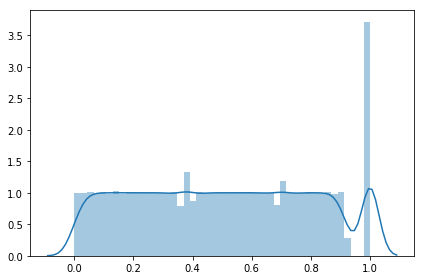

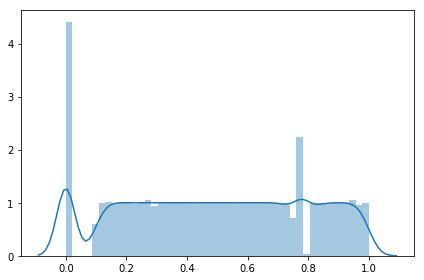

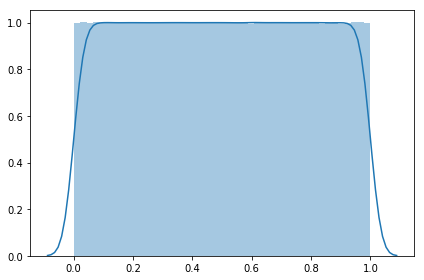

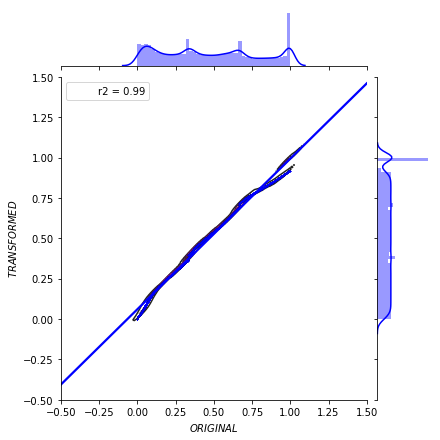

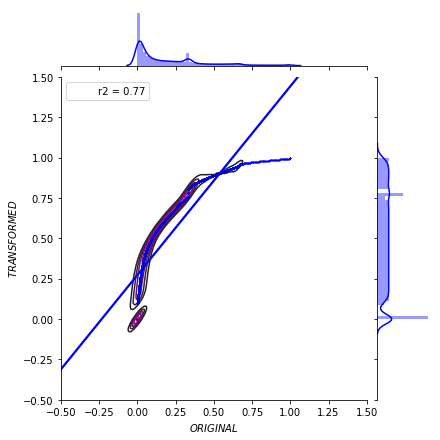

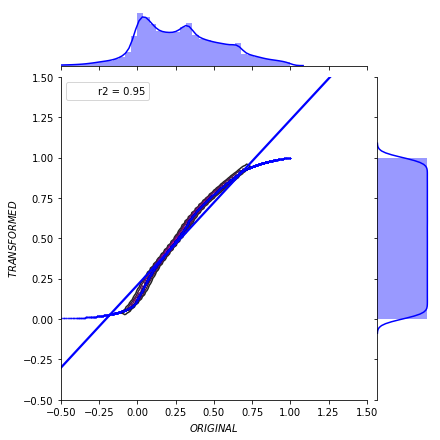

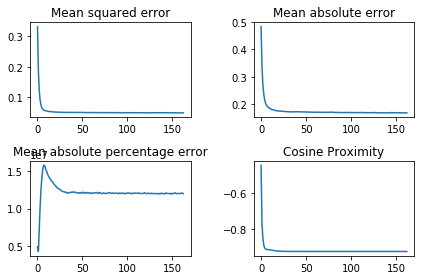

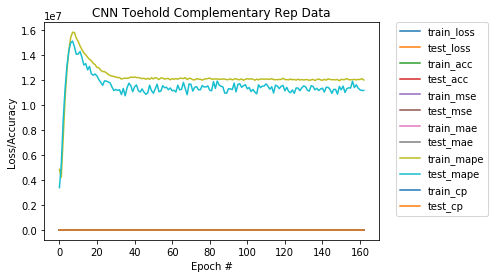

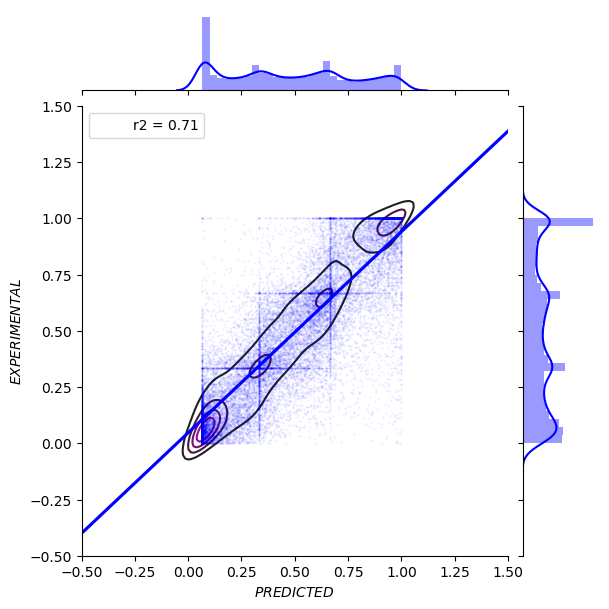

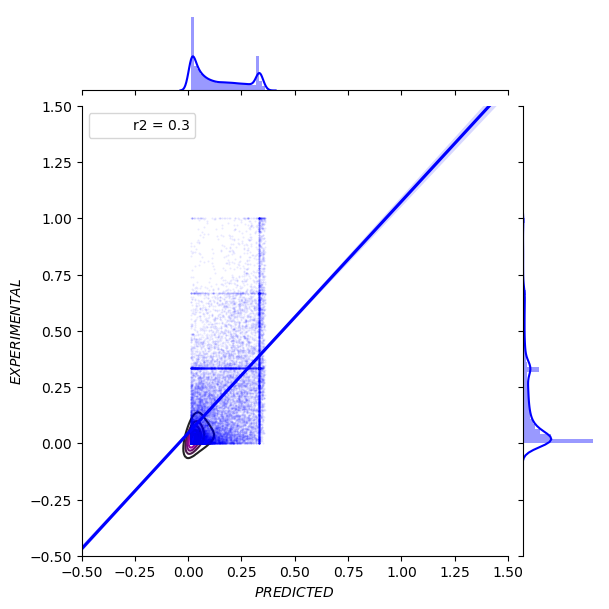

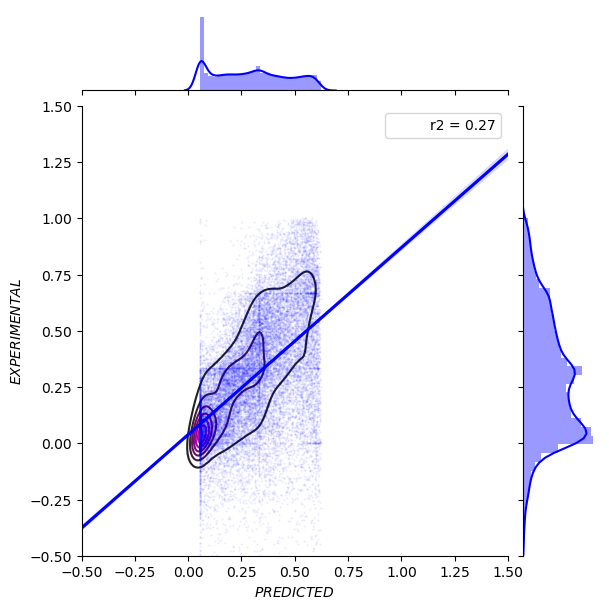

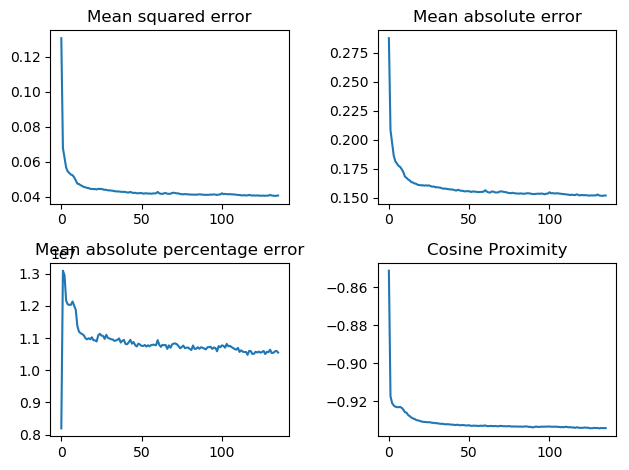

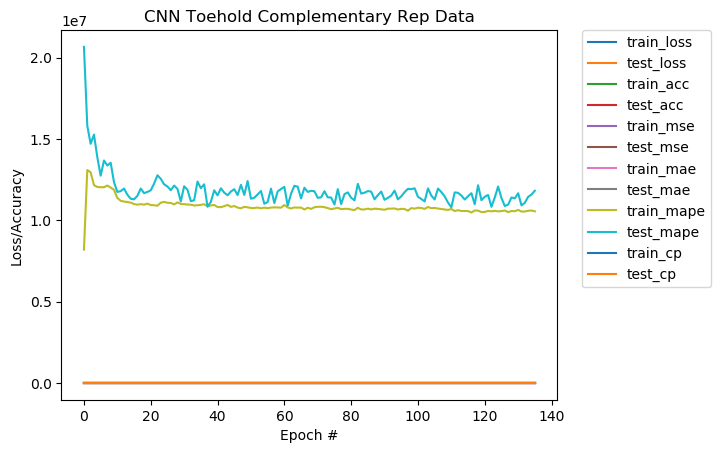

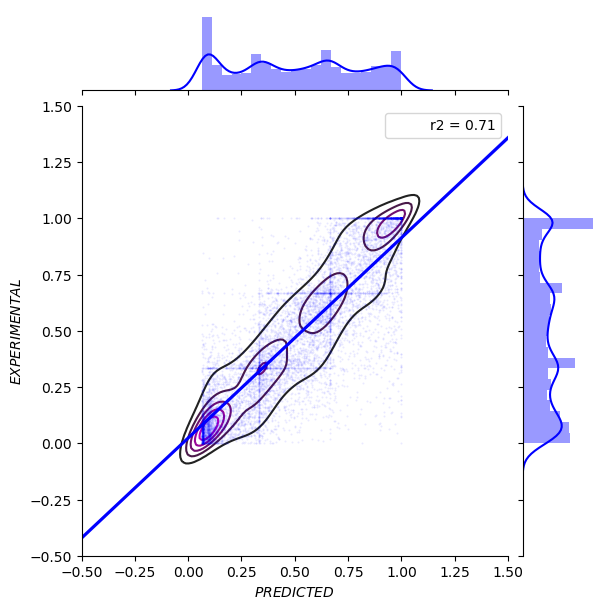

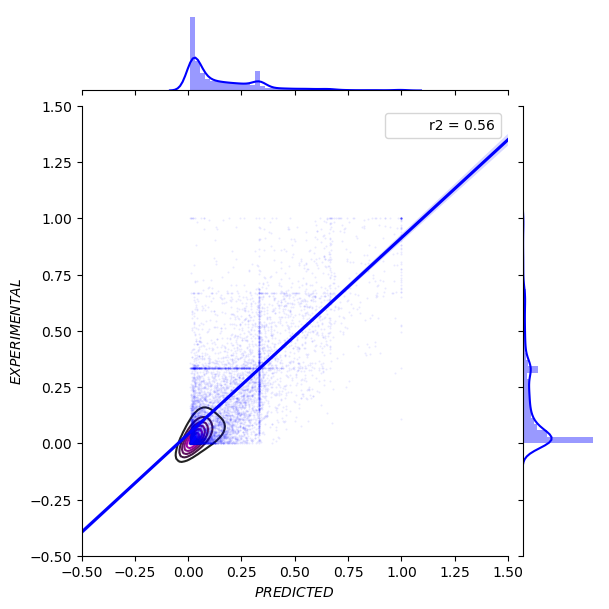

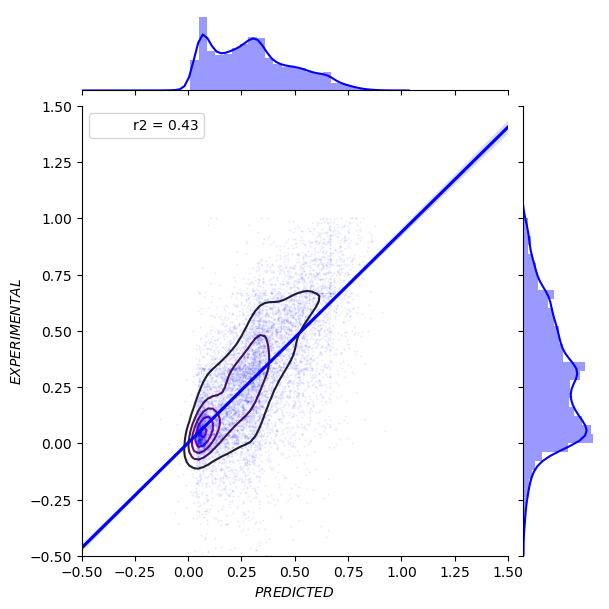

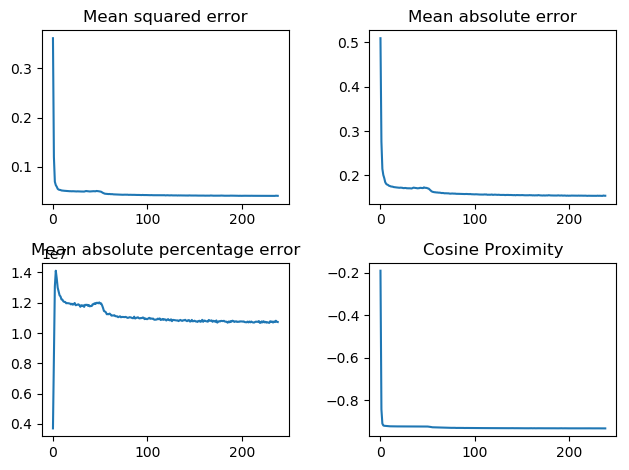

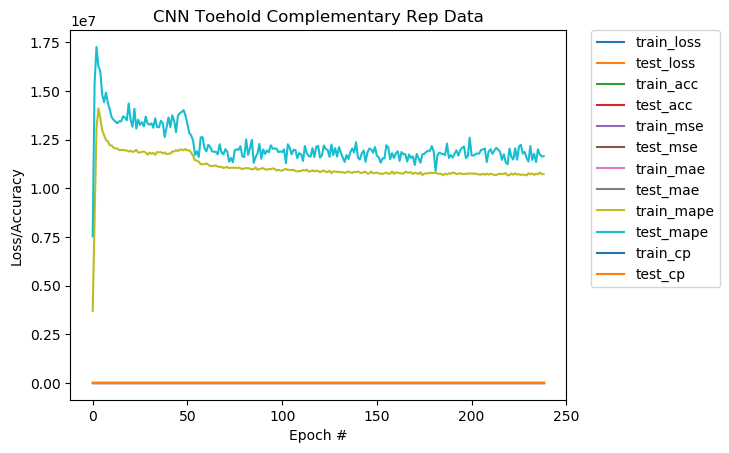

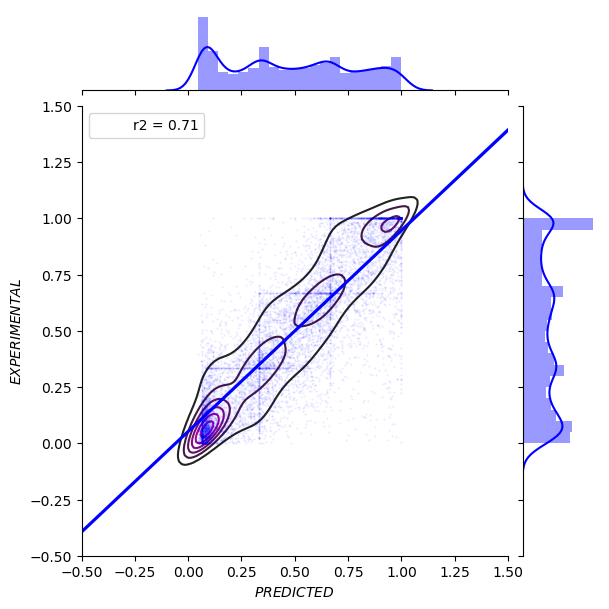

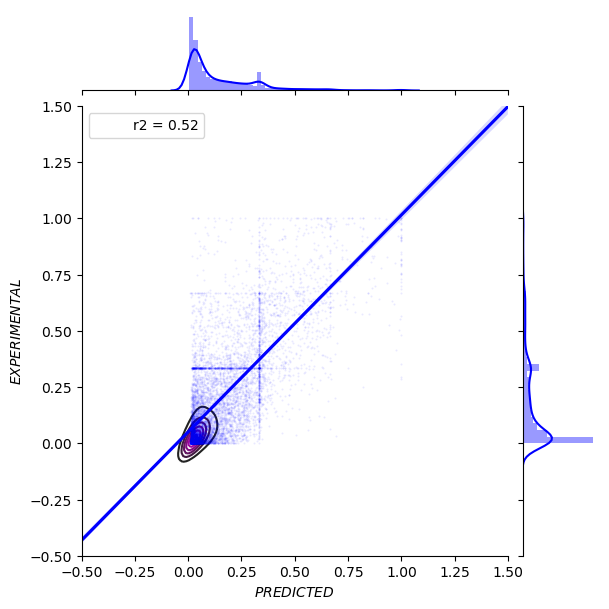

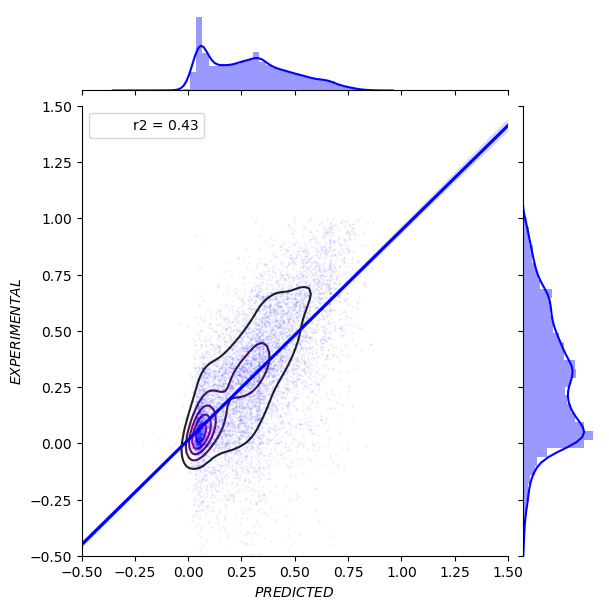

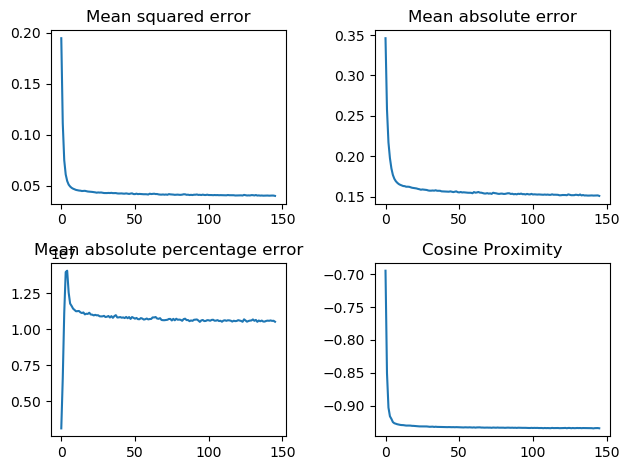

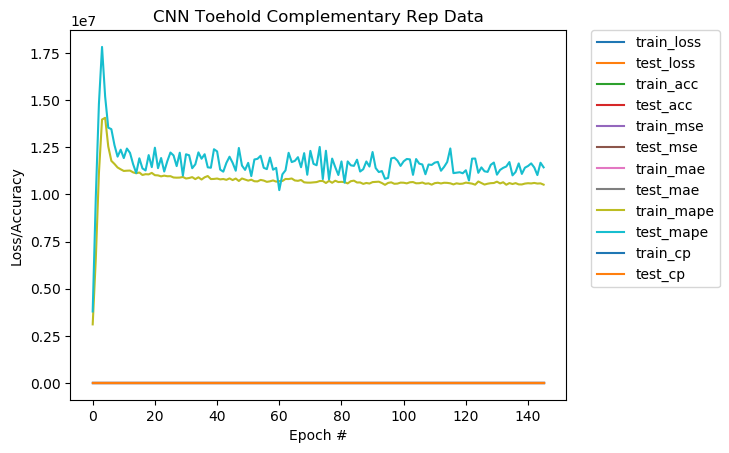

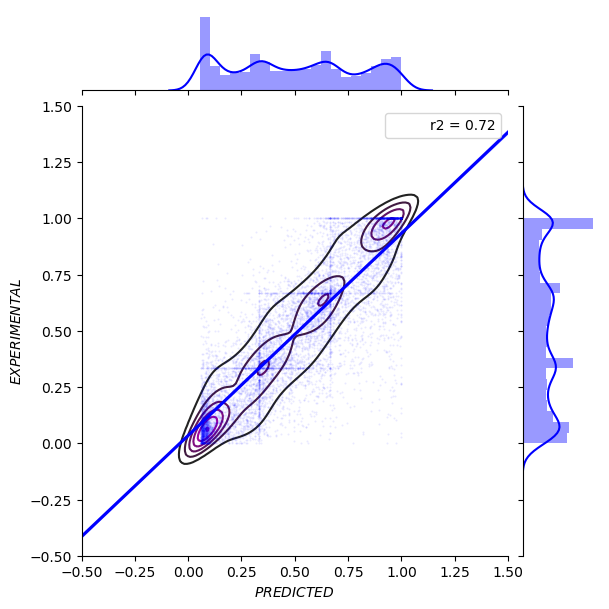

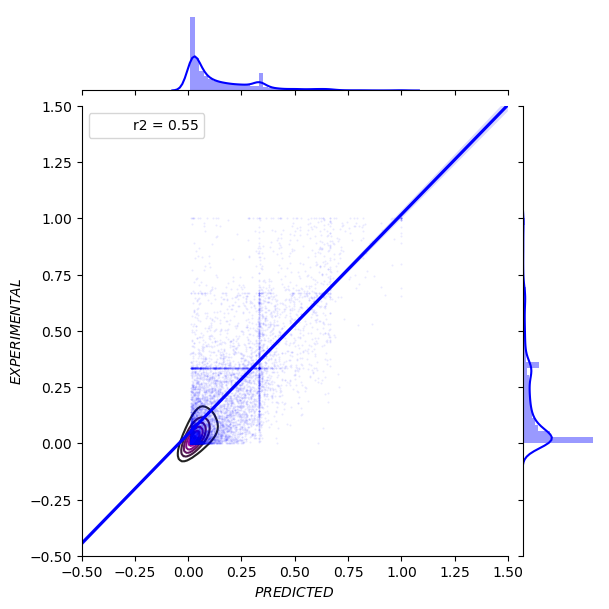

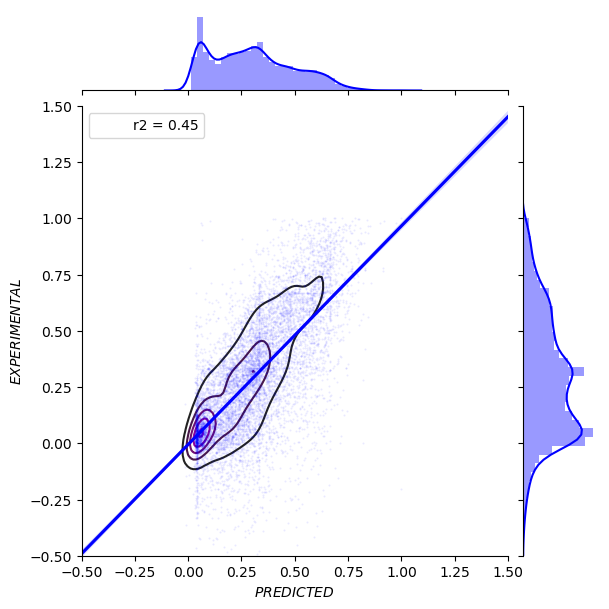

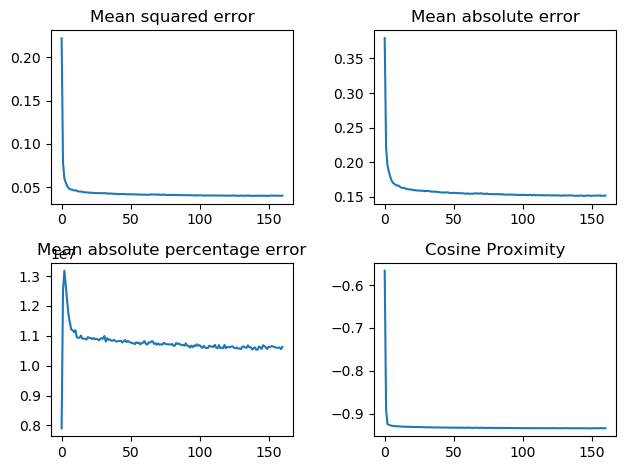

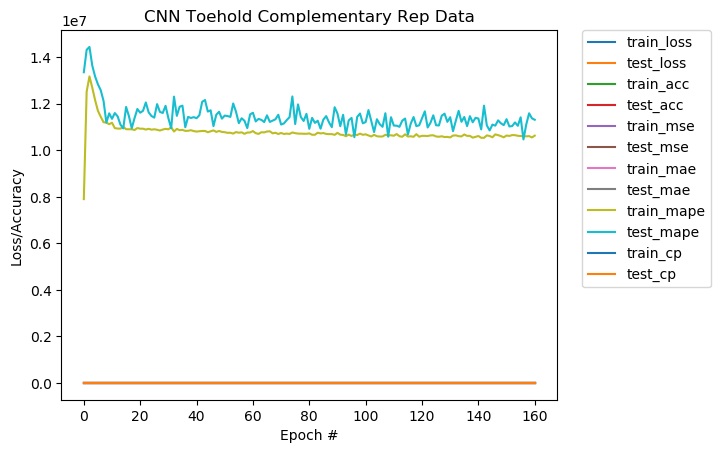

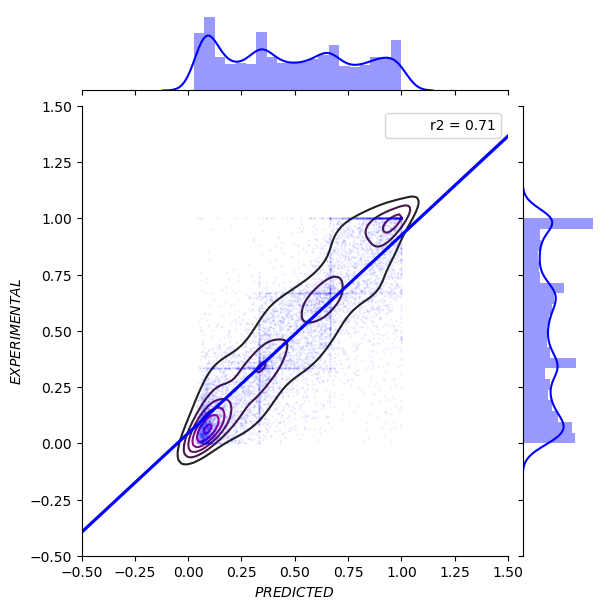

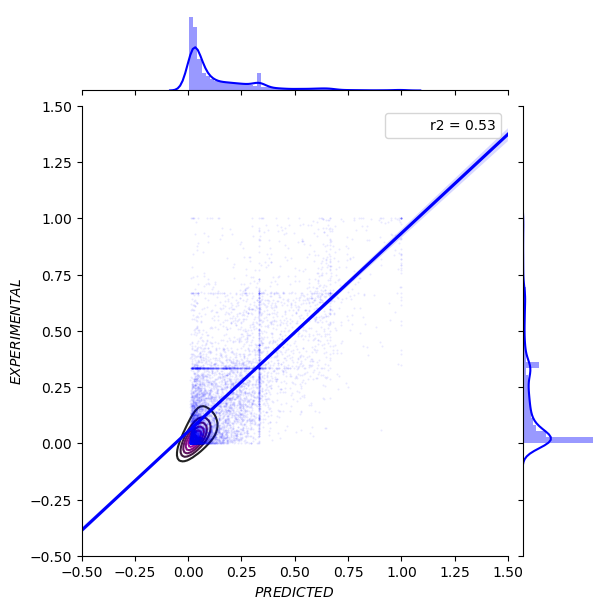

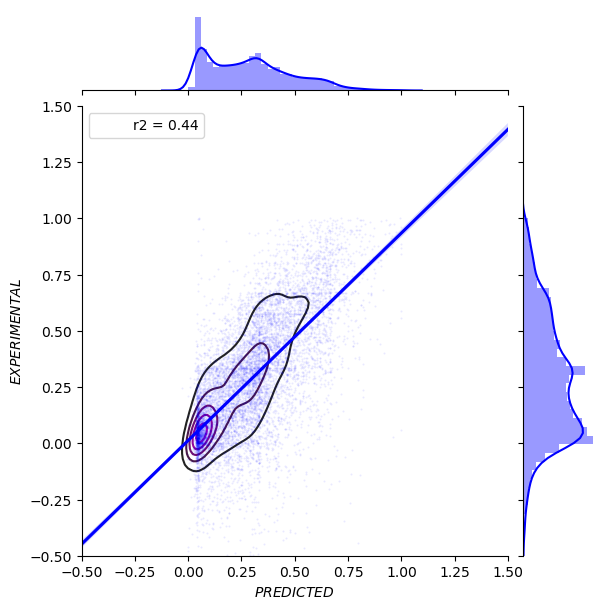

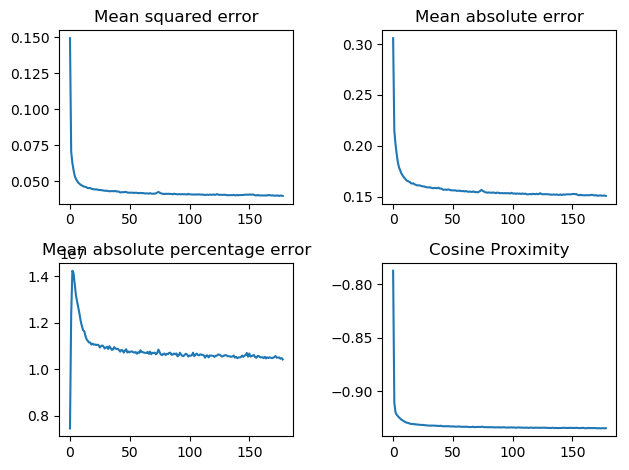

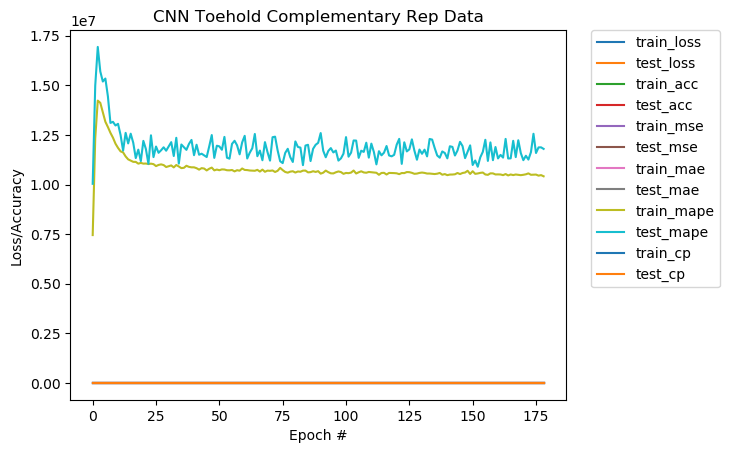

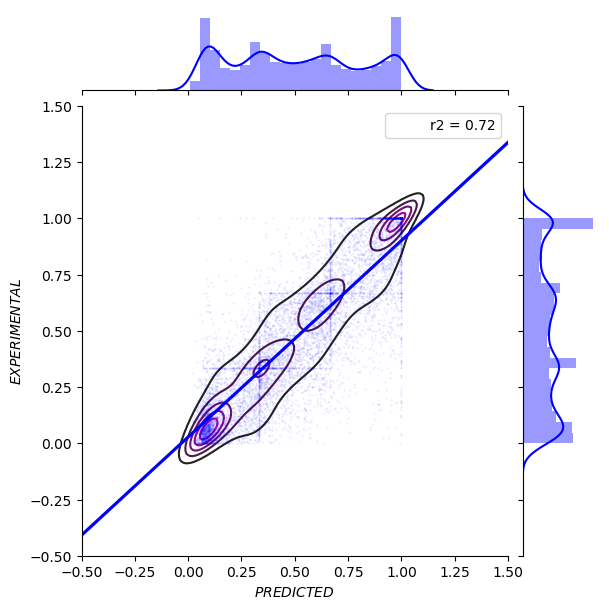

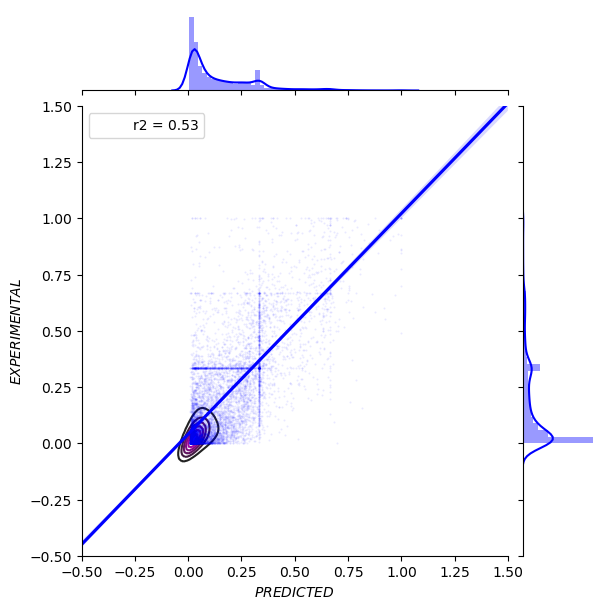

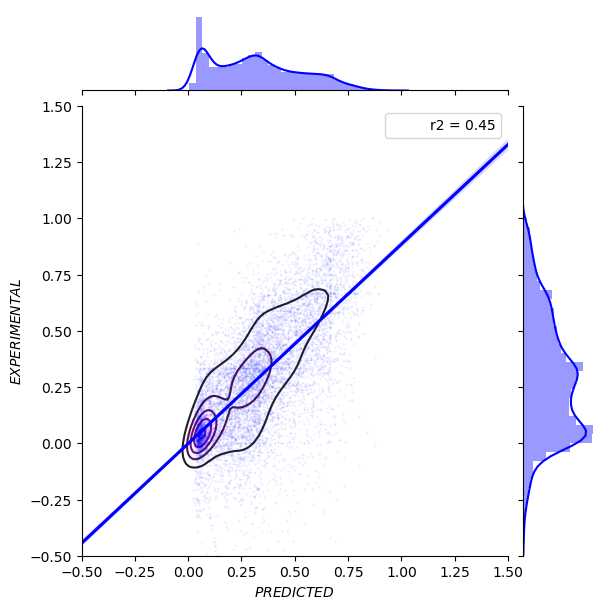

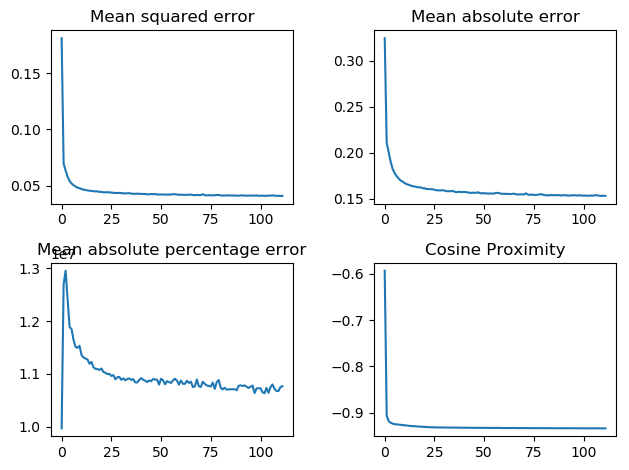

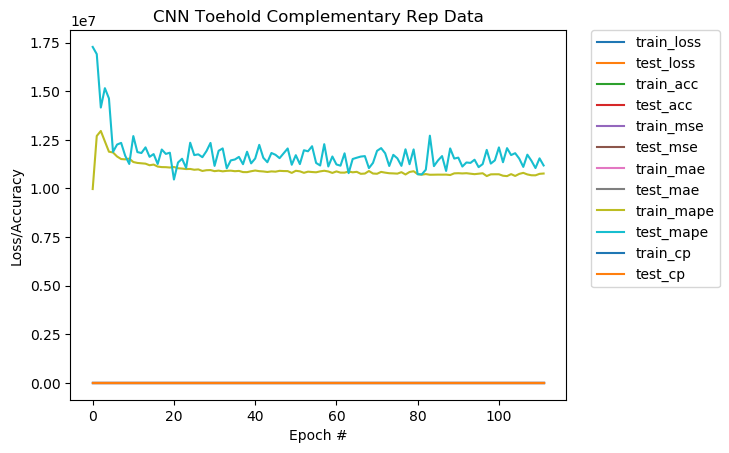

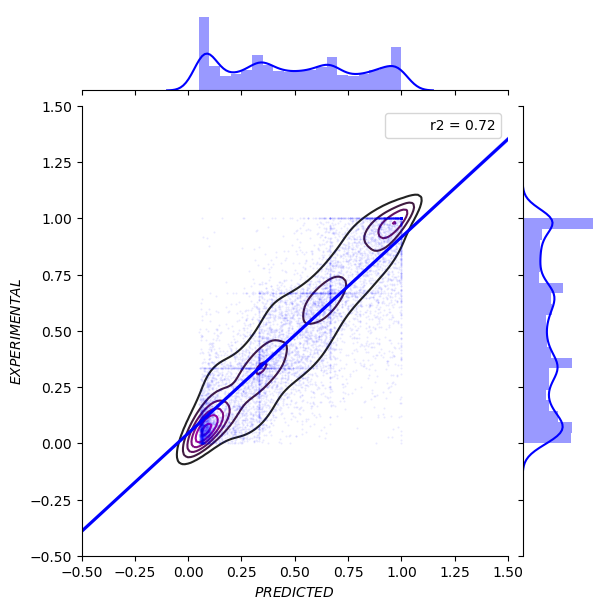

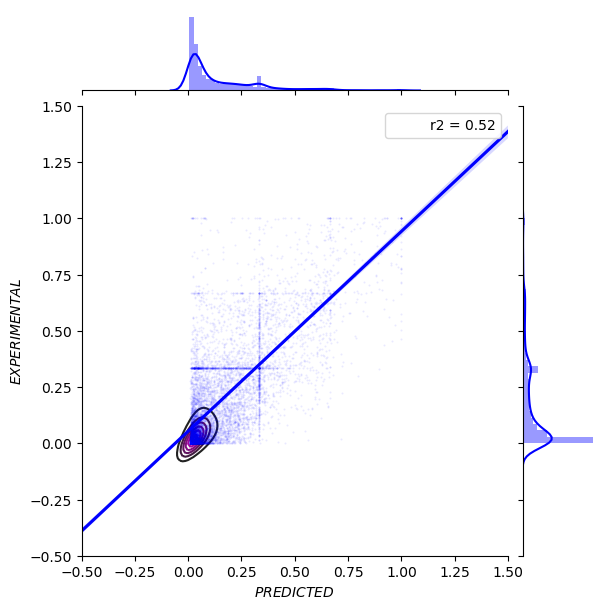

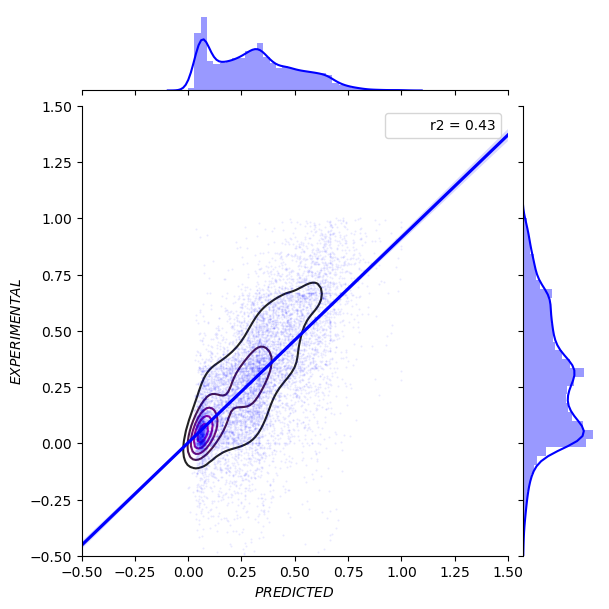

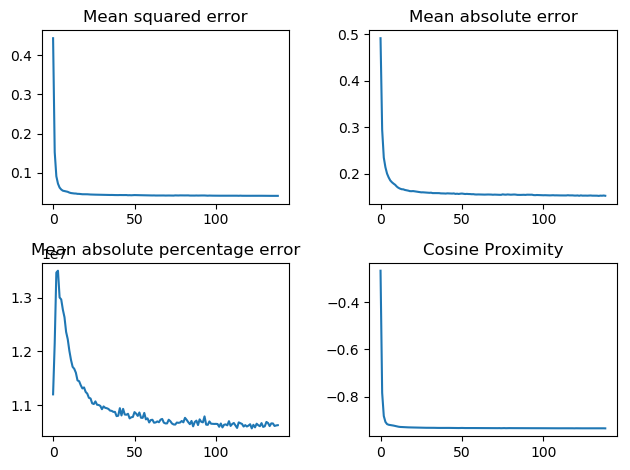

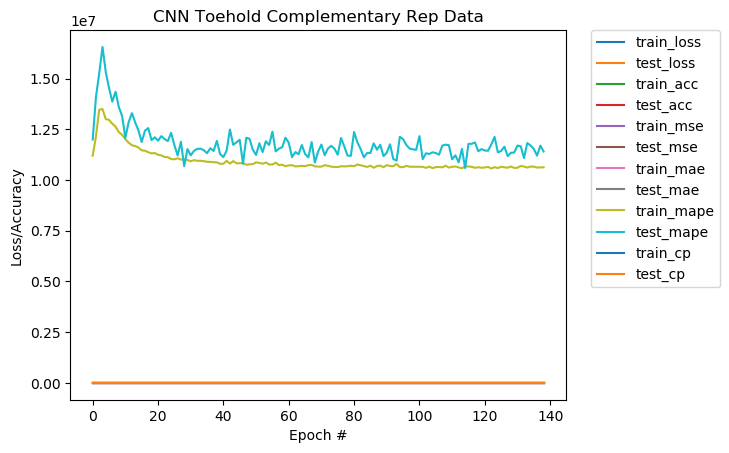

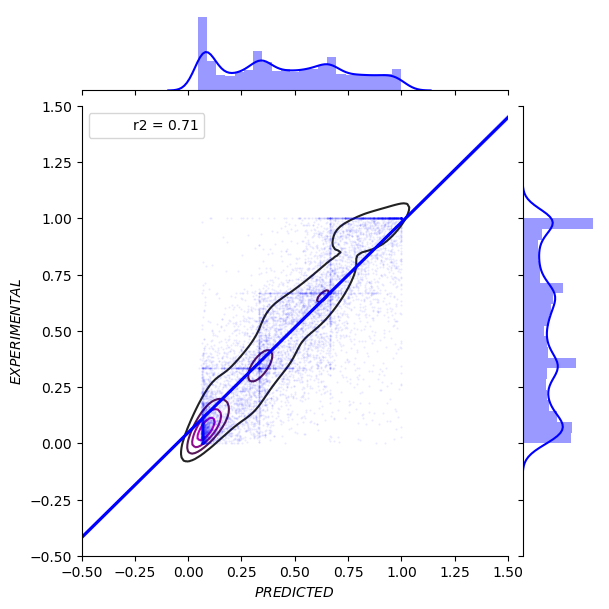

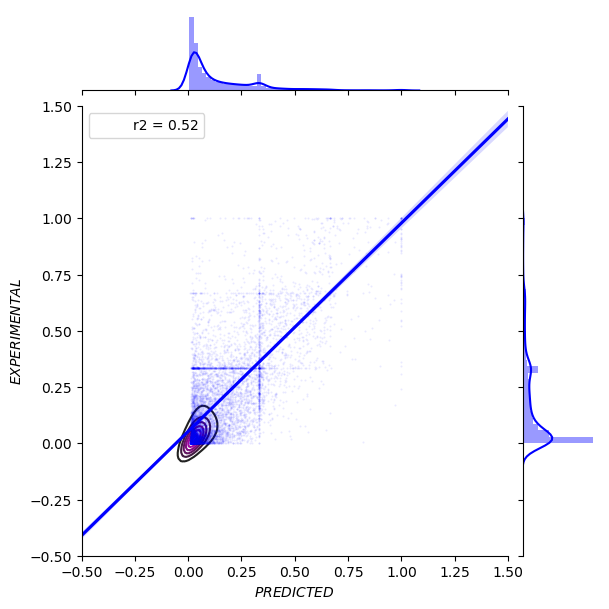

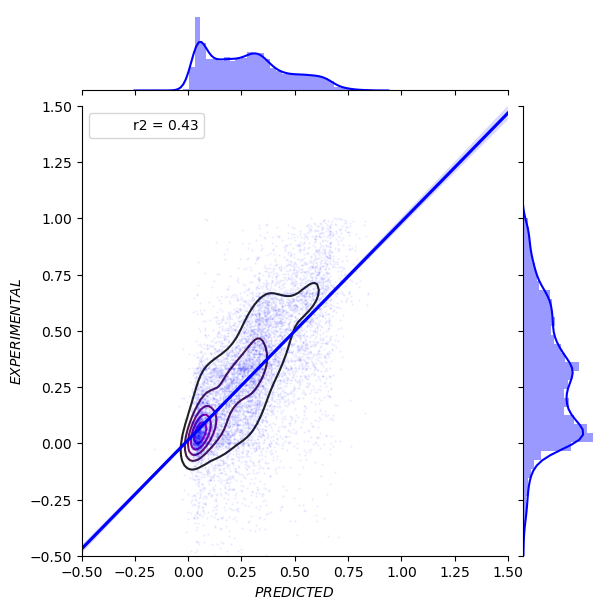

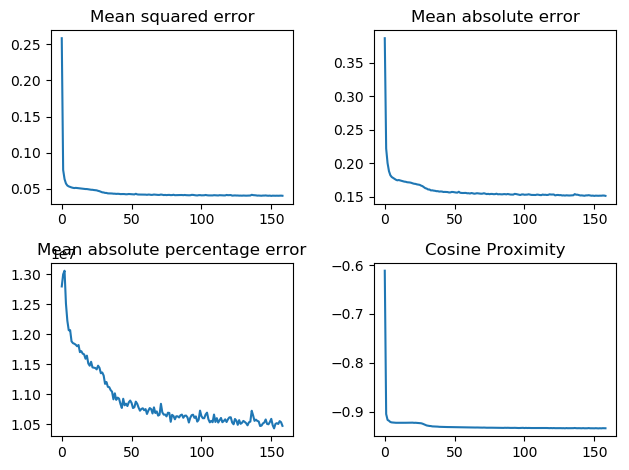

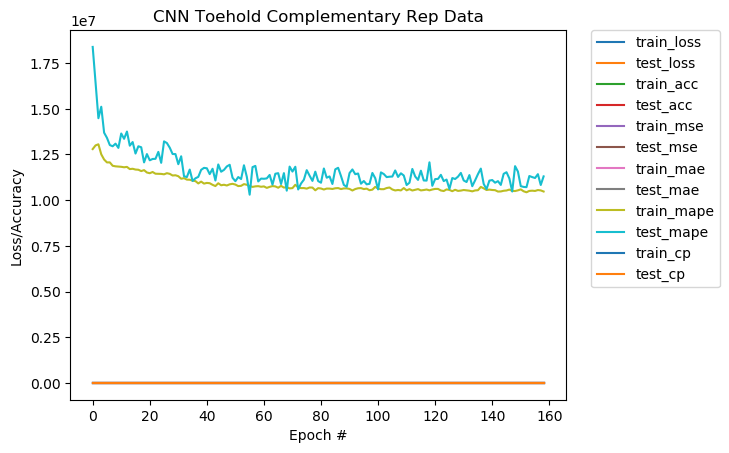

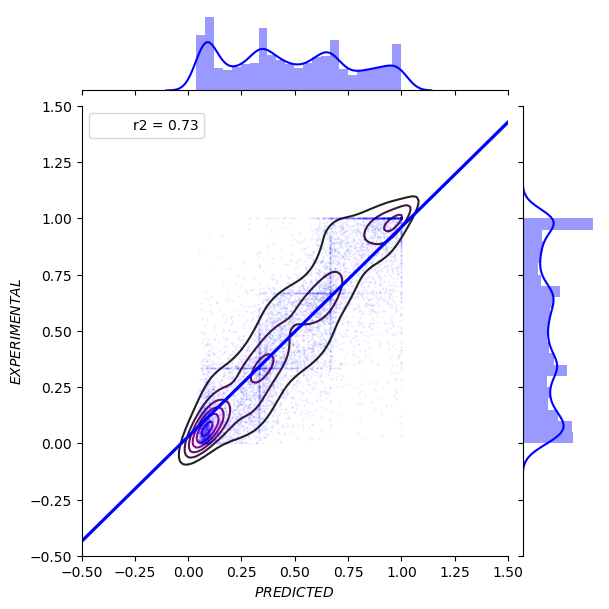

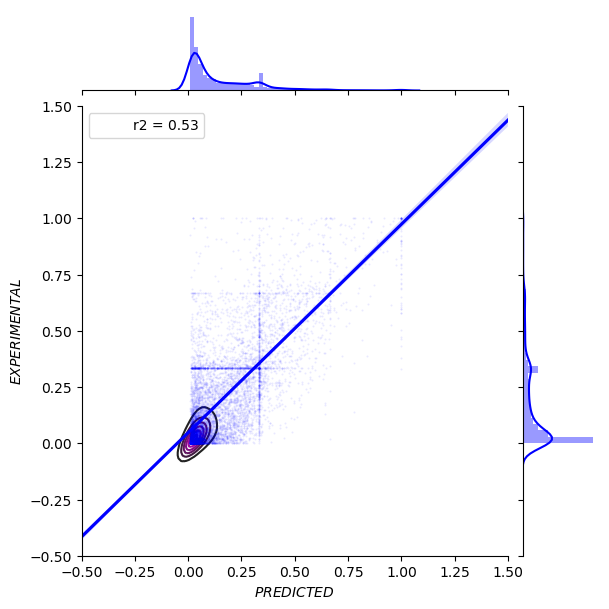

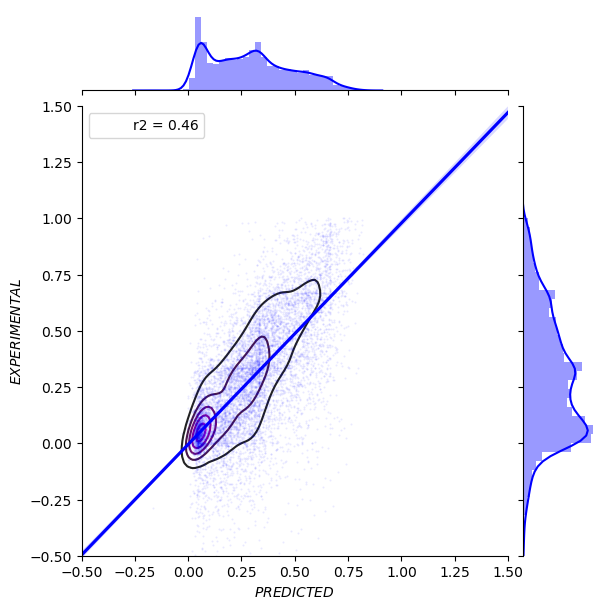

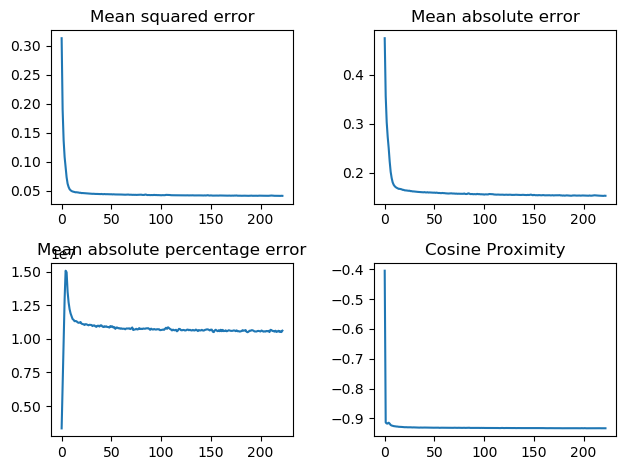

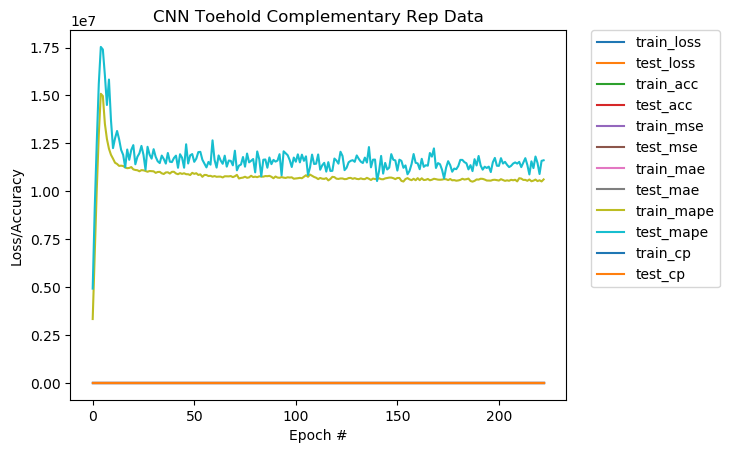

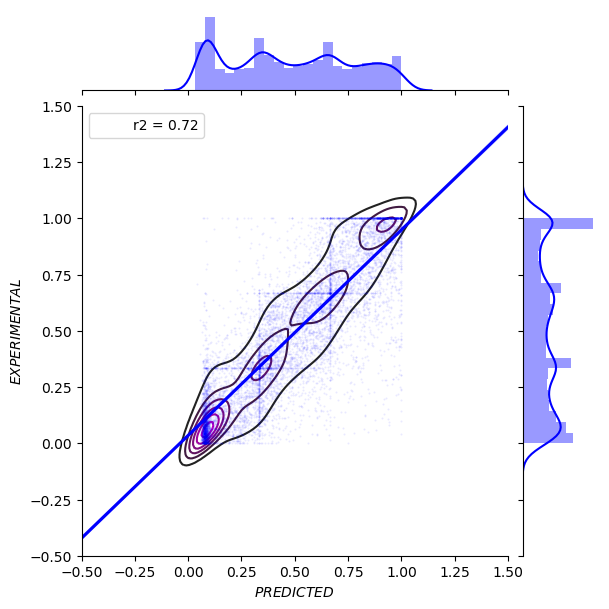

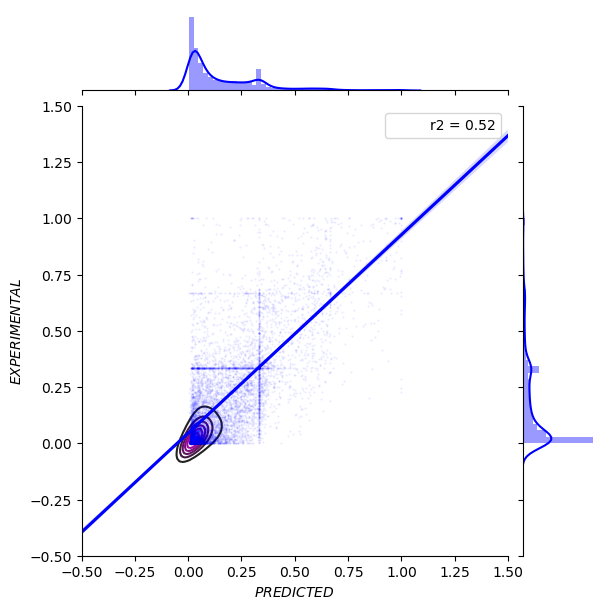

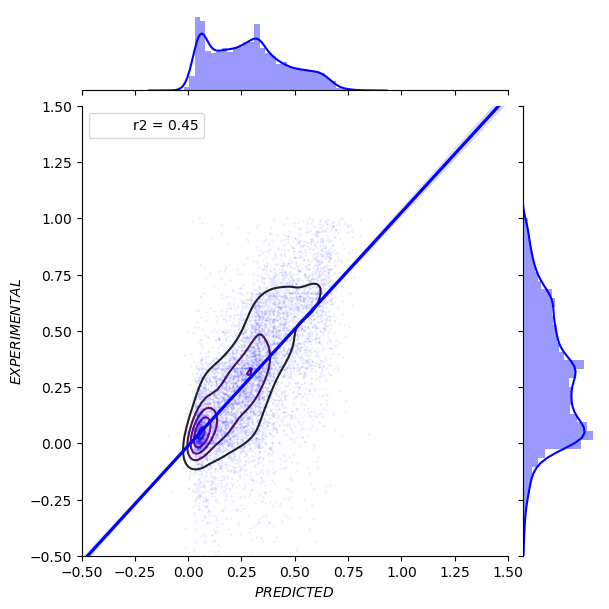

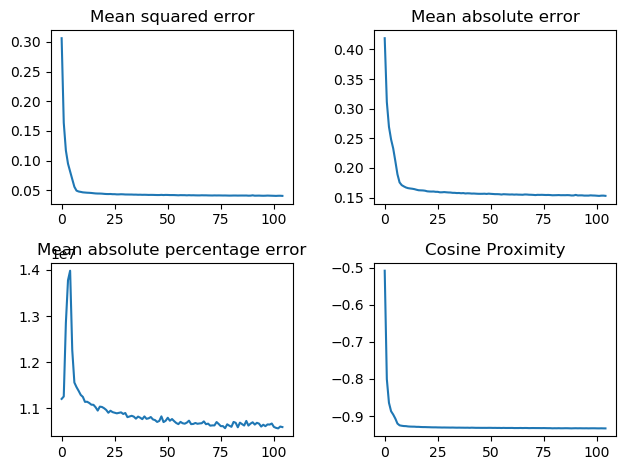

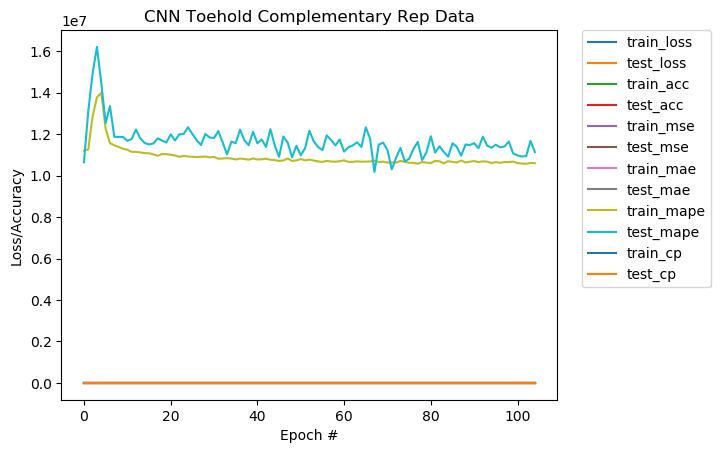

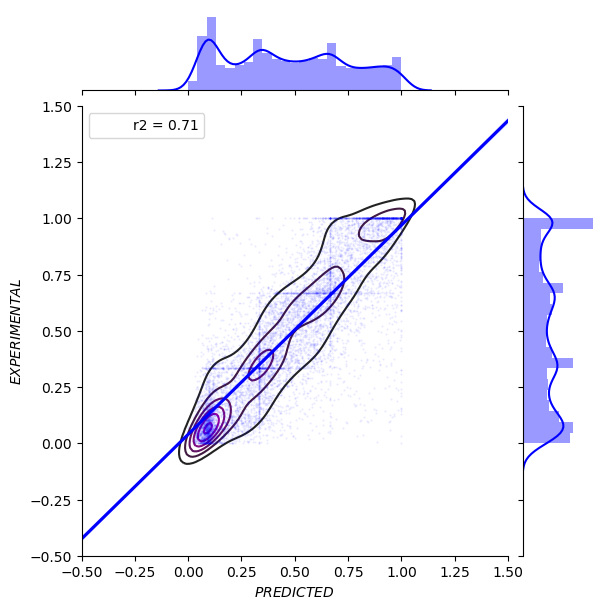

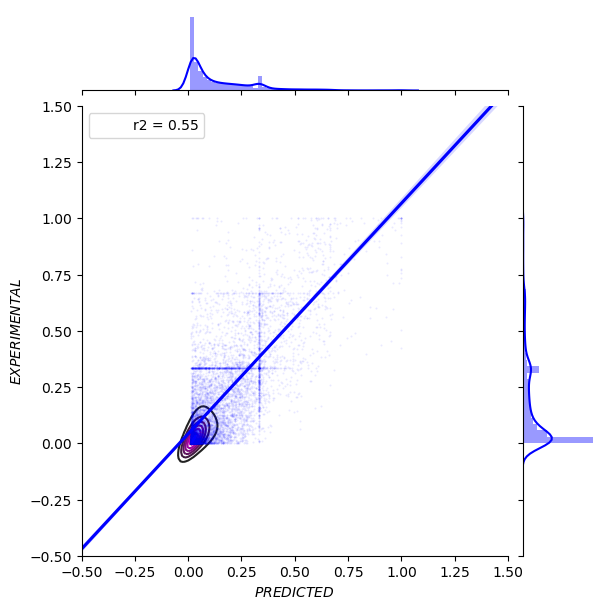

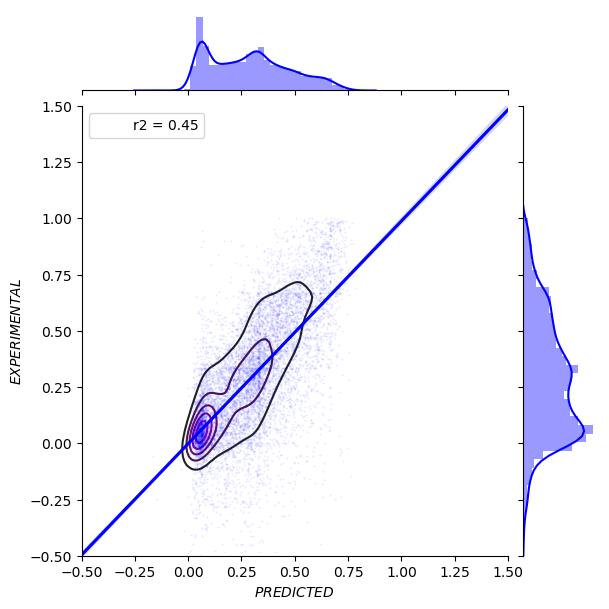

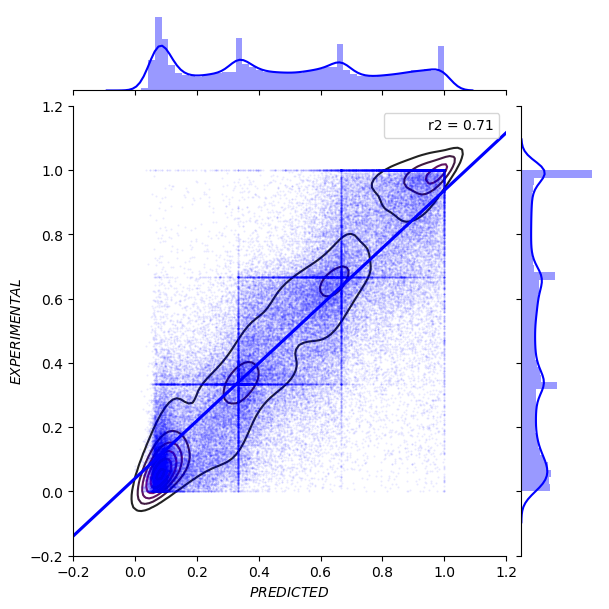

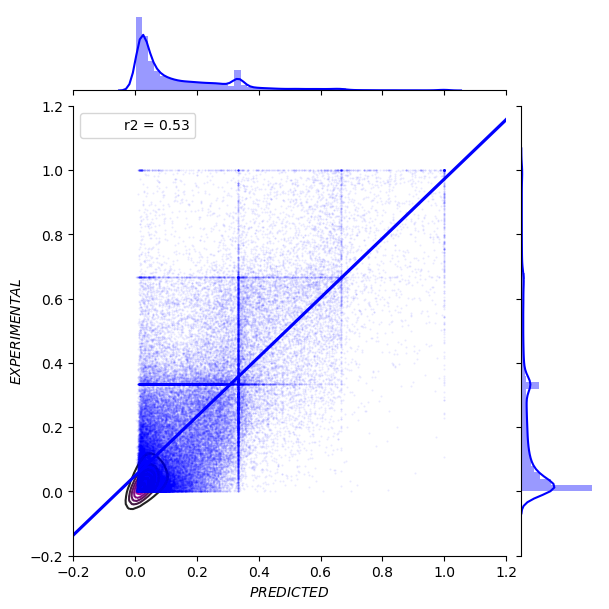

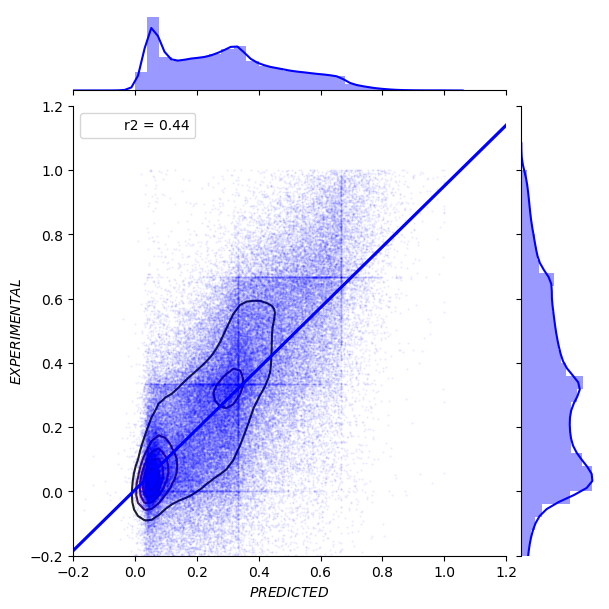

In [15]:
# RUN FULL MODEL ANALYSIS AND REPORTING model
execute_ensemble_model_analysis(core_models_path, model_name, data, input_cols_cnn, input_cols_mlp, output_cols, qc_levels, n_foldCV, verbose_init, evaluate)

-----------------------------------------------------------------------------------------------------------------------------

END OF CODE